# Импортируем библиотеки

In [697]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.utils import resample
from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE

# Загружаем данные

In [359]:
df_train = pd.read_csv('r42_welcome_train.csv', sep=';')
df_test = pd.read_csv('r42_welcome_test.csv', sep=';')
y_train = pd.read_csv('r42_welcome_train_res.csv', sep=';')

In [688]:
y_train = pd.read_csv('r42_welcome_train_res.csv', sep=';')

In [360]:
df_train = df_train.merge(y_train, on = 'ID')

#### Пропуски:

In [361]:
df_train.isnull().sum().sort_values(ascending = False)

C_3     24742
N_76    12429
N_82      354
N_81      179
Y           0
        ...  
N_56        0
N_57        0
N_58        0
N_59        0
ID          0
Length: 89, dtype: int64

In [362]:
df_test.isnull().sum().sort_values(ascending = False)

C_3     6090
N_76    3079
N_82      67
N_81      46
N_1        0
        ... 
N_56       0
N_57       0
N_58       0
N_59       0
ID         0
Length: 88, dtype: int64

Пропуски в трейне:

In [363]:
cols_with_mis = ['C_3', 'N_76', 'N_82', 'N_81']
for col in cols_with_mis:
    print('Процент пропущенных в {} значений – {:.2f} %'.format(col, df_train[col].isnull().sum()/df_train.shape[0]*100))

Процент пропущенных в C_3 значений – 41.24 %
Процент пропущенных в N_76 значений – 20.71 %
Процент пропущенных в N_82 значений – 0.59 %
Процент пропущенных в N_81 значений – 0.30 %


Пропуски в тесте:

In [364]:
for col in cols_with_mis:
    print('Процент пропущенных в {} значений – {:.2f} %'.format(col, df_test[col].isnull().sum()/df_test.shape[0]*100))

Процент пропущенных в C_3 значений – 40.60 %
Процент пропущенных в N_76 значений – 20.53 %
Процент пропущенных в N_82 значений – 0.45 %
Процент пропущенных в N_81 значений – 0.31 %


Игнорировать такие крупные пропуски не стоит, пропущенные значения станут таргетом и мы их заполним при помощи моделей машинного обучения.

# Предобработка

## Разберемся с датой

In [365]:
df_train['DT'] = pd.to_datetime(df_train['DT'])
df_train['Year'] = pd.DatetimeIndex(df_train['DT']).year
df_train['Month'] = pd.DatetimeIndex(df_train['DT']).month
df_train['Day of week'] = pd.DatetimeIndex(df_train['DT']).dayofweek

Год только один, поэтому убираем эту колонку, как и первоначальную:

In [366]:
df_train.drop(['DT', 'Year'], axis = 1, inplace = True)

Взглянем на распределение целевой переменной по месяцам и по дням недели:

In [367]:
df_train.groupby('Day of week')['Y'].value_counts()

Day of week  Y
0            0    5822
             1    2752
1            0    5785
             1    2888
2            0    5661
             1    2901
3            0    5639
             1    2899
4            0    6096
             1    2393
5            0    6324
             1    2302
6            0    6878
             1    1660
Name: Y, dtype: int64

Дублируем на тест:

In [368]:
df_test['DT'] = pd.to_datetime(df_test['DT'])
df_test['Month'] = pd.DatetimeIndex(df_test['DT']).month
df_test['Day of week'] = pd.DatetimeIndex(df_test['DT']).dayofweek

df_test.drop(['DT'], axis = 1, inplace = True)

## Избавимся от очевидно лишних признаков

In [369]:
df_train.drop(['N_65', 'N_3', 'C_2'], axis = 1, inplace = True)
df_test.drop(['N_65', 'N_3', 'C_2'], axis = 1, inplace = True)

# ЗАВЕРШЕНИЕ ОБЩИХ ШАГОВ

# I. Не категоризировать ничего (кроме тех, что названы категориальными)

## Обработка пропусков

__Алгорим__:
- Соединяю трейн и тест, чтобы было больше наблюдений
- Разделяю на трейн и на тест на основе того, где пропущенные, а где заполненные данные
- Из теста убираю колонку с пропущенными данные
- Делаю прогноз на основе какой-либо модели
- Заполняю пропуски значениями

Но прежде, чем заполнять эти признаки, рассмотрим их:

In [628]:
df_miss = pd.concat([df_train.drop('Y', axis = 1), df_test], ignore_index = True)
df_miss

,ID,C_1,N_1,N_2,N_4,N_5,N_6,N_7,N_8,N_9,...,N_76,N_77,N_78,C_4,N_79,N_80,N_81,N_82,Month,Day of week
0,27253,6,2.4,0.0,0,0,0,0,0,0,...,1.0000,2,780.0,1,0.0000,1.0000,0.7741,0.7383,2,6
1,173769,3,0.4,0.0,0,0,0,0,0,0,...,1.0000,1,270.0,1,0.0000,1.0000,-0.5309,-0.2683,12,5
2,138042,1,4.0,0.3,0,1,0,0,0,0,...,1.0000,2,550.0,1,0.0000,1.0000,0.1805,0.1026,10,4
3,49748,0,0.4,0.6,2,0,0,0,0,0,...,0.6667,1,330.0,5,0.0000,1.0000,-0.1871,0.3283,4,2
4,57182,0,0.0,0.0,1,1,1,0,0,1,...,0.9512,2,0.0,1,0.0488,0.1144,0.1169,0.3608,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,50410,0,0.0,0.4,0,1,1,0,0,0,...,1.0000,2,0.0,1,0.0000,1.0000,0.0527,1.4312,4,3
74996,138395,1,4.0,0.3,2,0,0,0,0,0,...,0.6667,1,450.0,8,0.1000,0.1961,-0.2223,-0.1148,10,4
74997,85628,1,0.0,0.0,0,0,0,0,0,0,...,1.0000,1,380.0,1,0.0000,1.0000,0.3821,1.7070,6,4
74998,159881,3,0.0,0.0,0,0,0,0,0,0,...,0.5294,1,330.0,1,0.9000,0.1593,0.1708,1.0204,11,5


# I.I. Игнорировать пропуски

#### Пропуски в C_3

Разделим данные на тест и трейн:

In [629]:
df_miss['C_3'].fillna(0, inplace = True)
df_miss_train = df_miss.loc[df_miss['C_3'] != 0]
df_miss_test = df_miss.loc[df_miss['C_3'] == 0]

Убирает колонку "C_3" из теста:

In [630]:
df_miss_test.drop('C_3', axis = 1, inplace = True)

Выделим категории из категориальных признаков:

In [631]:
r = re.compile(r'C_')
cat_cols = list(filter(r.match, list(df_train.columns)))
cat_cols.remove('C_3')
cat_cols

['C_1', 'C_4']

In [632]:
for col in cat_cols:
    df_miss_train[col] = df_miss_train[col].astype("category")
        
for col in cat_cols:
    df_miss_test[col] = df_miss_test[col].astype("category")

Из C_3 категории вычленять не надо:

In [633]:
df_miss_train.isnull().sum().sort_values(ascending = True)

ID               0
N_60             0
N_59             0
N_58             0
N_57             0
              ... 
N_22             0
N_30             0
Day of week      0
N_81           130
N_82           242
Length: 86, dtype: int64

In [634]:
df_miss_train['C_3'] = df_miss_train['C_3'].astype("int64")

In [635]:
df_miss_train = pd.get_dummies(df_miss_train)
df_miss_test = pd.get_dummies(df_miss_test)

In [636]:
df_miss_train.shape

(44168, 95)

In [637]:
df_miss_test.shape

(30832, 94)

In [638]:
r = re.compile(r'C_')
cat_cols = list(filter(r.match, list(df_miss_train.columns)))
cat_cols

['C_3',
 'C_1_0',
 'C_1_1',
 'C_1_3',
 'C_1_4',
 'C_1_6',
 'C_4_1',
 'C_4_2',
 'C_4_5',
 'C_4_6',
 'C_4_8',
 'C_4_9']

In [639]:
df_miss_train['C_3'] = df_miss_train['C_3'].astype('int64')

Для заполнения пропущенных значений используем LGMCLassifier:

In [640]:
X = df_miss_train.drop(['C_3', 'N_81', 'N_82', 'N_76'], axis = 1)
y = df_miss_train['C_3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [495]:
# from sklearn.feature_selection import RFECV

# # The "accuracy" scoring is proportional to the number of correct classifications
# rf = LGBMClassifier() 
# rfecv = RFECV(estimator=rf, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
# rfecv = rfecv.fit(X_train, y_train)

# print('Optimal number of features :', rfecv.n_features_)
# print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 67
Best features : Index(['ID', 'N_1', 'N_2', 'N_11', 'N_20', 'N_21', 'N_22', 'N_24', 'N_25',
       'N_26', 'N_27', 'N_28', 'N_29', 'N_30', 'N_31', 'N_32', 'N_33', 'N_34',
       'N_35', 'N_36', 'N_38', 'N_41', 'N_42', 'N_43', 'N_44', 'N_45', 'N_46',
       'N_47', 'N_48', 'N_49', 'N_50', 'N_51', 'N_52', 'N_53', 'N_54', 'N_55',
       'N_56', 'N_57', 'N_58', 'N_59', 'N_60', 'N_61', 'N_62', 'N_63', 'N_64',
       'N_66', 'N_67', 'N_68', 'N_69', 'N_70', 'N_71', 'N_72', 'N_73', 'N_74',
       'N_75', 'N_77', 'N_78', 'N_79', 'N_80', 'Day of week', 'C_1_6', 'C_4_1',
       'C_4_2', 'C_4_5', 'C_4_6', 'C_4_8', 'C_4_9'],
      dtype='object')

In [496]:
# import matplotlib.pyplot as plt
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score of number of selected features")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

По графику можно оставить 45 фичей.

In [641]:
best_features_lgbm = ['ID', 'N_1', 'N_2', 'N_11', 'N_20', 'N_21', 
                      'N_22', 'N_24', 'N_25', 'N_26', 'N_27', 'N_28', 'N_29', 
                      'N_30', 'N_31', 'N_32', 'N_33', 'N_34', 'N_35', 'N_36', 
                      'N_38', 'N_41', 'N_42', 'N_43', 'N_44', 'N_45', 'N_46', 
                      'N_47', 'N_48', 'N_49', 'N_50', 'N_51', 'N_52', 'N_53', 
                      'N_54', 'N_55', 'N_56', 'N_57', 'N_58', 'N_59', 'N_60', 
                      'N_61', 'N_62', 'N_63', 'N_64', 'N_66', 'N_67', 'N_68', 
                      'N_69', 'N_70', 'N_71', 'N_72', 'N_73', 'N_74', 'N_75', 
                      'N_77', 'N_78', 'N_79', 'N_80', 'Day of week', 'C_1_6', 
                      'C_4_1', 'C_4_2', 'C_4_5', 'C_4_6', 'C_4_8', 'C_4_9']

#### best_features_lgbm (лучшая комбинация)

In [642]:
from catboost import CatBoostClassifier

In [643]:
model = CatBoostClassifier(learning_rate = 0.05)
model.fit(X_train[best_features_lgbm], y_train)
mean_absolute_error(y_test, model.predict(X_test[best_features_lgbm]))

0:	learn: 1.0586304	total: 59.3ms	remaining: 59.3s
1:	learn: 1.0212804	total: 91ms	remaining: 45.4s
2:	learn: 0.9875443	total: 115ms	remaining: 38.2s
3:	learn: 0.9580973	total: 137ms	remaining: 34.2s
4:	learn: 0.9325808	total: 160ms	remaining: 31.8s
5:	learn: 0.9101804	total: 182ms	remaining: 30.2s
6:	learn: 0.8868839	total: 206ms	remaining: 29.2s
7:	learn: 0.8656493	total: 230ms	remaining: 28.5s
8:	learn: 0.8472451	total: 253ms	remaining: 27.9s
9:	learn: 0.8318465	total: 296ms	remaining: 29.3s
10:	learn: 0.8160220	total: 332ms	remaining: 29.9s
11:	learn: 0.8010625	total: 365ms	remaining: 30s
12:	learn: 0.7880318	total: 389ms	remaining: 29.6s
13:	learn: 0.7759850	total: 412ms	remaining: 29s
14:	learn: 0.7635544	total: 437ms	remaining: 28.7s
15:	learn: 0.7536743	total: 461ms	remaining: 28.4s
16:	learn: 0.7432523	total: 487ms	remaining: 28.1s
17:	learn: 0.7330811	total: 531ms	remaining: 29s
18:	learn: 0.7247854	total: 559ms	remaining: 28.8s
19:	learn: 0.7170518	total: 581ms	remaining: 28

161:	learn: 0.5244712	total: 4.55s	remaining: 23.6s
162:	learn: 0.5241548	total: 4.58s	remaining: 23.5s
163:	learn: 0.5240221	total: 4.6s	remaining: 23.5s
164:	learn: 0.5236383	total: 4.63s	remaining: 23.4s
165:	learn: 0.5233169	total: 4.65s	remaining: 23.4s
166:	learn: 0.5225811	total: 4.68s	remaining: 23.3s
167:	learn: 0.5223225	total: 4.7s	remaining: 23.3s
168:	learn: 0.5218529	total: 4.73s	remaining: 23.3s
169:	learn: 0.5215990	total: 4.75s	remaining: 23.2s
170:	learn: 0.5212285	total: 4.78s	remaining: 23.2s
171:	learn: 0.5210437	total: 4.8s	remaining: 23.1s
172:	learn: 0.5206481	total: 4.82s	remaining: 23s
173:	learn: 0.5204821	total: 4.84s	remaining: 23s
174:	learn: 0.5200307	total: 4.87s	remaining: 22.9s
175:	learn: 0.5198403	total: 4.89s	remaining: 22.9s
176:	learn: 0.5195316	total: 4.91s	remaining: 22.8s
177:	learn: 0.5191195	total: 4.94s	remaining: 22.8s
178:	learn: 0.5187606	total: 4.97s	remaining: 22.8s
179:	learn: 0.5184662	total: 4.99s	remaining: 22.7s
180:	learn: 0.51827

320:	learn: 0.4861024	total: 8.36s	remaining: 17.7s
321:	learn: 0.4858272	total: 8.4s	remaining: 17.7s
322:	learn: 0.4856763	total: 8.42s	remaining: 17.7s
323:	learn: 0.4855488	total: 8.44s	remaining: 17.6s
324:	learn: 0.4853794	total: 8.47s	remaining: 17.6s
325:	learn: 0.4852488	total: 8.49s	remaining: 17.6s
326:	learn: 0.4850125	total: 8.52s	remaining: 17.5s
327:	learn: 0.4848351	total: 8.54s	remaining: 17.5s
328:	learn: 0.4847539	total: 8.56s	remaining: 17.5s
329:	learn: 0.4846053	total: 8.59s	remaining: 17.4s
330:	learn: 0.4845283	total: 8.61s	remaining: 17.4s
331:	learn: 0.4844243	total: 8.63s	remaining: 17.4s
332:	learn: 0.4840564	total: 8.66s	remaining: 17.3s
333:	learn: 0.4838760	total: 8.68s	remaining: 17.3s
334:	learn: 0.4837647	total: 8.7s	remaining: 17.3s
335:	learn: 0.4835874	total: 8.72s	remaining: 17.2s
336:	learn: 0.4834358	total: 8.74s	remaining: 17.2s
337:	learn: 0.4832646	total: 8.77s	remaining: 17.2s
338:	learn: 0.4830817	total: 8.79s	remaining: 17.1s
339:	learn: 0.

482:	learn: 0.4622233	total: 12.5s	remaining: 13.4s
483:	learn: 0.4620955	total: 12.5s	remaining: 13.3s
484:	learn: 0.4619573	total: 12.5s	remaining: 13.3s
485:	learn: 0.4618504	total: 12.6s	remaining: 13.3s
486:	learn: 0.4617496	total: 12.6s	remaining: 13.3s
487:	learn: 0.4615950	total: 12.6s	remaining: 13.2s
488:	learn: 0.4615077	total: 12.6s	remaining: 13.2s
489:	learn: 0.4613345	total: 12.7s	remaining: 13.2s
490:	learn: 0.4612598	total: 12.7s	remaining: 13.1s
491:	learn: 0.4611465	total: 12.7s	remaining: 13.1s
492:	learn: 0.4610621	total: 12.7s	remaining: 13.1s
493:	learn: 0.4609962	total: 12.8s	remaining: 13.1s
494:	learn: 0.4608885	total: 12.8s	remaining: 13.1s
495:	learn: 0.4608369	total: 12.9s	remaining: 13.1s
496:	learn: 0.4607375	total: 12.9s	remaining: 13.1s
497:	learn: 0.4606584	total: 12.9s	remaining: 13.1s
498:	learn: 0.4604577	total: 13s	remaining: 13s
499:	learn: 0.4603046	total: 13s	remaining: 13s
500:	learn: 0.4602212	total: 13.1s	remaining: 13s
501:	learn: 0.4601532	

648:	learn: 0.4433866	total: 17.5s	remaining: 9.46s
649:	learn: 0.4432970	total: 17.5s	remaining: 9.43s
650:	learn: 0.4431653	total: 17.5s	remaining: 9.4s
651:	learn: 0.4431012	total: 17.6s	remaining: 9.37s
652:	learn: 0.4430082	total: 17.6s	remaining: 9.35s
653:	learn: 0.4428669	total: 17.6s	remaining: 9.32s
654:	learn: 0.4427088	total: 17.6s	remaining: 9.29s
655:	learn: 0.4426182	total: 17.7s	remaining: 9.26s
656:	learn: 0.4425226	total: 17.7s	remaining: 9.23s
657:	learn: 0.4423487	total: 17.7s	remaining: 9.21s
658:	learn: 0.4423048	total: 17.7s	remaining: 9.18s
659:	learn: 0.4421726	total: 17.8s	remaining: 9.15s
660:	learn: 0.4420429	total: 17.8s	remaining: 9.12s
661:	learn: 0.4419806	total: 17.8s	remaining: 9.09s
662:	learn: 0.4418099	total: 17.8s	remaining: 9.06s
663:	learn: 0.4416752	total: 17.9s	remaining: 9.04s
664:	learn: 0.4416222	total: 17.9s	remaining: 9.01s
665:	learn: 0.4415087	total: 17.9s	remaining: 8.98s
666:	learn: 0.4414501	total: 17.9s	remaining: 8.95s
667:	learn: 0

807:	learn: 0.4264893	total: 21.7s	remaining: 5.15s
808:	learn: 0.4264007	total: 21.7s	remaining: 5.12s
809:	learn: 0.4261660	total: 21.7s	remaining: 5.1s
810:	learn: 0.4260939	total: 21.8s	remaining: 5.07s
811:	learn: 0.4259989	total: 21.8s	remaining: 5.04s
812:	learn: 0.4259217	total: 21.8s	remaining: 5.02s
813:	learn: 0.4257940	total: 21.8s	remaining: 4.99s
814:	learn: 0.4257217	total: 21.9s	remaining: 4.96s
815:	learn: 0.4256414	total: 21.9s	remaining: 4.94s
816:	learn: 0.4255387	total: 21.9s	remaining: 4.91s
817:	learn: 0.4254156	total: 22s	remaining: 4.88s
818:	learn: 0.4253117	total: 22s	remaining: 4.86s
819:	learn: 0.4251985	total: 22s	remaining: 4.83s
820:	learn: 0.4250845	total: 22s	remaining: 4.8s
821:	learn: 0.4250165	total: 22.1s	remaining: 4.77s
822:	learn: 0.4248773	total: 22.1s	remaining: 4.75s
823:	learn: 0.4247238	total: 22.1s	remaining: 4.72s
824:	learn: 0.4246430	total: 22.1s	remaining: 4.69s
825:	learn: 0.4245692	total: 22.2s	remaining: 4.67s
826:	learn: 0.4244137	

974:	learn: 0.4099599	total: 26.5s	remaining: 680ms
975:	learn: 0.4097963	total: 26.6s	remaining: 653ms
976:	learn: 0.4097754	total: 26.6s	remaining: 626ms
977:	learn: 0.4097206	total: 26.6s	remaining: 598ms
978:	learn: 0.4096802	total: 26.6s	remaining: 571ms
979:	learn: 0.4095902	total: 26.6s	remaining: 544ms
980:	learn: 0.4095119	total: 26.7s	remaining: 517ms
981:	learn: 0.4094672	total: 26.7s	remaining: 489ms
982:	learn: 0.4094257	total: 26.7s	remaining: 462ms
983:	learn: 0.4093445	total: 26.7s	remaining: 435ms
984:	learn: 0.4092882	total: 26.8s	remaining: 408ms
985:	learn: 0.4091979	total: 26.8s	remaining: 381ms
986:	learn: 0.4091135	total: 26.8s	remaining: 353ms
987:	learn: 0.4090310	total: 26.9s	remaining: 326ms
988:	learn: 0.4088770	total: 26.9s	remaining: 299ms
989:	learn: 0.4088038	total: 27s	remaining: 272ms
990:	learn: 0.4087218	total: 27s	remaining: 245ms
991:	learn: 0.4085919	total: 27s	remaining: 218ms
992:	learn: 0.4085141	total: 27.1s	remaining: 191ms
993:	learn: 0.4084

0.20952250274423712

Заменяем пропущенные значения предсказаниями:

In [644]:
c_3_pred = model.predict(df_miss_test[best_features_lgbm])
df_miss_test['C_3'] = c_3_pred

Обратно соединяем таблицы:

In [645]:
df_miss = pd.concat([df_miss_train, df_miss_test], join = 'inner', ignore_index=False)
df_miss.sort_index(ascending=True, inplace = True)

#### Пропуски в N_76

In [646]:
df_miss.isnull().sum().sort_values(ascending = True)

ID          0
N_68        0
N_67        0
N_66        0
N_64        0
        ...  
N_25        0
N_23        0
N_81      225
N_82      421
N_76    15508
Length: 95, dtype: int64

Разделим данные на тест и трейн:

In [647]:
df_miss['N_76'].fillna(0, inplace = True)
df_miss_train = df_miss.loc[df_miss['N_76'] != 0]
df_miss_test = df_miss.loc[df_miss['N_76'] == 0]

Убирает колонку "N_76" из теста:

In [648]:
df_miss_test.drop('N_76', axis = 1, inplace = True)

Категоризуем C_3:

In [649]:
df_miss_train['C_3'] = df_miss_train['C_3'].astype("category")
df_miss_test['C_3'] = df_miss_test['C_3'].astype("category")

In [650]:
df_miss_train = pd.get_dummies(df_miss_train)
df_miss_test = pd.get_dummies(df_miss_test)

In [651]:
df_miss_train['N_76'] = df_miss_train['N_76'].astype("float64")

Строим модель:

In [652]:
X = df_miss_train.drop(['N_81', 'N_82', 'N_76'], axis = 1)
y = df_miss_train['N_76']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Выбираем параметры:

In [589]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
rf = LGBMRegressor() 
rfecv = RFECV(estimator=rf, step=1, cv=5)   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 75
Best features : Index(['ID', 'N_1', 'N_2', 'N_6', 'N_10', 'N_19', 'N_21', 'N_22', 'N_23',
       'N_24', 'N_25', 'N_26', 'N_27', 'N_28', 'N_29', 'N_30', 'N_31', 'N_32',
       'N_33', 'N_34', 'N_35', 'N_36', 'N_37', 'N_38', 'N_40', 'N_41', 'N_42',
       'N_43', 'N_44', 'N_45', 'N_46', 'N_47', 'N_48', 'N_49', 'N_50', 'N_51',
       'N_52', 'N_53', 'N_54', 'N_55', 'N_56', 'N_57', 'N_58', 'N_59', 'N_60',
       'N_61', 'N_62', 'N_63', 'N_64', 'N_66', 'N_67', 'N_68', 'N_69', 'N_70',
       'N_71', 'N_72', 'N_73', 'N_74', 'N_75', 'N_77', 'N_78', 'N_79', 'N_80',
       'Day of week', 'C_1_0', 'C_1_4', 'C_4_1', 'C_4_2', 'C_4_5', 'C_4_6',
       'C_4_8', 'C_4_9', 'C_3_1', 'C_3_2', 'C_3_3'],
      dtype='object')


In [653]:
best_features = ['ID', 'N_1', 'N_2', 'N_6', 'N_10', 'N_19', 'N_21', 'N_22', 'N_23',
       'N_24', 'N_25', 'N_26', 'N_27', 'N_28', 'N_29', 'N_30', 'N_31', 'N_32',
       'N_33', 'N_34', 'N_35', 'N_36', 'N_37', 'N_38', 'N_40', 'N_41', 'N_42',
       'N_43', 'N_44', 'N_45', 'N_46', 'N_47', 'N_48', 'N_49', 'N_50', 'N_51',
       'N_52', 'N_53', 'N_54', 'N_55', 'N_56', 'N_57', 'N_58', 'N_59', 'N_60',
       'N_61', 'N_62', 'N_63', 'N_64', 'N_66', 'N_67', 'N_68', 'N_69', 'N_70',
       'N_71', 'N_72', 'N_73', 'N_74', 'N_75', 'N_77', 'N_78', 'N_79', 'N_80',
       'Day of week', 'C_1_0', 'C_1_4', 'C_4_1', 'C_4_2', 'C_4_5', 'C_4_6',
       'C_4_8', 'C_4_9', 'C_3_1', 'C_3_2', 'C_3_3']

In [654]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate = 0.05, depth=10, l2_leaf_reg=3)
model.fit(X_train[best_features], y_train)
mean_absolute_error(y_test, model.predict(X_test[best_features]))

0:	learn: 0.1880649	total: 85.2ms	remaining: 1m 25s
1:	learn: 0.1863767	total: 167ms	remaining: 1m 23s
2:	learn: 0.1848098	total: 250ms	remaining: 1m 23s
3:	learn: 0.1833962	total: 358ms	remaining: 1m 29s
4:	learn: 0.1820994	total: 440ms	remaining: 1m 27s
5:	learn: 0.1809275	total: 521ms	remaining: 1m 26s
6:	learn: 0.1797233	total: 622ms	remaining: 1m 28s
7:	learn: 0.1786444	total: 706ms	remaining: 1m 27s
8:	learn: 0.1775574	total: 790ms	remaining: 1m 26s
9:	learn: 0.1767603	total: 893ms	remaining: 1m 28s
10:	learn: 0.1758200	total: 983ms	remaining: 1m 28s
11:	learn: 0.1749699	total: 1.06s	remaining: 1m 27s
12:	learn: 0.1742641	total: 1.18s	remaining: 1m 29s
13:	learn: 0.1735437	total: 1.27s	remaining: 1m 29s
14:	learn: 0.1728760	total: 1.37s	remaining: 1m 29s
15:	learn: 0.1721855	total: 1.49s	remaining: 1m 31s
16:	learn: 0.1715415	total: 1.58s	remaining: 1m 31s
17:	learn: 0.1709301	total: 1.67s	remaining: 1m 30s
18:	learn: 0.1703681	total: 1.77s	remaining: 1m 31s
19:	learn: 0.1698323	

159:	learn: 0.1480137	total: 15s	remaining: 1m 18s
160:	learn: 0.1479428	total: 15.1s	remaining: 1m 18s
161:	learn: 0.1478304	total: 15.2s	remaining: 1m 18s
162:	learn: 0.1477166	total: 15.3s	remaining: 1m 18s
163:	learn: 0.1475905	total: 15.4s	remaining: 1m 18s
164:	learn: 0.1475020	total: 15.5s	remaining: 1m 18s
165:	learn: 0.1474301	total: 15.6s	remaining: 1m 18s
166:	learn: 0.1473732	total: 15.7s	remaining: 1m 18s
167:	learn: 0.1473485	total: 15.8s	remaining: 1m 18s
168:	learn: 0.1472767	total: 15.9s	remaining: 1m 18s
169:	learn: 0.1471874	total: 16s	remaining: 1m 17s
170:	learn: 0.1470735	total: 16.1s	remaining: 1m 17s
171:	learn: 0.1470086	total: 16.2s	remaining: 1m 17s
172:	learn: 0.1469407	total: 16.2s	remaining: 1m 17s
173:	learn: 0.1468737	total: 16.3s	remaining: 1m 17s
174:	learn: 0.1467507	total: 16.4s	remaining: 1m 17s
175:	learn: 0.1466512	total: 16.5s	remaining: 1m 17s
176:	learn: 0.1466264	total: 16.6s	remaining: 1m 17s
177:	learn: 0.1465136	total: 16.7s	remaining: 1m 1

318:	learn: 0.1341281	total: 29.3s	remaining: 1m 2s
319:	learn: 0.1340711	total: 29.4s	remaining: 1m 2s
320:	learn: 0.1340189	total: 29.5s	remaining: 1m 2s
321:	learn: 0.1339584	total: 29.6s	remaining: 1m 2s
322:	learn: 0.1338687	total: 29.7s	remaining: 1m 2s
323:	learn: 0.1338226	total: 29.8s	remaining: 1m 2s
324:	learn: 0.1337544	total: 29.9s	remaining: 1m 2s
325:	learn: 0.1336350	total: 30s	remaining: 1m 1s
326:	learn: 0.1335536	total: 30s	remaining: 1m 1s
327:	learn: 0.1334386	total: 30.1s	remaining: 1m 1s
328:	learn: 0.1333162	total: 30.2s	remaining: 1m 1s
329:	learn: 0.1332509	total: 30.3s	remaining: 1m 1s
330:	learn: 0.1331382	total: 30.4s	remaining: 1m 1s
331:	learn: 0.1330575	total: 30.5s	remaining: 1m 1s
332:	learn: 0.1329504	total: 30.6s	remaining: 1m 1s
333:	learn: 0.1329031	total: 30.7s	remaining: 1m 1s
334:	learn: 0.1328318	total: 30.8s	remaining: 1m 1s
335:	learn: 0.1327497	total: 30.8s	remaining: 1m
336:	learn: 0.1326966	total: 30.9s	remaining: 1m
337:	learn: 0.1325936	

480:	learn: 0.1216073	total: 43.9s	remaining: 47.4s
481:	learn: 0.1215594	total: 44s	remaining: 47.3s
482:	learn: 0.1215169	total: 44.1s	remaining: 47.2s
483:	learn: 0.1214656	total: 44.2s	remaining: 47.1s
484:	learn: 0.1214076	total: 44.3s	remaining: 47s
485:	learn: 0.1213582	total: 44.4s	remaining: 46.9s
486:	learn: 0.1212663	total: 44.5s	remaining: 46.9s
487:	learn: 0.1211929	total: 44.6s	remaining: 46.8s
488:	learn: 0.1211371	total: 44.7s	remaining: 46.7s
489:	learn: 0.1210714	total: 44.8s	remaining: 46.6s
490:	learn: 0.1209845	total: 44.8s	remaining: 46.5s
491:	learn: 0.1209371	total: 44.9s	remaining: 46.4s
492:	learn: 0.1208829	total: 45s	remaining: 46.3s
493:	learn: 0.1208325	total: 45.1s	remaining: 46.2s
494:	learn: 0.1208017	total: 45.2s	remaining: 46.1s
495:	learn: 0.1207385	total: 45.3s	remaining: 46s
496:	learn: 0.1206591	total: 45.4s	remaining: 45.9s
497:	learn: 0.1205761	total: 45.5s	remaining: 45.8s
498:	learn: 0.1205178	total: 45.6s	remaining: 45.7s
499:	learn: 0.120449

639:	learn: 0.1120727	total: 58.4s	remaining: 32.8s
640:	learn: 0.1120522	total: 58.4s	remaining: 32.7s
641:	learn: 0.1120131	total: 58.5s	remaining: 32.6s
642:	learn: 0.1119485	total: 58.6s	remaining: 32.6s
643:	learn: 0.1118861	total: 58.7s	remaining: 32.5s
644:	learn: 0.1118259	total: 58.8s	remaining: 32.4s
645:	learn: 0.1117765	total: 58.9s	remaining: 32.3s
646:	learn: 0.1117242	total: 59s	remaining: 32.2s
647:	learn: 0.1116703	total: 59.1s	remaining: 32.1s
648:	learn: 0.1116062	total: 59.2s	remaining: 32s
649:	learn: 0.1115359	total: 59.3s	remaining: 31.9s
650:	learn: 0.1114933	total: 59.3s	remaining: 31.8s
651:	learn: 0.1114457	total: 59.4s	remaining: 31.7s
652:	learn: 0.1113947	total: 59.5s	remaining: 31.6s
653:	learn: 0.1113518	total: 59.6s	remaining: 31.5s
654:	learn: 0.1113012	total: 59.7s	remaining: 31.4s
655:	learn: 0.1112599	total: 59.8s	remaining: 31.4s
656:	learn: 0.1112158	total: 59.9s	remaining: 31.3s
657:	learn: 0.1111627	total: 60s	remaining: 31.2s
658:	learn: 0.1111

798:	learn: 0.1039390	total: 1m 12s	remaining: 18.3s
799:	learn: 0.1039007	total: 1m 12s	remaining: 18.2s
800:	learn: 0.1038412	total: 1m 13s	remaining: 18.1s
801:	learn: 0.1037810	total: 1m 13s	remaining: 18.1s
802:	learn: 0.1037216	total: 1m 13s	remaining: 18s
803:	learn: 0.1036911	total: 1m 13s	remaining: 17.9s
804:	learn: 0.1036529	total: 1m 13s	remaining: 17.8s
805:	learn: 0.1035787	total: 1m 13s	remaining: 17.7s
806:	learn: 0.1035096	total: 1m 13s	remaining: 17.6s
807:	learn: 0.1034789	total: 1m 13s	remaining: 17.5s
808:	learn: 0.1034379	total: 1m 13s	remaining: 17.4s
809:	learn: 0.1033805	total: 1m 13s	remaining: 17.3s
810:	learn: 0.1033342	total: 1m 13s	remaining: 17.2s
811:	learn: 0.1032784	total: 1m 14s	remaining: 17.1s
812:	learn: 0.1031955	total: 1m 14s	remaining: 17.1s
813:	learn: 0.1031588	total: 1m 14s	remaining: 17s
814:	learn: 0.1031015	total: 1m 14s	remaining: 16.9s
815:	learn: 0.1030598	total: 1m 14s	remaining: 16.8s
816:	learn: 0.1030310	total: 1m 14s	remaining: 16.

954:	learn: 0.0964263	total: 1m 27s	remaining: 4.11s
955:	learn: 0.0963748	total: 1m 27s	remaining: 4.01s
956:	learn: 0.0963344	total: 1m 27s	remaining: 3.92s
957:	learn: 0.0963181	total: 1m 27s	remaining: 3.83s
958:	learn: 0.0962564	total: 1m 27s	remaining: 3.74s
959:	learn: 0.0962270	total: 1m 27s	remaining: 3.65s
960:	learn: 0.0961825	total: 1m 27s	remaining: 3.56s
961:	learn: 0.0961416	total: 1m 27s	remaining: 3.47s
962:	learn: 0.0960924	total: 1m 27s	remaining: 3.37s
963:	learn: 0.0960594	total: 1m 27s	remaining: 3.28s
964:	learn: 0.0960004	total: 1m 28s	remaining: 3.19s
965:	learn: 0.0959528	total: 1m 28s	remaining: 3.1s
966:	learn: 0.0959086	total: 1m 28s	remaining: 3.01s
967:	learn: 0.0958804	total: 1m 28s	remaining: 2.92s
968:	learn: 0.0958483	total: 1m 28s	remaining: 2.83s
969:	learn: 0.0958062	total: 1m 28s	remaining: 2.74s
970:	learn: 0.0957587	total: 1m 28s	remaining: 2.64s
971:	learn: 0.0956941	total: 1m 28s	remaining: 2.55s
972:	learn: 0.0956293	total: 1m 28s	remaining: 

0.11651688096083251

In [655]:
n_76_pred = model.predict(df_miss_test[best_features])
df_miss_test['N_76'] = n_76_pred

In [656]:
df_miss = pd.concat([df_miss_train, df_miss_test], join = 'inner', ignore_index=False)
df_miss.sort_index(ascending=True, inplace = True)

#### Пропуски в N_81

In [657]:
df_miss['N_81'].fillna(0, inplace = True)
df_miss_train = df_miss.loc[df_miss['N_81'] != 0]
df_miss_test = df_miss.loc[df_miss['N_81'] == 0]

In [658]:
df_miss_test.drop('N_81', axis = 1, inplace = True)

In [659]:
X = df_miss_train.drop(['N_81', 'N_82'], axis = 1)
y = df_miss_train['N_81']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [611]:
# from sklearn.feature_selection import RFECV

# # The "accuracy" scoring is proportional to the number of correct classifications
# rf = LGBMRegressor() 
# rfecv = RFECV(estimator=rf, step=1, cv=5)   #5-fold cross-validation
# rfecv = rfecv.fit(X_train, y_train)

# print('Optimal number of features :', rfecv.n_features_)
# print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 48
Best features : Index(['ID', 'N_25', 'N_27', 'N_28', 'N_29', 'N_31', 'N_32', 'N_34', 'N_41',
       'N_44', 'N_45', 'N_48', 'N_50', 'N_51', 'N_53', 'N_55', 'N_56', 'N_57',
       'N_58', 'N_59', 'N_61', 'N_63', 'N_64', 'N_66', 'N_67', 'N_68', 'N_69',
       'N_70', 'N_71', 'N_72', 'N_73', 'N_74', 'N_75', 'N_77', 'N_78', 'N_79',
       'N_80', 'Day of week', 'C_1_1', 'C_1_3', 'C_1_6', 'C_4_1', 'C_4_2',
       'C_4_5', 'C_4_6', 'C_4_8', 'C_4_9', 'C_3_2'],
      dtype='object')


In [660]:
best_features = ['ID', 'N_25', 'N_27', 'N_28', 'N_29', 'N_31', 'N_32', 'N_34', 'N_41',
       'N_44', 'N_45', 'N_48', 'N_50', 'N_51', 'N_53', 'N_55', 'N_56', 'N_57',
       'N_58', 'N_59', 'N_61', 'N_63', 'N_64', 'N_66', 'N_67', 'N_68', 'N_69',
       'N_70', 'N_71', 'N_72', 'N_73', 'N_74', 'N_75', 'N_77', 'N_78', 'N_79',
       'N_80', 'Day of week', 'C_1_1', 'C_1_3', 'C_1_6', 'C_4_1', 'C_4_2',
       'C_4_5', 'C_4_6', 'C_4_8', 'C_4_9', 'C_3_2']

In [661]:
model = CatBoostRegressor()
model.fit(X_train[best_features], y_train)
mean_absolute_error(y_test, model.predict(X_test[best_features]))

Learning rate set to 0.078338
0:	learn: 0.8117948	total: 15.4ms	remaining: 15.4s
1:	learn: 0.8061724	total: 24.8ms	remaining: 12.4s
2:	learn: 0.8001429	total: 34.6ms	remaining: 11.5s
3:	learn: 0.7959982	total: 44.7ms	remaining: 11.1s
4:	learn: 0.7928190	total: 53.8ms	remaining: 10.7s
5:	learn: 0.7876454	total: 63.2ms	remaining: 10.5s
6:	learn: 0.7839598	total: 72.5ms	remaining: 10.3s
7:	learn: 0.7802989	total: 82ms	remaining: 10.2s
8:	learn: 0.7765200	total: 91.3ms	remaining: 10.1s
9:	learn: 0.7743814	total: 100ms	remaining: 9.91s
10:	learn: 0.7700109	total: 109ms	remaining: 9.82s
11:	learn: 0.7677378	total: 118ms	remaining: 9.71s
12:	learn: 0.7657078	total: 127ms	remaining: 9.64s
13:	learn: 0.7633445	total: 136ms	remaining: 9.6s
14:	learn: 0.7612495	total: 145ms	remaining: 9.5s
15:	learn: 0.7580732	total: 154ms	remaining: 9.45s
16:	learn: 0.7565138	total: 163ms	remaining: 9.4s
17:	learn: 0.7553509	total: 171ms	remaining: 9.33s
18:	learn: 0.7526143	total: 180ms	remaining: 9.28s
19:	lea

163:	learn: 0.6832158	total: 1.61s	remaining: 8.22s
164:	learn: 0.6829588	total: 1.63s	remaining: 8.26s
165:	learn: 0.6828130	total: 1.64s	remaining: 8.25s
166:	learn: 0.6825755	total: 1.65s	remaining: 8.24s
167:	learn: 0.6823883	total: 1.66s	remaining: 8.23s
168:	learn: 0.6821266	total: 1.67s	remaining: 8.21s
169:	learn: 0.6819996	total: 1.68s	remaining: 8.19s
170:	learn: 0.6816965	total: 1.69s	remaining: 8.18s
171:	learn: 0.6815737	total: 1.69s	remaining: 8.15s
172:	learn: 0.6812766	total: 1.7s	remaining: 8.14s
173:	learn: 0.6810970	total: 1.71s	remaining: 8.13s
174:	learn: 0.6808852	total: 1.72s	remaining: 8.12s
175:	learn: 0.6805922	total: 1.73s	remaining: 8.11s
176:	learn: 0.6803260	total: 1.74s	remaining: 8.1s
177:	learn: 0.6800663	total: 1.75s	remaining: 8.09s
178:	learn: 0.6796195	total: 1.76s	remaining: 8.08s
179:	learn: 0.6794518	total: 1.77s	remaining: 8.07s
180:	learn: 0.6790685	total: 1.78s	remaining: 8.06s
181:	learn: 0.6787315	total: 1.79s	remaining: 8.06s
182:	learn: 0.

326:	learn: 0.6539575	total: 3.22s	remaining: 6.63s
327:	learn: 0.6538244	total: 3.23s	remaining: 6.62s
328:	learn: 0.6536792	total: 3.25s	remaining: 6.63s
329:	learn: 0.6535901	total: 3.26s	remaining: 6.62s
330:	learn: 0.6534389	total: 3.27s	remaining: 6.61s
331:	learn: 0.6533619	total: 3.28s	remaining: 6.61s
332:	learn: 0.6532627	total: 3.29s	remaining: 6.6s
333:	learn: 0.6531271	total: 3.3s	remaining: 6.59s
334:	learn: 0.6529698	total: 3.31s	remaining: 6.57s
335:	learn: 0.6529337	total: 3.34s	remaining: 6.59s
336:	learn: 0.6528596	total: 3.35s	remaining: 6.59s
337:	learn: 0.6527350	total: 3.36s	remaining: 6.58s
338:	learn: 0.6526530	total: 3.37s	remaining: 6.57s
339:	learn: 0.6524362	total: 3.38s	remaining: 6.56s
340:	learn: 0.6522431	total: 3.39s	remaining: 6.55s
341:	learn: 0.6521289	total: 3.4s	remaining: 6.54s
342:	learn: 0.6519165	total: 3.41s	remaining: 6.53s
343:	learn: 0.6518339	total: 3.42s	remaining: 6.52s
344:	learn: 0.6516696	total: 3.43s	remaining: 6.51s
345:	learn: 0.6

498:	learn: 0.6348309	total: 4.88s	remaining: 4.9s
499:	learn: 0.6347706	total: 4.89s	remaining: 4.89s
500:	learn: 0.6347389	total: 4.9s	remaining: 4.88s
501:	learn: 0.6346289	total: 4.91s	remaining: 4.87s
502:	learn: 0.6345599	total: 4.92s	remaining: 4.86s
503:	learn: 0.6344487	total: 4.93s	remaining: 4.85s
504:	learn: 0.6343610	total: 4.94s	remaining: 4.84s
505:	learn: 0.6342458	total: 4.95s	remaining: 4.83s
506:	learn: 0.6341403	total: 4.96s	remaining: 4.82s
507:	learn: 0.6340649	total: 4.96s	remaining: 4.81s
508:	learn: 0.6339539	total: 4.97s	remaining: 4.79s
509:	learn: 0.6338241	total: 4.98s	remaining: 4.78s
510:	learn: 0.6337407	total: 4.99s	remaining: 4.77s
511:	learn: 0.6336710	total: 5s	remaining: 4.76s
512:	learn: 0.6335516	total: 5s	remaining: 4.75s
513:	learn: 0.6334771	total: 5.01s	remaining: 4.74s
514:	learn: 0.6333682	total: 5.02s	remaining: 4.73s
515:	learn: 0.6332797	total: 5.03s	remaining: 4.72s
516:	learn: 0.6331872	total: 5.04s	remaining: 4.71s
517:	learn: 0.633111

671:	learn: 0.6195246	total: 6.51s	remaining: 3.18s
672:	learn: 0.6195154	total: 6.52s	remaining: 3.17s
673:	learn: 0.6193871	total: 6.54s	remaining: 3.17s
674:	learn: 0.6193164	total: 6.55s	remaining: 3.16s
675:	learn: 0.6192121	total: 6.57s	remaining: 3.15s
676:	learn: 0.6191322	total: 6.58s	remaining: 3.14s
677:	learn: 0.6190966	total: 6.58s	remaining: 3.13s
678:	learn: 0.6190212	total: 6.59s	remaining: 3.12s
679:	learn: 0.6189351	total: 6.61s	remaining: 3.11s
680:	learn: 0.6188655	total: 6.61s	remaining: 3.1s
681:	learn: 0.6187675	total: 6.62s	remaining: 3.09s
682:	learn: 0.6187250	total: 6.63s	remaining: 3.08s
683:	learn: 0.6186743	total: 6.64s	remaining: 3.07s
684:	learn: 0.6185913	total: 6.65s	remaining: 3.06s
685:	learn: 0.6185372	total: 6.66s	remaining: 3.05s
686:	learn: 0.6184322	total: 6.67s	remaining: 3.04s
687:	learn: 0.6183286	total: 6.69s	remaining: 3.03s
688:	learn: 0.6182214	total: 6.71s	remaining: 3.03s
689:	learn: 0.6181101	total: 6.72s	remaining: 3.02s
690:	learn: 0

843:	learn: 0.6069289	total: 8.54s	remaining: 1.58s
844:	learn: 0.6068830	total: 8.56s	remaining: 1.57s
845:	learn: 0.6067996	total: 8.57s	remaining: 1.56s
846:	learn: 0.6067293	total: 8.59s	remaining: 1.55s
847:	learn: 0.6066611	total: 8.6s	remaining: 1.54s
848:	learn: 0.6066251	total: 8.62s	remaining: 1.53s
849:	learn: 0.6065504	total: 8.64s	remaining: 1.52s
850:	learn: 0.6064790	total: 8.65s	remaining: 1.51s
851:	learn: 0.6063752	total: 8.67s	remaining: 1.5s
852:	learn: 0.6063207	total: 8.68s	remaining: 1.5s
853:	learn: 0.6062596	total: 8.7s	remaining: 1.49s
854:	learn: 0.6062030	total: 8.71s	remaining: 1.48s
855:	learn: 0.6061509	total: 8.72s	remaining: 1.47s
856:	learn: 0.6060909	total: 8.73s	remaining: 1.46s
857:	learn: 0.6060471	total: 8.75s	remaining: 1.45s
858:	learn: 0.6059698	total: 8.77s	remaining: 1.44s
859:	learn: 0.6059121	total: 8.78s	remaining: 1.43s
860:	learn: 0.6058315	total: 8.79s	remaining: 1.42s
861:	learn: 0.6057602	total: 8.81s	remaining: 1.41s
862:	learn: 0.60

0.5264729101874569

In [662]:
n_81_pred = model.predict(df_miss_test[best_features])
df_miss_test['N_81'] = n_81_pred

In [663]:
df_miss = pd.concat([df_miss_train, df_miss_test], join = 'inner', ignore_index=False)
df_miss.sort_index(ascending=True, inplace = True)

In [665]:
df_miss.isnull().sum().sort_values(ascending = True)

ID         0
N_71       0
N_70       0
N_69       0
N_68       0
        ... 
N_27       0
N_26       0
N_35       0
C_3_3      0
N_82     421
Length: 97, dtype: int64

#### Пропуски в N_82

In [666]:
df_miss['N_82'].fillna(0, inplace = True)
df_miss_train = df_miss.loc[df_miss['N_82'] != 0]
df_miss_test = df_miss.loc[df_miss['N_82'] == 0]

In [667]:
df_miss_test.drop('N_82', axis = 1, inplace = True)

In [668]:
X = df_miss_train.drop(['N_82'], axis = 1)
y = df_miss_train['N_81']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [669]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
rf = LGBMRegressor() 
rfecv = RFECV(estimator=rf, step=1, cv=5)   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 9
Best features : Index(['ID', 'N_2', 'N_32', 'N_81', 'Day of week', 'C_1_0', 'C_4_1', 'C_4_2',
       'C_4_5'],
      dtype='object')


In [672]:
best_features = ['ID', 'N_2', 'N_32', 'N_81', 'Day of week', 'C_1_0', 'C_4_1', 'C_4_2',
       'C_4_5']

In [673]:
model = CatBoostRegressor()
model.fit(X_train[best_features], y_train)
mean_absolute_error(y_test, model.predict(X_test[best_features]))

Learning rate set to 0.078301
0:	learn: 0.7553295	total: 7.8ms	remaining: 7.79s
1:	learn: 0.6996189	total: 14.1ms	remaining: 7.03s
2:	learn: 0.6481027	total: 19.8ms	remaining: 6.6s
3:	learn: 0.6004199	total: 24.6ms	remaining: 6.12s
4:	learn: 0.5561641	total: 28.8ms	remaining: 5.73s
5:	learn: 0.5155126	total: 34.4ms	remaining: 5.69s
6:	learn: 0.4768795	total: 38.9ms	remaining: 5.52s
7:	learn: 0.4421664	total: 44.7ms	remaining: 5.55s
8:	learn: 0.4093725	total: 49.2ms	remaining: 5.41s
9:	learn: 0.3789820	total: 53.5ms	remaining: 5.29s
10:	learn: 0.3512184	total: 57.6ms	remaining: 5.18s
11:	learn: 0.3260685	total: 61.7ms	remaining: 5.08s
12:	learn: 0.3023409	total: 66.6ms	remaining: 5.05s
13:	learn: 0.2806017	total: 70.7ms	remaining: 4.98s
14:	learn: 0.2599334	total: 75.2ms	remaining: 4.93s
15:	learn: 0.2410425	total: 79.5ms	remaining: 4.89s
16:	learn: 0.2236731	total: 83.6ms	remaining: 4.83s
17:	learn: 0.2077934	total: 87.8ms	remaining: 4.79s
18:	learn: 0.1928041	total: 92.1ms	remaining: 

177:	learn: 0.0107442	total: 965ms	remaining: 4.46s
178:	learn: 0.0107112	total: 981ms	remaining: 4.5s
179:	learn: 0.0106796	total: 991ms	remaining: 4.51s
180:	learn: 0.0106362	total: 996ms	remaining: 4.5s
181:	learn: 0.0105791	total: 1000ms	remaining: 4.49s
182:	learn: 0.0105445	total: 1s	remaining: 4.49s
183:	learn: 0.0105068	total: 1.01s	remaining: 4.48s
184:	learn: 0.0104727	total: 1.01s	remaining: 4.47s
185:	learn: 0.0104532	total: 1.02s	remaining: 4.46s
186:	learn: 0.0104050	total: 1.02s	remaining: 4.44s
187:	learn: 0.0103874	total: 1.03s	remaining: 4.43s
188:	learn: 0.0103391	total: 1.03s	remaining: 4.42s
189:	learn: 0.0103114	total: 1.04s	remaining: 4.42s
190:	learn: 0.0102845	total: 1.04s	remaining: 4.42s
191:	learn: 0.0102356	total: 1.05s	remaining: 4.41s
192:	learn: 0.0102024	total: 1.05s	remaining: 4.4s
193:	learn: 0.0101831	total: 1.06s	remaining: 4.39s
194:	learn: 0.0101565	total: 1.06s	remaining: 4.38s
195:	learn: 0.0101269	total: 1.06s	remaining: 4.37s
196:	learn: 0.010

351:	learn: 0.0073250	total: 2.17s	remaining: 3.99s
352:	learn: 0.0073106	total: 2.17s	remaining: 3.98s
353:	learn: 0.0073046	total: 2.18s	remaining: 3.98s
354:	learn: 0.0072924	total: 2.19s	remaining: 3.99s
355:	learn: 0.0072819	total: 2.2s	remaining: 3.98s
356:	learn: 0.0072717	total: 2.2s	remaining: 3.97s
357:	learn: 0.0072634	total: 2.21s	remaining: 3.97s
358:	learn: 0.0072496	total: 2.22s	remaining: 3.97s
359:	learn: 0.0072408	total: 2.23s	remaining: 3.96s
360:	learn: 0.0072333	total: 2.23s	remaining: 3.95s
361:	learn: 0.0072243	total: 2.25s	remaining: 3.96s
362:	learn: 0.0072156	total: 2.25s	remaining: 3.95s
363:	learn: 0.0072088	total: 2.26s	remaining: 3.95s
364:	learn: 0.0072046	total: 2.27s	remaining: 3.94s
365:	learn: 0.0071972	total: 2.28s	remaining: 3.94s
366:	learn: 0.0071845	total: 2.28s	remaining: 3.94s
367:	learn: 0.0071698	total: 2.29s	remaining: 3.94s
368:	learn: 0.0071590	total: 2.3s	remaining: 3.93s
369:	learn: 0.0071492	total: 2.31s	remaining: 3.93s
370:	learn: 0.0

525:	learn: 0.0059065	total: 3.36s	remaining: 3.02s
526:	learn: 0.0058998	total: 3.37s	remaining: 3.02s
527:	learn: 0.0058895	total: 3.38s	remaining: 3.02s
528:	learn: 0.0058873	total: 3.38s	remaining: 3.01s
529:	learn: 0.0058803	total: 3.39s	remaining: 3.01s
530:	learn: 0.0058742	total: 3.4s	remaining: 3s
531:	learn: 0.0058682	total: 3.4s	remaining: 2.99s
532:	learn: 0.0058606	total: 3.41s	remaining: 2.99s
533:	learn: 0.0058548	total: 3.41s	remaining: 2.98s
534:	learn: 0.0058528	total: 3.42s	remaining: 2.98s
535:	learn: 0.0058493	total: 3.43s	remaining: 2.97s
536:	learn: 0.0058462	total: 3.44s	remaining: 2.96s
537:	learn: 0.0058414	total: 3.44s	remaining: 2.96s
538:	learn: 0.0058344	total: 3.45s	remaining: 2.95s
539:	learn: 0.0058299	total: 3.45s	remaining: 2.94s
540:	learn: 0.0058223	total: 3.46s	remaining: 2.93s
541:	learn: 0.0058144	total: 3.46s	remaining: 2.93s
542:	learn: 0.0058084	total: 3.47s	remaining: 2.92s
543:	learn: 0.0058049	total: 3.48s	remaining: 2.92s
544:	learn: 0.005

696:	learn: 0.0051293	total: 4.56s	remaining: 1.98s
697:	learn: 0.0051268	total: 4.57s	remaining: 1.98s
698:	learn: 0.0051219	total: 4.58s	remaining: 1.97s
699:	learn: 0.0051150	total: 4.58s	remaining: 1.96s
700:	learn: 0.0051126	total: 4.59s	remaining: 1.96s
701:	learn: 0.0051094	total: 4.59s	remaining: 1.95s
702:	learn: 0.0051062	total: 4.6s	remaining: 1.94s
703:	learn: 0.0051012	total: 4.62s	remaining: 1.94s
704:	learn: 0.0050961	total: 4.63s	remaining: 1.94s
705:	learn: 0.0050944	total: 4.64s	remaining: 1.93s
706:	learn: 0.0050900	total: 4.65s	remaining: 1.93s
707:	learn: 0.0050866	total: 4.66s	remaining: 1.92s
708:	learn: 0.0050832	total: 4.67s	remaining: 1.92s
709:	learn: 0.0050774	total: 4.67s	remaining: 1.91s
710:	learn: 0.0050743	total: 4.68s	remaining: 1.9s
711:	learn: 0.0050709	total: 4.68s	remaining: 1.9s
712:	learn: 0.0050662	total: 4.69s	remaining: 1.89s
713:	learn: 0.0050643	total: 4.7s	remaining: 1.88s
714:	learn: 0.0050615	total: 4.71s	remaining: 1.88s
715:	learn: 0.00

885:	learn: 0.0045670	total: 5.74s	remaining: 738ms
886:	learn: 0.0045642	total: 5.75s	remaining: 732ms
887:	learn: 0.0045617	total: 5.75s	remaining: 726ms
888:	learn: 0.0045600	total: 5.76s	remaining: 719ms
889:	learn: 0.0045589	total: 5.76s	remaining: 712ms
890:	learn: 0.0045561	total: 5.76s	remaining: 705ms
891:	learn: 0.0045536	total: 5.77s	remaining: 699ms
892:	learn: 0.0045521	total: 5.77s	remaining: 692ms
893:	learn: 0.0045494	total: 5.78s	remaining: 685ms
894:	learn: 0.0045479	total: 5.78s	remaining: 678ms
895:	learn: 0.0045439	total: 5.79s	remaining: 672ms
896:	learn: 0.0045416	total: 5.79s	remaining: 665ms
897:	learn: 0.0045402	total: 5.79s	remaining: 658ms
898:	learn: 0.0045380	total: 5.8s	remaining: 652ms
899:	learn: 0.0045365	total: 5.81s	remaining: 645ms
900:	learn: 0.0045335	total: 5.81s	remaining: 639ms
901:	learn: 0.0045312	total: 5.82s	remaining: 632ms
902:	learn: 0.0045264	total: 5.82s	remaining: 625ms
903:	learn: 0.0045244	total: 5.83s	remaining: 619ms
904:	learn: 0

0.003370007204044159

In [674]:
n_82_pred = model.predict(df_miss_test[best_features])
df_miss_test['N_82'] = n_82_pred

In [675]:
df_miss = pd.concat([df_miss_train, df_miss_test], join = 'inner', ignore_index=False)
df_miss.sort_index(ascending=True, inplace = True)

Пропуски обработаны, теперь снова разъединим трейн и тест:

In [677]:
df_train = df_miss[:60000]
df_test = df_miss[60000:]

# II. Дисбаланс

## SMOTE

In [689]:
df_train = df_train.merge(y_train, on = 'ID')

In [691]:
smote = SMOTE(random_state = 42)
X_smote = df_train.drop('Y', axis = 1)
y_smote = df_train['Y']
X_smote_new, y_smote_new = smote.fit_sample(X_smote, y_smote)

In [695]:
df_train_smote = pd.concat([X_smote_new,y_smote_new], axis = 1)

## SVMSMOTE

In [698]:
svmsmote = SVMSMOTE(random_state = 42)
X_svmsmote = df_train.drop('Y', axis = 1)
y_svmsmote = df_train['Y']
X_svmsmote_new, y_smvsmote_new = svmsmote.fit_sample(X_svmsmote, y_svmsmote)

In [699]:
df_train_svmsmote = pd.concat([X_svmsmote_new,y_smvsmote_new], axis = 1)

## ADASYN

In [700]:
adasyn = ADASYN(random_state = 42)
X_adasyn = df_train.drop('Y', axis = 1)
y_adasyn = df_train['Y']
X_adasyn_new, y_adasyn_new = adasyn.fit_sample(X_adasyn, y_adasyn)

In [701]:
df_train_adasyn = pd.concat([X_adasyn_new,y_adasyn_new], axis = 1)

# Вводим модели и проводим обучение

## SMOTE 

In [731]:
X = df_train_smote.drop('Y', axis = 1)
y = df_train_smote['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [705]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
rf = LGBMClassifier() 
rfecv = RFECV(estimator=rf, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 81
Best features : Index(['ID', 'N_1', 'N_2', 'N_4', 'N_5', 'N_11', 'N_12', 'N_14', 'N_18',
       'N_19', 'N_20', 'N_21', 'N_22', 'N_23', 'N_24', 'N_25', 'N_26', 'N_27',
       'N_28', 'N_29', 'N_30', 'N_31', 'N_32', 'N_33', 'N_34', 'N_35', 'N_36',
       'N_37', 'N_38', 'N_39', 'N_41', 'N_42', 'N_43', 'N_44', 'N_45', 'N_46',
       'N_47', 'N_48', 'N_49', 'N_50', 'N_51', 'N_53', 'N_54', 'N_55', 'N_56',
       'N_57', 'N_58', 'N_59', 'N_60', 'N_61', 'N_62', 'N_63', 'N_64', 'N_66',
       'N_67', 'N_68', 'N_69', 'N_70', 'N_71', 'N_72', 'N_73', 'N_74', 'N_75',
       'N_76', 'N_77', 'N_78', 'N_79', 'N_80', 'N_81', 'N_82', 'Day of week',
       'C_1_0', 'C_4_1', 'C_4_2', 'C_4_5', 'C_4_6', 'C_4_8', 'C_4_9', 'C_3_1',
       'C_3_2', 'C_3_3'],
      dtype='object')


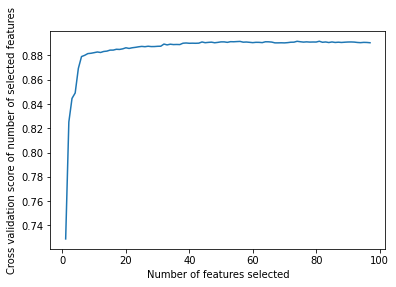

In [706]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [707]:
best_features = ['ID', 'N_1', 'N_2', 'N_4', 'N_5', 'N_11', 'N_12', 'N_14', 'N_18',
       'N_19', 'N_20', 'N_21', 'N_22', 'N_23', 'N_24', 'N_25', 'N_26', 'N_27',
       'N_28', 'N_29', 'N_30', 'N_31', 'N_32', 'N_33', 'N_34', 'N_35', 'N_36',
       'N_37', 'N_38', 'N_39', 'N_41', 'N_42', 'N_43', 'N_44', 'N_45', 'N_46',
       'N_47', 'N_48', 'N_49', 'N_50', 'N_51', 'N_53', 'N_54', 'N_55', 'N_56',
       'N_57', 'N_58', 'N_59', 'N_60', 'N_61', 'N_62', 'N_63', 'N_64', 'N_66',
       'N_67', 'N_68', 'N_69', 'N_70', 'N_71', 'N_72', 'N_73', 'N_74', 'N_75',
       'N_76', 'N_77', 'N_78', 'N_79', 'N_80', 'N_81', 'N_82', 'Day of week',
       'C_1_0', 'C_4_1', 'C_4_2', 'C_4_5', 'C_4_6', 'C_4_8', 'C_4_9', 'C_3_1',
       'C_3_2', 'C_3_3']

In [718]:
model = LGBMClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
roc_auc_score(y_test, pred )

0.8886536168387581

In [719]:
model = LGBMClassifier()
model.fit(X_train[best_features], y_train)
pred = model.predict(X_test[best_features])
roc_auc_score(y_test, pred )

0.8905502620669832

In [720]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(learning_rate=0.05)
model.fit(X_train, y_train)
pred = model.predict(X_test)
roc_auc_score(y_test, pred )

0:	learn: 0.6555642	total: 37.9ms	remaining: 37.9s
1:	learn: 0.6214848	total: 67.8ms	remaining: 33.8s
2:	learn: 0.5913247	total: 105ms	remaining: 34.8s
3:	learn: 0.5658557	total: 134ms	remaining: 33.4s
4:	learn: 0.5429053	total: 162ms	remaining: 32.3s
5:	learn: 0.5210897	total: 190ms	remaining: 31.5s
6:	learn: 0.4993308	total: 219ms	remaining: 31s
7:	learn: 0.4840790	total: 258ms	remaining: 32s
8:	learn: 0.4697330	total: 301ms	remaining: 33.2s
9:	learn: 0.4543998	total: 331ms	remaining: 32.8s
10:	learn: 0.4403757	total: 360ms	remaining: 32.4s
11:	learn: 0.4302506	total: 387ms	remaining: 31.9s
12:	learn: 0.4099640	total: 415ms	remaining: 31.5s
13:	learn: 0.4022929	total: 442ms	remaining: 31.1s
14:	learn: 0.3952513	total: 477ms	remaining: 31.3s
15:	learn: 0.3901269	total: 519ms	remaining: 31.9s
16:	learn: 0.3841279	total: 548ms	remaining: 31.7s
17:	learn: 0.3783555	total: 581ms	remaining: 31.7s
18:	learn: 0.3735697	total: 609ms	remaining: 31.4s
19:	learn: 0.3677047	total: 638ms	remaining

162:	learn: 0.2655675	total: 5.77s	remaining: 29.7s
163:	learn: 0.2654471	total: 5.8s	remaining: 29.6s
164:	learn: 0.2653609	total: 5.83s	remaining: 29.5s
165:	learn: 0.2652575	total: 5.85s	remaining: 29.4s
166:	learn: 0.2651545	total: 5.88s	remaining: 29.4s
167:	learn: 0.2650300	total: 5.91s	remaining: 29.3s
168:	learn: 0.2648993	total: 5.94s	remaining: 29.2s
169:	learn: 0.2647719	total: 5.96s	remaining: 29.1s
170:	learn: 0.2646750	total: 6s	remaining: 29.1s
171:	learn: 0.2644899	total: 6.03s	remaining: 29s
172:	learn: 0.2644065	total: 6.06s	remaining: 29s
173:	learn: 0.2643105	total: 6.09s	remaining: 28.9s
174:	learn: 0.2641981	total: 6.12s	remaining: 28.9s
175:	learn: 0.2640983	total: 6.15s	remaining: 28.8s
176:	learn: 0.2637860	total: 6.17s	remaining: 28.7s
177:	learn: 0.2636559	total: 6.21s	remaining: 28.7s
178:	learn: 0.2635847	total: 6.25s	remaining: 28.7s
179:	learn: 0.2634609	total: 6.28s	remaining: 28.6s
180:	learn: 0.2633550	total: 6.3s	remaining: 28.5s
181:	learn: 0.2632563

322:	learn: 0.2448636	total: 10.5s	remaining: 22s
323:	learn: 0.2448040	total: 10.5s	remaining: 21.9s
324:	learn: 0.2447109	total: 10.5s	remaining: 21.9s
325:	learn: 0.2446360	total: 10.6s	remaining: 21.8s
326:	learn: 0.2445908	total: 10.6s	remaining: 21.8s
327:	learn: 0.2444779	total: 10.6s	remaining: 21.7s
328:	learn: 0.2444230	total: 10.6s	remaining: 21.7s
329:	learn: 0.2443822	total: 10.7s	remaining: 21.7s
330:	learn: 0.2442714	total: 10.7s	remaining: 21.6s
331:	learn: 0.2442072	total: 10.7s	remaining: 21.6s
332:	learn: 0.2441248	total: 10.8s	remaining: 21.5s
333:	learn: 0.2440499	total: 10.8s	remaining: 21.5s
334:	learn: 0.2439519	total: 10.8s	remaining: 21.5s
335:	learn: 0.2439022	total: 10.8s	remaining: 21.4s
336:	learn: 0.2438223	total: 10.9s	remaining: 21.4s
337:	learn: 0.2437537	total: 10.9s	remaining: 21.3s
338:	learn: 0.2437013	total: 10.9s	remaining: 21.3s
339:	learn: 0.2435460	total: 11s	remaining: 21.3s
340:	learn: 0.2434850	total: 11s	remaining: 21.2s
341:	learn: 0.2433

485:	learn: 0.2321788	total: 15.2s	remaining: 16.1s
486:	learn: 0.2321097	total: 15.2s	remaining: 16s
487:	learn: 0.2320042	total: 15.2s	remaining: 16s
488:	learn: 0.2319475	total: 15.3s	remaining: 16s
489:	learn: 0.2318838	total: 15.3s	remaining: 15.9s
490:	learn: 0.2318123	total: 15.3s	remaining: 15.9s
491:	learn: 0.2317406	total: 15.3s	remaining: 15.8s
492:	learn: 0.2316742	total: 15.4s	remaining: 15.8s
493:	learn: 0.2316111	total: 15.4s	remaining: 15.8s
494:	learn: 0.2315433	total: 15.4s	remaining: 15.7s
495:	learn: 0.2314819	total: 15.5s	remaining: 15.7s
496:	learn: 0.2314333	total: 15.5s	remaining: 15.7s
497:	learn: 0.2313703	total: 15.5s	remaining: 15.6s
498:	learn: 0.2313044	total: 15.5s	remaining: 15.6s
499:	learn: 0.2312252	total: 15.6s	remaining: 15.6s
500:	learn: 0.2311588	total: 15.6s	remaining: 15.5s
501:	learn: 0.2310887	total: 15.6s	remaining: 15.5s
502:	learn: 0.2310287	total: 15.7s	remaining: 15.5s
503:	learn: 0.2309671	total: 15.7s	remaining: 15.4s
504:	learn: 0.2308

651:	learn: 0.2215560	total: 20s	remaining: 10.7s
652:	learn: 0.2214894	total: 20s	remaining: 10.6s
653:	learn: 0.2214305	total: 20.1s	remaining: 10.6s
654:	learn: 0.2213893	total: 20.1s	remaining: 10.6s
655:	learn: 0.2213395	total: 20.1s	remaining: 10.5s
656:	learn: 0.2212305	total: 20.1s	remaining: 10.5s
657:	learn: 0.2211941	total: 20.2s	remaining: 10.5s
658:	learn: 0.2211076	total: 20.2s	remaining: 10.4s
659:	learn: 0.2210275	total: 20.2s	remaining: 10.4s
660:	learn: 0.2209537	total: 20.3s	remaining: 10.4s
661:	learn: 0.2208849	total: 20.3s	remaining: 10.4s
662:	learn: 0.2208395	total: 20.3s	remaining: 10.3s
663:	learn: 0.2207587	total: 20.3s	remaining: 10.3s
664:	learn: 0.2206885	total: 20.4s	remaining: 10.3s
665:	learn: 0.2206220	total: 20.4s	remaining: 10.2s
666:	learn: 0.2205654	total: 20.4s	remaining: 10.2s
667:	learn: 0.2205205	total: 20.5s	remaining: 10.2s
668:	learn: 0.2204589	total: 20.5s	remaining: 10.1s
669:	learn: 0.2204031	total: 20.5s	remaining: 10.1s
670:	learn: 0.22

814:	learn: 0.2119448	total: 24.8s	remaining: 5.62s
815:	learn: 0.2118762	total: 24.8s	remaining: 5.59s
816:	learn: 0.2118179	total: 24.8s	remaining: 5.56s
817:	learn: 0.2117652	total: 24.9s	remaining: 5.54s
818:	learn: 0.2117127	total: 24.9s	remaining: 5.51s
819:	learn: 0.2116583	total: 25s	remaining: 5.49s
820:	learn: 0.2115988	total: 25.1s	remaining: 5.47s
821:	learn: 0.2115342	total: 25.2s	remaining: 5.45s
822:	learn: 0.2114933	total: 25.2s	remaining: 5.42s
823:	learn: 0.2114450	total: 25.3s	remaining: 5.39s
824:	learn: 0.2113860	total: 25.3s	remaining: 5.37s
825:	learn: 0.2113411	total: 25.3s	remaining: 5.34s
826:	learn: 0.2112857	total: 25.4s	remaining: 5.3s
827:	learn: 0.2112516	total: 25.4s	remaining: 5.27s
828:	learn: 0.2111946	total: 25.4s	remaining: 5.24s
829:	learn: 0.2111418	total: 25.4s	remaining: 5.21s
830:	learn: 0.2110694	total: 25.5s	remaining: 5.18s
831:	learn: 0.2110251	total: 25.5s	remaining: 5.15s
832:	learn: 0.2109658	total: 25.5s	remaining: 5.12s
833:	learn: 0.2

975:	learn: 0.2037482	total: 30.6s	remaining: 753ms
976:	learn: 0.2036939	total: 30.6s	remaining: 721ms
977:	learn: 0.2036556	total: 30.7s	remaining: 690ms
978:	learn: 0.2035999	total: 30.7s	remaining: 658ms
979:	learn: 0.2035657	total: 30.7s	remaining: 627ms
980:	learn: 0.2035161	total: 30.7s	remaining: 596ms
981:	learn: 0.2034704	total: 30.8s	remaining: 564ms
982:	learn: 0.2034253	total: 30.8s	remaining: 533ms
983:	learn: 0.2033649	total: 30.8s	remaining: 501ms
984:	learn: 0.2033353	total: 30.9s	remaining: 470ms
985:	learn: 0.2032841	total: 30.9s	remaining: 439ms
986:	learn: 0.2032168	total: 30.9s	remaining: 407ms
987:	learn: 0.2031643	total: 30.9s	remaining: 376ms
988:	learn: 0.2031241	total: 31s	remaining: 345ms
989:	learn: 0.2030888	total: 31s	remaining: 313ms
990:	learn: 0.2030546	total: 31s	remaining: 282ms
991:	learn: 0.2030012	total: 31.1s	remaining: 250ms
992:	learn: 0.2029548	total: 31.1s	remaining: 219ms
993:	learn: 0.2029175	total: 31.1s	remaining: 188ms
994:	learn: 0.2028

0.8917503076536135

In [721]:
model = CatBoostClassifier(learning_rate=0.05)
model.fit(X_train[best_features], y_train)
pred = model.predict(X_test[best_features])
roc_auc_score(y_test, pred )

0:	learn: 0.6556109	total: 37.9ms	remaining: 37.9s
1:	learn: 0.6248887	total: 65.4ms	remaining: 32.6s
2:	learn: 0.5961657	total: 90.6ms	remaining: 30.1s
3:	learn: 0.5696394	total: 117ms	remaining: 29.1s
4:	learn: 0.5465516	total: 142ms	remaining: 28.3s
5:	learn: 0.5207977	total: 182ms	remaining: 30.2s
6:	learn: 0.5006920	total: 211ms	remaining: 29.9s
7:	learn: 0.4843638	total: 241ms	remaining: 29.8s
8:	learn: 0.4676072	total: 292ms	remaining: 32.2s
9:	learn: 0.4547568	total: 319ms	remaining: 31.6s
10:	learn: 0.4430698	total: 345ms	remaining: 31s
11:	learn: 0.4333724	total: 373ms	remaining: 30.7s
12:	learn: 0.4208861	total: 398ms	remaining: 30.3s
13:	learn: 0.4124021	total: 426ms	remaining: 30s
14:	learn: 0.4045902	total: 465ms	remaining: 30.5s
15:	learn: 0.3979196	total: 507ms	remaining: 31.2s
16:	learn: 0.3921133	total: 533ms	remaining: 30.8s
17:	learn: 0.3862076	total: 562ms	remaining: 30.7s
18:	learn: 0.3813272	total: 588ms	remaining: 30.4s
19:	learn: 0.3770582	total: 614ms	remainin

162:	learn: 0.2628251	total: 6.36s	remaining: 32.7s
163:	learn: 0.2627593	total: 6.41s	remaining: 32.7s
164:	learn: 0.2626240	total: 6.45s	remaining: 32.6s
165:	learn: 0.2625366	total: 6.48s	remaining: 32.6s
166:	learn: 0.2624788	total: 6.51s	remaining: 32.5s
167:	learn: 0.2623764	total: 6.55s	remaining: 32.4s
168:	learn: 0.2622901	total: 6.59s	remaining: 32.4s
169:	learn: 0.2621598	total: 6.64s	remaining: 32.4s
170:	learn: 0.2620942	total: 6.67s	remaining: 32.3s
171:	learn: 0.2619781	total: 6.69s	remaining: 32.2s
172:	learn: 0.2618275	total: 6.72s	remaining: 32.1s
173:	learn: 0.2617244	total: 6.75s	remaining: 32s
174:	learn: 0.2616029	total: 6.79s	remaining: 32s
175:	learn: 0.2615471	total: 6.85s	remaining: 32.1s
176:	learn: 0.2614564	total: 6.9s	remaining: 32.1s
177:	learn: 0.2613455	total: 6.95s	remaining: 32.1s
178:	learn: 0.2611928	total: 6.97s	remaining: 32s
179:	learn: 0.2610573	total: 7.01s	remaining: 31.9s
180:	learn: 0.2609381	total: 7.04s	remaining: 31.8s
181:	learn: 0.26085

327:	learn: 0.2438861	total: 11.8s	remaining: 24.2s
328:	learn: 0.2438327	total: 11.8s	remaining: 24.1s
329:	learn: 0.2437888	total: 11.8s	remaining: 24.1s
330:	learn: 0.2436619	total: 11.9s	remaining: 24s
331:	learn: 0.2434785	total: 11.9s	remaining: 23.9s
332:	learn: 0.2433748	total: 11.9s	remaining: 23.9s
333:	learn: 0.2432783	total: 12s	remaining: 23.8s
334:	learn: 0.2432223	total: 12s	remaining: 23.8s
335:	learn: 0.2431397	total: 12s	remaining: 23.7s
336:	learn: 0.2430867	total: 12s	remaining: 23.7s
337:	learn: 0.2430036	total: 12.1s	remaining: 23.7s
338:	learn: 0.2429171	total: 12.1s	remaining: 23.6s
339:	learn: 0.2428564	total: 12.1s	remaining: 23.5s
340:	learn: 0.2427587	total: 12.2s	remaining: 23.5s
341:	learn: 0.2426547	total: 12.2s	remaining: 23.4s
342:	learn: 0.2424860	total: 12.2s	remaining: 23.4s
343:	learn: 0.2424070	total: 12.2s	remaining: 23.4s
344:	learn: 0.2423687	total: 12.3s	remaining: 23.3s
345:	learn: 0.2422823	total: 12.3s	remaining: 23.2s
346:	learn: 0.2421052	

486:	learn: 0.2316777	total: 16.2s	remaining: 17s
487:	learn: 0.2316267	total: 16.2s	remaining: 17s
488:	learn: 0.2315606	total: 16.2s	remaining: 17s
489:	learn: 0.2314823	total: 16.3s	remaining: 16.9s
490:	learn: 0.2314163	total: 16.3s	remaining: 16.9s
491:	learn: 0.2313846	total: 16.3s	remaining: 16.8s
492:	learn: 0.2313314	total: 16.3s	remaining: 16.8s
493:	learn: 0.2312520	total: 16.4s	remaining: 16.8s
494:	learn: 0.2311884	total: 16.4s	remaining: 16.7s
495:	learn: 0.2311135	total: 16.4s	remaining: 16.7s
496:	learn: 0.2310570	total: 16.5s	remaining: 16.7s
497:	learn: 0.2309870	total: 16.5s	remaining: 16.6s
498:	learn: 0.2309358	total: 16.5s	remaining: 16.6s
499:	learn: 0.2308655	total: 16.5s	remaining: 16.5s
500:	learn: 0.2307959	total: 16.6s	remaining: 16.5s
501:	learn: 0.2307331	total: 16.6s	remaining: 16.5s
502:	learn: 0.2306861	total: 16.6s	remaining: 16.4s
503:	learn: 0.2306149	total: 16.7s	remaining: 16.4s
504:	learn: 0.2305392	total: 16.7s	remaining: 16.3s
505:	learn: 0.2304

645:	learn: 0.2217973	total: 20.6s	remaining: 11.3s
646:	learn: 0.2217412	total: 20.6s	remaining: 11.3s
647:	learn: 0.2216998	total: 20.6s	remaining: 11.2s
648:	learn: 0.2216580	total: 20.7s	remaining: 11.2s
649:	learn: 0.2216099	total: 20.7s	remaining: 11.1s
650:	learn: 0.2215500	total: 20.7s	remaining: 11.1s
651:	learn: 0.2214930	total: 20.7s	remaining: 11.1s
652:	learn: 0.2214333	total: 20.8s	remaining: 11s
653:	learn: 0.2213812	total: 20.8s	remaining: 11s
654:	learn: 0.2213256	total: 20.8s	remaining: 11s
655:	learn: 0.2212775	total: 20.9s	remaining: 10.9s
656:	learn: 0.2212113	total: 20.9s	remaining: 10.9s
657:	learn: 0.2211848	total: 20.9s	remaining: 10.9s
658:	learn: 0.2211246	total: 20.9s	remaining: 10.8s
659:	learn: 0.2210781	total: 21s	remaining: 10.8s
660:	learn: 0.2210182	total: 21s	remaining: 10.8s
661:	learn: 0.2209654	total: 21s	remaining: 10.7s
662:	learn: 0.2209025	total: 21.1s	remaining: 10.7s
663:	learn: 0.2208339	total: 21.1s	remaining: 10.7s
664:	learn: 0.2207575	to

805:	learn: 0.2127310	total: 25.1s	remaining: 6.04s
806:	learn: 0.2126802	total: 25.1s	remaining: 6s
807:	learn: 0.2126456	total: 25.1s	remaining: 5.97s
808:	learn: 0.2125880	total: 25.2s	remaining: 5.94s
809:	learn: 0.2125450	total: 25.2s	remaining: 5.91s
810:	learn: 0.2124808	total: 25.2s	remaining: 5.87s
811:	learn: 0.2124261	total: 25.2s	remaining: 5.84s
812:	learn: 0.2123714	total: 25.3s	remaining: 5.81s
813:	learn: 0.2123155	total: 25.3s	remaining: 5.78s
814:	learn: 0.2122628	total: 25.3s	remaining: 5.75s
815:	learn: 0.2121984	total: 25.4s	remaining: 5.72s
816:	learn: 0.2121572	total: 25.4s	remaining: 5.68s
817:	learn: 0.2121235	total: 25.4s	remaining: 5.65s
818:	learn: 0.2120653	total: 25.4s	remaining: 5.62s
819:	learn: 0.2120227	total: 25.5s	remaining: 5.59s
820:	learn: 0.2119805	total: 25.5s	remaining: 5.56s
821:	learn: 0.2119365	total: 25.5s	remaining: 5.53s
822:	learn: 0.2118724	total: 25.6s	remaining: 5.5s
823:	learn: 0.2118429	total: 25.6s	remaining: 5.46s
824:	learn: 0.21

969:	learn: 0.2046826	total: 29.7s	remaining: 918ms
970:	learn: 0.2046149	total: 29.7s	remaining: 887ms
971:	learn: 0.2045808	total: 29.8s	remaining: 859ms
972:	learn: 0.2045614	total: 29.8s	remaining: 828ms
973:	learn: 0.2045113	total: 29.9s	remaining: 798ms
974:	learn: 0.2044191	total: 29.9s	remaining: 768ms
975:	learn: 0.2043716	total: 30s	remaining: 737ms
976:	learn: 0.2043243	total: 30s	remaining: 706ms
977:	learn: 0.2042774	total: 30s	remaining: 675ms
978:	learn: 0.2042377	total: 30s	remaining: 644ms
979:	learn: 0.2041893	total: 30.1s	remaining: 614ms
980:	learn: 0.2041285	total: 30.1s	remaining: 583ms
981:	learn: 0.2040820	total: 30.1s	remaining: 552ms
982:	learn: 0.2040242	total: 30.2s	remaining: 522ms
983:	learn: 0.2039659	total: 30.2s	remaining: 491ms
984:	learn: 0.2039269	total: 30.2s	remaining: 460ms
985:	learn: 0.2038746	total: 30.2s	remaining: 429ms
986:	learn: 0.2038054	total: 30.3s	remaining: 399ms
987:	learn: 0.2037536	total: 30.3s	remaining: 368ms
988:	learn: 0.203696

0.8922241952724643

Отбираем признаки с помощью Catboost:

In [725]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
rf = CatBoostClassifier(iterations=20) 
rfecv = RFECV(estimator=rf, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Learning rate set to 0.5
0:	learn: 0.4452569	total: 152ms	remaining: 2.88s
1:	learn: 0.3831710	total: 249ms	remaining: 2.24s
2:	learn: 0.3453106	total: 321ms	remaining: 1.82s
3:	learn: 0.3284270	total: 374ms	remaining: 1.49s
4:	learn: 0.3129796	total: 489ms	remaining: 1.47s
5:	learn: 0.3033891	total: 549ms	remaining: 1.28s
6:	learn: 0.2973187	total: 580ms	remaining: 1.08s
7:	learn: 0.2929045	total: 603ms	remaining: 905ms
8:	learn: 0.2856172	total: 627ms	remaining: 766ms
9:	learn: 0.2839634	total: 650ms	remaining: 650ms
10:	learn: 0.2810795	total: 672ms	remaining: 550ms
11:	learn: 0.2792717	total: 699ms	remaining: 466ms
12:	learn: 0.2769346	total: 740ms	remaining: 399ms
13:	learn: 0.2756077	total: 769ms	remaining: 330ms
14:	learn: 0.2741822	total: 792ms	remaining: 264ms
15:	learn: 0.2724796	total: 812ms	remaining: 203ms
16:	learn: 0.2710946	total: 834ms	remaining: 147ms
17:	learn: 0.2696451	total: 855ms	remaining: 95ms
18:	learn: 0.2686588	total: 877ms	remaining: 46.1ms
19:	learn: 0.267

18:	learn: 0.2670142	total: 452ms	remaining: 23.8ms
19:	learn: 0.2652162	total: 479ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4455531	total: 25.5ms	remaining: 485ms
1:	learn: 0.3851536	total: 47.7ms	remaining: 429ms
2:	learn: 0.3573723	total: 70.7ms	remaining: 401ms
3:	learn: 0.3341432	total: 91.5ms	remaining: 366ms
4:	learn: 0.3194968	total: 111ms	remaining: 334ms
5:	learn: 0.3094813	total: 132ms	remaining: 307ms
6:	learn: 0.3051362	total: 153ms	remaining: 284ms
7:	learn: 0.3015329	total: 173ms	remaining: 259ms
8:	learn: 0.2884915	total: 195ms	remaining: 239ms
9:	learn: 0.2854623	total: 230ms	remaining: 230ms
10:	learn: 0.2829082	total: 250ms	remaining: 205ms
11:	learn: 0.2799982	total: 272ms	remaining: 181ms
12:	learn: 0.2781669	total: 293ms	remaining: 158ms
13:	learn: 0.2737537	total: 316ms	remaining: 135ms
14:	learn: 0.2686684	total: 337ms	remaining: 112ms
15:	learn: 0.2669173	total: 358ms	remaining: 89.4ms
16:	learn: 0.2657914	total: 378ms	remaining: 66.6ms
17:	learn: 

19:	learn: 0.2635270	total: 424ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4494808	total: 24.6ms	remaining: 468ms
1:	learn: 0.3812541	total: 54.5ms	remaining: 490ms
2:	learn: 0.3489351	total: 76.7ms	remaining: 435ms
3:	learn: 0.3240396	total: 97.6ms	remaining: 391ms
4:	learn: 0.2986086	total: 118ms	remaining: 354ms
5:	learn: 0.2930348	total: 137ms	remaining: 319ms
6:	learn: 0.2878476	total: 157ms	remaining: 291ms
7:	learn: 0.2852579	total: 175ms	remaining: 263ms
8:	learn: 0.2823721	total: 194ms	remaining: 237ms
9:	learn: 0.2799160	total: 214ms	remaining: 214ms
10:	learn: 0.2774934	total: 234ms	remaining: 191ms
11:	learn: 0.2760672	total: 253ms	remaining: 169ms
12:	learn: 0.2742791	total: 282ms	remaining: 152ms
13:	learn: 0.2728442	total: 303ms	remaining: 130ms
14:	learn: 0.2712212	total: 322ms	remaining: 107ms
15:	learn: 0.2698545	total: 342ms	remaining: 85.5ms
16:	learn: 0.2687629	total: 363ms	remaining: 64ms
17:	learn: 0.2664027	total: 384ms	remaining: 42.6ms
18:	learn: 0.

Learning rate set to 0.5
0:	learn: 0.4538052	total: 24.2ms	remaining: 460ms
1:	learn: 0.3849189	total: 42.5ms	remaining: 383ms
2:	learn: 0.3489152	total: 61.9ms	remaining: 351ms
3:	learn: 0.3302720	total: 80.5ms	remaining: 322ms
4:	learn: 0.3209804	total: 98.3ms	remaining: 295ms
5:	learn: 0.2997704	total: 117ms	remaining: 273ms
6:	learn: 0.2943697	total: 136ms	remaining: 252ms
7:	learn: 0.2859345	total: 154ms	remaining: 231ms
8:	learn: 0.2836205	total: 174ms	remaining: 212ms
9:	learn: 0.2810103	total: 193ms	remaining: 193ms
10:	learn: 0.2796027	total: 223ms	remaining: 183ms
11:	learn: 0.2774018	total: 244ms	remaining: 163ms
12:	learn: 0.2744264	total: 264ms	remaining: 142ms
13:	learn: 0.2723854	total: 286ms	remaining: 123ms
14:	learn: 0.2709319	total: 308ms	remaining: 103ms
15:	learn: 0.2694081	total: 326ms	remaining: 81.6ms
16:	learn: 0.2684388	total: 344ms	remaining: 60.8ms
17:	learn: 0.2673141	total: 362ms	remaining: 40.3ms
18:	learn: 0.2644541	total: 382ms	remaining: 20.1ms
19:	lea

Learning rate set to 0.5
0:	learn: 0.4629360	total: 21.6ms	remaining: 411ms
1:	learn: 0.3852278	total: 39.7ms	remaining: 357ms
2:	learn: 0.3562294	total: 57ms	remaining: 323ms
3:	learn: 0.3153238	total: 74.9ms	remaining: 299ms
4:	learn: 0.3066413	total: 92.4ms	remaining: 277ms
5:	learn: 0.3005566	total: 110ms	remaining: 256ms
6:	learn: 0.2921385	total: 128ms	remaining: 238ms
7:	learn: 0.2895341	total: 146ms	remaining: 219ms
8:	learn: 0.2850772	total: 164ms	remaining: 200ms
9:	learn: 0.2812456	total: 182ms	remaining: 182ms
10:	learn: 0.2794711	total: 204ms	remaining: 167ms
11:	learn: 0.2766681	total: 229ms	remaining: 153ms
12:	learn: 0.2751026	total: 247ms	remaining: 133ms
13:	learn: 0.2731639	total: 265ms	remaining: 114ms
14:	learn: 0.2714804	total: 283ms	remaining: 94.3ms
15:	learn: 0.2700935	total: 301ms	remaining: 75.2ms
16:	learn: 0.2685702	total: 319ms	remaining: 56.2ms
17:	learn: 0.2652504	total: 340ms	remaining: 37.8ms
18:	learn: 0.2640315	total: 357ms	remaining: 18.8ms
19:	lear

Learning rate set to 0.5
0:	learn: 0.4508310	total: 21ms	remaining: 400ms
1:	learn: 0.3787540	total: 39ms	remaining: 351ms
2:	learn: 0.3464312	total: 55.8ms	remaining: 316ms
3:	learn: 0.3328149	total: 72.1ms	remaining: 289ms
4:	learn: 0.3232006	total: 91.3ms	remaining: 274ms
5:	learn: 0.3169838	total: 108ms	remaining: 253ms
6:	learn: 0.3024148	total: 128ms	remaining: 237ms
7:	learn: 0.2916973	total: 146ms	remaining: 219ms
8:	learn: 0.2881086	total: 163ms	remaining: 199ms
9:	learn: 0.2854245	total: 187ms	remaining: 187ms
10:	learn: 0.2831744	total: 213ms	remaining: 174ms
11:	learn: 0.2738463	total: 240ms	remaining: 160ms
12:	learn: 0.2723161	total: 257ms	remaining: 139ms
13:	learn: 0.2703574	total: 279ms	remaining: 120ms
14:	learn: 0.2689189	total: 296ms	remaining: 98.7ms
15:	learn: 0.2675401	total: 314ms	remaining: 78.5ms
16:	learn: 0.2666887	total: 337ms	remaining: 59.4ms
17:	learn: 0.2654497	total: 354ms	remaining: 39.3ms
18:	learn: 0.2641474	total: 374ms	remaining: 19.7ms
19:	learn:

Learning rate set to 0.5
0:	learn: 0.4493200	total: 20.9ms	remaining: 397ms
1:	learn: 0.3746195	total: 39.4ms	remaining: 355ms
2:	learn: 0.3521624	total: 56.3ms	remaining: 319ms
3:	learn: 0.3385882	total: 73ms	remaining: 292ms
4:	learn: 0.3076050	total: 89.4ms	remaining: 268ms
5:	learn: 0.3007718	total: 106ms	remaining: 246ms
6:	learn: 0.2933784	total: 122ms	remaining: 226ms
7:	learn: 0.2893919	total: 139ms	remaining: 208ms
8:	learn: 0.2868563	total: 156ms	remaining: 190ms
9:	learn: 0.2842261	total: 171ms	remaining: 171ms
10:	learn: 0.2799573	total: 188ms	remaining: 154ms
11:	learn: 0.2781583	total: 212ms	remaining: 141ms
12:	learn: 0.2762851	total: 233ms	remaining: 125ms
13:	learn: 0.2745309	total: 251ms	remaining: 107ms
14:	learn: 0.2733781	total: 267ms	remaining: 89ms
15:	learn: 0.2719831	total: 284ms	remaining: 71.1ms
16:	learn: 0.2705329	total: 301ms	remaining: 53.2ms
17:	learn: 0.2663059	total: 318ms	remaining: 35.3ms
18:	learn: 0.2648756	total: 335ms	remaining: 17.6ms
19:	learn:

Learning rate set to 0.5
0:	learn: 0.4510312	total: 21ms	remaining: 398ms
1:	learn: 0.3842017	total: 41.8ms	remaining: 376ms
2:	learn: 0.3522678	total: 57.7ms	remaining: 327ms
3:	learn: 0.3345338	total: 76.3ms	remaining: 305ms
4:	learn: 0.3221048	total: 92.4ms	remaining: 277ms
5:	learn: 0.3146717	total: 108ms	remaining: 251ms
6:	learn: 0.2961764	total: 124ms	remaining: 229ms
7:	learn: 0.2909807	total: 141ms	remaining: 211ms
8:	learn: 0.2876353	total: 156ms	remaining: 191ms
9:	learn: 0.2816914	total: 172ms	remaining: 172ms
10:	learn: 0.2789480	total: 189ms	remaining: 155ms
11:	learn: 0.2765782	total: 214ms	remaining: 143ms
12:	learn: 0.2751791	total: 232ms	remaining: 125ms
13:	learn: 0.2739012	total: 249ms	remaining: 107ms
14:	learn: 0.2722883	total: 264ms	remaining: 88.1ms
15:	learn: 0.2709074	total: 281ms	remaining: 70.2ms
16:	learn: 0.2694367	total: 297ms	remaining: 52.4ms
17:	learn: 0.2651537	total: 313ms	remaining: 34.8ms
18:	learn: 0.2644501	total: 328ms	remaining: 17.3ms
19:	lear

2:	learn: 0.3453154	total: 49ms	remaining: 278ms
3:	learn: 0.3302801	total: 74.4ms	remaining: 297ms
4:	learn: 0.3044133	total: 89.6ms	remaining: 269ms
5:	learn: 0.2969341	total: 104ms	remaining: 242ms
6:	learn: 0.2933735	total: 119ms	remaining: 221ms
7:	learn: 0.2852732	total: 134ms	remaining: 201ms
8:	learn: 0.2803081	total: 148ms	remaining: 181ms
9:	learn: 0.2781404	total: 163ms	remaining: 163ms
10:	learn: 0.2762885	total: 178ms	remaining: 146ms
11:	learn: 0.2746925	total: 193ms	remaining: 129ms
12:	learn: 0.2731752	total: 207ms	remaining: 112ms
13:	learn: 0.2720072	total: 221ms	remaining: 94.9ms
14:	learn: 0.2698908	total: 236ms	remaining: 78.6ms
15:	learn: 0.2687320	total: 254ms	remaining: 63.4ms
16:	learn: 0.2672268	total: 276ms	remaining: 48.7ms
17:	learn: 0.2665090	total: 291ms	remaining: 32.4ms
18:	learn: 0.2653243	total: 309ms	remaining: 16.3ms
19:	learn: 0.2643445	total: 324ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4521143	total: 16.6ms	remaining: 315ms
1:	learn:

7:	learn: 0.2865697	total: 119ms	remaining: 178ms
8:	learn: 0.2835672	total: 138ms	remaining: 168ms
9:	learn: 0.2812830	total: 153ms	remaining: 153ms
10:	learn: 0.2794040	total: 168ms	remaining: 137ms
11:	learn: 0.2779898	total: 181ms	remaining: 121ms
12:	learn: 0.2765131	total: 194ms	remaining: 105ms
13:	learn: 0.2753231	total: 208ms	remaining: 89ms
14:	learn: 0.2740709	total: 221ms	remaining: 73.8ms
15:	learn: 0.2708121	total: 235ms	remaining: 58.8ms
16:	learn: 0.2695183	total: 249ms	remaining: 44ms
17:	learn: 0.2649702	total: 263ms	remaining: 29.2ms
18:	learn: 0.2641983	total: 276ms	remaining: 14.5ms
19:	learn: 0.2631311	total: 290ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4487749	total: 17.3ms	remaining: 329ms
1:	learn: 0.3799247	total: 47.1ms	remaining: 424ms
2:	learn: 0.3480629	total: 61ms	remaining: 346ms
3:	learn: 0.3290702	total: 75ms	remaining: 300ms
4:	learn: 0.3045256	total: 88.7ms	remaining: 266ms
5:	learn: 0.2998531	total: 102ms	remaining: 238ms
6:	learn: 0.29

5:	learn: 0.3454100	total: 35.7ms	remaining: 83.3ms
6:	learn: 0.3270530	total: 47.2ms	remaining: 87.7ms
7:	learn: 0.3188621	total: 57ms	remaining: 85.5ms
8:	learn: 0.3146487	total: 64.2ms	remaining: 78.5ms
9:	learn: 0.3098524	total: 70.1ms	remaining: 70.1ms
10:	learn: 0.3042294	total: 75.5ms	remaining: 61.8ms
11:	learn: 0.3029323	total: 81.2ms	remaining: 54.1ms
12:	learn: 0.2971568	total: 86.7ms	remaining: 46.7ms
13:	learn: 0.2948466	total: 94.6ms	remaining: 40.5ms
14:	learn: 0.2932402	total: 103ms	remaining: 34.2ms
15:	learn: 0.2906628	total: 111ms	remaining: 27.8ms
16:	learn: 0.2893319	total: 119ms	remaining: 21ms
17:	learn: 0.2883691	total: 127ms	remaining: 14.1ms
18:	learn: 0.2871751	total: 136ms	remaining: 7.14ms
19:	learn: 0.2858268	total: 144ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4995109	total: 6.98ms	remaining: 133ms
1:	learn: 0.4221871	total: 12.3ms	remaining: 111ms
2:	learn: 0.3725733	total: 17.6ms	remaining: 99.9ms
3:	learn: 0.3496518	total: 22.8ms	remaining:

12:	learn: 0.3181427	total: 67.4ms	remaining: 36.3ms
13:	learn: 0.3172071	total: 76.6ms	remaining: 32.8ms
14:	learn: 0.3153335	total: 84.6ms	remaining: 28.2ms
15:	learn: 0.3127302	total: 89.5ms	remaining: 22.4ms
16:	learn: 0.3118339	total: 94.1ms	remaining: 16.6ms
17:	learn: 0.3109230	total: 98.4ms	remaining: 10.9ms
18:	learn: 0.3103809	total: 104ms	remaining: 5.46ms
19:	learn: 0.3097268	total: 109ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5117387	total: 5.64ms	remaining: 107ms
1:	learn: 0.4404415	total: 10.3ms	remaining: 92.5ms
2:	learn: 0.4100932	total: 14.5ms	remaining: 82.4ms
3:	learn: 0.3894178	total: 19.1ms	remaining: 76.6ms
4:	learn: 0.3793621	total: 23.7ms	remaining: 71ms
5:	learn: 0.3666672	total: 28.1ms	remaining: 65.6ms
6:	learn: 0.3554454	total: 33ms	remaining: 61.3ms
7:	learn: 0.3528545	total: 37.3ms	remaining: 56ms
8:	learn: 0.3440815	total: 42.1ms	remaining: 51.5ms
9:	learn: 0.3408305	total: 46.5ms	remaining: 46.5ms
10:	learn: 0.3361956	total: 51.1ms	remainin

8:	learn: 0.2818979	total: 214ms	remaining: 261ms
9:	learn: 0.2796259	total: 238ms	remaining: 238ms
10:	learn: 0.2773164	total: 259ms	remaining: 212ms
11:	learn: 0.2750189	total: 281ms	remaining: 187ms
12:	learn: 0.2734472	total: 301ms	remaining: 162ms
13:	learn: 0.2723959	total: 322ms	remaining: 138ms
14:	learn: 0.2706045	total: 344ms	remaining: 115ms
15:	learn: 0.2693877	total: 365ms	remaining: 91.3ms
16:	learn: 0.2678265	total: 387ms	remaining: 68.3ms
17:	learn: 0.2659345	total: 407ms	remaining: 45.2ms
18:	learn: 0.2649401	total: 439ms	remaining: 23.1ms
19:	learn: 0.2638950	total: 461ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4510169	total: 32.3ms	remaining: 613ms
1:	learn: 0.3828980	total: 54ms	remaining: 486ms
2:	learn: 0.3461795	total: 76.5ms	remaining: 434ms
3:	learn: 0.3333824	total: 97ms	remaining: 388ms
4:	learn: 0.3216367	total: 117ms	remaining: 352ms
5:	learn: 0.3062962	total: 138ms	remaining: 323ms
6:	learn: 0.3015486	total: 161ms	remaining: 298ms
7:	learn: 0.2

9:	learn: 0.2794705	total: 216ms	remaining: 216ms
10:	learn: 0.2748865	total: 240ms	remaining: 197ms
11:	learn: 0.2724642	total: 261ms	remaining: 174ms
12:	learn: 0.2705770	total: 282ms	remaining: 152ms
13:	learn: 0.2691504	total: 304ms	remaining: 130ms
14:	learn: 0.2679846	total: 325ms	remaining: 108ms
15:	learn: 0.2668214	total: 344ms	remaining: 85.9ms
16:	learn: 0.2660217	total: 364ms	remaining: 64.3ms
17:	learn: 0.2650635	total: 384ms	remaining: 42.7ms
18:	learn: 0.2633476	total: 404ms	remaining: 21.3ms
19:	learn: 0.2622688	total: 432ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4480331	total: 25.3ms	remaining: 480ms
1:	learn: 0.3712856	total: 56.6ms	remaining: 510ms
2:	learn: 0.3450050	total: 77.3ms	remaining: 438ms
3:	learn: 0.3300029	total: 96.1ms	remaining: 384ms
4:	learn: 0.3144333	total: 117ms	remaining: 350ms
5:	learn: 0.3093402	total: 137ms	remaining: 319ms
6:	learn: 0.3048654	total: 158ms	remaining: 293ms
7:	learn: 0.3019417	total: 178ms	remaining: 267ms
8:	learn:

9:	learn: 0.2805447	total: 203ms	remaining: 203ms
10:	learn: 0.2791639	total: 231ms	remaining: 189ms
11:	learn: 0.2771409	total: 251ms	remaining: 167ms
12:	learn: 0.2736376	total: 271ms	remaining: 146ms
13:	learn: 0.2718606	total: 290ms	remaining: 124ms
14:	learn: 0.2707848	total: 311ms	remaining: 104ms
15:	learn: 0.2694435	total: 330ms	remaining: 82.4ms
16:	learn: 0.2664407	total: 350ms	remaining: 61.8ms
17:	learn: 0.2650041	total: 369ms	remaining: 41ms
18:	learn: 0.2635688	total: 388ms	remaining: 20.4ms
19:	learn: 0.2623980	total: 414ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4546682	total: 24.3ms	remaining: 462ms
1:	learn: 0.3766310	total: 51.7ms	remaining: 465ms
2:	learn: 0.3538554	total: 74.8ms	remaining: 424ms
3:	learn: 0.3338706	total: 94.7ms	remaining: 379ms
4:	learn: 0.3228675	total: 114ms	remaining: 342ms
5:	learn: 0.2977482	total: 134ms	remaining: 312ms
6:	learn: 0.2933295	total: 153ms	remaining: 284ms
7:	learn: 0.2904160	total: 174ms	remaining: 260ms
8:	learn: 0

9:	learn: 0.2900243	total: 195ms	remaining: 195ms
10:	learn: 0.2868004	total: 227ms	remaining: 186ms
11:	learn: 0.2844901	total: 248ms	remaining: 166ms
12:	learn: 0.2813008	total: 270ms	remaining: 145ms
13:	learn: 0.2698485	total: 289ms	remaining: 124ms
14:	learn: 0.2680784	total: 326ms	remaining: 109ms
15:	learn: 0.2662277	total: 346ms	remaining: 86.5ms
16:	learn: 0.2648961	total: 364ms	remaining: 64.3ms
17:	learn: 0.2638222	total: 383ms	remaining: 42.6ms
18:	learn: 0.2626537	total: 409ms	remaining: 21.5ms
19:	learn: 0.2618774	total: 433ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4548979	total: 24.1ms	remaining: 459ms
1:	learn: 0.3834408	total: 53.8ms	remaining: 485ms
2:	learn: 0.3521659	total: 74.1ms	remaining: 420ms
3:	learn: 0.3311608	total: 93.5ms	remaining: 374ms
4:	learn: 0.3196968	total: 112ms	remaining: 335ms
5:	learn: 0.3112753	total: 131ms	remaining: 307ms
6:	learn: 0.2924056	total: 150ms	remaining: 279ms
7:	learn: 0.2882451	total: 169ms	remaining: 253ms
8:	learn:

10:	learn: 0.2760383	total: 266ms	remaining: 217ms
11:	learn: 0.2743089	total: 288ms	remaining: 192ms
12:	learn: 0.2730541	total: 313ms	remaining: 169ms
13:	learn: 0.2714416	total: 347ms	remaining: 149ms
14:	learn: 0.2691178	total: 383ms	remaining: 128ms
15:	learn: 0.2680867	total: 416ms	remaining: 104ms
16:	learn: 0.2667797	total: 456ms	remaining: 80.4ms
17:	learn: 0.2653871	total: 516ms	remaining: 57.3ms
18:	learn: 0.2644758	total: 543ms	remaining: 28.6ms
19:	learn: 0.2632339	total: 570ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4453833	total: 28.5ms	remaining: 541ms
1:	learn: 0.3768723	total: 52ms	remaining: 468ms
2:	learn: 0.3457254	total: 74.9ms	remaining: 424ms
3:	learn: 0.3269404	total: 98.7ms	remaining: 395ms
4:	learn: 0.3004128	total: 128ms	remaining: 385ms
5:	learn: 0.2935080	total: 156ms	remaining: 364ms
6:	learn: 0.2881810	total: 181ms	remaining: 336ms
7:	learn: 0.2860486	total: 228ms	remaining: 342ms
8:	learn: 0.2839755	total: 259ms	remaining: 317ms
9:	learn: 0.

8:	learn: 0.2849951	total: 1.16s	remaining: 1.42s
9:	learn: 0.2827354	total: 1.19s	remaining: 1.19s
10:	learn: 0.2759139	total: 1.23s	remaining: 1s
11:	learn: 0.2745394	total: 1.26s	remaining: 843ms
12:	learn: 0.2729178	total: 1.51s	remaining: 814ms
13:	learn: 0.2691442	total: 1.62s	remaining: 693ms
14:	learn: 0.2682159	total: 1.76s	remaining: 587ms
15:	learn: 0.2670504	total: 1.78s	remaining: 446ms
16:	learn: 0.2654502	total: 1.81s	remaining: 319ms
17:	learn: 0.2643482	total: 1.83s	remaining: 203ms
18:	learn: 0.2631248	total: 1.85s	remaining: 97.3ms
19:	learn: 0.2619528	total: 1.87s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4479187	total: 28.3ms	remaining: 538ms
1:	learn: 0.3787235	total: 69.1ms	remaining: 622ms
2:	learn: 0.3484495	total: 89.4ms	remaining: 506ms
3:	learn: 0.3253806	total: 106ms	remaining: 424ms
4:	learn: 0.3085484	total: 127ms	remaining: 382ms
5:	learn: 0.3038346	total: 155ms	remaining: 362ms
6:	learn: 0.2962998	total: 183ms	remaining: 340ms
7:	learn: 0.2919

6:	learn: 0.2901529	total: 246ms	remaining: 456ms
7:	learn: 0.2873271	total: 268ms	remaining: 402ms
8:	learn: 0.2848915	total: 286ms	remaining: 350ms
9:	learn: 0.2780895	total: 315ms	remaining: 315ms
10:	learn: 0.2751676	total: 342ms	remaining: 280ms
11:	learn: 0.2728584	total: 362ms	remaining: 242ms
12:	learn: 0.2694017	total: 380ms	remaining: 205ms
13:	learn: 0.2675688	total: 398ms	remaining: 171ms
14:	learn: 0.2659429	total: 440ms	remaining: 147ms
15:	learn: 0.2647370	total: 463ms	remaining: 116ms
16:	learn: 0.2638121	total: 481ms	remaining: 84.9ms
17:	learn: 0.2628526	total: 502ms	remaining: 55.8ms
18:	learn: 0.2614881	total: 521ms	remaining: 27.4ms
19:	learn: 0.2604006	total: 538ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4430576	total: 21.8ms	remaining: 415ms
1:	learn: 0.3781312	total: 38.9ms	remaining: 350ms
2:	learn: 0.3519396	total: 55.5ms	remaining: 314ms
3:	learn: 0.3276183	total: 72.1ms	remaining: 288ms
4:	learn: 0.3179960	total: 87.9ms	remaining: 264ms
5:	learn:

11:	learn: 0.2759991	total: 200ms	remaining: 133ms
12:	learn: 0.2742149	total: 233ms	remaining: 125ms
13:	learn: 0.2729941	total: 252ms	remaining: 108ms
14:	learn: 0.2719642	total: 301ms	remaining: 100ms
15:	learn: 0.2702448	total: 350ms	remaining: 87.6ms
16:	learn: 0.2692600	total: 383ms	remaining: 67.6ms
17:	learn: 0.2675897	total: 403ms	remaining: 44.8ms
18:	learn: 0.2664664	total: 422ms	remaining: 22.2ms
19:	learn: 0.2629022	total: 438ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4524811	total: 18.5ms	remaining: 352ms
1:	learn: 0.3846903	total: 35.3ms	remaining: 318ms
2:	learn: 0.3577031	total: 51.1ms	remaining: 290ms
3:	learn: 0.3217086	total: 66.5ms	remaining: 266ms
4:	learn: 0.3094289	total: 83.7ms	remaining: 251ms
5:	learn: 0.3024837	total: 100ms	remaining: 234ms
6:	learn: 0.2959649	total: 115ms	remaining: 214ms
7:	learn: 0.2890839	total: 132ms	remaining: 198ms
8:	learn: 0.2858730	total: 147ms	remaining: 180ms
9:	learn: 0.2820479	total: 162ms	remaining: 162ms
10:	learn

Learning rate set to 0.5
0:	learn: 0.4431413	total: 17.4ms	remaining: 331ms
1:	learn: 0.3837702	total: 32ms	remaining: 288ms
2:	learn: 0.3545117	total: 46.4ms	remaining: 263ms
3:	learn: 0.3168573	total: 61ms	remaining: 244ms
4:	learn: 0.3096554	total: 75.2ms	remaining: 226ms
5:	learn: 0.3034862	total: 89.9ms	remaining: 210ms
6:	learn: 0.2968771	total: 104ms	remaining: 194ms
7:	learn: 0.2926533	total: 119ms	remaining: 179ms
8:	learn: 0.2902785	total: 133ms	remaining: 162ms
9:	learn: 0.2879758	total: 148ms	remaining: 148ms
10:	learn: 0.2845910	total: 162ms	remaining: 133ms
11:	learn: 0.2829032	total: 177ms	remaining: 118ms
12:	learn: 0.2762511	total: 192ms	remaining: 103ms
13:	learn: 0.2749576	total: 207ms	remaining: 88.5ms
14:	learn: 0.2733455	total: 222ms	remaining: 73.9ms
15:	learn: 0.2721687	total: 236ms	remaining: 59ms
16:	learn: 0.2693020	total: 251ms	remaining: 44.2ms
17:	learn: 0.2681036	total: 265ms	remaining: 29.5ms
18:	learn: 0.2668605	total: 280ms	remaining: 14.7ms
19:	learn:

2:	learn: 0.3470754	total: 45.7ms	remaining: 259ms
3:	learn: 0.3365368	total: 59.8ms	remaining: 239ms
4:	learn: 0.3279292	total: 73.7ms	remaining: 221ms
5:	learn: 0.3016268	total: 88.3ms	remaining: 206ms
6:	learn: 0.2960756	total: 102ms	remaining: 190ms
7:	learn: 0.2915750	total: 116ms	remaining: 174ms
8:	learn: 0.2891119	total: 130ms	remaining: 158ms
9:	learn: 0.2824834	total: 143ms	remaining: 143ms
10:	learn: 0.2807834	total: 157ms	remaining: 129ms
11:	learn: 0.2787177	total: 171ms	remaining: 114ms
12:	learn: 0.2767660	total: 185ms	remaining: 99.6ms
13:	learn: 0.2754224	total: 199ms	remaining: 85.4ms
14:	learn: 0.2736810	total: 213ms	remaining: 71.1ms
15:	learn: 0.2722992	total: 227ms	remaining: 56.8ms
16:	learn: 0.2714793	total: 242ms	remaining: 42.7ms
17:	learn: 0.2707946	total: 257ms	remaining: 28.5ms
18:	learn: 0.2661789	total: 271ms	remaining: 14.3ms
19:	learn: 0.2650726	total: 285ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4383583	total: 15.9ms	remaining: 303ms
1:	le

18:	learn: 0.2844916	total: 103ms	remaining: 5.44ms
19:	learn: 0.2833156	total: 109ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4994914	total: 7.02ms	remaining: 133ms
1:	learn: 0.4265294	total: 12.3ms	remaining: 111ms
2:	learn: 0.3838239	total: 17.8ms	remaining: 101ms
3:	learn: 0.3579535	total: 23.3ms	remaining: 93.2ms
4:	learn: 0.3433935	total: 28.7ms	remaining: 86.2ms
5:	learn: 0.3354962	total: 33.6ms	remaining: 78.4ms
6:	learn: 0.3211107	total: 38.9ms	remaining: 72.3ms
7:	learn: 0.3128749	total: 44.3ms	remaining: 66.5ms
8:	learn: 0.3099514	total: 49.4ms	remaining: 60.4ms
9:	learn: 0.3033025	total: 55ms	remaining: 55ms
10:	learn: 0.3007270	total: 60.2ms	remaining: 49.2ms
11:	learn: 0.2964517	total: 65.6ms	remaining: 43.7ms
12:	learn: 0.2946393	total: 70.5ms	remaining: 38ms
13:	learn: 0.2923339	total: 76ms	remaining: 32.5ms
14:	learn: 0.2914900	total: 81.1ms	remaining: 27ms
15:	learn: 0.2897758	total: 86.3ms	remaining: 21.6ms
16:	learn: 0.2882187	total: 91.4ms	remaining: 16.

3:	learn: 0.3785854	total: 22.3ms	remaining: 89.3ms
4:	learn: 0.3658570	total: 26.8ms	remaining: 80.5ms
5:	learn: 0.3566820	total: 31.3ms	remaining: 73.1ms
6:	learn: 0.3516425	total: 36.1ms	remaining: 67ms
7:	learn: 0.3434405	total: 40.7ms	remaining: 61ms
8:	learn: 0.3398928	total: 45ms	remaining: 55ms
9:	learn: 0.3383113	total: 49.1ms	remaining: 49.1ms
10:	learn: 0.3350927	total: 53.7ms	remaining: 43.9ms
11:	learn: 0.3338408	total: 58.2ms	remaining: 38.8ms
12:	learn: 0.3321572	total: 63.8ms	remaining: 34.4ms
13:	learn: 0.3291822	total: 70.7ms	remaining: 30.3ms
14:	learn: 0.3272855	total: 75.1ms	remaining: 25ms
15:	learn: 0.3257207	total: 79.4ms	remaining: 19.9ms
16:	learn: 0.3246463	total: 84.5ms	remaining: 14.9ms
17:	learn: 0.3230442	total: 89ms	remaining: 9.89ms
18:	learn: 0.3223590	total: 93.4ms	remaining: 4.92ms
19:	learn: 0.3208899	total: 98ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5118167	total: 5.71ms	remaining: 108ms
1:	learn: 0.4434407	total: 11.1ms	remaining: 99

Learning rate set to 0.5
0:	learn: 0.4465509	total: 27ms	remaining: 513ms
1:	learn: 0.3843333	total: 49.1ms	remaining: 442ms
2:	learn: 0.3538653	total: 71.2ms	remaining: 404ms
3:	learn: 0.3385747	total: 92.5ms	remaining: 370ms
4:	learn: 0.3279546	total: 114ms	remaining: 343ms
5:	learn: 0.3119251	total: 137ms	remaining: 320ms
6:	learn: 0.3072609	total: 158ms	remaining: 294ms
7:	learn: 0.2899458	total: 182ms	remaining: 273ms
8:	learn: 0.2866495	total: 204ms	remaining: 249ms
9:	learn: 0.2839527	total: 225ms	remaining: 225ms
10:	learn: 0.2820924	total: 246ms	remaining: 201ms
11:	learn: 0.2794629	total: 267ms	remaining: 178ms
12:	learn: 0.2764131	total: 288ms	remaining: 155ms
13:	learn: 0.2741399	total: 308ms	remaining: 132ms
14:	learn: 0.2726860	total: 330ms	remaining: 110ms
15:	learn: 0.2715740	total: 352ms	remaining: 88.1ms
16:	learn: 0.2687650	total: 372ms	remaining: 65.6ms
17:	learn: 0.2668030	total: 394ms	remaining: 43.7ms
18:	learn: 0.2658700	total: 416ms	remaining: 21.9ms
19:	learn:

Learning rate set to 0.5
0:	learn: 0.4535753	total: 25.1ms	remaining: 477ms
1:	learn: 0.3819753	total: 45.5ms	remaining: 410ms
2:	learn: 0.3496198	total: 68ms	remaining: 385ms
3:	learn: 0.3367748	total: 88.1ms	remaining: 353ms
4:	learn: 0.3250113	total: 108ms	remaining: 325ms
5:	learn: 0.3174626	total: 128ms	remaining: 298ms
6:	learn: 0.3047760	total: 148ms	remaining: 276ms
7:	learn: 0.2902890	total: 168ms	remaining: 253ms
8:	learn: 0.2869037	total: 191ms	remaining: 233ms
9:	learn: 0.2839804	total: 212ms	remaining: 212ms
10:	learn: 0.2798757	total: 237ms	remaining: 194ms
11:	learn: 0.2779154	total: 259ms	remaining: 173ms
12:	learn: 0.2757387	total: 278ms	remaining: 150ms
13:	learn: 0.2740661	total: 301ms	remaining: 129ms
14:	learn: 0.2720217	total: 321ms	remaining: 107ms
15:	learn: 0.2704407	total: 343ms	remaining: 85.8ms
16:	learn: 0.2689495	total: 364ms	remaining: 64.2ms
17:	learn: 0.2679526	total: 384ms	remaining: 42.7ms
18:	learn: 0.2666539	total: 404ms	remaining: 21.3ms
19:	learn:

Learning rate set to 0.5
0:	learn: 0.4493490	total: 24.8ms	remaining: 471ms
1:	learn: 0.3858485	total: 45.2ms	remaining: 407ms
2:	learn: 0.3579955	total: 65.2ms	remaining: 369ms
3:	learn: 0.3353507	total: 84.6ms	remaining: 339ms
4:	learn: 0.3237905	total: 105ms	remaining: 314ms
5:	learn: 0.3010867	total: 124ms	remaining: 288ms
6:	learn: 0.2937155	total: 141ms	remaining: 262ms
7:	learn: 0.2901245	total: 161ms	remaining: 241ms
8:	learn: 0.2873055	total: 181ms	remaining: 221ms
9:	learn: 0.2850000	total: 202ms	remaining: 202ms
10:	learn: 0.2797468	total: 223ms	remaining: 182ms
11:	learn: 0.2771409	total: 242ms	remaining: 161ms
12:	learn: 0.2756091	total: 261ms	remaining: 141ms
13:	learn: 0.2742804	total: 281ms	remaining: 120ms
14:	learn: 0.2732657	total: 300ms	remaining: 99.9ms
15:	learn: 0.2715851	total: 319ms	remaining: 79.7ms
16:	learn: 0.2699905	total: 339ms	remaining: 59.8ms
17:	learn: 0.2684868	total: 360ms	remaining: 40ms
18:	learn: 0.2670484	total: 379ms	remaining: 19.9ms
19:	learn

Learning rate set to 0.5
0:	learn: 0.4544092	total: 23.9ms	remaining: 453ms
1:	learn: 0.3730142	total: 43.6ms	remaining: 392ms
2:	learn: 0.3428403	total: 61.5ms	remaining: 348ms
3:	learn: 0.3294805	total: 80.8ms	remaining: 323ms
4:	learn: 0.3196858	total: 98.8ms	remaining: 296ms
5:	learn: 0.2981086	total: 118ms	remaining: 275ms
6:	learn: 0.2914021	total: 136ms	remaining: 253ms
7:	learn: 0.2888730	total: 155ms	remaining: 232ms
8:	learn: 0.2862563	total: 173ms	remaining: 212ms
9:	learn: 0.2832762	total: 192ms	remaining: 192ms
10:	learn: 0.2818381	total: 212ms	remaining: 174ms
11:	learn: 0.2791195	total: 231ms	remaining: 154ms
12:	learn: 0.2771273	total: 249ms	remaining: 134ms
13:	learn: 0.2726145	total: 269ms	remaining: 115ms
14:	learn: 0.2717363	total: 287ms	remaining: 95.8ms
15:	learn: 0.2700461	total: 305ms	remaining: 76.3ms
16:	learn: 0.2685448	total: 325ms	remaining: 57.3ms
17:	learn: 0.2677888	total: 344ms	remaining: 38.2ms
18:	learn: 0.2668816	total: 363ms	remaining: 19.1ms
19:	le

Learning rate set to 0.5
0:	learn: 0.4522983	total: 22.6ms	remaining: 429ms
1:	learn: 0.3862883	total: 41.2ms	remaining: 371ms
2:	learn: 0.3486590	total: 60.1ms	remaining: 340ms
3:	learn: 0.3363814	total: 78ms	remaining: 312ms
4:	learn: 0.3228613	total: 96.5ms	remaining: 289ms
5:	learn: 0.3139349	total: 114ms	remaining: 265ms
6:	learn: 0.3035527	total: 132ms	remaining: 245ms
7:	learn: 0.2895913	total: 150ms	remaining: 225ms
8:	learn: 0.2853085	total: 168ms	remaining: 206ms
9:	learn: 0.2834605	total: 186ms	remaining: 186ms
10:	learn: 0.2806141	total: 207ms	remaining: 169ms
11:	learn: 0.2790282	total: 224ms	remaining: 149ms
12:	learn: 0.2772747	total: 259ms	remaining: 140ms
13:	learn: 0.2754051	total: 291ms	remaining: 125ms
14:	learn: 0.2738031	total: 317ms	remaining: 106ms
15:	learn: 0.2723269	total: 344ms	remaining: 85.9ms
16:	learn: 0.2704258	total: 371ms	remaining: 65.4ms
17:	learn: 0.2689030	total: 396ms	remaining: 44ms
18:	learn: 0.2670920	total: 421ms	remaining: 22.2ms
19:	learn: 

Learning rate set to 0.5
0:	learn: 0.4504177	total: 21.2ms	remaining: 403ms
1:	learn: 0.3803038	total: 40ms	remaining: 360ms
2:	learn: 0.3509413	total: 56.9ms	remaining: 322ms
3:	learn: 0.3343265	total: 70.2ms	remaining: 281ms
4:	learn: 0.3239215	total: 86.8ms	remaining: 260ms
5:	learn: 0.3023261	total: 105ms	remaining: 245ms
6:	learn: 0.2969762	total: 121ms	remaining: 226ms
7:	learn: 0.2923040	total: 138ms	remaining: 207ms
8:	learn: 0.2846309	total: 155ms	remaining: 190ms
9:	learn: 0.2820998	total: 175ms	remaining: 175ms
10:	learn: 0.2801416	total: 196ms	remaining: 160ms
11:	learn: 0.2768375	total: 213ms	remaining: 142ms
12:	learn: 0.2746647	total: 234ms	remaining: 126ms
13:	learn: 0.2729898	total: 252ms	remaining: 108ms
14:	learn: 0.2715811	total: 270ms	remaining: 90ms
15:	learn: 0.2704798	total: 288ms	remaining: 72ms
16:	learn: 0.2691154	total: 306ms	remaining: 54ms
17:	learn: 0.2678108	total: 324ms	remaining: 36ms
18:	learn: 0.2667452	total: 342ms	remaining: 18ms
19:	learn: 0.26607

Learning rate set to 0.5
0:	learn: 0.4560933	total: 19.7ms	remaining: 374ms
1:	learn: 0.3823622	total: 36.8ms	remaining: 331ms
2:	learn: 0.3498953	total: 52.4ms	remaining: 297ms
3:	learn: 0.3331314	total: 68.2ms	remaining: 273ms
4:	learn: 0.3236917	total: 85.1ms	remaining: 255ms
5:	learn: 0.3142985	total: 101ms	remaining: 236ms
6:	learn: 0.3035417	total: 118ms	remaining: 219ms
7:	learn: 0.2997559	total: 134ms	remaining: 200ms
8:	learn: 0.2965915	total: 150ms	remaining: 184ms
9:	learn: 0.2921482	total: 167ms	remaining: 167ms
10:	learn: 0.2811832	total: 184ms	remaining: 150ms
11:	learn: 0.2780708	total: 202ms	remaining: 134ms
12:	learn: 0.2764203	total: 219ms	remaining: 118ms
13:	learn: 0.2750341	total: 236ms	remaining: 101ms
14:	learn: 0.2734665	total: 252ms	remaining: 84.1ms
15:	learn: 0.2719788	total: 269ms	remaining: 67.2ms
16:	learn: 0.2703926	total: 285ms	remaining: 50.3ms
17:	learn: 0.2694914	total: 301ms	remaining: 33.5ms
18:	learn: 0.2663360	total: 318ms	remaining: 16.7ms
19:	le

Learning rate set to 0.5
0:	learn: 0.4504928	total: 25.8ms	remaining: 491ms
1:	learn: 0.3718933	total: 48.8ms	remaining: 439ms
2:	learn: 0.3412970	total: 73.3ms	remaining: 415ms
3:	learn: 0.3286745	total: 110ms	remaining: 440ms
4:	learn: 0.3178971	total: 140ms	remaining: 420ms
5:	learn: 0.3111570	total: 163ms	remaining: 381ms
6:	learn: 0.3005021	total: 187ms	remaining: 347ms
7:	learn: 0.2971370	total: 209ms	remaining: 313ms
8:	learn: 0.2884913	total: 230ms	remaining: 282ms
9:	learn: 0.2856496	total: 254ms	remaining: 254ms
10:	learn: 0.2818752	total: 273ms	remaining: 224ms
11:	learn: 0.2797581	total: 290ms	remaining: 193ms
12:	learn: 0.2783601	total: 307ms	remaining: 165ms
13:	learn: 0.2755507	total: 322ms	remaining: 138ms
14:	learn: 0.2739293	total: 338ms	remaining: 113ms
15:	learn: 0.2725631	total: 354ms	remaining: 88.5ms
16:	learn: 0.2716961	total: 370ms	remaining: 65.3ms
17:	learn: 0.2699725	total: 387ms	remaining: 43ms
18:	learn: 0.2687451	total: 403ms	remaining: 21.2ms
19:	learn: 

0:	learn: 0.4501009	total: 18.9ms	remaining: 360ms
1:	learn: 0.3835596	total: 33.9ms	remaining: 305ms
2:	learn: 0.3553845	total: 48.3ms	remaining: 274ms
3:	learn: 0.3187138	total: 63.5ms	remaining: 254ms
4:	learn: 0.3067454	total: 78.1ms	remaining: 234ms
5:	learn: 0.3010536	total: 93.4ms	remaining: 218ms
6:	learn: 0.2968631	total: 108ms	remaining: 201ms
7:	learn: 0.2916110	total: 123ms	remaining: 184ms
8:	learn: 0.2892091	total: 137ms	remaining: 168ms
9:	learn: 0.2874091	total: 151ms	remaining: 151ms
10:	learn: 0.2851568	total: 166ms	remaining: 136ms
11:	learn: 0.2823156	total: 180ms	remaining: 120ms
12:	learn: 0.2805571	total: 195ms	remaining: 105ms
13:	learn: 0.2791202	total: 210ms	remaining: 89.9ms
14:	learn: 0.2779659	total: 227ms	remaining: 75.5ms
15:	learn: 0.2764933	total: 241ms	remaining: 60.3ms
16:	learn: 0.2748310	total: 255ms	remaining: 45.1ms
17:	learn: 0.2709215	total: 270ms	remaining: 30ms
18:	learn: 0.2696360	total: 284ms	remaining: 15ms
19:	learn: 0.2684708	total: 299ms

1:	learn: 0.3767087	total: 32.3ms	remaining: 291ms
2:	learn: 0.3504060	total: 46.7ms	remaining: 265ms
3:	learn: 0.3362137	total: 60.5ms	remaining: 242ms
4:	learn: 0.3152984	total: 74.6ms	remaining: 224ms
5:	learn: 0.3097303	total: 88.9ms	remaining: 207ms
6:	learn: 0.2944021	total: 104ms	remaining: 192ms
7:	learn: 0.2898696	total: 117ms	remaining: 176ms
8:	learn: 0.2873021	total: 133ms	remaining: 163ms
9:	learn: 0.2841979	total: 147ms	remaining: 147ms
10:	learn: 0.2825630	total: 161ms	remaining: 132ms
11:	learn: 0.2805771	total: 174ms	remaining: 116ms
12:	learn: 0.2791907	total: 188ms	remaining: 101ms
13:	learn: 0.2762382	total: 202ms	remaining: 86.7ms
14:	learn: 0.2750579	total: 216ms	remaining: 72.1ms
15:	learn: 0.2730770	total: 230ms	remaining: 57.5ms
16:	learn: 0.2722594	total: 245ms	remaining: 43.2ms
17:	learn: 0.2712566	total: 259ms	remaining: 28.8ms
18:	learn: 0.2702566	total: 273ms	remaining: 14.4ms
19:	learn: 0.2692743	total: 288ms	remaining: 0us
Learning rate set to 0.5
0:	lea

Learning rate set to 0.5
0:	learn: 0.5002695	total: 7.08ms	remaining: 135ms
1:	learn: 0.4234017	total: 12.8ms	remaining: 115ms
2:	learn: 0.3758347	total: 18.1ms	remaining: 102ms
3:	learn: 0.3534531	total: 23.2ms	remaining: 93ms
4:	learn: 0.3375085	total: 28.4ms	remaining: 85.2ms
5:	learn: 0.3275545	total: 33.8ms	remaining: 78.8ms
6:	learn: 0.3195870	total: 39.1ms	remaining: 72.6ms
7:	learn: 0.3133462	total: 44.4ms	remaining: 66.6ms
8:	learn: 0.3106204	total: 49.7ms	remaining: 60.7ms
9:	learn: 0.3084229	total: 55.1ms	remaining: 55.1ms
10:	learn: 0.3011900	total: 60.4ms	remaining: 49.4ms
11:	learn: 0.2994497	total: 65.7ms	remaining: 43.8ms
12:	learn: 0.2984653	total: 70.6ms	remaining: 38ms
13:	learn: 0.2966198	total: 75.9ms	remaining: 32.5ms
14:	learn: 0.2944274	total: 81.1ms	remaining: 27ms
15:	learn: 0.2935294	total: 86.2ms	remaining: 21.6ms
16:	learn: 0.2902396	total: 91.6ms	remaining: 16.2ms
17:	learn: 0.2892182	total: 96.8ms	remaining: 10.8ms
18:	learn: 0.2885075	total: 102ms	remain

3:	learn: 0.3779462	total: 19.8ms	remaining: 79.1ms
4:	learn: 0.3605144	total: 24.3ms	remaining: 72.9ms
5:	learn: 0.3539367	total: 29ms	remaining: 67.7ms
6:	learn: 0.3497420	total: 33.3ms	remaining: 61.9ms
7:	learn: 0.3433389	total: 37.7ms	remaining: 56.5ms
8:	learn: 0.3319723	total: 42.1ms	remaining: 51.4ms
9:	learn: 0.3279845	total: 46.6ms	remaining: 46.6ms
10:	learn: 0.3231310	total: 51.1ms	remaining: 41.8ms
11:	learn: 0.3218910	total: 55.8ms	remaining: 37.2ms
12:	learn: 0.3205985	total: 60.4ms	remaining: 32.5ms
13:	learn: 0.3197274	total: 64.6ms	remaining: 27.7ms
14:	learn: 0.3183984	total: 69ms	remaining: 23ms
15:	learn: 0.3156043	total: 73.5ms	remaining: 18.4ms
16:	learn: 0.3148489	total: 77.9ms	remaining: 13.8ms
17:	learn: 0.3140905	total: 82.2ms	remaining: 9.14ms
18:	learn: 0.3126433	total: 86.4ms	remaining: 4.55ms
19:	learn: 0.3110051	total: 90.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5053236	total: 6.02ms	remaining: 114ms
1:	learn: 0.4344354	total: 10.6ms	remai

Learning rate set to 0.5
0:	learn: 0.4534987	total: 28.6ms	remaining: 544ms
1:	learn: 0.3837859	total: 51ms	remaining: 459ms
2:	learn: 0.3471290	total: 74.7ms	remaining: 423ms
3:	learn: 0.3307131	total: 95.4ms	remaining: 382ms
4:	learn: 0.3148850	total: 118ms	remaining: 353ms
5:	learn: 0.3059265	total: 139ms	remaining: 325ms
6:	learn: 0.3025148	total: 168ms	remaining: 313ms
7:	learn: 0.2999727	total: 190ms	remaining: 286ms
8:	learn: 0.2960414	total: 216ms	remaining: 264ms
9:	learn: 0.2901412	total: 239ms	remaining: 239ms
10:	learn: 0.2815553	total: 266ms	remaining: 218ms
11:	learn: 0.2798627	total: 286ms	remaining: 191ms
12:	learn: 0.2779693	total: 312ms	remaining: 168ms
13:	learn: 0.2759612	total: 335ms	remaining: 143ms
14:	learn: 0.2741465	total: 357ms	remaining: 119ms
15:	learn: 0.2728426	total: 380ms	remaining: 94.9ms
16:	learn: 0.2701532	total: 402ms	remaining: 70.9ms
17:	learn: 0.2687983	total: 425ms	remaining: 47.2ms
18:	learn: 0.2676248	total: 448ms	remaining: 23.6ms
19:	learn:

Learning rate set to 0.5
0:	learn: 0.4468044	total: 26.8ms	remaining: 509ms
1:	learn: 0.3758876	total: 48.7ms	remaining: 439ms
2:	learn: 0.3484484	total: 69.2ms	remaining: 392ms
3:	learn: 0.3358063	total: 89.4ms	remaining: 357ms
4:	learn: 0.3236327	total: 113ms	remaining: 338ms
5:	learn: 0.2972672	total: 134ms	remaining: 312ms
6:	learn: 0.2886610	total: 155ms	remaining: 288ms
7:	learn: 0.2849030	total: 175ms	remaining: 263ms
8:	learn: 0.2823029	total: 196ms	remaining: 240ms
9:	learn: 0.2800162	total: 216ms	remaining: 216ms
10:	learn: 0.2760859	total: 237ms	remaining: 194ms
11:	learn: 0.2740667	total: 259ms	remaining: 172ms
12:	learn: 0.2720686	total: 280ms	remaining: 151ms
13:	learn: 0.2699143	total: 302ms	remaining: 130ms
14:	learn: 0.2680276	total: 323ms	remaining: 108ms
15:	learn: 0.2667746	total: 344ms	remaining: 86.1ms
16:	learn: 0.2655577	total: 367ms	remaining: 64.8ms
17:	learn: 0.2643696	total: 390ms	remaining: 43.3ms
18:	learn: 0.2627908	total: 410ms	remaining: 21.6ms
19:	lear

Learning rate set to 0.5
0:	learn: 0.4425857	total: 26.8ms	remaining: 510ms
1:	learn: 0.3732626	total: 47.1ms	remaining: 424ms
2:	learn: 0.3435162	total: 82.9ms	remaining: 470ms
3:	learn: 0.3319946	total: 101ms	remaining: 405ms
4:	learn: 0.3193914	total: 119ms	remaining: 358ms
5:	learn: 0.2999154	total: 140ms	remaining: 327ms
6:	learn: 0.2959930	total: 159ms	remaining: 296ms
7:	learn: 0.2910504	total: 178ms	remaining: 267ms
8:	learn: 0.2865860	total: 199ms	remaining: 243ms
9:	learn: 0.2833244	total: 219ms	remaining: 219ms
10:	learn: 0.2818704	total: 239ms	remaining: 195ms
11:	learn: 0.2799185	total: 258ms	remaining: 172ms
12:	learn: 0.2780002	total: 277ms	remaining: 149ms
13:	learn: 0.2768379	total: 296ms	remaining: 127ms
14:	learn: 0.2748039	total: 316ms	remaining: 105ms
15:	learn: 0.2725984	total: 335ms	remaining: 83.8ms
16:	learn: 0.2699791	total: 355ms	remaining: 62.6ms
17:	learn: 0.2688503	total: 375ms	remaining: 41.6ms
18:	learn: 0.2677409	total: 394ms	remaining: 20.8ms
19:	learn

Learning rate set to 0.5
0:	learn: 0.4588798	total: 26.1ms	remaining: 497ms
1:	learn: 0.3866646	total: 45.2ms	remaining: 406ms
2:	learn: 0.3536954	total: 64.4ms	remaining: 365ms
3:	learn: 0.3300388	total: 83.1ms	remaining: 332ms
4:	learn: 0.3191556	total: 102ms	remaining: 307ms
5:	learn: 0.3039918	total: 122ms	remaining: 284ms
6:	learn: 0.2967997	total: 140ms	remaining: 261ms
7:	learn: 0.2937642	total: 158ms	remaining: 237ms
8:	learn: 0.2913148	total: 178ms	remaining: 217ms
9:	learn: 0.2886921	total: 197ms	remaining: 197ms
10:	learn: 0.2859685	total: 216ms	remaining: 177ms
11:	learn: 0.2834215	total: 235ms	remaining: 156ms
12:	learn: 0.2724794	total: 254ms	remaining: 137ms
13:	learn: 0.2714865	total: 272ms	remaining: 117ms
14:	learn: 0.2698211	total: 291ms	remaining: 97ms
15:	learn: 0.2682134	total: 310ms	remaining: 77.5ms
16:	learn: 0.2672803	total: 330ms	remaining: 58.3ms
17:	learn: 0.2661019	total: 350ms	remaining: 38.9ms
18:	learn: 0.2652804	total: 369ms	remaining: 19.4ms
19:	learn

Learning rate set to 0.5
0:	learn: 0.4542373	total: 22.5ms	remaining: 427ms
1:	learn: 0.3884429	total: 41.2ms	remaining: 371ms
2:	learn: 0.3583447	total: 60.4ms	remaining: 342ms
3:	learn: 0.3401714	total: 78.7ms	remaining: 315ms
4:	learn: 0.3213335	total: 98.4ms	remaining: 295ms
5:	learn: 0.2998579	total: 117ms	remaining: 273ms
6:	learn: 0.2948451	total: 135ms	remaining: 250ms
7:	learn: 0.2916351	total: 153ms	remaining: 229ms
8:	learn: 0.2876411	total: 171ms	remaining: 209ms
9:	learn: 0.2848068	total: 188ms	remaining: 188ms
10:	learn: 0.2819538	total: 210ms	remaining: 171ms
11:	learn: 0.2806393	total: 228ms	remaining: 152ms
12:	learn: 0.2790267	total: 257ms	remaining: 139ms
13:	learn: 0.2750609	total: 281ms	remaining: 121ms
14:	learn: 0.2735587	total: 301ms	remaining: 100ms
15:	learn: 0.2718752	total: 319ms	remaining: 79.7ms
16:	learn: 0.2704191	total: 337ms	remaining: 59.4ms
17:	learn: 0.2692746	total: 356ms	remaining: 39.6ms
18:	learn: 0.2683159	total: 375ms	remaining: 19.8ms
19:	lea

Learning rate set to 0.5
0:	learn: 0.4487350	total: 23.3ms	remaining: 442ms
1:	learn: 0.3819514	total: 46.8ms	remaining: 421ms
2:	learn: 0.3307758	total: 65ms	remaining: 369ms
3:	learn: 0.3120703	total: 83.9ms	remaining: 336ms
4:	learn: 0.3051029	total: 101ms	remaining: 302ms
5:	learn: 0.2944746	total: 118ms	remaining: 276ms
6:	learn: 0.2911569	total: 135ms	remaining: 251ms
7:	learn: 0.2861598	total: 152ms	remaining: 228ms
8:	learn: 0.2840931	total: 169ms	remaining: 206ms
9:	learn: 0.2814797	total: 186ms	remaining: 186ms
10:	learn: 0.2790131	total: 206ms	remaining: 168ms
11:	learn: 0.2778722	total: 224ms	remaining: 149ms
12:	learn: 0.2753111	total: 241ms	remaining: 130ms
13:	learn: 0.2735098	total: 259ms	remaining: 111ms
14:	learn: 0.2721784	total: 277ms	remaining: 92.2ms
15:	learn: 0.2710523	total: 294ms	remaining: 73.5ms
16:	learn: 0.2691693	total: 312ms	remaining: 55.1ms
17:	learn: 0.2679354	total: 328ms	remaining: 36.5ms
18:	learn: 0.2670473	total: 345ms	remaining: 18.2ms
19:	learn

Learning rate set to 0.5
0:	learn: 0.4532959	total: 20.7ms	remaining: 394ms
1:	learn: 0.3814867	total: 37.1ms	remaining: 334ms
2:	learn: 0.3556811	total: 54ms	remaining: 306ms
3:	learn: 0.3353333	total: 70.7ms	remaining: 283ms
4:	learn: 0.3229053	total: 87.2ms	remaining: 262ms
5:	learn: 0.3166512	total: 103ms	remaining: 241ms
6:	learn: 0.2955152	total: 120ms	remaining: 222ms
7:	learn: 0.2900001	total: 136ms	remaining: 204ms
8:	learn: 0.2864971	total: 152ms	remaining: 186ms
9:	learn: 0.2838889	total: 169ms	remaining: 169ms
10:	learn: 0.2821916	total: 185ms	remaining: 152ms
11:	learn: 0.2765720	total: 204ms	remaining: 136ms
12:	learn: 0.2751500	total: 220ms	remaining: 119ms
13:	learn: 0.2734426	total: 237ms	remaining: 102ms
14:	learn: 0.2716333	total: 255ms	remaining: 84.9ms
15:	learn: 0.2704163	total: 271ms	remaining: 67.8ms
16:	learn: 0.2694274	total: 287ms	remaining: 50.6ms
17:	learn: 0.2684495	total: 303ms	remaining: 33.6ms
18:	learn: 0.2666166	total: 320ms	remaining: 16.9ms
19:	lear

Learning rate set to 0.5
0:	learn: 0.4561380	total: 19.8ms	remaining: 377ms
1:	learn: 0.3858517	total: 35.8ms	remaining: 322ms
2:	learn: 0.3544522	total: 54ms	remaining: 306ms
3:	learn: 0.3394865	total: 70.2ms	remaining: 281ms
4:	learn: 0.3193306	total: 86.2ms	remaining: 259ms
5:	learn: 0.2986874	total: 102ms	remaining: 237ms
6:	learn: 0.2935538	total: 117ms	remaining: 218ms
7:	learn: 0.2884748	total: 133ms	remaining: 200ms
8:	learn: 0.2858456	total: 149ms	remaining: 182ms
9:	learn: 0.2832485	total: 165ms	remaining: 165ms
10:	learn: 0.2814375	total: 181ms	remaining: 148ms
11:	learn: 0.2792801	total: 199ms	remaining: 133ms
12:	learn: 0.2781386	total: 216ms	remaining: 116ms
13:	learn: 0.2744484	total: 233ms	remaining: 99.8ms
14:	learn: 0.2721472	total: 249ms	remaining: 83ms
15:	learn: 0.2711844	total: 264ms	remaining: 66.1ms
16:	learn: 0.2698656	total: 281ms	remaining: 49.7ms
17:	learn: 0.2683583	total: 298ms	remaining: 33.2ms
18:	learn: 0.2671031	total: 315ms	remaining: 16.6ms
19:	learn

18:	learn: 0.2665747	total: 291ms	remaining: 15.3ms
19:	learn: 0.2657216	total: 306ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4501895	total: 17.5ms	remaining: 332ms
1:	learn: 0.3820667	total: 32.3ms	remaining: 290ms
2:	learn: 0.3449576	total: 47.5ms	remaining: 269ms
3:	learn: 0.3310361	total: 61.7ms	remaining: 247ms
4:	learn: 0.3231179	total: 76.6ms	remaining: 230ms
5:	learn: 0.3106986	total: 92.2ms	remaining: 215ms
6:	learn: 0.2934204	total: 108ms	remaining: 200ms
7:	learn: 0.2891016	total: 122ms	remaining: 183ms
8:	learn: 0.2861003	total: 137ms	remaining: 168ms
9:	learn: 0.2835597	total: 152ms	remaining: 152ms
10:	learn: 0.2811165	total: 167ms	remaining: 136ms
11:	learn: 0.2760098	total: 181ms	remaining: 121ms
12:	learn: 0.2734942	total: 196ms	remaining: 106ms
13:	learn: 0.2717441	total: 211ms	remaining: 90.5ms
14:	learn: 0.2709140	total: 225ms	remaining: 75ms
15:	learn: 0.2695702	total: 240ms	remaining: 60.1ms
16:	learn: 0.2684845	total: 256ms	remaining: 45.2ms
17:	learn

16:	learn: 0.2701913	total: 258ms	remaining: 45.5ms
17:	learn: 0.2691321	total: 273ms	remaining: 30.3ms
18:	learn: 0.2679874	total: 288ms	remaining: 15.1ms
19:	learn: 0.2666991	total: 303ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4456335	total: 16.8ms	remaining: 318ms
1:	learn: 0.3776473	total: 31.1ms	remaining: 280ms
2:	learn: 0.3514675	total: 44.5ms	remaining: 252ms
3:	learn: 0.3221147	total: 58.7ms	remaining: 235ms
4:	learn: 0.3156959	total: 72.5ms	remaining: 217ms
5:	learn: 0.2954235	total: 87.9ms	remaining: 205ms
6:	learn: 0.2914044	total: 102ms	remaining: 189ms
7:	learn: 0.2878795	total: 115ms	remaining: 173ms
8:	learn: 0.2853399	total: 129ms	remaining: 157ms
9:	learn: 0.2826754	total: 142ms	remaining: 142ms
10:	learn: 0.2805575	total: 157ms	remaining: 128ms
11:	learn: 0.2791242	total: 170ms	remaining: 114ms
12:	learn: 0.2766500	total: 185ms	remaining: 99.4ms
13:	learn: 0.2750991	total: 198ms	remaining: 85ms
14:	learn: 0.2736814	total: 212ms	remaining: 70.8ms
15:	lear

Learning rate set to 0.5
0:	learn: 0.5030822	total: 8ms	remaining: 152ms
1:	learn: 0.4311939	total: 14ms	remaining: 126ms
2:	learn: 0.3840325	total: 20ms	remaining: 113ms
3:	learn: 0.3623621	total: 26.3ms	remaining: 105ms
4:	learn: 0.3514789	total: 32.4ms	remaining: 97.3ms
5:	learn: 0.3414257	total: 39.5ms	remaining: 92.1ms
6:	learn: 0.3267106	total: 44.9ms	remaining: 83.4ms
7:	learn: 0.3219789	total: 50.2ms	remaining: 75.3ms
8:	learn: 0.3167472	total: 55.5ms	remaining: 67.8ms
9:	learn: 0.3136115	total: 60.9ms	remaining: 60.9ms
10:	learn: 0.3114915	total: 73.5ms	remaining: 60.1ms
11:	learn: 0.3079942	total: 80.4ms	remaining: 53.6ms
12:	learn: 0.3022902	total: 85.6ms	remaining: 46.1ms
13:	learn: 0.2995851	total: 91.2ms	remaining: 39.1ms
14:	learn: 0.2963199	total: 96.9ms	remaining: 32.3ms
15:	learn: 0.2950353	total: 102ms	remaining: 25.5ms
16:	learn: 0.2928881	total: 108ms	remaining: 19ms
17:	learn: 0.2891220	total: 115ms	remaining: 12.8ms
18:	learn: 0.2878668	total: 129ms	remaining: 6.

Learning rate set to 0.5
0:	learn: 0.5105495	total: 7.11ms	remaining: 135ms
1:	learn: 0.4250779	total: 13.5ms	remaining: 121ms
2:	learn: 0.3912146	total: 18.2ms	remaining: 103ms
3:	learn: 0.3685298	total: 23ms	remaining: 92.2ms
4:	learn: 0.3529624	total: 27.8ms	remaining: 83.3ms
5:	learn: 0.3424861	total: 32.6ms	remaining: 76.1ms
6:	learn: 0.3351562	total: 37.5ms	remaining: 69.6ms
7:	learn: 0.3313039	total: 42ms	remaining: 63ms
8:	learn: 0.3277217	total: 46.5ms	remaining: 56.8ms
9:	learn: 0.3261600	total: 58.8ms	remaining: 58.8ms
10:	learn: 0.3246124	total: 70.5ms	remaining: 57.7ms
11:	learn: 0.3201513	total: 78.4ms	remaining: 52.3ms
12:	learn: 0.3182618	total: 83.1ms	remaining: 44.7ms
13:	learn: 0.3167069	total: 87.9ms	remaining: 37.7ms
14:	learn: 0.3160776	total: 92.6ms	remaining: 30.9ms
15:	learn: 0.3128264	total: 97.2ms	remaining: 24.3ms
16:	learn: 0.3121025	total: 102ms	remaining: 18ms
17:	learn: 0.3106483	total: 107ms	remaining: 11.8ms
18:	learn: 0.3097860	total: 111ms	remaining:

Learning rate set to 0.5
0:	learn: 0.4580970	total: 32.1ms	remaining: 610ms
1:	learn: 0.3872329	total: 54ms	remaining: 486ms
2:	learn: 0.3520254	total: 77.2ms	remaining: 438ms
3:	learn: 0.3207195	total: 98.6ms	remaining: 394ms
4:	learn: 0.3064383	total: 119ms	remaining: 357ms
5:	learn: 0.3004161	total: 139ms	remaining: 325ms
6:	learn: 0.2918593	total: 162ms	remaining: 300ms
7:	learn: 0.2888506	total: 184ms	remaining: 275ms
8:	learn: 0.2856147	total: 206ms	remaining: 251ms
9:	learn: 0.2834825	total: 226ms	remaining: 226ms
10:	learn: 0.2814393	total: 248ms	remaining: 203ms
11:	learn: 0.2798228	total: 269ms	remaining: 179ms
12:	learn: 0.2776267	total: 292ms	remaining: 157ms
13:	learn: 0.2752251	total: 313ms	remaining: 134ms
14:	learn: 0.2739301	total: 334ms	remaining: 111ms
15:	learn: 0.2718929	total: 354ms	remaining: 88.5ms
16:	learn: 0.2707812	total: 376ms	remaining: 66.3ms
17:	learn: 0.2693005	total: 398ms	remaining: 44.2ms
18:	learn: 0.2681457	total: 421ms	remaining: 22.1ms
19:	learn:

19:	learn: 0.2658245	total: 427ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4556162	total: 26.2ms	remaining: 497ms
1:	learn: 0.3858511	total: 47.8ms	remaining: 430ms
2:	learn: 0.3558444	total: 68.8ms	remaining: 390ms
3:	learn: 0.3367929	total: 90.5ms	remaining: 362ms
4:	learn: 0.3237283	total: 110ms	remaining: 331ms
5:	learn: 0.3129558	total: 131ms	remaining: 305ms
6:	learn: 0.2946873	total: 151ms	remaining: 280ms
7:	learn: 0.2902803	total: 170ms	remaining: 255ms
8:	learn: 0.2864640	total: 190ms	remaining: 233ms
9:	learn: 0.2835778	total: 210ms	remaining: 210ms
10:	learn: 0.2799251	total: 232ms	remaining: 190ms
11:	learn: 0.2778514	total: 253ms	remaining: 168ms
12:	learn: 0.2761857	total: 273ms	remaining: 147ms
13:	learn: 0.2749714	total: 295ms	remaining: 126ms
14:	learn: 0.2735012	total: 314ms	remaining: 105ms
15:	learn: 0.2718574	total: 334ms	remaining: 83.5ms
16:	learn: 0.2704783	total: 354ms	remaining: 62.5ms
17:	learn: 0.2691337	total: 376ms	remaining: 41.7ms
18:	learn: 

19:	learn: 0.2678359	total: 424ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4496913	total: 26.1ms	remaining: 496ms
1:	learn: 0.3858271	total: 47.8ms	remaining: 430ms
2:	learn: 0.3440306	total: 68.8ms	remaining: 390ms
3:	learn: 0.3330176	total: 88ms	remaining: 352ms
4:	learn: 0.3222058	total: 108ms	remaining: 324ms
5:	learn: 0.3075798	total: 128ms	remaining: 298ms
6:	learn: 0.3006865	total: 146ms	remaining: 272ms
7:	learn: 0.2957502	total: 166ms	remaining: 249ms
8:	learn: 0.2916646	total: 186ms	remaining: 228ms
9:	learn: 0.2893734	total: 205ms	remaining: 205ms
10:	learn: 0.2867916	total: 224ms	remaining: 183ms
11:	learn: 0.2844493	total: 244ms	remaining: 162ms
12:	learn: 0.2827918	total: 266ms	remaining: 143ms
13:	learn: 0.2807040	total: 285ms	remaining: 122ms
14:	learn: 0.2766993	total: 306ms	remaining: 102ms
15:	learn: 0.2744923	total: 325ms	remaining: 81.2ms
16:	learn: 0.2678442	total: 345ms	remaining: 60.8ms
17:	learn: 0.2665488	total: 364ms	remaining: 40.5ms
18:	learn: 0.

Learning rate set to 0.5
0:	learn: 0.4597584	total: 25.4ms	remaining: 482ms
1:	learn: 0.3903717	total: 45.1ms	remaining: 406ms
2:	learn: 0.3526030	total: 65.3ms	remaining: 370ms
3:	learn: 0.3338797	total: 84.3ms	remaining: 337ms
4:	learn: 0.3201841	total: 105ms	remaining: 315ms
5:	learn: 0.3143945	total: 124ms	remaining: 290ms
6:	learn: 0.3090498	total: 144ms	remaining: 267ms
7:	learn: 0.3015204	total: 164ms	remaining: 246ms
8:	learn: 0.2928610	total: 185ms	remaining: 226ms
9:	learn: 0.2803873	total: 205ms	remaining: 205ms
10:	learn: 0.2788591	total: 225ms	remaining: 184ms
11:	learn: 0.2761476	total: 244ms	remaining: 163ms
12:	learn: 0.2741592	total: 265ms	remaining: 143ms
13:	learn: 0.2730754	total: 286ms	remaining: 123ms
14:	learn: 0.2716037	total: 306ms	remaining: 102ms
15:	learn: 0.2702813	total: 325ms	remaining: 81.3ms
16:	learn: 0.2692551	total: 345ms	remaining: 60.8ms
17:	learn: 0.2681124	total: 364ms	remaining: 40.5ms
18:	learn: 0.2668710	total: 382ms	remaining: 20.1ms
19:	lear

Learning rate set to 0.5
0:	learn: 0.4480880	total: 23.2ms	remaining: 441ms
1:	learn: 0.3838772	total: 44.2ms	remaining: 398ms
2:	learn: 0.3512691	total: 63.9ms	remaining: 362ms
3:	learn: 0.3287035	total: 82.6ms	remaining: 331ms
4:	learn: 0.3178682	total: 101ms	remaining: 302ms
5:	learn: 0.2988282	total: 120ms	remaining: 280ms
6:	learn: 0.2936675	total: 139ms	remaining: 257ms
7:	learn: 0.2902250	total: 156ms	remaining: 234ms
8:	learn: 0.2862514	total: 176ms	remaining: 215ms
9:	learn: 0.2847445	total: 194ms	remaining: 194ms
10:	learn: 0.2822313	total: 213ms	remaining: 174ms
11:	learn: 0.2796108	total: 233ms	remaining: 155ms
12:	learn: 0.2779784	total: 252ms	remaining: 136ms
13:	learn: 0.2767356	total: 272ms	remaining: 117ms
14:	learn: 0.2738943	total: 291ms	remaining: 96.8ms
15:	learn: 0.2727057	total: 310ms	remaining: 77.4ms
16:	learn: 0.2701634	total: 329ms	remaining: 58ms
17:	learn: 0.2689713	total: 348ms	remaining: 38.6ms
18:	learn: 0.2669548	total: 368ms	remaining: 19.3ms
19:	learn

Learning rate set to 0.5
0:	learn: 0.4476475	total: 21.4ms	remaining: 407ms
1:	learn: 0.3798407	total: 40.2ms	remaining: 362ms
2:	learn: 0.3413947	total: 57.7ms	remaining: 327ms
3:	learn: 0.3214511	total: 92.5ms	remaining: 370ms
4:	learn: 0.3144840	total: 111ms	remaining: 332ms
5:	learn: 0.3030835	total: 129ms	remaining: 302ms
6:	learn: 0.2988742	total: 146ms	remaining: 272ms
7:	learn: 0.2946255	total: 163ms	remaining: 245ms
8:	learn: 0.2918981	total: 181ms	remaining: 221ms
9:	learn: 0.2897225	total: 200ms	remaining: 200ms
10:	learn: 0.2884009	total: 219ms	remaining: 179ms
11:	learn: 0.2819149	total: 237ms	remaining: 158ms
12:	learn: 0.2746402	total: 255ms	remaining: 137ms
13:	learn: 0.2733088	total: 272ms	remaining: 117ms
14:	learn: 0.2720415	total: 291ms	remaining: 97ms
15:	learn: 0.2711741	total: 309ms	remaining: 77.3ms
16:	learn: 0.2699844	total: 327ms	remaining: 57.7ms
17:	learn: 0.2674993	total: 346ms	remaining: 38.5ms
18:	learn: 0.2657910	total: 365ms	remaining: 19.2ms
19:	learn

Learning rate set to 0.5
0:	learn: 0.4604887	total: 21.2ms	remaining: 403ms
1:	learn: 0.3874238	total: 38.5ms	remaining: 346ms
2:	learn: 0.3533286	total: 56.3ms	remaining: 319ms
3:	learn: 0.3346770	total: 72.8ms	remaining: 291ms
4:	learn: 0.3244381	total: 89.6ms	remaining: 269ms
5:	learn: 0.2995855	total: 106ms	remaining: 247ms
6:	learn: 0.2943821	total: 122ms	remaining: 226ms
7:	learn: 0.2907780	total: 139ms	remaining: 208ms
8:	learn: 0.2855614	total: 156ms	remaining: 190ms
9:	learn: 0.2833055	total: 172ms	remaining: 172ms
10:	learn: 0.2804975	total: 189ms	remaining: 155ms
11:	learn: 0.2786105	total: 207ms	remaining: 138ms
12:	learn: 0.2768187	total: 223ms	remaining: 120ms
13:	learn: 0.2753963	total: 240ms	remaining: 103ms
14:	learn: 0.2736134	total: 257ms	remaining: 85.8ms
15:	learn: 0.2723530	total: 274ms	remaining: 68.5ms
16:	learn: 0.2712824	total: 292ms	remaining: 51.5ms
17:	learn: 0.2704388	total: 309ms	remaining: 34.3ms
18:	learn: 0.2690075	total: 326ms	remaining: 17.1ms
19:	le

Learning rate set to 0.5
0:	learn: 0.4469696	total: 20.6ms	remaining: 391ms
1:	learn: 0.3815422	total: 41.1ms	remaining: 370ms
2:	learn: 0.3511197	total: 56.9ms	remaining: 322ms
3:	learn: 0.3348073	total: 73.4ms	remaining: 294ms
4:	learn: 0.3244357	total: 88.9ms	remaining: 267ms
5:	learn: 0.3169683	total: 104ms	remaining: 243ms
6:	learn: 0.3046019	total: 120ms	remaining: 224ms
7:	learn: 0.2909222	total: 137ms	remaining: 205ms
8:	learn: 0.2870651	total: 152ms	remaining: 186ms
9:	learn: 0.2844704	total: 168ms	remaining: 168ms
10:	learn: 0.2821486	total: 184ms	remaining: 151ms
11:	learn: 0.2802986	total: 203ms	remaining: 135ms
12:	learn: 0.2782095	total: 221ms	remaining: 119ms
13:	learn: 0.2765930	total: 236ms	remaining: 101ms
14:	learn: 0.2746987	total: 253ms	remaining: 84.3ms
15:	learn: 0.2734612	total: 269ms	remaining: 67.2ms
16:	learn: 0.2702870	total: 285ms	remaining: 50.3ms
17:	learn: 0.2677763	total: 301ms	remaining: 33.4ms
18:	learn: 0.2665386	total: 317ms	remaining: 16.7ms
19:	le

3:	learn: 0.3437596	total: 62.7ms	remaining: 251ms
4:	learn: 0.3266028	total: 77.4ms	remaining: 232ms
5:	learn: 0.3186023	total: 92ms	remaining: 215ms
6:	learn: 0.3076326	total: 107ms	remaining: 199ms
7:	learn: 0.2998222	total: 122ms	remaining: 184ms
8:	learn: 0.2929532	total: 137ms	remaining: 168ms
9:	learn: 0.2794795	total: 152ms	remaining: 152ms
10:	learn: 0.2769611	total: 167ms	remaining: 137ms
11:	learn: 0.2750666	total: 181ms	remaining: 121ms
12:	learn: 0.2735705	total: 196ms	remaining: 105ms
13:	learn: 0.2715545	total: 211ms	remaining: 90.2ms
14:	learn: 0.2697154	total: 225ms	remaining: 75ms
15:	learn: 0.2682112	total: 240ms	remaining: 59.9ms
16:	learn: 0.2669550	total: 255ms	remaining: 44.9ms
17:	learn: 0.2658402	total: 271ms	remaining: 30.1ms
18:	learn: 0.2644658	total: 287ms	remaining: 15.1ms
19:	learn: 0.2634918	total: 302ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4642927	total: 18.3ms	remaining: 347ms
1:	learn: 0.3813980	total: 33.2ms	remaining: 298ms
2:	learn: 

13:	learn: 0.2803601	total: 195ms	remaining: 83.6ms
14:	learn: 0.2792638	total: 210ms	remaining: 69.9ms
15:	learn: 0.2764148	total: 225ms	remaining: 56.2ms
16:	learn: 0.2735564	total: 240ms	remaining: 42.4ms
17:	learn: 0.2727155	total: 256ms	remaining: 28.4ms
18:	learn: 0.2687777	total: 270ms	remaining: 14.2ms
19:	learn: 0.2675360	total: 284ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4539580	total: 17.1ms	remaining: 324ms
1:	learn: 0.3820227	total: 31.2ms	remaining: 281ms
2:	learn: 0.3472070	total: 46.3ms	remaining: 263ms
3:	learn: 0.3317255	total: 60.1ms	remaining: 241ms
4:	learn: 0.3182084	total: 74ms	remaining: 222ms
5:	learn: 0.2979121	total: 88ms	remaining: 205ms
6:	learn: 0.2936619	total: 102ms	remaining: 189ms
7:	learn: 0.2882583	total: 116ms	remaining: 174ms
8:	learn: 0.2860437	total: 130ms	remaining: 159ms
9:	learn: 0.2830223	total: 144ms	remaining: 144ms
10:	learn: 0.2811380	total: 158ms	remaining: 130ms
11:	learn: 0.2796557	total: 173ms	remaining: 115ms
12:	learn:

9:	learn: 0.3111138	total: 58.9ms	remaining: 58.9ms
10:	learn: 0.3053062	total: 65.1ms	remaining: 53.3ms
11:	learn: 0.3018287	total: 71ms	remaining: 47.3ms
12:	learn: 0.2994409	total: 76.7ms	remaining: 41.3ms
13:	learn: 0.2978609	total: 82.1ms	remaining: 35.2ms
14:	learn: 0.2962461	total: 87.6ms	remaining: 29.2ms
15:	learn: 0.2943777	total: 93ms	remaining: 23.2ms
16:	learn: 0.2927503	total: 102ms	remaining: 18ms
17:	learn: 0.2916397	total: 109ms	remaining: 12.1ms
18:	learn: 0.2900040	total: 116ms	remaining: 6.13ms
19:	learn: 0.2887096	total: 122ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5014811	total: 7.47ms	remaining: 142ms
1:	learn: 0.4330307	total: 13.4ms	remaining: 120ms
2:	learn: 0.3924024	total: 19.1ms	remaining: 108ms
3:	learn: 0.3649558	total: 24.8ms	remaining: 99.2ms
4:	learn: 0.3514521	total: 30.1ms	remaining: 90.2ms
5:	learn: 0.3379024	total: 35.7ms	remaining: 83.2ms
6:	learn: 0.3315558	total: 41.4ms	remaining: 76.9ms
7:	learn: 0.3244705	total: 47ms	remaining: 70

12:	learn: 0.3220523	total: 71.6ms	remaining: 38.5ms
13:	learn: 0.3181646	total: 76.6ms	remaining: 32.8ms
14:	learn: 0.3162640	total: 81.5ms	remaining: 27.2ms
15:	learn: 0.3149353	total: 86.7ms	remaining: 21.7ms
16:	learn: 0.3124917	total: 91.4ms	remaining: 16.1ms
17:	learn: 0.3117254	total: 95.9ms	remaining: 10.7ms
18:	learn: 0.3108845	total: 101ms	remaining: 5.29ms
19:	learn: 0.3098840	total: 105ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5046993	total: 6.17ms	remaining: 117ms
1:	learn: 0.4296192	total: 11ms	remaining: 98.9ms
2:	learn: 0.3973852	total: 15.5ms	remaining: 88.1ms
3:	learn: 0.3727056	total: 20.3ms	remaining: 81.3ms
4:	learn: 0.3570143	total: 25.1ms	remaining: 75.4ms
5:	learn: 0.3495129	total: 29.9ms	remaining: 69.7ms
6:	learn: 0.3404039	total: 34.5ms	remaining: 64.2ms
7:	learn: 0.3352702	total: 39ms	remaining: 58.5ms
8:	learn: 0.3337956	total: 43.8ms	remaining: 53.5ms
9:	learn: 0.3289395	total: 48.6ms	remaining: 48.6ms
10:	learn: 0.3253065	total: 53.2ms	remain

7:	learn: 0.2874503	total: 206ms	remaining: 308ms
8:	learn: 0.2850096	total: 228ms	remaining: 279ms
9:	learn: 0.2821353	total: 252ms	remaining: 252ms
10:	learn: 0.2799958	total: 278ms	remaining: 227ms
11:	learn: 0.2781953	total: 302ms	remaining: 201ms
12:	learn: 0.2764196	total: 325ms	remaining: 175ms
13:	learn: 0.2742374	total: 351ms	remaining: 150ms
14:	learn: 0.2730790	total: 374ms	remaining: 125ms
15:	learn: 0.2720701	total: 397ms	remaining: 99.2ms
16:	learn: 0.2710856	total: 423ms	remaining: 74.7ms
17:	learn: 0.2685145	total: 447ms	remaining: 49.7ms
18:	learn: 0.2674943	total: 472ms	remaining: 24.9ms
19:	learn: 0.2652590	total: 497ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4495272	total: 28.6ms	remaining: 543ms
1:	learn: 0.3835564	total: 53.5ms	remaining: 481ms
2:	learn: 0.3536790	total: 78.9ms	remaining: 447ms
3:	learn: 0.3359016	total: 102ms	remaining: 408ms
4:	learn: 0.3086693	total: 127ms	remaining: 380ms
5:	learn: 0.3013568	total: 151ms	remaining: 351ms
6:	learn: 

7:	learn: 0.2895468	total: 206ms	remaining: 309ms
8:	learn: 0.2863335	total: 231ms	remaining: 282ms
9:	learn: 0.2846231	total: 254ms	remaining: 254ms
10:	learn: 0.2793573	total: 278ms	remaining: 227ms
11:	learn: 0.2776296	total: 304ms	remaining: 202ms
12:	learn: 0.2755879	total: 329ms	remaining: 177ms
13:	learn: 0.2740041	total: 354ms	remaining: 152ms
14:	learn: 0.2729457	total: 378ms	remaining: 126ms
15:	learn: 0.2711530	total: 402ms	remaining: 100ms
16:	learn: 0.2700481	total: 426ms	remaining: 75.3ms
17:	learn: 0.2681207	total: 451ms	remaining: 50.1ms
18:	learn: 0.2669742	total: 475ms	remaining: 25ms
19:	learn: 0.2660488	total: 500ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4487788	total: 29.4ms	remaining: 559ms
1:	learn: 0.3797939	total: 53.6ms	remaining: 483ms
2:	learn: 0.3453613	total: 78.1ms	remaining: 442ms
3:	learn: 0.3328250	total: 102ms	remaining: 408ms
4:	learn: 0.3248803	total: 125ms	remaining: 374ms
5:	learn: 0.2987440	total: 148ms	remaining: 346ms
6:	learn: 0.2

9:	learn: 0.2828636	total: 238ms	remaining: 238ms
10:	learn: 0.2809978	total: 260ms	remaining: 213ms
11:	learn: 0.2793866	total: 284ms	remaining: 189ms
12:	learn: 0.2764255	total: 306ms	remaining: 165ms
13:	learn: 0.2749545	total: 328ms	remaining: 141ms
14:	learn: 0.2718437	total: 353ms	remaining: 118ms
15:	learn: 0.2707447	total: 376ms	remaining: 94ms
16:	learn: 0.2695139	total: 399ms	remaining: 70.4ms
17:	learn: 0.2684925	total: 423ms	remaining: 47ms
18:	learn: 0.2671669	total: 449ms	remaining: 23.6ms
19:	learn: 0.2659184	total: 473ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4503628	total: 29ms	remaining: 551ms
1:	learn: 0.3783379	total: 71.5ms	remaining: 643ms
2:	learn: 0.3487488	total: 93.9ms	remaining: 532ms
3:	learn: 0.3314647	total: 117ms	remaining: 469ms
4:	learn: 0.3118144	total: 140ms	remaining: 420ms
5:	learn: 0.3044367	total: 163ms	remaining: 379ms
6:	learn: 0.2897610	total: 186ms	remaining: 345ms
7:	learn: 0.2861156	total: 208ms	remaining: 313ms
8:	learn: 0.2835

8:	learn: 0.2862794	total: 201ms	remaining: 245ms
9:	learn: 0.2841786	total: 224ms	remaining: 224ms
10:	learn: 0.2789880	total: 246ms	remaining: 201ms
11:	learn: 0.2763966	total: 265ms	remaining: 177ms
12:	learn: 0.2748580	total: 286ms	remaining: 154ms
13:	learn: 0.2725519	total: 308ms	remaining: 132ms
14:	learn: 0.2714019	total: 332ms	remaining: 111ms
15:	learn: 0.2696699	total: 352ms	remaining: 88.1ms
16:	learn: 0.2684651	total: 376ms	remaining: 66.4ms
17:	learn: 0.2671839	total: 400ms	remaining: 44.4ms
18:	learn: 0.2657976	total: 422ms	remaining: 22.2ms
19:	learn: 0.2626123	total: 445ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4596832	total: 25.7ms	remaining: 488ms
1:	learn: 0.3870680	total: 105ms	remaining: 947ms
2:	learn: 0.3568422	total: 127ms	remaining: 720ms
3:	learn: 0.3266804	total: 150ms	remaining: 599ms
4:	learn: 0.3032477	total: 171ms	remaining: 514ms
5:	learn: 0.2964798	total: 192ms	remaining: 448ms
6:	learn: 0.2918827	total: 213ms	remaining: 395ms
7:	learn: 0.

8:	learn: 0.2805119	total: 200ms	remaining: 245ms
9:	learn: 0.2788119	total: 222ms	remaining: 222ms
10:	learn: 0.2770553	total: 243ms	remaining: 199ms
11:	learn: 0.2753006	total: 265ms	remaining: 177ms
12:	learn: 0.2723191	total: 287ms	remaining: 154ms
13:	learn: 0.2708688	total: 308ms	remaining: 132ms
14:	learn: 0.2700450	total: 329ms	remaining: 110ms
15:	learn: 0.2687490	total: 351ms	remaining: 87.7ms
16:	learn: 0.2665567	total: 373ms	remaining: 65.9ms
17:	learn: 0.2653530	total: 394ms	remaining: 43.8ms
18:	learn: 0.2647091	total: 417ms	remaining: 21.9ms
19:	learn: 0.2632450	total: 440ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4538254	total: 26ms	remaining: 494ms
1:	learn: 0.3779953	total: 48.6ms	remaining: 438ms
2:	learn: 0.3498332	total: 69.3ms	remaining: 392ms
3:	learn: 0.3348398	total: 89.8ms	remaining: 359ms
4:	learn: 0.3101662	total: 111ms	remaining: 334ms
5:	learn: 0.3010593	total: 132ms	remaining: 308ms
6:	learn: 0.2950229	total: 152ms	remaining: 283ms
7:	learn: 0

9:	learn: 0.2814117	total: 210ms	remaining: 210ms
10:	learn: 0.2784761	total: 231ms	remaining: 189ms
11:	learn: 0.2753572	total: 250ms	remaining: 167ms
12:	learn: 0.2730443	total: 271ms	remaining: 146ms
13:	learn: 0.2718545	total: 291ms	remaining: 125ms
14:	learn: 0.2687673	total: 312ms	remaining: 104ms
15:	learn: 0.2667832	total: 333ms	remaining: 83.3ms
16:	learn: 0.2656756	total: 353ms	remaining: 62.3ms
17:	learn: 0.2651474	total: 374ms	remaining: 41.5ms
18:	learn: 0.2643547	total: 394ms	remaining: 20.8ms
19:	learn: 0.2629307	total: 416ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4494275	total: 24.7ms	remaining: 470ms
1:	learn: 0.3797228	total: 45.6ms	remaining: 411ms
2:	learn: 0.3448106	total: 70.5ms	remaining: 399ms
3:	learn: 0.3318148	total: 90.1ms	remaining: 360ms
4:	learn: 0.3211368	total: 115ms	remaining: 344ms
5:	learn: 0.3119482	total: 134ms	remaining: 313ms
6:	learn: 0.2965343	total: 157ms	remaining: 292ms
7:	learn: 0.2917796	total: 177ms	remaining: 266ms
8:	learn:

8:	learn: 0.2935436	total: 201ms	remaining: 245ms
9:	learn: 0.2910533	total: 221ms	remaining: 221ms
10:	learn: 0.2788309	total: 242ms	remaining: 198ms
11:	learn: 0.2756362	total: 261ms	remaining: 174ms
12:	learn: 0.2736591	total: 281ms	remaining: 151ms
13:	learn: 0.2714566	total: 300ms	remaining: 129ms
14:	learn: 0.2702427	total: 319ms	remaining: 106ms
15:	learn: 0.2669536	total: 339ms	remaining: 84.8ms
16:	learn: 0.2657757	total: 357ms	remaining: 63ms
17:	learn: 0.2642031	total: 376ms	remaining: 41.8ms
18:	learn: 0.2632352	total: 395ms	remaining: 20.8ms
19:	learn: 0.2623483	total: 415ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4520359	total: 22.7ms	remaining: 431ms
1:	learn: 0.3835832	total: 41.5ms	remaining: 374ms
2:	learn: 0.3563109	total: 60.2ms	remaining: 341ms
3:	learn: 0.3354250	total: 79.6ms	remaining: 318ms
4:	learn: 0.3182427	total: 101ms	remaining: 304ms
5:	learn: 0.2970334	total: 120ms	remaining: 280ms
6:	learn: 0.2906180	total: 139ms	remaining: 257ms
7:	learn: 0

10:	learn: 0.2760469	total: 207ms	remaining: 169ms
11:	learn: 0.2736875	total: 225ms	remaining: 150ms
12:	learn: 0.2720792	total: 244ms	remaining: 132ms
13:	learn: 0.2706977	total: 263ms	remaining: 113ms
14:	learn: 0.2698341	total: 281ms	remaining: 93.8ms
15:	learn: 0.2689213	total: 299ms	remaining: 74.7ms
16:	learn: 0.2676254	total: 317ms	remaining: 56ms
17:	learn: 0.2667715	total: 335ms	remaining: 37.2ms
18:	learn: 0.2661480	total: 353ms	remaining: 18.6ms
19:	learn: 0.2652200	total: 373ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4480562	total: 20.7ms	remaining: 394ms
1:	learn: 0.3773578	total: 39.5ms	remaining: 355ms
2:	learn: 0.3524923	total: 57.3ms	remaining: 325ms
3:	learn: 0.3365942	total: 75.5ms	remaining: 302ms
4:	learn: 0.3065470	total: 93.3ms	remaining: 280ms
5:	learn: 0.2991266	total: 110ms	remaining: 258ms
6:	learn: 0.2951909	total: 128ms	remaining: 238ms
7:	learn: 0.2906222	total: 146ms	remaining: 219ms
8:	learn: 0.2878940	total: 165ms	remaining: 202ms
9:	learn:

In [726]:
best_features_cat = ['N_18', 'N_20', 'N_24', 'N_25', 'N_26', 'N_27', 'N_28', 'N_30', 'N_34',
       'N_36', 'N_37', 'N_50', 'N_51', 'N_58', 'N_59', 'N_63', 'N_64', 'N_66',
       'N_67', 'N_68', 'N_69', 'N_71', 'N_74', 'N_75', 'N_77', 'N_78', 'N_79',
       'N_80', 'N_81', 'N_82', 'C_4_1', 'C_4_2', 'C_4_5', 'C_4_8', 'C_3_1',
       'C_3_2', 'C_3_3']

In [732]:
model = LGBMClassifier()
model.fit(X_train[best_features_cat], y_train)
pred = model.predict(X_test[best_features_cat])
roc_auc_score(y_test, pred )

0.889668009927178

In [733]:
model = CatBoostClassifier()
model.fit(X_train[best_features_cat], y_train)
pred = model.predict(X_test[best_features_cat])
roc_auc_score(y_test, pred )

Learning rate set to 0.058798
0:	learn: 0.6495289	total: 19.6ms	remaining: 19.6s
1:	learn: 0.6122862	total: 36ms	remaining: 18s
2:	learn: 0.5800643	total: 55ms	remaining: 18.3s
3:	learn: 0.5526907	total: 71ms	remaining: 17.7s
4:	learn: 0.5269990	total: 89.5ms	remaining: 17.8s
5:	learn: 0.5064142	total: 105ms	remaining: 17.4s
6:	learn: 0.4875378	total: 123ms	remaining: 17.5s
7:	learn: 0.4553339	total: 141ms	remaining: 17.4s
8:	learn: 0.4424182	total: 158ms	remaining: 17.5s
9:	learn: 0.4307053	total: 173ms	remaining: 17.2s
10:	learn: 0.4209750	total: 189ms	remaining: 17s
11:	learn: 0.4131210	total: 220ms	remaining: 18.1s
12:	learn: 0.4049604	total: 252ms	remaining: 19.1s
13:	learn: 0.3966946	total: 274ms	remaining: 19.3s
14:	learn: 0.3805434	total: 292ms	remaining: 19.2s
15:	learn: 0.3754508	total: 309ms	remaining: 19s
16:	learn: 0.3685238	total: 326ms	remaining: 18.9s
17:	learn: 0.3611879	total: 346ms	remaining: 18.8s
18:	learn: 0.3568152	total: 363ms	remaining: 18.7s
19:	learn: 0.35159

167:	learn: 0.2609218	total: 3.81s	remaining: 18.8s
168:	learn: 0.2608345	total: 3.83s	remaining: 18.9s
169:	learn: 0.2607230	total: 3.85s	remaining: 18.8s
170:	learn: 0.2606575	total: 3.87s	remaining: 18.8s
171:	learn: 0.2605703	total: 3.89s	remaining: 18.7s
172:	learn: 0.2604615	total: 3.9s	remaining: 18.7s
173:	learn: 0.2603612	total: 3.92s	remaining: 18.6s
174:	learn: 0.2599640	total: 3.94s	remaining: 18.6s
175:	learn: 0.2598690	total: 3.96s	remaining: 18.6s
176:	learn: 0.2596633	total: 3.99s	remaining: 18.6s
177:	learn: 0.2593996	total: 4.01s	remaining: 18.5s
178:	learn: 0.2592873	total: 4.04s	remaining: 18.5s
179:	learn: 0.2591708	total: 4.06s	remaining: 18.5s
180:	learn: 0.2590749	total: 4.07s	remaining: 18.4s
181:	learn: 0.2589737	total: 4.09s	remaining: 18.4s
182:	learn: 0.2588559	total: 4.11s	remaining: 18.3s
183:	learn: 0.2587236	total: 4.13s	remaining: 18.3s
184:	learn: 0.2586128	total: 4.14s	remaining: 18.3s
185:	learn: 0.2584619	total: 4.16s	remaining: 18.2s
186:	learn: 0

332:	learn: 0.2405723	total: 7.28s	remaining: 14.6s
333:	learn: 0.2405099	total: 7.3s	remaining: 14.6s
334:	learn: 0.2403894	total: 7.32s	remaining: 14.5s
335:	learn: 0.2402981	total: 7.34s	remaining: 14.5s
336:	learn: 0.2402407	total: 7.36s	remaining: 14.5s
337:	learn: 0.2400726	total: 7.37s	remaining: 14.4s
338:	learn: 0.2399881	total: 7.39s	remaining: 14.4s
339:	learn: 0.2399240	total: 7.41s	remaining: 14.4s
340:	learn: 0.2398641	total: 7.42s	remaining: 14.3s
341:	learn: 0.2398037	total: 7.44s	remaining: 14.3s
342:	learn: 0.2396608	total: 7.46s	remaining: 14.3s
343:	learn: 0.2395867	total: 7.47s	remaining: 14.3s
344:	learn: 0.2394696	total: 7.5s	remaining: 14.2s
345:	learn: 0.2393815	total: 7.52s	remaining: 14.2s
346:	learn: 0.2392711	total: 7.54s	remaining: 14.2s
347:	learn: 0.2391253	total: 7.55s	remaining: 14.2s
348:	learn: 0.2387966	total: 7.57s	remaining: 14.1s
349:	learn: 0.2387317	total: 7.59s	remaining: 14.1s
350:	learn: 0.2386396	total: 7.61s	remaining: 14.1s
351:	learn: 0.

497:	learn: 0.2264415	total: 10.3s	remaining: 10.4s
498:	learn: 0.2263663	total: 10.3s	remaining: 10.4s
499:	learn: 0.2262776	total: 10.3s	remaining: 10.3s
500:	learn: 0.2262136	total: 10.4s	remaining: 10.3s
501:	learn: 0.2261081	total: 10.4s	remaining: 10.3s
502:	learn: 0.2260306	total: 10.4s	remaining: 10.3s
503:	learn: 0.2259424	total: 10.4s	remaining: 10.2s
504:	learn: 0.2258694	total: 10.4s	remaining: 10.2s
505:	learn: 0.2257932	total: 10.4s	remaining: 10.2s
506:	learn: 0.2257168	total: 10.5s	remaining: 10.2s
507:	learn: 0.2256622	total: 10.5s	remaining: 10.1s
508:	learn: 0.2256082	total: 10.5s	remaining: 10.1s
509:	learn: 0.2255443	total: 10.5s	remaining: 10.1s
510:	learn: 0.2254823	total: 10.5s	remaining: 10.1s
511:	learn: 0.2254339	total: 10.6s	remaining: 10.1s
512:	learn: 0.2253612	total: 10.6s	remaining: 10s
513:	learn: 0.2253158	total: 10.6s	remaining: 10s
514:	learn: 0.2252629	total: 10.6s	remaining: 9.98s
515:	learn: 0.2251872	total: 10.6s	remaining: 9.96s
516:	learn: 0.22

657:	learn: 0.2148565	total: 13.3s	remaining: 6.92s
658:	learn: 0.2147799	total: 13.3s	remaining: 6.9s
659:	learn: 0.2147050	total: 13.4s	remaining: 6.88s
660:	learn: 0.2146604	total: 13.4s	remaining: 6.86s
661:	learn: 0.2145823	total: 13.4s	remaining: 6.84s
662:	learn: 0.2145236	total: 13.4s	remaining: 6.81s
663:	learn: 0.2144591	total: 13.4s	remaining: 6.79s
664:	learn: 0.2143961	total: 13.4s	remaining: 6.77s
665:	learn: 0.2143384	total: 13.5s	remaining: 6.75s
666:	learn: 0.2142849	total: 13.5s	remaining: 6.72s
667:	learn: 0.2142426	total: 13.5s	remaining: 6.7s
668:	learn: 0.2141741	total: 13.5s	remaining: 6.68s
669:	learn: 0.2140952	total: 13.5s	remaining: 6.67s
670:	learn: 0.2140410	total: 13.6s	remaining: 6.64s
671:	learn: 0.2139965	total: 13.6s	remaining: 6.62s
672:	learn: 0.2139518	total: 13.6s	remaining: 6.6s
673:	learn: 0.2138965	total: 13.6s	remaining: 6.58s
674:	learn: 0.2138343	total: 13.6s	remaining: 6.56s
675:	learn: 0.2137634	total: 13.6s	remaining: 6.53s
676:	learn: 0.2

818:	learn: 0.2055562	total: 16.3s	remaining: 3.6s
819:	learn: 0.2054821	total: 16.3s	remaining: 3.58s
820:	learn: 0.2054068	total: 16.3s	remaining: 3.56s
821:	learn: 0.2053665	total: 16.3s	remaining: 3.54s
822:	learn: 0.2052985	total: 16.4s	remaining: 3.52s
823:	learn: 0.2052503	total: 16.4s	remaining: 3.5s
824:	learn: 0.2051751	total: 16.4s	remaining: 3.48s
825:	learn: 0.2051103	total: 16.4s	remaining: 3.46s
826:	learn: 0.2050516	total: 16.4s	remaining: 3.44s
827:	learn: 0.2049825	total: 16.4s	remaining: 3.42s
828:	learn: 0.2049369	total: 16.5s	remaining: 3.39s
829:	learn: 0.2048669	total: 16.5s	remaining: 3.37s
830:	learn: 0.2048193	total: 16.5s	remaining: 3.36s
831:	learn: 0.2047455	total: 16.5s	remaining: 3.34s
832:	learn: 0.2047166	total: 16.5s	remaining: 3.31s
833:	learn: 0.2046358	total: 16.6s	remaining: 3.29s
834:	learn: 0.2046232	total: 16.6s	remaining: 3.27s
835:	learn: 0.2045875	total: 16.6s	remaining: 3.25s
836:	learn: 0.2045441	total: 16.6s	remaining: 3.23s
837:	learn: 0.

981:	learn: 0.1965481	total: 20.1s	remaining: 368ms
982:	learn: 0.1965151	total: 20.1s	remaining: 347ms
983:	learn: 0.1964550	total: 20.1s	remaining: 327ms
984:	learn: 0.1964147	total: 20.1s	remaining: 306ms
985:	learn: 0.1963714	total: 20.1s	remaining: 286ms
986:	learn: 0.1963379	total: 20.2s	remaining: 266ms
987:	learn: 0.1962699	total: 20.2s	remaining: 245ms
988:	learn: 0.1962251	total: 20.2s	remaining: 225ms
989:	learn: 0.1961802	total: 20.3s	remaining: 205ms
990:	learn: 0.1961218	total: 20.3s	remaining: 184ms
991:	learn: 0.1960867	total: 20.3s	remaining: 164ms
992:	learn: 0.1960389	total: 20.3s	remaining: 143ms
993:	learn: 0.1960107	total: 20.4s	remaining: 123ms
994:	learn: 0.1959566	total: 20.4s	remaining: 103ms
995:	learn: 0.1959180	total: 20.4s	remaining: 82.1ms
996:	learn: 0.1958524	total: 20.5s	remaining: 61.6ms
997:	learn: 0.1958227	total: 20.5s	remaining: 41ms
998:	learn: 0.1957473	total: 20.5s	remaining: 20.5ms
999:	learn: 0.1957165	total: 20.5s	remaining: 0us


0.8911995758006509

## SVMSMOTE

In [874]:
X = df_train_svmsmote.drop('Y', axis = 1)
y = df_train_svmsmote['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1134]:
df_test.to_csv('df_test.csv', index = None)
df_train_svmsmote.to_csv('df_train_svmsmote.csv', index = None)

In [735]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
rf = LGBMClassifier() 
rfecv = RFECV(estimator=rf, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 76
Best features : Index(['ID', 'N_1', 'N_2', 'N_11', 'N_18', 'N_19', 'N_20', 'N_21', 'N_22',
       'N_23', 'N_24', 'N_25', 'N_26', 'N_27', 'N_28', 'N_29', 'N_30', 'N_31',
       'N_32', 'N_33', 'N_34', 'N_35', 'N_36', 'N_37', 'N_38', 'N_39', 'N_40',
       'N_41', 'N_42', 'N_44', 'N_45', 'N_46', 'N_47', 'N_48', 'N_49', 'N_50',
       'N_51', 'N_53', 'N_54', 'N_55', 'N_56', 'N_57', 'N_58', 'N_59', 'N_60',
       'N_61', 'N_62', 'N_63', 'N_64', 'N_66', 'N_67', 'N_68', 'N_69', 'N_70',
       'N_71', 'N_72', 'N_73', 'N_74', 'N_75', 'N_76', 'N_77', 'N_78', 'N_79',
       'N_80', 'N_81', 'N_82', 'Day of week', 'C_4_1', 'C_4_2', 'C_4_5',
       'C_4_6', 'C_4_8', 'C_4_9', 'C_3_1', 'C_3_2', 'C_3_3'],
      dtype='object')


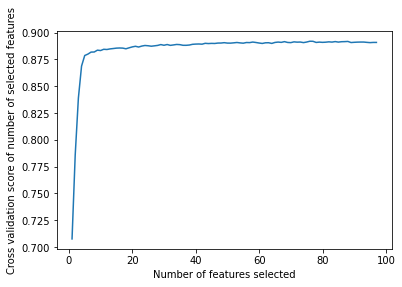

In [736]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [737]:
best_features = ['ID', 'N_1', 'N_2', 'N_11', 'N_18', 'N_19', 'N_20', 'N_21', 'N_22',
       'N_23', 'N_24', 'N_25', 'N_26', 'N_27', 'N_28', 'N_29', 'N_30', 'N_31',
       'N_32', 'N_33', 'N_34', 'N_35', 'N_36', 'N_37', 'N_38', 'N_39', 'N_40',
       'N_41', 'N_42', 'N_44', 'N_45', 'N_46', 'N_47', 'N_48', 'N_49', 'N_50',
       'N_51', 'N_53', 'N_54', 'N_55', 'N_56', 'N_57', 'N_58', 'N_59', 'N_60',
       'N_61', 'N_62', 'N_63', 'N_64', 'N_66', 'N_67', 'N_68', 'N_69', 'N_70',
       'N_71', 'N_72', 'N_73', 'N_74', 'N_75', 'N_76', 'N_77', 'N_78', 'N_79',
       'N_80', 'N_81', 'N_82', 'Day of week', 'C_4_1', 'C_4_2', 'C_4_5',
       'C_4_6', 'C_4_8', 'C_4_9', 'C_3_1', 'C_3_2', 'C_3_3']

In [738]:
model = LGBMClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
roc_auc_score(y_test, pred )

0.8906964987272896

In [739]:
model = LGBMClassifier()
model.fit(X_train[best_features], y_train)
pred = model.predict(X_test[best_features])
roc_auc_score(y_test, pred )

0.8897079353423479

# --------------BEST RESULT------------------

In [740]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
roc_auc_score(y_test, pred )

Learning rate set to 0.058798
0:	learn: 0.6515201	total: 32.6ms	remaining: 32.6s
1:	learn: 0.6156475	total: 58.4ms	remaining: 29.2s
2:	learn: 0.5826438	total: 83.4ms	remaining: 27.7s
3:	learn: 0.5544018	total: 108ms	remaining: 27s
4:	learn: 0.5290300	total: 132ms	remaining: 26.3s
5:	learn: 0.5090097	total: 156ms	remaining: 25.8s
6:	learn: 0.4915620	total: 182ms	remaining: 25.8s
7:	learn: 0.4756770	total: 217ms	remaining: 27s
8:	learn: 0.4620587	total: 259ms	remaining: 28.6s
9:	learn: 0.4478117	total: 284ms	remaining: 28.1s
10:	learn: 0.4364133	total: 308ms	remaining: 27.7s
11:	learn: 0.4253464	total: 333ms	remaining: 27.4s
12:	learn: 0.4157148	total: 359ms	remaining: 27.3s
13:	learn: 0.4064082	total: 384ms	remaining: 27.1s
14:	learn: 0.3990637	total: 409ms	remaining: 26.8s
15:	learn: 0.3922639	total: 445ms	remaining: 27.4s
16:	learn: 0.3854632	total: 485ms	remaining: 28s
17:	learn: 0.3727354	total: 512ms	remaining: 27.9s
18:	learn: 0.3656200	total: 538ms	remaining: 27.8s
19:	learn: 0.3

161:	learn: 0.2617390	total: 4.63s	remaining: 24s
162:	learn: 0.2615760	total: 4.66s	remaining: 23.9s
163:	learn: 0.2614521	total: 4.68s	remaining: 23.9s
164:	learn: 0.2612781	total: 4.71s	remaining: 23.8s
165:	learn: 0.2611732	total: 4.73s	remaining: 23.8s
166:	learn: 0.2610320	total: 4.75s	remaining: 23.7s
167:	learn: 0.2609159	total: 4.77s	remaining: 23.6s
168:	learn: 0.2607631	total: 4.8s	remaining: 23.6s
169:	learn: 0.2603268	total: 4.82s	remaining: 23.5s
170:	learn: 0.2600951	total: 4.85s	remaining: 23.5s
171:	learn: 0.2599483	total: 4.88s	remaining: 23.5s
172:	learn: 0.2598502	total: 4.9s	remaining: 23.4s
173:	learn: 0.2597408	total: 4.93s	remaining: 23.4s
174:	learn: 0.2595807	total: 4.95s	remaining: 23.3s
175:	learn: 0.2594848	total: 4.97s	remaining: 23.3s
176:	learn: 0.2593587	total: 5s	remaining: 23.2s
177:	learn: 0.2592176	total: 5.02s	remaining: 23.2s
178:	learn: 0.2590553	total: 5.04s	remaining: 23.1s
179:	learn: 0.2589416	total: 5.08s	remaining: 23.2s
180:	learn: 0.25882

322:	learn: 0.2396851	total: 11.5s	remaining: 24.1s
323:	learn: 0.2394644	total: 11.6s	remaining: 24.1s
324:	learn: 0.2393363	total: 11.6s	remaining: 24.1s
325:	learn: 0.2392079	total: 11.7s	remaining: 24.1s
326:	learn: 0.2390800	total: 11.7s	remaining: 24.1s
327:	learn: 0.2390396	total: 11.8s	remaining: 24.1s
328:	learn: 0.2389606	total: 11.8s	remaining: 24.1s
329:	learn: 0.2389039	total: 11.9s	remaining: 24.1s
330:	learn: 0.2387971	total: 11.9s	remaining: 24s
331:	learn: 0.2386991	total: 11.9s	remaining: 24s
332:	learn: 0.2386302	total: 12s	remaining: 24s
333:	learn: 0.2385158	total: 12s	remaining: 23.9s
334:	learn: 0.2384416	total: 12s	remaining: 23.9s
335:	learn: 0.2383263	total: 12s	remaining: 23.8s
336:	learn: 0.2382264	total: 12.1s	remaining: 23.7s
337:	learn: 0.2381276	total: 12.1s	remaining: 23.7s
338:	learn: 0.2379872	total: 12.1s	remaining: 23.7s
339:	learn: 0.2379267	total: 12.2s	remaining: 23.6s
340:	learn: 0.2377851	total: 12.2s	remaining: 23.5s
341:	learn: 0.2377223	tota

481:	learn: 0.2237884	total: 16.7s	remaining: 17.9s
482:	learn: 0.2236765	total: 16.7s	remaining: 17.9s
483:	learn: 0.2235849	total: 16.7s	remaining: 17.8s
484:	learn: 0.2234801	total: 16.8s	remaining: 17.8s
485:	learn: 0.2233865	total: 16.8s	remaining: 17.8s
486:	learn: 0.2232926	total: 16.8s	remaining: 17.7s
487:	learn: 0.2232372	total: 16.8s	remaining: 17.7s
488:	learn: 0.2231416	total: 16.9s	remaining: 17.6s
489:	learn: 0.2230405	total: 16.9s	remaining: 17.6s
490:	learn: 0.2229513	total: 17s	remaining: 17.6s
491:	learn: 0.2228391	total: 17s	remaining: 17.5s
492:	learn: 0.2227494	total: 17s	remaining: 17.5s
493:	learn: 0.2226797	total: 17s	remaining: 17.4s
494:	learn: 0.2225753	total: 17.1s	remaining: 17.4s
495:	learn: 0.2224884	total: 17.1s	remaining: 17.4s
496:	learn: 0.2223916	total: 17.1s	remaining: 17.3s
497:	learn: 0.2222841	total: 17.1s	remaining: 17.3s
498:	learn: 0.2221958	total: 17.2s	remaining: 17.2s
499:	learn: 0.2221331	total: 17.2s	remaining: 17.2s
500:	learn: 0.222026

644:	learn: 0.2103017	total: 22.9s	remaining: 12.6s
645:	learn: 0.2102222	total: 23s	remaining: 12.6s
646:	learn: 0.2101698	total: 23s	remaining: 12.6s
647:	learn: 0.2101063	total: 23s	remaining: 12.5s
648:	learn: 0.2100309	total: 23.1s	remaining: 12.5s
649:	learn: 0.2099313	total: 23.1s	remaining: 12.4s
650:	learn: 0.2098650	total: 23.1s	remaining: 12.4s
651:	learn: 0.2098448	total: 23.2s	remaining: 12.4s
652:	learn: 0.2097457	total: 23.2s	remaining: 12.3s
653:	learn: 0.2096796	total: 23.2s	remaining: 12.3s
654:	learn: 0.2095918	total: 23.2s	remaining: 12.2s
655:	learn: 0.2094953	total: 23.3s	remaining: 12.2s
656:	learn: 0.2094615	total: 23.3s	remaining: 12.2s
657:	learn: 0.2093958	total: 23.3s	remaining: 12.1s
658:	learn: 0.2093104	total: 23.4s	remaining: 12.1s
659:	learn: 0.2092355	total: 23.4s	remaining: 12.1s
660:	learn: 0.2092015	total: 23.4s	remaining: 12s
661:	learn: 0.2091200	total: 23.5s	remaining: 12s
662:	learn: 0.2090547	total: 23.6s	remaining: 12s
663:	learn: 0.2089694	to

806:	learn: 0.1986512	total: 29.9s	remaining: 7.15s
807:	learn: 0.1984382	total: 29.9s	remaining: 7.11s
808:	learn: 0.1983781	total: 29.9s	remaining: 7.07s
809:	learn: 0.1983225	total: 30s	remaining: 7.03s
810:	learn: 0.1982756	total: 30s	remaining: 6.99s
811:	learn: 0.1982242	total: 30s	remaining: 6.95s
812:	learn: 0.1981665	total: 30.1s	remaining: 6.92s
813:	learn: 0.1980774	total: 30.1s	remaining: 6.88s
814:	learn: 0.1980366	total: 30.1s	remaining: 6.84s
815:	learn: 0.1979572	total: 30.2s	remaining: 6.8s
816:	learn: 0.1978441	total: 30.2s	remaining: 6.77s
817:	learn: 0.1977873	total: 30.2s	remaining: 6.73s
818:	learn: 0.1976932	total: 30.3s	remaining: 6.69s
819:	learn: 0.1976124	total: 30.3s	remaining: 6.65s
820:	learn: 0.1975592	total: 30.3s	remaining: 6.61s
821:	learn: 0.1974919	total: 30.4s	remaining: 6.58s
822:	learn: 0.1974459	total: 30.5s	remaining: 6.55s
823:	learn: 0.1973915	total: 30.5s	remaining: 6.51s
824:	learn: 0.1973309	total: 30.5s	remaining: 6.47s
825:	learn: 0.19724

966:	learn: 0.1880045	total: 35s	remaining: 1.19s
967:	learn: 0.1879379	total: 35s	remaining: 1.16s
968:	learn: 0.1878740	total: 35.1s	remaining: 1.12s
969:	learn: 0.1878089	total: 35.1s	remaining: 1.08s
970:	learn: 0.1877335	total: 35.1s	remaining: 1.05s
971:	learn: 0.1876650	total: 35.1s	remaining: 1.01s
972:	learn: 0.1876005	total: 35.2s	remaining: 976ms
973:	learn: 0.1875375	total: 35.2s	remaining: 939ms
974:	learn: 0.1874854	total: 35.2s	remaining: 903ms
975:	learn: 0.1874156	total: 35.2s	remaining: 867ms
976:	learn: 0.1873564	total: 35.3s	remaining: 830ms
977:	learn: 0.1873121	total: 35.3s	remaining: 794ms
978:	learn: 0.1872690	total: 35.3s	remaining: 758ms
979:	learn: 0.1872027	total: 35.3s	remaining: 721ms
980:	learn: 0.1871613	total: 35.4s	remaining: 685ms
981:	learn: 0.1871007	total: 35.4s	remaining: 649ms
982:	learn: 0.1870200	total: 35.5s	remaining: 613ms
983:	learn: 0.1869586	total: 35.5s	remaining: 577ms
984:	learn: 0.1868904	total: 35.5s	remaining: 541ms
985:	learn: 0.18

0.8924548544327037

# ------------------------------------------------

In [741]:
model = CatBoostClassifier()
model.fit(X_train[best_features], y_train)
pred = model.predict(X_test[best_features])
roc_auc_score(y_test, pred )

Learning rate set to 0.058798
0:	learn: 0.6519954	total: 28.1ms	remaining: 28.1s
1:	learn: 0.6125451	total: 51.4ms	remaining: 25.7s
2:	learn: 0.5800970	total: 79.8ms	remaining: 26.5s
3:	learn: 0.5516360	total: 104ms	remaining: 25.9s
4:	learn: 0.5290742	total: 127ms	remaining: 25.3s
5:	learn: 0.5089201	total: 155ms	remaining: 25.6s
6:	learn: 0.4913108	total: 179ms	remaining: 25.5s
7:	learn: 0.4740983	total: 207ms	remaining: 25.7s
8:	learn: 0.4547085	total: 253ms	remaining: 27.8s
9:	learn: 0.4422972	total: 292ms	remaining: 28.9s
10:	learn: 0.4315291	total: 316ms	remaining: 28.4s
11:	learn: 0.4216922	total: 339ms	remaining: 27.9s
12:	learn: 0.4129085	total: 362ms	remaining: 27.5s
13:	learn: 0.4052142	total: 385ms	remaining: 27.1s
14:	learn: 0.3973622	total: 409ms	remaining: 26.8s
15:	learn: 0.3895631	total: 455ms	remaining: 28s
16:	learn: 0.3832229	total: 483ms	remaining: 27.9s
17:	learn: 0.3780683	total: 505ms	remaining: 27.5s
18:	learn: 0.3723461	total: 529ms	remaining: 27.3s
19:	learn:

168:	learn: 0.2607294	total: 4.53s	remaining: 22.3s
169:	learn: 0.2605002	total: 4.55s	remaining: 22.2s
170:	learn: 0.2602818	total: 4.57s	remaining: 22.2s
171:	learn: 0.2601779	total: 4.6s	remaining: 22.1s
172:	learn: 0.2600392	total: 4.63s	remaining: 22.1s
173:	learn: 0.2598508	total: 4.65s	remaining: 22.1s
174:	learn: 0.2597473	total: 4.68s	remaining: 22s
175:	learn: 0.2596158	total: 4.7s	remaining: 22s
176:	learn: 0.2593154	total: 4.72s	remaining: 22s
177:	learn: 0.2592255	total: 4.76s	remaining: 22s
178:	learn: 0.2590688	total: 4.79s	remaining: 21.9s
179:	learn: 0.2589529	total: 4.81s	remaining: 21.9s
180:	learn: 0.2587491	total: 4.83s	remaining: 21.9s
181:	learn: 0.2586378	total: 4.85s	remaining: 21.8s
182:	learn: 0.2585209	total: 4.88s	remaining: 21.8s
183:	learn: 0.2584037	total: 4.9s	remaining: 21.7s
184:	learn: 0.2582638	total: 4.92s	remaining: 21.7s
185:	learn: 0.2581526	total: 4.94s	remaining: 21.6s
186:	learn: 0.2579865	total: 4.97s	remaining: 21.6s
187:	learn: 0.2578328	t

331:	learn: 0.2391055	total: 8.66s	remaining: 17.4s
332:	learn: 0.2390069	total: 8.69s	remaining: 17.4s
333:	learn: 0.2388997	total: 8.72s	remaining: 17.4s
334:	learn: 0.2388305	total: 8.74s	remaining: 17.3s
335:	learn: 0.2386951	total: 8.76s	remaining: 17.3s
336:	learn: 0.2386197	total: 8.79s	remaining: 17.3s
337:	learn: 0.2385358	total: 8.81s	remaining: 17.3s
338:	learn: 0.2384411	total: 8.83s	remaining: 17.2s
339:	learn: 0.2383278	total: 8.85s	remaining: 17.2s
340:	learn: 0.2381910	total: 8.89s	remaining: 17.2s
341:	learn: 0.2380837	total: 8.92s	remaining: 17.2s
342:	learn: 0.2380253	total: 8.94s	remaining: 17.1s
343:	learn: 0.2378941	total: 8.96s	remaining: 17.1s
344:	learn: 0.2377874	total: 8.99s	remaining: 17.1s
345:	learn: 0.2376069	total: 9.01s	remaining: 17s
346:	learn: 0.2374855	total: 9.03s	remaining: 17s
347:	learn: 0.2373947	total: 9.05s	remaining: 17s
348:	learn: 0.2373203	total: 9.08s	remaining: 16.9s
349:	learn: 0.2371888	total: 9.12s	remaining: 16.9s
350:	learn: 0.2371

498:	learn: 0.2232386	total: 12.9s	remaining: 12.9s
499:	learn: 0.2231558	total: 12.9s	remaining: 12.9s
500:	learn: 0.2230532	total: 12.9s	remaining: 12.9s
501:	learn: 0.2229384	total: 13s	remaining: 12.9s
502:	learn: 0.2228220	total: 13s	remaining: 12.8s
503:	learn: 0.2227226	total: 13s	remaining: 12.8s
504:	learn: 0.2226136	total: 13s	remaining: 12.8s
505:	learn: 0.2225408	total: 13.1s	remaining: 12.7s
506:	learn: 0.2224358	total: 13.1s	remaining: 12.7s
507:	learn: 0.2223560	total: 13.1s	remaining: 12.7s
508:	learn: 0.2222777	total: 13.1s	remaining: 12.7s
509:	learn: 0.2221869	total: 13.2s	remaining: 12.6s
510:	learn: 0.2220754	total: 13.2s	remaining: 12.6s
511:	learn: 0.2220058	total: 13.2s	remaining: 12.6s
512:	learn: 0.2218935	total: 13.2s	remaining: 12.6s
513:	learn: 0.2218281	total: 13.3s	remaining: 12.5s
514:	learn: 0.2217530	total: 13.3s	remaining: 12.5s
515:	learn: 0.2216596	total: 13.3s	remaining: 12.5s
516:	learn: 0.2215629	total: 13.3s	remaining: 12.5s
517:	learn: 0.221462

660:	learn: 0.2100037	total: 17.3s	remaining: 8.88s
661:	learn: 0.2099048	total: 17.4s	remaining: 8.88s
662:	learn: 0.2097933	total: 17.5s	remaining: 8.88s
663:	learn: 0.2097115	total: 17.5s	remaining: 8.86s
664:	learn: 0.2096200	total: 17.6s	remaining: 8.85s
665:	learn: 0.2095335	total: 17.6s	remaining: 8.83s
666:	learn: 0.2095043	total: 17.6s	remaining: 8.81s
667:	learn: 0.2094451	total: 17.7s	remaining: 8.78s
668:	learn: 0.2093812	total: 17.7s	remaining: 8.76s
669:	learn: 0.2092887	total: 17.7s	remaining: 8.73s
670:	learn: 0.2092042	total: 17.8s	remaining: 8.7s
671:	learn: 0.2091267	total: 17.8s	remaining: 8.68s
672:	learn: 0.2090273	total: 17.8s	remaining: 8.66s
673:	learn: 0.2089266	total: 17.9s	remaining: 8.63s
674:	learn: 0.2088511	total: 17.9s	remaining: 8.61s
675:	learn: 0.2088222	total: 17.9s	remaining: 8.58s
676:	learn: 0.2087427	total: 17.9s	remaining: 8.56s
677:	learn: 0.2086637	total: 18s	remaining: 8.53s
678:	learn: 0.2085699	total: 18s	remaining: 8.5s
679:	learn: 0.2085

822:	learn: 0.1982265	total: 23.8s	remaining: 5.12s
823:	learn: 0.1981554	total: 23.9s	remaining: 5.1s
824:	learn: 0.1980994	total: 23.9s	remaining: 5.07s
825:	learn: 0.1980583	total: 23.9s	remaining: 5.04s
826:	learn: 0.1980188	total: 23.9s	remaining: 5.01s
827:	learn: 0.1979234	total: 24s	remaining: 4.98s
828:	learn: 0.1978420	total: 24s	remaining: 4.95s
829:	learn: 0.1977737	total: 24.1s	remaining: 4.93s
830:	learn: 0.1977177	total: 24.1s	remaining: 4.9s
831:	learn: 0.1976461	total: 24.1s	remaining: 4.87s
832:	learn: 0.1975891	total: 24.2s	remaining: 4.84s
833:	learn: 0.1975136	total: 24.2s	remaining: 4.82s
834:	learn: 0.1974779	total: 24.2s	remaining: 4.79s
835:	learn: 0.1974003	total: 24.3s	remaining: 4.76s
836:	learn: 0.1973034	total: 24.3s	remaining: 4.73s
837:	learn: 0.1972588	total: 24.3s	remaining: 4.7s
838:	learn: 0.1971825	total: 24.4s	remaining: 4.67s
839:	learn: 0.1971369	total: 24.4s	remaining: 4.64s
840:	learn: 0.1970947	total: 24.4s	remaining: 4.62s
841:	learn: 0.19701

986:	learn: 0.1877959	total: 29.7s	remaining: 391ms
987:	learn: 0.1877197	total: 29.7s	remaining: 361ms
988:	learn: 0.1876637	total: 29.8s	remaining: 331ms
989:	learn: 0.1875844	total: 29.8s	remaining: 301ms
990:	learn: 0.1875053	total: 29.9s	remaining: 271ms
991:	learn: 0.1874433	total: 29.9s	remaining: 241ms
992:	learn: 0.1873737	total: 29.9s	remaining: 211ms
993:	learn: 0.1872983	total: 30s	remaining: 181ms
994:	learn: 0.1872421	total: 30s	remaining: 151ms
995:	learn: 0.1871930	total: 30s	remaining: 121ms
996:	learn: 0.1871034	total: 30.1s	remaining: 90.5ms
997:	learn: 0.1870484	total: 30.1s	remaining: 60.4ms
998:	learn: 0.1869932	total: 30.2s	remaining: 30.2ms
999:	learn: 0.1869210	total: 30.2s	remaining: 0us


0.8915117276111708

Отбираем признаки с помощью Catboost:

In [742]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
rf = CatBoostClassifier(iterations=20) 
rfecv = RFECV(estimator=rf, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Learning rate set to 0.5
0:	learn: 0.4452569	total: 28.7ms	remaining: 545ms
1:	learn: 0.3831710	total: 51.4ms	remaining: 462ms
2:	learn: 0.3453106	total: 71.5ms	remaining: 405ms
3:	learn: 0.3284270	total: 91.5ms	remaining: 366ms
4:	learn: 0.3129796	total: 113ms	remaining: 340ms
5:	learn: 0.3033891	total: 137ms	remaining: 319ms
6:	learn: 0.2973187	total: 158ms	remaining: 294ms
7:	learn: 0.2929045	total: 179ms	remaining: 268ms
8:	learn: 0.2856172	total: 205ms	remaining: 251ms
9:	learn: 0.2839634	total: 249ms	remaining: 249ms
10:	learn: 0.2810795	total: 274ms	remaining: 224ms
11:	learn: 0.2792717	total: 296ms	remaining: 197ms
12:	learn: 0.2769346	total: 318ms	remaining: 171ms
13:	learn: 0.2756077	total: 342ms	remaining: 146ms
14:	learn: 0.2741822	total: 365ms	remaining: 122ms
15:	learn: 0.2724796	total: 386ms	remaining: 96.4ms
16:	learn: 0.2710946	total: 412ms	remaining: 72.7ms
17:	learn: 0.2696451	total: 463ms	remaining: 51.4ms
18:	learn: 0.2686588	total: 491ms	remaining: 25.8ms
19:	lear

18:	learn: 0.2670142	total: 432ms	remaining: 22.8ms
19:	learn: 0.2652162	total: 459ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4455531	total: 33.4ms	remaining: 635ms
1:	learn: 0.3851536	total: 57.1ms	remaining: 514ms
2:	learn: 0.3573723	total: 78.4ms	remaining: 444ms
3:	learn: 0.3341432	total: 99.8ms	remaining: 399ms
4:	learn: 0.3194968	total: 120ms	remaining: 359ms
5:	learn: 0.3094813	total: 139ms	remaining: 324ms
6:	learn: 0.3051362	total: 159ms	remaining: 295ms
7:	learn: 0.3015329	total: 178ms	remaining: 266ms
8:	learn: 0.2884915	total: 198ms	remaining: 242ms
9:	learn: 0.2854623	total: 217ms	remaining: 217ms
10:	learn: 0.2829082	total: 243ms	remaining: 199ms
11:	learn: 0.2799982	total: 270ms	remaining: 180ms
12:	learn: 0.2781669	total: 292ms	remaining: 157ms
13:	learn: 0.2737537	total: 313ms	remaining: 134ms
14:	learn: 0.2686684	total: 334ms	remaining: 111ms
15:	learn: 0.2669173	total: 355ms	remaining: 88.9ms
16:	learn: 0.2657914	total: 375ms	remaining: 66.2ms
17:	learn: 

19:	learn: 0.2635270	total: 422ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4494808	total: 30.8ms	remaining: 585ms
1:	learn: 0.3812541	total: 56.5ms	remaining: 509ms
2:	learn: 0.3489351	total: 76.5ms	remaining: 433ms
3:	learn: 0.3240396	total: 96.4ms	remaining: 385ms
4:	learn: 0.2986086	total: 116ms	remaining: 349ms
5:	learn: 0.2930348	total: 136ms	remaining: 317ms
6:	learn: 0.2878476	total: 155ms	remaining: 288ms
7:	learn: 0.2852579	total: 173ms	remaining: 260ms
8:	learn: 0.2823721	total: 192ms	remaining: 234ms
9:	learn: 0.2799160	total: 212ms	remaining: 212ms
10:	learn: 0.2774934	total: 236ms	remaining: 193ms
11:	learn: 0.2760672	total: 263ms	remaining: 175ms
12:	learn: 0.2742791	total: 282ms	remaining: 152ms
13:	learn: 0.2728442	total: 301ms	remaining: 129ms
14:	learn: 0.2712212	total: 320ms	remaining: 107ms
15:	learn: 0.2698545	total: 341ms	remaining: 85.2ms
16:	learn: 0.2687629	total: 361ms	remaining: 63.6ms
17:	learn: 0.2664027	total: 379ms	remaining: 42.1ms
18:	learn: 

Learning rate set to 0.5
0:	learn: 0.4538052	total: 23.3ms	remaining: 443ms
1:	learn: 0.3849189	total: 41.5ms	remaining: 374ms
2:	learn: 0.3489152	total: 60.7ms	remaining: 344ms
3:	learn: 0.3302720	total: 78.9ms	remaining: 316ms
4:	learn: 0.3209804	total: 96.8ms	remaining: 290ms
5:	learn: 0.2997704	total: 116ms	remaining: 270ms
6:	learn: 0.2943697	total: 134ms	remaining: 249ms
7:	learn: 0.2859345	total: 153ms	remaining: 229ms
8:	learn: 0.2836205	total: 172ms	remaining: 210ms
9:	learn: 0.2810103	total: 192ms	remaining: 192ms
10:	learn: 0.2796027	total: 222ms	remaining: 182ms
11:	learn: 0.2774018	total: 242ms	remaining: 161ms
12:	learn: 0.2744264	total: 262ms	remaining: 141ms
13:	learn: 0.2723854	total: 283ms	remaining: 121ms
14:	learn: 0.2709319	total: 303ms	remaining: 101ms
15:	learn: 0.2694081	total: 321ms	remaining: 80.4ms
16:	learn: 0.2684388	total: 339ms	remaining: 59.9ms
17:	learn: 0.2673141	total: 357ms	remaining: 39.7ms
18:	learn: 0.2644541	total: 376ms	remaining: 19.8ms
19:	lea

Learning rate set to 0.5
0:	learn: 0.4629360	total: 21.9ms	remaining: 415ms
1:	learn: 0.3852278	total: 39.8ms	remaining: 358ms
2:	learn: 0.3562294	total: 57.4ms	remaining: 325ms
3:	learn: 0.3153238	total: 76.4ms	remaining: 305ms
4:	learn: 0.3066413	total: 94.4ms	remaining: 283ms
5:	learn: 0.3005566	total: 112ms	remaining: 261ms
6:	learn: 0.2921385	total: 131ms	remaining: 242ms
7:	learn: 0.2895341	total: 149ms	remaining: 223ms
8:	learn: 0.2850772	total: 166ms	remaining: 203ms
9:	learn: 0.2812456	total: 184ms	remaining: 184ms
10:	learn: 0.2794711	total: 209ms	remaining: 171ms
11:	learn: 0.2766681	total: 232ms	remaining: 154ms
12:	learn: 0.2751026	total: 250ms	remaining: 135ms
13:	learn: 0.2731639	total: 268ms	remaining: 115ms
14:	learn: 0.2714804	total: 286ms	remaining: 95.4ms
15:	learn: 0.2700935	total: 305ms	remaining: 76.3ms
16:	learn: 0.2685702	total: 323ms	remaining: 57ms
17:	learn: 0.2652504	total: 343ms	remaining: 38.1ms
18:	learn: 0.2640315	total: 360ms	remaining: 18.9ms
19:	lear

Learning rate set to 0.5
0:	learn: 0.4508310	total: 21ms	remaining: 399ms
1:	learn: 0.3787540	total: 39.4ms	remaining: 355ms
2:	learn: 0.3464312	total: 56.3ms	remaining: 319ms
3:	learn: 0.3328149	total: 72.4ms	remaining: 290ms
4:	learn: 0.3232006	total: 89.5ms	remaining: 269ms
5:	learn: 0.3169838	total: 106ms	remaining: 248ms
6:	learn: 0.3024148	total: 125ms	remaining: 232ms
7:	learn: 0.2916973	total: 142ms	remaining: 213ms
8:	learn: 0.2881086	total: 160ms	remaining: 195ms
9:	learn: 0.2854245	total: 177ms	remaining: 177ms
10:	learn: 0.2831744	total: 194ms	remaining: 159ms
11:	learn: 0.2738463	total: 222ms	remaining: 148ms
12:	learn: 0.2723161	total: 241ms	remaining: 130ms
13:	learn: 0.2703574	total: 259ms	remaining: 111ms
14:	learn: 0.2689189	total: 276ms	remaining: 92ms
15:	learn: 0.2675401	total: 294ms	remaining: 73.5ms
16:	learn: 0.2666887	total: 311ms	remaining: 54.9ms
17:	learn: 0.2654497	total: 328ms	remaining: 36.4ms
18:	learn: 0.2641474	total: 345ms	remaining: 18.1ms
19:	learn:

Learning rate set to 0.5
0:	learn: 0.4493200	total: 20.3ms	remaining: 386ms
1:	learn: 0.3746195	total: 37ms	remaining: 333ms
2:	learn: 0.3521624	total: 54.7ms	remaining: 310ms
3:	learn: 0.3385882	total: 71.5ms	remaining: 286ms
4:	learn: 0.3076050	total: 87.7ms	remaining: 263ms
5:	learn: 0.3007718	total: 103ms	remaining: 241ms
6:	learn: 0.2933784	total: 120ms	remaining: 222ms
7:	learn: 0.2893919	total: 136ms	remaining: 204ms
8:	learn: 0.2868563	total: 153ms	remaining: 187ms
9:	learn: 0.2842261	total: 168ms	remaining: 168ms
10:	learn: 0.2799573	total: 185ms	remaining: 151ms
11:	learn: 0.2781583	total: 208ms	remaining: 139ms
12:	learn: 0.2762851	total: 228ms	remaining: 123ms
13:	learn: 0.2745309	total: 247ms	remaining: 106ms
14:	learn: 0.2733781	total: 263ms	remaining: 87.6ms
15:	learn: 0.2719831	total: 281ms	remaining: 70.2ms
16:	learn: 0.2705329	total: 297ms	remaining: 52.5ms
17:	learn: 0.2663059	total: 314ms	remaining: 34.9ms
18:	learn: 0.2648756	total: 331ms	remaining: 17.4ms
19:	lear

Learning rate set to 0.5
0:	learn: 0.4510312	total: 19.7ms	remaining: 374ms
1:	learn: 0.3842017	total: 35.6ms	remaining: 321ms
2:	learn: 0.3522678	total: 51.6ms	remaining: 292ms
3:	learn: 0.3345338	total: 67.4ms	remaining: 270ms
4:	learn: 0.3221048	total: 82.9ms	remaining: 249ms
5:	learn: 0.3146717	total: 98.5ms	remaining: 230ms
6:	learn: 0.2961764	total: 114ms	remaining: 213ms
7:	learn: 0.2909807	total: 130ms	remaining: 195ms
8:	learn: 0.2876353	total: 145ms	remaining: 177ms
9:	learn: 0.2816914	total: 161ms	remaining: 161ms
10:	learn: 0.2789480	total: 178ms	remaining: 145ms
11:	learn: 0.2765782	total: 194ms	remaining: 129ms
12:	learn: 0.2751791	total: 223ms	remaining: 120ms
13:	learn: 0.2739012	total: 255ms	remaining: 109ms
14:	learn: 0.2722883	total: 273ms	remaining: 91.1ms
15:	learn: 0.2709074	total: 290ms	remaining: 72.4ms
16:	learn: 0.2694367	total: 307ms	remaining: 54.1ms
17:	learn: 0.2651537	total: 323ms	remaining: 35.9ms
18:	learn: 0.2644501	total: 339ms	remaining: 17.8ms
19:	l

0:	learn: 0.4385153	total: 28.5ms	remaining: 541ms
1:	learn: 0.3732006	total: 46.7ms	remaining: 421ms
2:	learn: 0.3453154	total: 62.4ms	remaining: 354ms
3:	learn: 0.3302801	total: 77.2ms	remaining: 309ms
4:	learn: 0.3044133	total: 92ms	remaining: 276ms
5:	learn: 0.2969341	total: 107ms	remaining: 249ms
6:	learn: 0.2933735	total: 122ms	remaining: 226ms
7:	learn: 0.2852732	total: 137ms	remaining: 205ms
8:	learn: 0.2803081	total: 151ms	remaining: 185ms
9:	learn: 0.2781404	total: 166ms	remaining: 166ms
10:	learn: 0.2762885	total: 181ms	remaining: 148ms
11:	learn: 0.2746925	total: 196ms	remaining: 130ms
12:	learn: 0.2731752	total: 211ms	remaining: 113ms
13:	learn: 0.2720072	total: 225ms	remaining: 96.3ms
14:	learn: 0.2698908	total: 250ms	remaining: 83.5ms
15:	learn: 0.2687320	total: 267ms	remaining: 66.8ms
16:	learn: 0.2672268	total: 282ms	remaining: 49.8ms
17:	learn: 0.2665090	total: 297ms	remaining: 33ms
18:	learn: 0.2653243	total: 311ms	remaining: 16.4ms
19:	learn: 0.2643445	total: 326ms	

19:	learn: 0.2636637	total: 316ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4486194	total: 15.7ms	remaining: 299ms
1:	learn: 0.3767944	total: 29.7ms	remaining: 267ms
2:	learn: 0.3512134	total: 43.8ms	remaining: 248ms
3:	learn: 0.3387476	total: 57.3ms	remaining: 229ms
4:	learn: 0.3234862	total: 71.9ms	remaining: 216ms
5:	learn: 0.3118020	total: 85.6ms	remaining: 200ms
6:	learn: 0.2902879	total: 99ms	remaining: 184ms
7:	learn: 0.2865697	total: 113ms	remaining: 169ms
8:	learn: 0.2835672	total: 126ms	remaining: 154ms
9:	learn: 0.2812830	total: 151ms	remaining: 151ms
10:	learn: 0.2794040	total: 166ms	remaining: 136ms
11:	learn: 0.2779898	total: 180ms	remaining: 120ms
12:	learn: 0.2765131	total: 194ms	remaining: 104ms
13:	learn: 0.2753231	total: 208ms	remaining: 89ms
14:	learn: 0.2740709	total: 221ms	remaining: 73.8ms
15:	learn: 0.2708121	total: 235ms	remaining: 58.7ms
16:	learn: 0.2695183	total: 249ms	remaining: 44ms
17:	learn: 0.2649702	total: 264ms	remaining: 29.3ms
18:	learn: 0

15:	learn: 0.2891105	total: 93ms	remaining: 23.2ms
16:	learn: 0.2874847	total: 104ms	remaining: 18.4ms
17:	learn: 0.2868185	total: 113ms	remaining: 12.5ms
18:	learn: 0.2856304	total: 120ms	remaining: 6.3ms
19:	learn: 0.2842849	total: 127ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5007806	total: 9.44ms	remaining: 179ms
1:	learn: 0.4290523	total: 14.9ms	remaining: 134ms
2:	learn: 0.3889495	total: 20.3ms	remaining: 115ms
3:	learn: 0.3656647	total: 25.8ms	remaining: 103ms
4:	learn: 0.3540623	total: 31ms	remaining: 93.1ms
5:	learn: 0.3454100	total: 36.4ms	remaining: 85ms
6:	learn: 0.3270530	total: 41.8ms	remaining: 77.7ms
7:	learn: 0.3188621	total: 47.1ms	remaining: 70.6ms
8:	learn: 0.3146487	total: 52.4ms	remaining: 64ms
9:	learn: 0.3098524	total: 58ms	remaining: 58ms
10:	learn: 0.3042294	total: 63.3ms	remaining: 51.8ms
11:	learn: 0.3029323	total: 68.3ms	remaining: 45.5ms
12:	learn: 0.2971568	total: 73.4ms	remaining: 39.5ms
13:	learn: 0.2948466	total: 79ms	remaining: 33.9ms
14:	

9:	learn: 0.3234895	total: 50.2ms	remaining: 50.2ms
10:	learn: 0.3176214	total: 59.6ms	remaining: 48.7ms
11:	learn: 0.3166281	total: 68.2ms	remaining: 45.5ms
12:	learn: 0.3148348	total: 75.7ms	remaining: 40.8ms
13:	learn: 0.3115875	total: 80.4ms	remaining: 34.5ms
14:	learn: 0.3103994	total: 85.5ms	remaining: 28.5ms
15:	learn: 0.3094295	total: 91ms	remaining: 22.8ms
16:	learn: 0.3073582	total: 95.6ms	remaining: 16.9ms
17:	learn: 0.3058153	total: 100ms	remaining: 11.1ms
18:	learn: 0.3041234	total: 105ms	remaining: 5.53ms
19:	learn: 0.3034681	total: 110ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5081233	total: 5.57ms	remaining: 106ms
1:	learn: 0.4329895	total: 10ms	remaining: 90ms
2:	learn: 0.4021848	total: 14.9ms	remaining: 84.3ms
3:	learn: 0.3867599	total: 19ms	remaining: 76.1ms
4:	learn: 0.3607679	total: 23.5ms	remaining: 70.4ms
5:	learn: 0.3472669	total: 27.8ms	remaining: 64.9ms
6:	learn: 0.3409274	total: 32.3ms	remaining: 60ms
7:	learn: 0.3315248	total: 36.9ms	remaining: 5

8:	learn: 0.2898739	total: 204ms	remaining: 249ms
9:	learn: 0.2882833	total: 232ms	remaining: 232ms
10:	learn: 0.2845829	total: 254ms	remaining: 208ms
11:	learn: 0.2826773	total: 275ms	remaining: 184ms
12:	learn: 0.2804470	total: 297ms	remaining: 160ms
13:	learn: 0.2780855	total: 317ms	remaining: 136ms
14:	learn: 0.2762911	total: 339ms	remaining: 113ms
15:	learn: 0.2733540	total: 361ms	remaining: 90.1ms
16:	learn: 0.2722352	total: 384ms	remaining: 67.7ms
17:	learn: 0.2710330	total: 411ms	remaining: 45.6ms
18:	learn: 0.2699074	total: 442ms	remaining: 23.3ms
19:	learn: 0.2664420	total: 480ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4486108	total: 26.5ms	remaining: 503ms
1:	learn: 0.3820376	total: 49.5ms	remaining: 446ms
2:	learn: 0.3552736	total: 71.5ms	remaining: 405ms
3:	learn: 0.3340734	total: 93.7ms	remaining: 375ms
4:	learn: 0.3063727	total: 115ms	remaining: 346ms
5:	learn: 0.2979101	total: 135ms	remaining: 315ms
6:	learn: 0.2920359	total: 155ms	remaining: 289ms
7:	learn:

7:	learn: 0.2875156	total: 202ms	remaining: 303ms
8:	learn: 0.2851554	total: 240ms	remaining: 294ms
9:	learn: 0.2832495	total: 265ms	remaining: 265ms
10:	learn: 0.2798405	total: 290ms	remaining: 237ms
11:	learn: 0.2783087	total: 314ms	remaining: 209ms
12:	learn: 0.2764100	total: 340ms	remaining: 183ms
13:	learn: 0.2734589	total: 368ms	remaining: 158ms
14:	learn: 0.2722050	total: 391ms	remaining: 130ms
15:	learn: 0.2705694	total: 417ms	remaining: 104ms
16:	learn: 0.2694568	total: 454ms	remaining: 80.1ms
17:	learn: 0.2685786	total: 477ms	remaining: 53ms
18:	learn: 0.2654558	total: 501ms	remaining: 26.4ms
19:	learn: 0.2616261	total: 527ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4524461	total: 26.1ms	remaining: 496ms
1:	learn: 0.3787561	total: 48.4ms	remaining: 435ms
2:	learn: 0.3510953	total: 82.1ms	remaining: 465ms
3:	learn: 0.3157144	total: 120ms	remaining: 481ms
4:	learn: 0.3047682	total: 158ms	remaining: 474ms
5:	learn: 0.2974543	total: 200ms	remaining: 466ms
6:	learn: 0.2

6:	learn: 0.2883702	total: 197ms	remaining: 365ms
7:	learn: 0.2848571	total: 227ms	remaining: 341ms
8:	learn: 0.2820416	total: 263ms	remaining: 322ms
9:	learn: 0.2800934	total: 290ms	remaining: 290ms
10:	learn: 0.2773521	total: 316ms	remaining: 258ms
11:	learn: 0.2740135	total: 343ms	remaining: 229ms
12:	learn: 0.2719094	total: 370ms	remaining: 199ms
13:	learn: 0.2700028	total: 390ms	remaining: 167ms
14:	learn: 0.2686140	total: 423ms	remaining: 141ms
15:	learn: 0.2674716	total: 445ms	remaining: 111ms
16:	learn: 0.2664930	total: 465ms	remaining: 82.1ms
17:	learn: 0.2650447	total: 485ms	remaining: 53.9ms
18:	learn: 0.2638983	total: 505ms	remaining: 26.6ms
19:	learn: 0.2628371	total: 525ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4448321	total: 24.8ms	remaining: 472ms
1:	learn: 0.3753505	total: 45.1ms	remaining: 406ms
2:	learn: 0.3473823	total: 65.2ms	remaining: 370ms
3:	learn: 0.3338385	total: 84.6ms	remaining: 338ms
4:	learn: 0.3051403	total: 104ms	remaining: 311ms
5:	learn: 

9:	learn: 0.2806580	total: 195ms	remaining: 195ms
10:	learn: 0.2780070	total: 228ms	remaining: 187ms
11:	learn: 0.2745886	total: 249ms	remaining: 166ms
12:	learn: 0.2733020	total: 268ms	remaining: 144ms
13:	learn: 0.2722832	total: 289ms	remaining: 124ms
14:	learn: 0.2700674	total: 308ms	remaining: 103ms
15:	learn: 0.2689549	total: 327ms	remaining: 81.7ms
16:	learn: 0.2674337	total: 345ms	remaining: 60.9ms
17:	learn: 0.2659663	total: 365ms	remaining: 40.6ms
18:	learn: 0.2641522	total: 386ms	remaining: 20.3ms
19:	learn: 0.2629463	total: 418ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4473822	total: 23.8ms	remaining: 452ms
1:	learn: 0.3841053	total: 47.5ms	remaining: 427ms
2:	learn: 0.3405765	total: 75.5ms	remaining: 428ms
3:	learn: 0.3307571	total: 96.4ms	remaining: 386ms
4:	learn: 0.3195265	total: 115ms	remaining: 346ms
5:	learn: 0.3060594	total: 135ms	remaining: 315ms
6:	learn: 0.3013463	total: 153ms	remaining: 285ms
7:	learn: 0.2970493	total: 173ms	remaining: 259ms
8:	learn:

8:	learn: 0.2904975	total: 202ms	remaining: 247ms
9:	learn: 0.2884240	total: 251ms	remaining: 251ms
10:	learn: 0.2858878	total: 297ms	remaining: 243ms
11:	learn: 0.2843789	total: 339ms	remaining: 226ms
12:	learn: 0.2822333	total: 373ms	remaining: 201ms
13:	learn: 0.2798317	total: 401ms	remaining: 172ms
14:	learn: 0.2723738	total: 452ms	remaining: 151ms
15:	learn: 0.2700748	total: 481ms	remaining: 120ms
16:	learn: 0.2691647	total: 513ms	remaining: 90.6ms
17:	learn: 0.2678037	total: 543ms	remaining: 60.3ms
18:	learn: 0.2664004	total: 572ms	remaining: 30.1ms
19:	learn: 0.2655049	total: 598ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4580897	total: 23.6ms	remaining: 448ms
1:	learn: 0.3853550	total: 43.8ms	remaining: 394ms
2:	learn: 0.3485042	total: 63.1ms	remaining: 358ms
3:	learn: 0.3306064	total: 97.2ms	remaining: 389ms
4:	learn: 0.3163878	total: 133ms	remaining: 398ms
5:	learn: 0.2939036	total: 168ms	remaining: 391ms
6:	learn: 0.2881771	total: 205ms	remaining: 380ms
7:	learn: 

8:	learn: 0.2845735	total: 199ms	remaining: 244ms
9:	learn: 0.2815123	total: 218ms	remaining: 218ms
10:	learn: 0.2791661	total: 249ms	remaining: 204ms
11:	learn: 0.2775529	total: 270ms	remaining: 180ms
12:	learn: 0.2724742	total: 290ms	remaining: 156ms
13:	learn: 0.2708729	total: 311ms	remaining: 133ms
14:	learn: 0.2693653	total: 332ms	remaining: 111ms
15:	learn: 0.2681174	total: 351ms	remaining: 87.8ms
16:	learn: 0.2672186	total: 370ms	remaining: 65.4ms
17:	learn: 0.2656645	total: 389ms	remaining: 43.2ms
18:	learn: 0.2647795	total: 408ms	remaining: 21.5ms
19:	learn: 0.2636242	total: 428ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4541822	total: 27.2ms	remaining: 516ms
1:	learn: 0.3822141	total: 47.7ms	remaining: 429ms
2:	learn: 0.3479373	total: 68.1ms	remaining: 386ms
3:	learn: 0.3303433	total: 88.8ms	remaining: 355ms
4:	learn: 0.3085013	total: 110ms	remaining: 331ms
5:	learn: 0.3003271	total: 129ms	remaining: 301ms
6:	learn: 0.2954824	total: 149ms	remaining: 277ms
7:	learn:

7:	learn: 0.2912590	total: 195ms	remaining: 292ms
8:	learn: 0.2844669	total: 219ms	remaining: 268ms
9:	learn: 0.2822461	total: 247ms	remaining: 247ms
10:	learn: 0.2793671	total: 270ms	remaining: 221ms
11:	learn: 0.2772710	total: 296ms	remaining: 197ms
12:	learn: 0.2759886	total: 318ms	remaining: 171ms
13:	learn: 0.2706896	total: 345ms	remaining: 148ms
14:	learn: 0.2688239	total: 367ms	remaining: 122ms
15:	learn: 0.2673268	total: 389ms	remaining: 97.1ms
16:	learn: 0.2663199	total: 409ms	remaining: 72.2ms
17:	learn: 0.2645242	total: 428ms	remaining: 47.6ms
18:	learn: 0.2635094	total: 446ms	remaining: 23.4ms
19:	learn: 0.2623540	total: 465ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4476435	total: 23.7ms	remaining: 451ms
1:	learn: 0.3850885	total: 43.4ms	remaining: 390ms
2:	learn: 0.3540371	total: 64ms	remaining: 362ms
3:	learn: 0.3323921	total: 81.2ms	remaining: 325ms
4:	learn: 0.3019770	total: 99.1ms	remaining: 297ms
5:	learn: 0.2945430	total: 117ms	remaining: 273ms
6:	learn: 

10:	learn: 0.2820464	total: 209ms	remaining: 171ms
11:	learn: 0.2804228	total: 226ms	remaining: 151ms
12:	learn: 0.2742235	total: 248ms	remaining: 133ms
13:	learn: 0.2730711	total: 264ms	remaining: 113ms
14:	learn: 0.2708548	total: 281ms	remaining: 93.7ms
15:	learn: 0.2697541	total: 302ms	remaining: 75.5ms
16:	learn: 0.2684831	total: 319ms	remaining: 56.3ms
17:	learn: 0.2671020	total: 338ms	remaining: 37.6ms
18:	learn: 0.2658981	total: 357ms	remaining: 18.8ms
19:	learn: 0.2645898	total: 374ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4514916	total: 22.7ms	remaining: 432ms
1:	learn: 0.3835463	total: 39.9ms	remaining: 359ms
2:	learn: 0.3554613	total: 59.8ms	remaining: 339ms
3:	learn: 0.3201667	total: 77.8ms	remaining: 311ms
4:	learn: 0.3088994	total: 94.3ms	remaining: 283ms
5:	learn: 0.3042217	total: 115ms	remaining: 269ms
6:	learn: 0.2958664	total: 133ms	remaining: 247ms
7:	learn: 0.2856715	total: 151ms	remaining: 227ms
8:	learn: 0.2819650	total: 171ms	remaining: 209ms
9:	lear

10:	learn: 0.2780622	total: 200ms	remaining: 164ms
11:	learn: 0.2768639	total: 218ms	remaining: 146ms
12:	learn: 0.2748234	total: 257ms	remaining: 138ms
13:	learn: 0.2731915	total: 274ms	remaining: 117ms
14:	learn: 0.2716878	total: 291ms	remaining: 96.9ms
15:	learn: 0.2699623	total: 311ms	remaining: 77.8ms
16:	learn: 0.2661219	total: 327ms	remaining: 57.6ms
17:	learn: 0.2648704	total: 345ms	remaining: 38.3ms
18:	learn: 0.2639746	total: 365ms	remaining: 19.2ms
19:	learn: 0.2629053	total: 381ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4481765	total: 22.8ms	remaining: 433ms
1:	learn: 0.3791528	total: 40.6ms	remaining: 365ms
2:	learn: 0.3452452	total: 56ms	remaining: 317ms
3:	learn: 0.3127330	total: 76.7ms	remaining: 307ms
4:	learn: 0.3008083	total: 94.1ms	remaining: 282ms
5:	learn: 0.2964893	total: 110ms	remaining: 257ms
6:	learn: 0.2914931	total: 133ms	remaining: 248ms
7:	learn: 0.2849367	total: 148ms	remaining: 222ms
8:	learn: 0.2822701	total: 165ms	remaining: 202ms
9:	learn:

12:	learn: 0.2723038	total: 203ms	remaining: 109ms
13:	learn: 0.2707082	total: 218ms	remaining: 93.5ms
14:	learn: 0.2693811	total: 234ms	remaining: 78ms
15:	learn: 0.2678739	total: 249ms	remaining: 62.3ms
16:	learn: 0.2671640	total: 263ms	remaining: 46.5ms
17:	learn: 0.2660714	total: 279ms	remaining: 31ms
18:	learn: 0.2648765	total: 294ms	remaining: 15.5ms
19:	learn: 0.2634015	total: 313ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4436150	total: 17.3ms	remaining: 329ms
1:	learn: 0.3779396	total: 33.9ms	remaining: 305ms
2:	learn: 0.3474956	total: 48.2ms	remaining: 273ms
3:	learn: 0.3276578	total: 62.8ms	remaining: 251ms
4:	learn: 0.3192714	total: 78.1ms	remaining: 234ms
5:	learn: 0.2991090	total: 93.6ms	remaining: 218ms
6:	learn: 0.2937086	total: 107ms	remaining: 199ms
7:	learn: 0.2905618	total: 123ms	remaining: 184ms
8:	learn: 0.2884003	total: 138ms	remaining: 169ms
9:	learn: 0.2838386	total: 154ms	remaining: 154ms
10:	learn: 0.2815892	total: 168ms	remaining: 138ms
11:	learn:

2:	learn: 0.3838283	total: 21.9ms	remaining: 124ms
3:	learn: 0.3640367	total: 27.5ms	remaining: 110ms
4:	learn: 0.3492542	total: 34.2ms	remaining: 103ms
5:	learn: 0.3382859	total: 39.5ms	remaining: 92.2ms
6:	learn: 0.3275503	total: 45ms	remaining: 83.6ms
7:	learn: 0.3156054	total: 51.7ms	remaining: 77.5ms
8:	learn: 0.3118586	total: 57.4ms	remaining: 70.1ms
9:	learn: 0.3060746	total: 63ms	remaining: 63ms
10:	learn: 0.3009557	total: 69.4ms	remaining: 56.8ms
11:	learn: 0.2985297	total: 74.9ms	remaining: 50ms
12:	learn: 0.2969018	total: 82.4ms	remaining: 44.4ms
13:	learn: 0.2939489	total: 88ms	remaining: 37.7ms
14:	learn: 0.2924037	total: 93.4ms	remaining: 31.1ms
15:	learn: 0.2890360	total: 100ms	remaining: 25.1ms
16:	learn: 0.2881986	total: 106ms	remaining: 18.7ms
17:	learn: 0.2863264	total: 112ms	remaining: 12.4ms
18:	learn: 0.2845785	total: 118ms	remaining: 6.22ms
19:	learn: 0.2833874	total: 124ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5007887	total: 7.8ms	remaining: 148ms


19:	learn: 0.2934400	total: 107ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5003383	total: 6.41ms	remaining: 122ms
1:	learn: 0.4341434	total: 11.6ms	remaining: 104ms
2:	learn: 0.3843472	total: 16.4ms	remaining: 93.1ms
3:	learn: 0.3598749	total: 22.5ms	remaining: 90.2ms
4:	learn: 0.3469238	total: 27.2ms	remaining: 81.7ms
5:	learn: 0.3403436	total: 32ms	remaining: 74.8ms
6:	learn: 0.3330722	total: 36.8ms	remaining: 68.3ms
7:	learn: 0.3257283	total: 41.5ms	remaining: 62.2ms
8:	learn: 0.3195074	total: 46ms	remaining: 56.2ms
9:	learn: 0.3154050	total: 50.5ms	remaining: 50.5ms
10:	learn: 0.3134664	total: 55.4ms	remaining: 45.3ms
11:	learn: 0.3107969	total: 60.3ms	remaining: 40.2ms
12:	learn: 0.3077799	total: 65ms	remaining: 35ms
13:	learn: 0.3041306	total: 71.3ms	remaining: 30.5ms
14:	learn: 0.3030296	total: 76.1ms	remaining: 25.4ms
15:	learn: 0.3025523	total: 80.6ms	remaining: 20.1ms
16:	learn: 0.3015504	total: 85.6ms	remaining: 15.1ms
17:	learn: 0.2992573	total: 90.3ms	remaining:

Learning rate set to 0.5
0:	learn: 0.4560175	total: 31.2ms	remaining: 593ms
1:	learn: 0.3894652	total: 54.5ms	remaining: 491ms
2:	learn: 0.3582140	total: 80.3ms	remaining: 455ms
3:	learn: 0.3400386	total: 102ms	remaining: 407ms
4:	learn: 0.3214984	total: 126ms	remaining: 379ms
5:	learn: 0.3071969	total: 149ms	remaining: 348ms
6:	learn: 0.3004979	total: 172ms	remaining: 319ms
7:	learn: 0.2971321	total: 194ms	remaining: 292ms
8:	learn: 0.2945016	total: 219ms	remaining: 268ms
9:	learn: 0.2871907	total: 259ms	remaining: 259ms
10:	learn: 0.2824774	total: 287ms	remaining: 235ms
11:	learn: 0.2801672	total: 313ms	remaining: 209ms
12:	learn: 0.2782578	total: 340ms	remaining: 183ms
13:	learn: 0.2769085	total: 364ms	remaining: 156ms
14:	learn: 0.2735951	total: 385ms	remaining: 128ms
15:	learn: 0.2722555	total: 409ms	remaining: 102ms
16:	learn: 0.2704077	total: 434ms	remaining: 76.6ms
17:	learn: 0.2695599	total: 459ms	remaining: 51ms
18:	learn: 0.2685760	total: 482ms	remaining: 25.3ms
19:	learn: 0

Learning rate set to 0.5
0:	learn: 0.4473214	total: 27.3ms	remaining: 519ms
1:	learn: 0.3834800	total: 50.9ms	remaining: 458ms
2:	learn: 0.3376135	total: 79.7ms	remaining: 452ms
3:	learn: 0.3189207	total: 101ms	remaining: 405ms
4:	learn: 0.3042226	total: 124ms	remaining: 373ms
5:	learn: 0.2954851	total: 148ms	remaining: 346ms
6:	learn: 0.2925183	total: 171ms	remaining: 317ms
7:	learn: 0.2875051	total: 194ms	remaining: 291ms
8:	learn: 0.2851250	total: 229ms	remaining: 280ms
9:	learn: 0.2836029	total: 260ms	remaining: 260ms
10:	learn: 0.2808777	total: 282ms	remaining: 231ms
11:	learn: 0.2789453	total: 304ms	remaining: 203ms
12:	learn: 0.2773391	total: 329ms	remaining: 177ms
13:	learn: 0.2757115	total: 353ms	remaining: 151ms
14:	learn: 0.2742765	total: 377ms	remaining: 126ms
15:	learn: 0.2726976	total: 398ms	remaining: 99.6ms
16:	learn: 0.2709037	total: 420ms	remaining: 74.1ms
17:	learn: 0.2673170	total: 445ms	remaining: 49.5ms
18:	learn: 0.2662678	total: 468ms	remaining: 24.6ms
19:	learn

Learning rate set to 0.5
0:	learn: 0.4564533	total: 51.1ms	remaining: 971ms
1:	learn: 0.3896784	total: 72.6ms	remaining: 654ms
2:	learn: 0.3597517	total: 95.9ms	remaining: 543ms
3:	learn: 0.3205496	total: 117ms	remaining: 468ms
4:	learn: 0.3103271	total: 139ms	remaining: 416ms
5:	learn: 0.3044381	total: 159ms	remaining: 372ms
6:	learn: 0.2977478	total: 183ms	remaining: 339ms
7:	learn: 0.2945298	total: 206ms	remaining: 308ms
8:	learn: 0.2866375	total: 228ms	remaining: 279ms
9:	learn: 0.2838241	total: 250ms	remaining: 250ms
10:	learn: 0.2815160	total: 272ms	remaining: 222ms
11:	learn: 0.2791437	total: 297ms	remaining: 198ms
12:	learn: 0.2776900	total: 319ms	remaining: 172ms
13:	learn: 0.2760050	total: 343ms	remaining: 147ms
14:	learn: 0.2744789	total: 366ms	remaining: 122ms
15:	learn: 0.2728005	total: 388ms	remaining: 97.1ms
16:	learn: 0.2710258	total: 413ms	remaining: 72.9ms
17:	learn: 0.2694826	total: 434ms	remaining: 48.2ms
18:	learn: 0.2681039	total: 457ms	remaining: 24ms
19:	learn: 

19:	learn: 0.2622098	total: 432ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4569557	total: 25.9ms	remaining: 493ms
1:	learn: 0.3935005	total: 47.9ms	remaining: 431ms
2:	learn: 0.3488780	total: 68.8ms	remaining: 390ms
3:	learn: 0.3330253	total: 89ms	remaining: 356ms
4:	learn: 0.3219628	total: 111ms	remaining: 332ms
5:	learn: 0.3088701	total: 133ms	remaining: 310ms
6:	learn: 0.3014536	total: 154ms	remaining: 286ms
7:	learn: 0.2969528	total: 174ms	remaining: 261ms
8:	learn: 0.2932839	total: 195ms	remaining: 239ms
9:	learn: 0.2905436	total: 218ms	remaining: 218ms
10:	learn: 0.2797625	total: 238ms	remaining: 195ms
11:	learn: 0.2771257	total: 259ms	remaining: 173ms
12:	learn: 0.2754487	total: 281ms	remaining: 151ms
13:	learn: 0.2742281	total: 302ms	remaining: 130ms
14:	learn: 0.2729745	total: 323ms	remaining: 108ms
15:	learn: 0.2710835	total: 345ms	remaining: 86.4ms
16:	learn: 0.2689437	total: 367ms	remaining: 64.9ms
17:	learn: 0.2670266	total: 387ms	remaining: 43ms
18:	learn: 0.26

18:	learn: 0.2656490	total: 402ms	remaining: 21.2ms
19:	learn: 0.2643430	total: 422ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4496723	total: 28.7ms	remaining: 545ms
1:	learn: 0.3879949	total: 48.4ms	remaining: 436ms
2:	learn: 0.3589100	total: 68.6ms	remaining: 389ms
3:	learn: 0.3403393	total: 88.9ms	remaining: 355ms
4:	learn: 0.3247310	total: 108ms	remaining: 323ms
5:	learn: 0.3076336	total: 129ms	remaining: 300ms
6:	learn: 0.3024787	total: 148ms	remaining: 276ms
7:	learn: 0.2873283	total: 169ms	remaining: 253ms
8:	learn: 0.2836466	total: 191ms	remaining: 234ms
9:	learn: 0.2813747	total: 211ms	remaining: 211ms
10:	learn: 0.2789232	total: 231ms	remaining: 189ms
11:	learn: 0.2768028	total: 253ms	remaining: 169ms
12:	learn: 0.2748883	total: 272ms	remaining: 146ms
13:	learn: 0.2729445	total: 292ms	remaining: 125ms
14:	learn: 0.2712336	total: 315ms	remaining: 105ms
15:	learn: 0.2668907	total: 337ms	remaining: 84.2ms
16:	learn: 0.2655284	total: 373ms	remaining: 65.8ms
17:	learn: 

Learning rate set to 0.5
0:	learn: 0.4494419	total: 22.9ms	remaining: 435ms
1:	learn: 0.3894472	total: 42.3ms	remaining: 381ms
2:	learn: 0.3473332	total: 63.3ms	remaining: 359ms
3:	learn: 0.3340049	total: 81.3ms	remaining: 325ms
4:	learn: 0.3217295	total: 100ms	remaining: 300ms
5:	learn: 0.3122601	total: 120ms	remaining: 281ms
6:	learn: 0.2966555	total: 140ms	remaining: 259ms
7:	learn: 0.2891229	total: 158ms	remaining: 237ms
8:	learn: 0.2861068	total: 177ms	remaining: 217ms
9:	learn: 0.2836547	total: 195ms	remaining: 195ms
10:	learn: 0.2804461	total: 214ms	remaining: 175ms
11:	learn: 0.2780725	total: 234ms	remaining: 156ms
12:	learn: 0.2765306	total: 254ms	remaining: 137ms
13:	learn: 0.2755075	total: 273ms	remaining: 117ms
14:	learn: 0.2742279	total: 291ms	remaining: 97.1ms
15:	learn: 0.2726350	total: 312ms	remaining: 78ms
16:	learn: 0.2708087	total: 330ms	remaining: 58.2ms
17:	learn: 0.2679895	total: 350ms	remaining: 38.9ms
18:	learn: 0.2666308	total: 368ms	remaining: 19.4ms
19:	learn

Learning rate set to 0.5
0:	learn: 0.4474292	total: 22.4ms	remaining: 426ms
1:	learn: 0.3810635	total: 41.4ms	remaining: 373ms
2:	learn: 0.3552391	total: 59.5ms	remaining: 337ms
3:	learn: 0.3391570	total: 77.2ms	remaining: 309ms
4:	learn: 0.3158828	total: 96.1ms	remaining: 288ms
5:	learn: 0.2963169	total: 114ms	remaining: 266ms
6:	learn: 0.2906235	total: 132ms	remaining: 245ms
7:	learn: 0.2862764	total: 149ms	remaining: 223ms
8:	learn: 0.2836639	total: 167ms	remaining: 204ms
9:	learn: 0.2812748	total: 187ms	remaining: 187ms
10:	learn: 0.2794460	total: 206ms	remaining: 168ms
11:	learn: 0.2776381	total: 223ms	remaining: 149ms
12:	learn: 0.2759658	total: 254ms	remaining: 137ms
13:	learn: 0.2748197	total: 284ms	remaining: 122ms
14:	learn: 0.2734979	total: 308ms	remaining: 103ms
15:	learn: 0.2720007	total: 328ms	remaining: 81.9ms
16:	learn: 0.2708531	total: 346ms	remaining: 61ms
17:	learn: 0.2696279	total: 363ms	remaining: 40.4ms
18:	learn: 0.2686054	total: 381ms	remaining: 20ms
19:	learn: 

Learning rate set to 0.5
0:	learn: 0.4567254	total: 19.4ms	remaining: 369ms
1:	learn: 0.3896938	total: 37ms	remaining: 333ms
2:	learn: 0.3578492	total: 53.2ms	remaining: 301ms
3:	learn: 0.3438344	total: 70.8ms	remaining: 283ms
4:	learn: 0.3137960	total: 87.8ms	remaining: 263ms
5:	learn: 0.3047674	total: 104ms	remaining: 242ms
6:	learn: 0.2968185	total: 121ms	remaining: 225ms
7:	learn: 0.2891702	total: 138ms	remaining: 207ms
8:	learn: 0.2833363	total: 156ms	remaining: 191ms
9:	learn: 0.2816342	total: 171ms	remaining: 171ms
10:	learn: 0.2786074	total: 189ms	remaining: 155ms
11:	learn: 0.2759590	total: 207ms	remaining: 138ms
12:	learn: 0.2742143	total: 225ms	remaining: 121ms
13:	learn: 0.2723498	total: 242ms	remaining: 104ms
14:	learn: 0.2709721	total: 260ms	remaining: 86.6ms
15:	learn: 0.2702126	total: 276ms	remaining: 69ms
16:	learn: 0.2690445	total: 293ms	remaining: 51.6ms
17:	learn: 0.2678909	total: 309ms	remaining: 34.3ms
18:	learn: 0.2646558	total: 325ms	remaining: 17.1ms
19:	learn:

Learning rate set to 0.5
0:	learn: 0.4581056	total: 18.8ms	remaining: 357ms
1:	learn: 0.3947649	total: 38.8ms	remaining: 349ms
2:	learn: 0.3383423	total: 56.2ms	remaining: 318ms
3:	learn: 0.3184133	total: 72.3ms	remaining: 289ms
4:	learn: 0.3112172	total: 90.3ms	remaining: 271ms
5:	learn: 0.3038482	total: 107ms	remaining: 249ms
6:	learn: 0.2940819	total: 123ms	remaining: 229ms
7:	learn: 0.2896795	total: 139ms	remaining: 208ms
8:	learn: 0.2846534	total: 155ms	remaining: 189ms
9:	learn: 0.2824695	total: 171ms	remaining: 171ms
10:	learn: 0.2801965	total: 187ms	remaining: 153ms
11:	learn: 0.2765555	total: 209ms	remaining: 139ms
12:	learn: 0.2747274	total: 229ms	remaining: 123ms
13:	learn: 0.2731151	total: 246ms	remaining: 105ms
14:	learn: 0.2718323	total: 262ms	remaining: 87.4ms
15:	learn: 0.2699074	total: 278ms	remaining: 69.5ms
16:	learn: 0.2687217	total: 294ms	remaining: 51.8ms
17:	learn: 0.2673835	total: 310ms	remaining: 34.4ms
18:	learn: 0.2662278	total: 325ms	remaining: 17.1ms
19:	le

4:	learn: 0.3244217	total: 77.8ms	remaining: 233ms
5:	learn: 0.3089361	total: 92ms	remaining: 215ms
6:	learn: 0.3017826	total: 109ms	remaining: 202ms
7:	learn: 0.2977275	total: 123ms	remaining: 185ms
8:	learn: 0.2951590	total: 138ms	remaining: 169ms
9:	learn: 0.2819834	total: 154ms	remaining: 154ms
10:	learn: 0.2774718	total: 168ms	remaining: 137ms
11:	learn: 0.2755585	total: 184ms	remaining: 122ms
12:	learn: 0.2741353	total: 198ms	remaining: 107ms
13:	learn: 0.2729516	total: 213ms	remaining: 91.1ms
14:	learn: 0.2712389	total: 228ms	remaining: 76.1ms
15:	learn: 0.2698362	total: 243ms	remaining: 60.9ms
16:	learn: 0.2677255	total: 258ms	remaining: 45.5ms
17:	learn: 0.2664948	total: 274ms	remaining: 30.4ms
18:	learn: 0.2653135	total: 290ms	remaining: 15.3ms
19:	learn: 0.2644195	total: 306ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4550803	total: 17.1ms	remaining: 326ms
1:	learn: 0.3900042	total: 32.1ms	remaining: 289ms
2:	learn: 0.3568933	total: 46.9ms	remaining: 266ms
3:	learn

2:	learn: 0.3901795	total: 22.4ms	remaining: 127ms
3:	learn: 0.3708955	total: 29ms	remaining: 116ms
4:	learn: 0.3518209	total: 34.6ms	remaining: 104ms
5:	learn: 0.3417965	total: 40.8ms	remaining: 95.2ms
6:	learn: 0.3244952	total: 47.2ms	remaining: 87.6ms
7:	learn: 0.3167513	total: 53.8ms	remaining: 80.7ms
8:	learn: 0.3114513	total: 59.5ms	remaining: 72.7ms
9:	learn: 0.3081843	total: 65.5ms	remaining: 65.5ms
10:	learn: 0.3048378	total: 71.4ms	remaining: 58.4ms
11:	learn: 0.3010870	total: 78ms	remaining: 52ms
12:	learn: 0.2992454	total: 84ms	remaining: 45.2ms
13:	learn: 0.2950185	total: 90.1ms	remaining: 38.6ms
14:	learn: 0.2939561	total: 96.1ms	remaining: 32ms
15:	learn: 0.2923362	total: 102ms	remaining: 25.5ms
16:	learn: 0.2910603	total: 108ms	remaining: 19ms
17:	learn: 0.2889346	total: 114ms	remaining: 12.6ms
18:	learn: 0.2860294	total: 120ms	remaining: 6.3ms
19:	learn: 0.2848080	total: 127ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5019138	total: 8.16ms	remaining: 155ms
1:

Learning rate set to 0.5
0:	learn: 0.5084669	total: 7.06ms	remaining: 134ms
1:	learn: 0.4425323	total: 11.9ms	remaining: 107ms
2:	learn: 0.3933510	total: 17.2ms	remaining: 97.2ms
3:	learn: 0.3701084	total: 22.1ms	remaining: 88.4ms
4:	learn: 0.3566484	total: 27.3ms	remaining: 82ms
5:	learn: 0.3484110	total: 32.2ms	remaining: 75ms
6:	learn: 0.3425315	total: 36.7ms	remaining: 68.2ms
7:	learn: 0.3345117	total: 42.6ms	remaining: 63.9ms
8:	learn: 0.3310585	total: 48.3ms	remaining: 59ms
9:	learn: 0.3284272	total: 53.3ms	remaining: 53.3ms
10:	learn: 0.3224486	total: 58.3ms	remaining: 47.7ms
11:	learn: 0.3202347	total: 63.1ms	remaining: 42.1ms
12:	learn: 0.3191931	total: 68.3ms	remaining: 36.8ms
13:	learn: 0.3175047	total: 73.8ms	remaining: 31.6ms
14:	learn: 0.3142623	total: 78.7ms	remaining: 26.2ms
15:	learn: 0.3131378	total: 83.8ms	remaining: 21ms
16:	learn: 0.3111230	total: 90.7ms	remaining: 16ms
17:	learn: 0.3099560	total: 95.6ms	remaining: 10.6ms
18:	learn: 0.3090694	total: 100ms	remaining

Learning rate set to 0.5
0:	learn: 0.4478246	total: 29.9ms	remaining: 568ms
1:	learn: 0.3869403	total: 54.5ms	remaining: 491ms
2:	learn: 0.3444831	total: 79.9ms	remaining: 453ms
3:	learn: 0.3286858	total: 103ms	remaining: 412ms
4:	learn: 0.3166158	total: 128ms	remaining: 383ms
5:	learn: 0.3105563	total: 151ms	remaining: 351ms
6:	learn: 0.3039639	total: 173ms	remaining: 322ms
7:	learn: 0.3000866	total: 195ms	remaining: 293ms
8:	learn: 0.2866671	total: 221ms	remaining: 270ms
9:	learn: 0.2827791	total: 244ms	remaining: 244ms
10:	learn: 0.2800235	total: 267ms	remaining: 219ms
11:	learn: 0.2786720	total: 289ms	remaining: 193ms
12:	learn: 0.2769715	total: 316ms	remaining: 170ms
13:	learn: 0.2742742	total: 339ms	remaining: 145ms
14:	learn: 0.2733177	total: 365ms	remaining: 122ms
15:	learn: 0.2728277	total: 386ms	remaining: 96.4ms
16:	learn: 0.2712059	total: 411ms	remaining: 72.5ms
17:	learn: 0.2697035	total: 435ms	remaining: 48.4ms
18:	learn: 0.2666337	total: 460ms	remaining: 24.2ms
19:	learn

Learning rate set to 0.5
0:	learn: 0.4419958	total: 26.9ms	remaining: 512ms
1:	learn: 0.3858163	total: 49.7ms	remaining: 447ms
2:	learn: 0.3580087	total: 72.8ms	remaining: 413ms
3:	learn: 0.3362038	total: 97.7ms	remaining: 391ms
4:	learn: 0.3086628	total: 120ms	remaining: 359ms
5:	learn: 0.3002819	total: 143ms	remaining: 333ms
6:	learn: 0.2950733	total: 164ms	remaining: 305ms
7:	learn: 0.2910168	total: 186ms	remaining: 279ms
8:	learn: 0.2890963	total: 210ms	remaining: 257ms
9:	learn: 0.2870399	total: 233ms	remaining: 233ms
10:	learn: 0.2818421	total: 256ms	remaining: 210ms
11:	learn: 0.2800625	total: 279ms	remaining: 186ms
12:	learn: 0.2782587	total: 301ms	remaining: 162ms
13:	learn: 0.2772336	total: 323ms	remaining: 138ms
14:	learn: 0.2755378	total: 350ms	remaining: 117ms
15:	learn: 0.2714396	total: 378ms	remaining: 94.4ms
16:	learn: 0.2702693	total: 412ms	remaining: 72.7ms
17:	learn: 0.2687510	total: 438ms	remaining: 48.6ms
18:	learn: 0.2674947	total: 461ms	remaining: 24.2ms
19:	lear

Learning rate set to 0.5
0:	learn: 0.4547471	total: 27.1ms	remaining: 516ms
1:	learn: 0.3874497	total: 48.9ms	remaining: 440ms
2:	learn: 0.3427462	total: 70ms	remaining: 397ms
3:	learn: 0.3292337	total: 90.5ms	remaining: 362ms
4:	learn: 0.3177834	total: 112ms	remaining: 335ms
5:	learn: 0.2968148	total: 134ms	remaining: 313ms
6:	learn: 0.2929630	total: 155ms	remaining: 288ms
7:	learn: 0.2887693	total: 177ms	remaining: 265ms
8:	learn: 0.2857202	total: 200ms	remaining: 244ms
9:	learn: 0.2831835	total: 220ms	remaining: 220ms
10:	learn: 0.2800156	total: 243ms	remaining: 199ms
11:	learn: 0.2767282	total: 265ms	remaining: 177ms
12:	learn: 0.2750866	total: 287ms	remaining: 155ms
13:	learn: 0.2734833	total: 309ms	remaining: 133ms
14:	learn: 0.2703415	total: 330ms	remaining: 110ms
15:	learn: 0.2693627	total: 352ms	remaining: 88ms
16:	learn: 0.2679535	total: 374ms	remaining: 66ms
17:	learn: 0.2669125	total: 397ms	remaining: 44.1ms
18:	learn: 0.2639491	total: 420ms	remaining: 22.1ms
19:	learn: 0.2

Learning rate set to 0.5
0:	learn: 0.4460240	total: 35.1ms	remaining: 667ms
1:	learn: 0.3751039	total: 65.3ms	remaining: 588ms
2:	learn: 0.3468656	total: 94.7ms	remaining: 537ms
3:	learn: 0.3286122	total: 128ms	remaining: 513ms
4:	learn: 0.3196019	total: 153ms	remaining: 459ms
5:	learn: 0.3128805	total: 183ms	remaining: 426ms
6:	learn: 0.3013203	total: 215ms	remaining: 400ms
7:	learn: 0.2966577	total: 252ms	remaining: 378ms
8:	learn: 0.2832881	total: 287ms	remaining: 351ms
9:	learn: 0.2815386	total: 321ms	remaining: 321ms
10:	learn: 0.2793663	total: 354ms	remaining: 289ms
11:	learn: 0.2772537	total: 386ms	remaining: 257ms
12:	learn: 0.2752203	total: 427ms	remaining: 230ms
13:	learn: 0.2734463	total: 462ms	remaining: 198ms
14:	learn: 0.2703798	total: 517ms	remaining: 172ms
15:	learn: 0.2683659	total: 550ms	remaining: 137ms
16:	learn: 0.2672748	total: 581ms	remaining: 103ms
17:	learn: 0.2656194	total: 611ms	remaining: 67.8ms
18:	learn: 0.2642811	total: 635ms	remaining: 33.4ms
19:	learn: 

18:	learn: 0.2664822	total: 417ms	remaining: 21.9ms
19:	learn: 0.2656756	total: 442ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4475478	total: 28.8ms	remaining: 548ms
1:	learn: 0.3825699	total: 51.1ms	remaining: 460ms
2:	learn: 0.3529866	total: 71.5ms	remaining: 405ms
3:	learn: 0.3297445	total: 91.6ms	remaining: 366ms
4:	learn: 0.3039356	total: 111ms	remaining: 334ms
5:	learn: 0.2948484	total: 130ms	remaining: 304ms
6:	learn: 0.2907553	total: 150ms	remaining: 279ms
7:	learn: 0.2873184	total: 169ms	remaining: 254ms
8:	learn: 0.2835635	total: 188ms	remaining: 230ms
9:	learn: 0.2809098	total: 209ms	remaining: 209ms
10:	learn: 0.2788667	total: 229ms	remaining: 187ms
11:	learn: 0.2775715	total: 256ms	remaining: 171ms
12:	learn: 0.2761495	total: 278ms	remaining: 150ms
13:	learn: 0.2748699	total: 299ms	remaining: 128ms
14:	learn: 0.2725794	total: 319ms	remaining: 106ms
15:	learn: 0.2715734	total: 340ms	remaining: 84.9ms
16:	learn: 0.2684819	total: 357ms	remaining: 63.1ms
17:	learn: 

19:	learn: 0.2651022	total: 430ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4466802	total: 23.4ms	remaining: 445ms
1:	learn: 0.3857478	total: 42.9ms	remaining: 386ms
2:	learn: 0.3468072	total: 62.6ms	remaining: 355ms
3:	learn: 0.3278710	total: 82.3ms	remaining: 329ms
4:	learn: 0.3182230	total: 101ms	remaining: 302ms
5:	learn: 0.3121057	total: 123ms	remaining: 287ms
6:	learn: 0.3012907	total: 142ms	remaining: 263ms
7:	learn: 0.2973885	total: 162ms	remaining: 243ms
8:	learn: 0.2830522	total: 181ms	remaining: 221ms
9:	learn: 0.2807163	total: 199ms	remaining: 199ms
10:	learn: 0.2785611	total: 217ms	remaining: 178ms
11:	learn: 0.2759751	total: 236ms	remaining: 157ms
12:	learn: 0.2743200	total: 254ms	remaining: 137ms
13:	learn: 0.2727710	total: 274ms	remaining: 117ms
14:	learn: 0.2712130	total: 294ms	remaining: 97.9ms
15:	learn: 0.2699635	total: 313ms	remaining: 78.3ms
16:	learn: 0.2685303	total: 332ms	remaining: 58.6ms
17:	learn: 0.2671007	total: 350ms	remaining: 38.9ms
18:	learn:

Learning rate set to 0.5
0:	learn: 0.4531686	total: 21.3ms	remaining: 405ms
1:	learn: 0.3848785	total: 40.3ms	remaining: 363ms
2:	learn: 0.3492201	total: 59.2ms	remaining: 335ms
3:	learn: 0.3265607	total: 79.9ms	remaining: 320ms
4:	learn: 0.3163654	total: 97.6ms	remaining: 293ms
5:	learn: 0.3007151	total: 116ms	remaining: 272ms
6:	learn: 0.2949591	total: 137ms	remaining: 255ms
7:	learn: 0.2913942	total: 155ms	remaining: 232ms
8:	learn: 0.2876007	total: 173ms	remaining: 212ms
9:	learn: 0.2842257	total: 192ms	remaining: 192ms
10:	learn: 0.2819949	total: 210ms	remaining: 171ms
11:	learn: 0.2790296	total: 228ms	remaining: 152ms
12:	learn: 0.2775330	total: 245ms	remaining: 132ms
13:	learn: 0.2765737	total: 263ms	remaining: 113ms
14:	learn: 0.2733226	total: 280ms	remaining: 93.2ms
15:	learn: 0.2719384	total: 297ms	remaining: 74.1ms
16:	learn: 0.2707840	total: 316ms	remaining: 55.8ms
17:	learn: 0.2696643	total: 334ms	remaining: 37.1ms
18:	learn: 0.2685190	total: 352ms	remaining: 18.5ms
19:	le

Learning rate set to 0.5
0:	learn: 0.4481866	total: 19.3ms	remaining: 366ms
1:	learn: 0.3779730	total: 36.1ms	remaining: 325ms
2:	learn: 0.3447068	total: 53.6ms	remaining: 304ms
3:	learn: 0.3316008	total: 69.6ms	remaining: 278ms
4:	learn: 0.3197726	total: 85.4ms	remaining: 256ms
5:	learn: 0.3132608	total: 101ms	remaining: 236ms
6:	learn: 0.3004717	total: 118ms	remaining: 220ms
7:	learn: 0.2973774	total: 134ms	remaining: 200ms
8:	learn: 0.2933428	total: 151ms	remaining: 185ms
9:	learn: 0.2901326	total: 164ms	remaining: 164ms
10:	learn: 0.2784837	total: 180ms	remaining: 148ms
11:	learn: 0.2770394	total: 196ms	remaining: 131ms
12:	learn: 0.2756738	total: 213ms	remaining: 115ms
13:	learn: 0.2740668	total: 230ms	remaining: 98.6ms
14:	learn: 0.2721224	total: 246ms	remaining: 82.1ms
15:	learn: 0.2709251	total: 263ms	remaining: 65.7ms
16:	learn: 0.2691389	total: 279ms	remaining: 49.3ms
17:	learn: 0.2665789	total: 297ms	remaining: 33ms
18:	learn: 0.2653350	total: 313ms	remaining: 16.5ms
19:	lea

0:	learn: 0.4493942	total: 17.7ms	remaining: 337ms
1:	learn: 0.3789725	total: 34.2ms	remaining: 308ms
2:	learn: 0.3536442	total: 48.8ms	remaining: 276ms
3:	learn: 0.3311180	total: 63.5ms	remaining: 254ms
4:	learn: 0.3198537	total: 78.6ms	remaining: 236ms
5:	learn: 0.3130346	total: 94.1ms	remaining: 219ms
6:	learn: 0.3078348	total: 108ms	remaining: 201ms
7:	learn: 0.2988883	total: 126ms	remaining: 189ms
8:	learn: 0.2854941	total: 141ms	remaining: 172ms
9:	learn: 0.2827063	total: 156ms	remaining: 156ms
10:	learn: 0.2806272	total: 172ms	remaining: 140ms
11:	learn: 0.2782387	total: 186ms	remaining: 124ms
12:	learn: 0.2765188	total: 202ms	remaining: 109ms
13:	learn: 0.2750781	total: 219ms	remaining: 94.1ms
14:	learn: 0.2737164	total: 234ms	remaining: 78.1ms
15:	learn: 0.2727019	total: 249ms	remaining: 62.3ms
16:	learn: 0.2686057	total: 285ms	remaining: 50.3ms
17:	learn: 0.2674191	total: 300ms	remaining: 33.4ms
18:	learn: 0.2665747	total: 316ms	remaining: 16.6ms
19:	learn: 0.2657216	total: 3

18:	learn: 0.2655826	total: 279ms	remaining: 14.7ms
19:	learn: 0.2649129	total: 294ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4599329	total: 17ms	remaining: 322ms
1:	learn: 0.3871200	total: 31.7ms	remaining: 285ms
2:	learn: 0.3614769	total: 46ms	remaining: 261ms
3:	learn: 0.3427155	total: 59.8ms	remaining: 239ms
4:	learn: 0.3318127	total: 74.3ms	remaining: 223ms
5:	learn: 0.3058830	total: 89.6ms	remaining: 209ms
6:	learn: 0.2958711	total: 103ms	remaining: 192ms
7:	learn: 0.2921632	total: 118ms	remaining: 178ms
8:	learn: 0.2862838	total: 133ms	remaining: 163ms
9:	learn: 0.2826146	total: 149ms	remaining: 149ms
10:	learn: 0.2801327	total: 165ms	remaining: 135ms
11:	learn: 0.2778011	total: 180ms	remaining: 120ms
12:	learn: 0.2753037	total: 212ms	remaining: 114ms
13:	learn: 0.2740733	total: 227ms	remaining: 97.1ms
14:	learn: 0.2723498	total: 241ms	remaining: 80.3ms
15:	learn: 0.2711856	total: 255ms	remaining: 63.8ms
16:	learn: 0.2701913	total: 269ms	remaining: 47.5ms
17:	learn: 

16:	learn: 0.2885310	total: 105ms	remaining: 18.4ms
17:	learn: 0.2874638	total: 110ms	remaining: 12.3ms
18:	learn: 0.2860431	total: 116ms	remaining: 6.13ms
19:	learn: 0.2845614	total: 122ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5030822	total: 7.77ms	remaining: 148ms
1:	learn: 0.4311939	total: 13.3ms	remaining: 120ms
2:	learn: 0.3840325	total: 18.6ms	remaining: 106ms
3:	learn: 0.3623621	total: 24.8ms	remaining: 99.2ms
4:	learn: 0.3514789	total: 30.2ms	remaining: 90.7ms
5:	learn: 0.3414257	total: 37.4ms	remaining: 87.3ms
6:	learn: 0.3267106	total: 43.1ms	remaining: 80.1ms
7:	learn: 0.3219789	total: 48.5ms	remaining: 72.8ms
8:	learn: 0.3167472	total: 53.9ms	remaining: 65.9ms
9:	learn: 0.3136115	total: 59.4ms	remaining: 59.4ms
10:	learn: 0.3114915	total: 65ms	remaining: 53.2ms
11:	learn: 0.3079942	total: 70.4ms	remaining: 46.9ms
12:	learn: 0.3022902	total: 75.7ms	remaining: 40.8ms
13:	learn: 0.2995851	total: 81.1ms	remaining: 34.8ms
14:	learn: 0.2963199	total: 87.1ms	remainin

12:	learn: 0.3080612	total: 67.2ms	remaining: 36.2ms
13:	learn: 0.3070322	total: 72.1ms	remaining: 30.9ms
14:	learn: 0.3053118	total: 76.9ms	remaining: 25.6ms
15:	learn: 0.3043459	total: 81.4ms	remaining: 20.4ms
16:	learn: 0.3029537	total: 86.3ms	remaining: 15.2ms
17:	learn: 0.3023339	total: 90.8ms	remaining: 10.1ms
18:	learn: 0.3019751	total: 95.4ms	remaining: 5.02ms
19:	learn: 0.2994735	total: 100ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5105495	total: 6.28ms	remaining: 119ms
1:	learn: 0.4250779	total: 11.4ms	remaining: 103ms
2:	learn: 0.3912146	total: 16.9ms	remaining: 95.9ms
3:	learn: 0.3685298	total: 21.5ms	remaining: 85.8ms
4:	learn: 0.3529624	total: 26.2ms	remaining: 78.6ms
5:	learn: 0.3424861	total: 31.6ms	remaining: 73.8ms
6:	learn: 0.3351562	total: 36.6ms	remaining: 67.9ms
7:	learn: 0.3313039	total: 41.3ms	remaining: 62ms
8:	learn: 0.3277217	total: 45.8ms	remaining: 56ms
9:	learn: 0.3261600	total: 50.7ms	remaining: 50.7ms
10:	learn: 0.3246124	total: 55.7ms	remain

7:	learn: 0.4557765	total: 35.4ms	remaining: 53.1ms
8:	learn: 0.4541176	total: 40.3ms	remaining: 49.2ms
9:	learn: 0.4519030	total: 44.6ms	remaining: 44.6ms
10:	learn: 0.4508423	total: 48.7ms	remaining: 39.8ms
11:	learn: 0.4484126	total: 53ms	remaining: 35.3ms
12:	learn: 0.4472757	total: 57.1ms	remaining: 30.7ms
13:	learn: 0.4464526	total: 61.3ms	remaining: 26.3ms
14:	learn: 0.4458168	total: 66ms	remaining: 22ms
15:	learn: 0.4443420	total: 70.2ms	remaining: 17.5ms
16:	learn: 0.4432000	total: 74.7ms	remaining: 13.2ms
17:	learn: 0.4424944	total: 78.8ms	remaining: 8.76ms
18:	learn: 0.4416896	total: 83.1ms	remaining: 4.38ms
19:	learn: 0.4410625	total: 87.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4580970	total: 28.5ms	remaining: 542ms
1:	learn: 0.3872329	total: 51.3ms	remaining: 461ms
2:	learn: 0.3520254	total: 74.7ms	remaining: 423ms
3:	learn: 0.3207195	total: 96.5ms	remaining: 386ms
4:	learn: 0.3064383	total: 117ms	remaining: 352ms
5:	learn: 0.3004161	total: 139ms	remaining: 

7:	learn: 0.2884961	total: 207ms	remaining: 311ms
8:	learn: 0.2838594	total: 234ms	remaining: 286ms
9:	learn: 0.2808537	total: 277ms	remaining: 277ms
10:	learn: 0.2786972	total: 313ms	remaining: 256ms
11:	learn: 0.2771730	total: 337ms	remaining: 224ms
12:	learn: 0.2754509	total: 382ms	remaining: 206ms
13:	learn: 0.2732942	total: 412ms	remaining: 177ms
14:	learn: 0.2718456	total: 440ms	remaining: 147ms
15:	learn: 0.2707454	total: 466ms	remaining: 116ms
16:	learn: 0.2696917	total: 501ms	remaining: 88.4ms
17:	learn: 0.2685705	total: 538ms	remaining: 59.8ms
18:	learn: 0.2673885	total: 574ms	remaining: 30.2ms
19:	learn: 0.2658245	total: 611ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4556162	total: 30.8ms	remaining: 584ms
1:	learn: 0.3858511	total: 54.9ms	remaining: 494ms
2:	learn: 0.3558444	total: 79ms	remaining: 448ms
3:	learn: 0.3367929	total: 103ms	remaining: 411ms
4:	learn: 0.3237283	total: 124ms	remaining: 372ms
5:	learn: 0.3129558	total: 146ms	remaining: 341ms
6:	learn: 0.2

5:	learn: 0.3047708	total: 217ms	remaining: 507ms
6:	learn: 0.2984829	total: 250ms	remaining: 465ms
7:	learn: 0.2947070	total: 283ms	remaining: 424ms
8:	learn: 0.2915728	total: 314ms	remaining: 383ms
9:	learn: 0.2895909	total: 344ms	remaining: 344ms
10:	learn: 0.2830141	total: 372ms	remaining: 304ms
11:	learn: 0.2812660	total: 401ms	remaining: 267ms
12:	learn: 0.2795035	total: 435ms	remaining: 234ms
13:	learn: 0.2781668	total: 464ms	remaining: 199ms
14:	learn: 0.2770201	total: 496ms	remaining: 165ms
15:	learn: 0.2732032	total: 530ms	remaining: 132ms
16:	learn: 0.2720884	total: 562ms	remaining: 99.1ms
17:	learn: 0.2706601	total: 595ms	remaining: 66.1ms
18:	learn: 0.2693965	total: 629ms	remaining: 33.1ms
19:	learn: 0.2678359	total: 662ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4496913	total: 42.3ms	remaining: 803ms
1:	learn: 0.3858271	total: 74.4ms	remaining: 670ms
2:	learn: 0.3440306	total: 107ms	remaining: 604ms
3:	learn: 0.3330176	total: 132ms	remaining: 528ms
4:	learn: 0.

10:	learn: 0.2827243	total: 241ms	remaining: 197ms
11:	learn: 0.2803636	total: 262ms	remaining: 175ms
12:	learn: 0.2785358	total: 282ms	remaining: 152ms
13:	learn: 0.2769415	total: 304ms	remaining: 130ms
14:	learn: 0.2732950	total: 325ms	remaining: 108ms
15:	learn: 0.2715353	total: 348ms	remaining: 86.9ms
16:	learn: 0.2705026	total: 370ms	remaining: 65.2ms
17:	learn: 0.2690533	total: 391ms	remaining: 43.4ms
18:	learn: 0.2677434	total: 413ms	remaining: 21.7ms
19:	learn: 0.2663134	total: 435ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4597584	total: 58.8ms	remaining: 1.12s
1:	learn: 0.3903717	total: 94.3ms	remaining: 849ms
2:	learn: 0.3526030	total: 129ms	remaining: 732ms
3:	learn: 0.3338797	total: 162ms	remaining: 648ms
4:	learn: 0.3201841	total: 195ms	remaining: 586ms
5:	learn: 0.3143945	total: 228ms	remaining: 533ms
6:	learn: 0.3090498	total: 258ms	remaining: 480ms
7:	learn: 0.3015204	total: 289ms	remaining: 434ms
8:	learn: 0.2928610	total: 320ms	remaining: 392ms
9:	learn: 0

11:	learn: 0.2809861	total: 260ms	remaining: 173ms
12:	learn: 0.2793012	total: 280ms	remaining: 151ms
13:	learn: 0.2767555	total: 302ms	remaining: 129ms
14:	learn: 0.2744278	total: 322ms	remaining: 107ms
15:	learn: 0.2730495	total: 342ms	remaining: 85.5ms
16:	learn: 0.2716687	total: 362ms	remaining: 63.9ms
17:	learn: 0.2708647	total: 383ms	remaining: 42.5ms
18:	learn: 0.2695488	total: 405ms	remaining: 21.3ms
19:	learn: 0.2688436	total: 426ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4480880	total: 23.9ms	remaining: 455ms
1:	learn: 0.3838772	total: 45.7ms	remaining: 411ms
2:	learn: 0.3512691	total: 65.7ms	remaining: 373ms
3:	learn: 0.3287035	total: 87.2ms	remaining: 349ms
4:	learn: 0.3178682	total: 106ms	remaining: 319ms
5:	learn: 0.2988282	total: 128ms	remaining: 299ms
6:	learn: 0.2936675	total: 147ms	remaining: 274ms
7:	learn: 0.2902250	total: 168ms	remaining: 251ms
8:	learn: 0.2862514	total: 189ms	remaining: 231ms
9:	learn: 0.2847445	total: 211ms	remaining: 211ms
10:	learn:

12:	learn: 0.2753874	total: 264ms	remaining: 142ms
13:	learn: 0.2737245	total: 283ms	remaining: 121ms
14:	learn: 0.2721339	total: 304ms	remaining: 101ms
15:	learn: 0.2703765	total: 323ms	remaining: 80.8ms
16:	learn: 0.2692099	total: 344ms	remaining: 60.6ms
17:	learn: 0.2684567	total: 363ms	remaining: 40.3ms
18:	learn: 0.2673882	total: 383ms	remaining: 20.2ms
19:	learn: 0.2660465	total: 404ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4476475	total: 23ms	remaining: 438ms
1:	learn: 0.3798407	total: 43.5ms	remaining: 391ms
2:	learn: 0.3413947	total: 68.7ms	remaining: 390ms
3:	learn: 0.3214511	total: 88.1ms	remaining: 352ms
4:	learn: 0.3144840	total: 113ms	remaining: 340ms
5:	learn: 0.3030835	total: 133ms	remaining: 311ms
6:	learn: 0.2988742	total: 153ms	remaining: 285ms
7:	learn: 0.2946255	total: 172ms	remaining: 258ms
8:	learn: 0.2918981	total: 192ms	remaining: 234ms
9:	learn: 0.2897225	total: 211ms	remaining: 211ms
10:	learn: 0.2884009	total: 230ms	remaining: 188ms
11:	learn: 0

10:	learn: 0.2780378	total: 213ms	remaining: 175ms
11:	learn: 0.2753819	total: 232ms	remaining: 154ms
12:	learn: 0.2742507	total: 250ms	remaining: 135ms
13:	learn: 0.2726252	total: 269ms	remaining: 115ms
14:	learn: 0.2712017	total: 288ms	remaining: 96.2ms
15:	learn: 0.2701142	total: 307ms	remaining: 76.7ms
16:	learn: 0.2680993	total: 326ms	remaining: 57.5ms
17:	learn: 0.2666116	total: 345ms	remaining: 38.3ms
18:	learn: 0.2656575	total: 363ms	remaining: 19.1ms
19:	learn: 0.2647605	total: 382ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4604887	total: 26.4ms	remaining: 501ms
1:	learn: 0.3874238	total: 45.3ms	remaining: 408ms
2:	learn: 0.3533286	total: 65.7ms	remaining: 372ms
3:	learn: 0.3346770	total: 84.3ms	remaining: 337ms
4:	learn: 0.3244381	total: 103ms	remaining: 308ms
5:	learn: 0.2995855	total: 121ms	remaining: 281ms
6:	learn: 0.2943821	total: 139ms	remaining: 258ms
7:	learn: 0.2907780	total: 158ms	remaining: 236ms
8:	learn: 0.2855614	total: 177ms	remaining: 216ms
9:	learn

10:	learn: 0.2777549	total: 203ms	remaining: 166ms
11:	learn: 0.2758449	total: 220ms	remaining: 147ms
12:	learn: 0.2738150	total: 237ms	remaining: 128ms
13:	learn: 0.2715640	total: 255ms	remaining: 109ms
14:	learn: 0.2700978	total: 274ms	remaining: 91.2ms
15:	learn: 0.2688349	total: 293ms	remaining: 73.2ms
16:	learn: 0.2674536	total: 310ms	remaining: 54.8ms
17:	learn: 0.2663764	total: 328ms	remaining: 36.4ms
18:	learn: 0.2653134	total: 347ms	remaining: 18.3ms
19:	learn: 0.2640532	total: 368ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4469696	total: 21ms	remaining: 399ms
1:	learn: 0.3815422	total: 39ms	remaining: 351ms
2:	learn: 0.3511197	total: 56.2ms	remaining: 318ms
3:	learn: 0.3348073	total: 73.8ms	remaining: 295ms
4:	learn: 0.3244357	total: 90.8ms	remaining: 272ms
5:	learn: 0.3169683	total: 108ms	remaining: 251ms
6:	learn: 0.3046019	total: 127ms	remaining: 236ms
7:	learn: 0.2909222	total: 145ms	remaining: 217ms
8:	learn: 0.2870651	total: 162ms	remaining: 198ms
9:	learn: 0

10:	learn: 0.2812672	total: 428ms	remaining: 350ms
11:	learn: 0.2793317	total: 469ms	remaining: 313ms
12:	learn: 0.2772343	total: 513ms	remaining: 276ms
13:	learn: 0.2759584	total: 543ms	remaining: 233ms
14:	learn: 0.2746904	total: 575ms	remaining: 192ms
15:	learn: 0.2710086	total: 597ms	remaining: 149ms
16:	learn: 0.2678030	total: 620ms	remaining: 109ms
17:	learn: 0.2666937	total: 650ms	remaining: 72.2ms
18:	learn: 0.2653738	total: 679ms	remaining: 35.7ms
19:	learn: 0.2644704	total: 707ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4497930	total: 32.9ms	remaining: 625ms
1:	learn: 0.3878072	total: 54.3ms	remaining: 489ms
2:	learn: 0.3593027	total: 81.5ms	remaining: 462ms
3:	learn: 0.3437596	total: 103ms	remaining: 410ms
4:	learn: 0.3266028	total: 129ms	remaining: 386ms
5:	learn: 0.3186023	total: 151ms	remaining: 351ms
6:	learn: 0.3076326	total: 173ms	remaining: 321ms
7:	learn: 0.2998222	total: 198ms	remaining: 298ms
8:	learn: 0.2929532	total: 219ms	remaining: 268ms
9:	learn: 0.

10:	learn: 0.2850387	total: 257ms	remaining: 210ms
11:	learn: 0.2831489	total: 281ms	remaining: 188ms
12:	learn: 0.2808152	total: 308ms	remaining: 166ms
13:	learn: 0.2796697	total: 326ms	remaining: 140ms
14:	learn: 0.2775426	total: 343ms	remaining: 114ms
15:	learn: 0.2764490	total: 362ms	remaining: 90.4ms
16:	learn: 0.2728405	total: 380ms	remaining: 67ms
17:	learn: 0.2716698	total: 397ms	remaining: 44.2ms
18:	learn: 0.2702276	total: 415ms	remaining: 21.8ms
19:	learn: 0.2694439	total: 431ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4471500	total: 20.2ms	remaining: 385ms
1:	learn: 0.3889698	total: 38ms	remaining: 342ms
2:	learn: 0.3575706	total: 58.4ms	remaining: 331ms
3:	learn: 0.3414709	total: 80.9ms	remaining: 324ms
4:	learn: 0.3328273	total: 105ms	remaining: 314ms
5:	learn: 0.3067773	total: 126ms	remaining: 294ms
6:	learn: 0.3012491	total: 145ms	remaining: 270ms
7:	learn: 0.2971136	total: 166ms	remaining: 249ms
8:	learn: 0.2935990	total: 186ms	remaining: 227ms
9:	learn: 0.2

Learning rate set to 0.5
0:	learn: 0.5043019	total: 7.87ms	remaining: 150ms
1:	learn: 0.4342204	total: 20ms	remaining: 180ms
2:	learn: 0.3924120	total: 30ms	remaining: 170ms
3:	learn: 0.3717343	total: 36.1ms	remaining: 144ms
4:	learn: 0.3466436	total: 47.3ms	remaining: 142ms
5:	learn: 0.3343284	total: 53.3ms	remaining: 124ms
6:	learn: 0.3269068	total: 64.1ms	remaining: 119ms
7:	learn: 0.3213109	total: 70.1ms	remaining: 105ms
8:	learn: 0.3143788	total: 81.3ms	remaining: 99.4ms
9:	learn: 0.3072869	total: 87.2ms	remaining: 87.2ms
10:	learn: 0.3046364	total: 98.6ms	remaining: 80.7ms
11:	learn: 0.3008748	total: 105ms	remaining: 69.8ms
12:	learn: 0.2989417	total: 116ms	remaining: 62.3ms
13:	learn: 0.2970922	total: 122ms	remaining: 52.1ms
14:	learn: 0.2937979	total: 132ms	remaining: 44.2ms
15:	learn: 0.2925173	total: 138ms	remaining: 34.5ms
16:	learn: 0.2908979	total: 146ms	remaining: 25.8ms
17:	learn: 0.2891301	total: 152ms	remaining: 16.9ms
18:	learn: 0.2871709	total: 164ms	remaining: 8.62m

19:	learn: 0.3084087	total: 106ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5021578	total: 6.35ms	remaining: 121ms
1:	learn: 0.4266233	total: 11.5ms	remaining: 104ms
2:	learn: 0.3862572	total: 16.6ms	remaining: 94ms
3:	learn: 0.3675578	total: 21.7ms	remaining: 86.9ms
4:	learn: 0.3564328	total: 27.1ms	remaining: 81.4ms
5:	learn: 0.3477729	total: 31.9ms	remaining: 74.3ms
6:	learn: 0.3429803	total: 37.2ms	remaining: 69.2ms
7:	learn: 0.3390539	total: 42.9ms	remaining: 64.3ms
8:	learn: 0.3354178	total: 48.1ms	remaining: 58.8ms
9:	learn: 0.3320216	total: 52.6ms	remaining: 52.6ms
10:	learn: 0.3276687	total: 57.9ms	remaining: 47.4ms
11:	learn: 0.3261935	total: 63.2ms	remaining: 42.1ms
12:	learn: 0.3220523	total: 68ms	remaining: 36.6ms
13:	learn: 0.3181646	total: 72.8ms	remaining: 31.2ms
14:	learn: 0.3162640	total: 78.6ms	remaining: 26.2ms
15:	learn: 0.3149353	total: 83.6ms	remaining: 20.9ms
16:	learn: 0.3124917	total: 88.3ms	remaining: 15.6ms
17:	learn: 0.3117254	total: 93.3ms	remain

Learning rate set to 0.5
0:	learn: 0.4529918	total: 34.5ms	remaining: 656ms
1:	learn: 0.3902424	total: 60.3ms	remaining: 542ms
2:	learn: 0.3577872	total: 87.9ms	remaining: 498ms
3:	learn: 0.3198190	total: 115ms	remaining: 458ms
4:	learn: 0.3062761	total: 139ms	remaining: 418ms
5:	learn: 0.2937690	total: 164ms	remaining: 384ms
6:	learn: 0.2900365	total: 191ms	remaining: 355ms
7:	learn: 0.2874503	total: 217ms	remaining: 326ms
8:	learn: 0.2850096	total: 242ms	remaining: 296ms
9:	learn: 0.2821353	total: 270ms	remaining: 270ms
10:	learn: 0.2799958	total: 296ms	remaining: 242ms
11:	learn: 0.2781953	total: 322ms	remaining: 215ms
12:	learn: 0.2764196	total: 347ms	remaining: 187ms
13:	learn: 0.2742374	total: 376ms	remaining: 161ms
14:	learn: 0.2730790	total: 399ms	remaining: 133ms
15:	learn: 0.2720701	total: 426ms	remaining: 106ms
16:	learn: 0.2710856	total: 452ms	remaining: 79.7ms
17:	learn: 0.2685145	total: 479ms	remaining: 53.3ms
18:	learn: 0.2674943	total: 506ms	remaining: 26.6ms
19:	learn:

Learning rate set to 0.5
0:	learn: 0.4498701	total: 31ms	remaining: 590ms
1:	learn: 0.3821546	total: 58.3ms	remaining: 524ms
2:	learn: 0.3541521	total: 84.7ms	remaining: 480ms
3:	learn: 0.3291603	total: 112ms	remaining: 448ms
4:	learn: 0.3210890	total: 135ms	remaining: 405ms
5:	learn: 0.2974383	total: 161ms	remaining: 376ms
6:	learn: 0.2930069	total: 186ms	remaining: 346ms
7:	learn: 0.2895468	total: 211ms	remaining: 316ms
8:	learn: 0.2863335	total: 236ms	remaining: 288ms
9:	learn: 0.2846231	total: 259ms	remaining: 259ms
10:	learn: 0.2793573	total: 284ms	remaining: 233ms
11:	learn: 0.2776296	total: 310ms	remaining: 207ms
12:	learn: 0.2755879	total: 336ms	remaining: 181ms
13:	learn: 0.2740041	total: 363ms	remaining: 155ms
14:	learn: 0.2729457	total: 388ms	remaining: 129ms
15:	learn: 0.2711530	total: 412ms	remaining: 103ms
16:	learn: 0.2700481	total: 439ms	remaining: 77.4ms
17:	learn: 0.2681207	total: 463ms	remaining: 51.5ms
18:	learn: 0.2669742	total: 489ms	remaining: 25.7ms
19:	learn: 0

Learning rate set to 0.5
0:	learn: 0.4566856	total: 30ms	remaining: 570ms
1:	learn: 0.3809364	total: 55.9ms	remaining: 503ms
2:	learn: 0.3473008	total: 80.6ms	remaining: 457ms
3:	learn: 0.3357756	total: 104ms	remaining: 417ms
4:	learn: 0.3194439	total: 131ms	remaining: 392ms
5:	learn: 0.3093615	total: 157ms	remaining: 365ms
6:	learn: 0.3051012	total: 180ms	remaining: 334ms
7:	learn: 0.2989347	total: 204ms	remaining: 306ms
8:	learn: 0.2855400	total: 228ms	remaining: 278ms
9:	learn: 0.2828636	total: 252ms	remaining: 252ms
10:	learn: 0.2809978	total: 275ms	remaining: 225ms
11:	learn: 0.2793866	total: 300ms	remaining: 200ms
12:	learn: 0.2764255	total: 326ms	remaining: 176ms
13:	learn: 0.2749545	total: 349ms	remaining: 150ms
14:	learn: 0.2718437	total: 376ms	remaining: 125ms
15:	learn: 0.2707447	total: 400ms	remaining: 100ms
16:	learn: 0.2695139	total: 426ms	remaining: 75.2ms
17:	learn: 0.2684925	total: 452ms	remaining: 50.2ms
18:	learn: 0.2671669	total: 479ms	remaining: 25.2ms
19:	learn: 0

0:	learn: 0.4454718	total: 30.2ms	remaining: 574ms
1:	learn: 0.3849775	total: 53.2ms	remaining: 479ms
2:	learn: 0.3512141	total: 78ms	remaining: 442ms
3:	learn: 0.3335731	total: 101ms	remaining: 406ms
4:	learn: 0.3245904	total: 124ms	remaining: 371ms
5:	learn: 0.3118196	total: 147ms	remaining: 343ms
6:	learn: 0.2953018	total: 170ms	remaining: 316ms
7:	learn: 0.2892195	total: 193ms	remaining: 289ms
8:	learn: 0.2862794	total: 216ms	remaining: 264ms
9:	learn: 0.2841786	total: 242ms	remaining: 242ms
10:	learn: 0.2789880	total: 267ms	remaining: 219ms
11:	learn: 0.2763966	total: 288ms	remaining: 192ms
12:	learn: 0.2748580	total: 311ms	remaining: 167ms
13:	learn: 0.2725519	total: 334ms	remaining: 143ms
14:	learn: 0.2714019	total: 359ms	remaining: 120ms
15:	learn: 0.2696699	total: 383ms	remaining: 95.8ms
16:	learn: 0.2684651	total: 407ms	remaining: 71.9ms
17:	learn: 0.2671839	total: 433ms	remaining: 48.1ms
18:	learn: 0.2657976	total: 457ms	remaining: 24.1ms
19:	learn: 0.2626123	total: 482ms	re

19:	learn: 0.2640774	total: 481ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4464871	total: 28.3ms	remaining: 538ms
1:	learn: 0.3769232	total: 52.6ms	remaining: 474ms
2:	learn: 0.3485306	total: 76.8ms	remaining: 435ms
3:	learn: 0.3137027	total: 101ms	remaining: 403ms
4:	learn: 0.3027876	total: 123ms	remaining: 368ms
5:	learn: 0.2977217	total: 149ms	remaining: 348ms
6:	learn: 0.2902429	total: 172ms	remaining: 320ms
7:	learn: 0.2877240	total: 197ms	remaining: 295ms
8:	learn: 0.2805119	total: 221ms	remaining: 270ms
9:	learn: 0.2788119	total: 243ms	remaining: 243ms
10:	learn: 0.2770553	total: 266ms	remaining: 218ms
11:	learn: 0.2753006	total: 291ms	remaining: 194ms
12:	learn: 0.2723191	total: 315ms	remaining: 169ms
13:	learn: 0.2708688	total: 337ms	remaining: 144ms
14:	learn: 0.2700450	total: 359ms	remaining: 120ms
15:	learn: 0.2687490	total: 383ms	remaining: 95.7ms
16:	learn: 0.2665567	total: 406ms	remaining: 71.7ms
17:	learn: 0.2653530	total: 431ms	remaining: 47.9ms
18:	learn: 0

18:	learn: 0.2648502	total: 438ms	remaining: 23ms
19:	learn: 0.2638202	total: 462ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4529373	total: 27.6ms	remaining: 525ms
1:	learn: 0.3777348	total: 51.7ms	remaining: 466ms
2:	learn: 0.3473426	total: 73.7ms	remaining: 418ms
3:	learn: 0.3305545	total: 97.3ms	remaining: 389ms
4:	learn: 0.3136226	total: 121ms	remaining: 363ms
5:	learn: 0.3038751	total: 144ms	remaining: 337ms
6:	learn: 0.3011646	total: 166ms	remaining: 308ms
7:	learn: 0.2978895	total: 188ms	remaining: 282ms
8:	learn: 0.2927035	total: 211ms	remaining: 258ms
9:	learn: 0.2814117	total: 233ms	remaining: 233ms
10:	learn: 0.2784761	total: 255ms	remaining: 209ms
11:	learn: 0.2753572	total: 277ms	remaining: 185ms
12:	learn: 0.2730443	total: 299ms	remaining: 161ms
13:	learn: 0.2718545	total: 321ms	remaining: 137ms
14:	learn: 0.2687673	total: 344ms	remaining: 115ms
15:	learn: 0.2667832	total: 369ms	remaining: 92.2ms
16:	learn: 0.2656756	total: 392ms	remaining: 69.2ms
17:	learn: 0.

Learning rate set to 0.5
0:	learn: 0.4568576	total: 25.6ms	remaining: 487ms
1:	learn: 0.3851341	total: 47.2ms	remaining: 425ms
2:	learn: 0.3532311	total: 69.9ms	remaining: 396ms
3:	learn: 0.3395466	total: 90.1ms	remaining: 360ms
4:	learn: 0.3206549	total: 111ms	remaining: 333ms
5:	learn: 0.3115938	total: 133ms	remaining: 310ms
6:	learn: 0.3037186	total: 154ms	remaining: 287ms
7:	learn: 0.3001361	total: 174ms	remaining: 261ms
8:	learn: 0.2935436	total: 197ms	remaining: 240ms
9:	learn: 0.2910533	total: 219ms	remaining: 219ms
10:	learn: 0.2788309	total: 240ms	remaining: 196ms
11:	learn: 0.2756362	total: 262ms	remaining: 174ms
12:	learn: 0.2736591	total: 283ms	remaining: 152ms
13:	learn: 0.2714566	total: 304ms	remaining: 130ms
14:	learn: 0.2702427	total: 325ms	remaining: 108ms
15:	learn: 0.2669536	total: 347ms	remaining: 86.8ms
16:	learn: 0.2657757	total: 367ms	remaining: 64.8ms
17:	learn: 0.2642031	total: 389ms	remaining: 43.2ms
18:	learn: 0.2632352	total: 410ms	remaining: 21.6ms
19:	lear

0:	learn: 0.4433069	total: 25.3ms	remaining: 481ms
1:	learn: 0.3749722	total: 46.5ms	remaining: 418ms
2:	learn: 0.3536091	total: 64.7ms	remaining: 367ms
3:	learn: 0.3318851	total: 85.5ms	remaining: 342ms
4:	learn: 0.3140246	total: 105ms	remaining: 316ms
5:	learn: 0.3062167	total: 125ms	remaining: 291ms
6:	learn: 0.2864458	total: 144ms	remaining: 267ms
7:	learn: 0.2828942	total: 163ms	remaining: 245ms
8:	learn: 0.2801681	total: 185ms	remaining: 226ms
9:	learn: 0.2778958	total: 205ms	remaining: 205ms
10:	learn: 0.2760469	total: 224ms	remaining: 183ms
11:	learn: 0.2736875	total: 247ms	remaining: 165ms
12:	learn: 0.2720792	total: 268ms	remaining: 144ms
13:	learn: 0.2706977	total: 289ms	remaining: 124ms
14:	learn: 0.2698341	total: 309ms	remaining: 103ms
15:	learn: 0.2689213	total: 329ms	remaining: 82.3ms
16:	learn: 0.2676254	total: 349ms	remaining: 61.7ms
17:	learn: 0.2667715	total: 368ms	remaining: 40.9ms
18:	learn: 0.2661480	total: 388ms	remaining: 20.4ms
19:	learn: 0.2652200	total: 408ms

In [950]:
best_features_cat = ['N_18', 'N_20', 'N_24', 'N_25', 'N_26', 'N_27', 'N_28', 'N_30', 'N_34',
       'N_36', 'N_37', 'N_50', 'N_51', 'N_58', 'N_59', 'N_63', 'N_64', 'N_66',
       'N_67', 'N_68', 'N_69', 'N_71', 'N_74', 'N_75', 'N_77', 'N_78', 'N_79',
       'N_80', 'N_81', 'N_82', 'C_4_1', 'C_4_2', 'C_4_5', 'C_4_8', 'C_3_1',
       'C_3_2', 'C_3_3']

In [745]:
model = LGBMClassifier()
model.fit(X_train[best_features_cat], y_train)
pred = model.predict(X_test[best_features_cat])
roc_auc_score(y_test, pred )

0.8900947168954026

In [746]:
model = CatBoostClassifier()
model.fit(X_train[best_features_cat], y_train)
pred = model.predict(X_test[best_features_cat])
roc_auc_score(y_test, pred )

Learning rate set to 0.058798
0:	learn: 0.6490696	total: 60.2ms	remaining: 1m
1:	learn: 0.6126645	total: 81.9ms	remaining: 40.9s
2:	learn: 0.5811270	total: 98.2ms	remaining: 32.6s
3:	learn: 0.5548260	total: 117ms	remaining: 29.1s
4:	learn: 0.5296539	total: 135ms	remaining: 27s
5:	learn: 0.5064953	total: 154ms	remaining: 25.5s
6:	learn: 0.4879644	total: 184ms	remaining: 26.1s
7:	learn: 0.4705464	total: 219ms	remaining: 27.2s
8:	learn: 0.4565074	total: 255ms	remaining: 28s
9:	learn: 0.4413124	total: 276ms	remaining: 27.3s
10:	learn: 0.4306497	total: 295ms	remaining: 26.5s
11:	learn: 0.4199982	total: 313ms	remaining: 25.8s
12:	learn: 0.4093881	total: 332ms	remaining: 25.2s
13:	learn: 0.4020714	total: 349ms	remaining: 24.6s
14:	learn: 0.3946428	total: 368ms	remaining: 24.2s
15:	learn: 0.3884755	total: 386ms	remaining: 23.8s
16:	learn: 0.3820017	total: 405ms	remaining: 23.4s
17:	learn: 0.3773622	total: 430ms	remaining: 23.4s
18:	learn: 0.3725554	total: 487ms	remaining: 25.1s
19:	learn: 0.36

164:	learn: 0.2623878	total: 5.16s	remaining: 26.1s
165:	learn: 0.2623167	total: 5.19s	remaining: 26.1s
166:	learn: 0.2615041	total: 5.21s	remaining: 26s
167:	learn: 0.2613940	total: 5.24s	remaining: 26s
168:	learn: 0.2612848	total: 5.26s	remaining: 25.9s
169:	learn: 0.2611521	total: 5.29s	remaining: 25.8s
170:	learn: 0.2610469	total: 5.32s	remaining: 25.8s
171:	learn: 0.2609488	total: 5.34s	remaining: 25.7s
172:	learn: 0.2607945	total: 5.37s	remaining: 25.7s
173:	learn: 0.2606712	total: 5.4s	remaining: 25.6s
174:	learn: 0.2605023	total: 5.42s	remaining: 25.6s
175:	learn: 0.2604034	total: 5.46s	remaining: 25.5s
176:	learn: 0.2602519	total: 5.48s	remaining: 25.5s
177:	learn: 0.2601344	total: 5.53s	remaining: 25.5s
178:	learn: 0.2600691	total: 5.56s	remaining: 25.5s
179:	learn: 0.2599480	total: 5.59s	remaining: 25.4s
180:	learn: 0.2598498	total: 5.61s	remaining: 25.4s
181:	learn: 0.2597851	total: 5.64s	remaining: 25.3s
182:	learn: 0.2594293	total: 5.67s	remaining: 25.3s
183:	learn: 0.259

325:	learn: 0.2423730	total: 8.53s	remaining: 17.6s
326:	learn: 0.2423078	total: 8.54s	remaining: 17.6s
327:	learn: 0.2422703	total: 8.56s	remaining: 17.5s
328:	learn: 0.2422014	total: 8.58s	remaining: 17.5s
329:	learn: 0.2419437	total: 8.6s	remaining: 17.5s
330:	learn: 0.2418225	total: 8.62s	remaining: 17.4s
331:	learn: 0.2417282	total: 8.64s	remaining: 17.4s
332:	learn: 0.2416125	total: 8.66s	remaining: 17.3s
333:	learn: 0.2414944	total: 8.68s	remaining: 17.3s
334:	learn: 0.2414025	total: 8.7s	remaining: 17.3s
335:	learn: 0.2413306	total: 8.71s	remaining: 17.2s
336:	learn: 0.2412386	total: 8.73s	remaining: 17.2s
337:	learn: 0.2411526	total: 8.75s	remaining: 17.1s
338:	learn: 0.2410584	total: 8.77s	remaining: 17.1s
339:	learn: 0.2409579	total: 8.79s	remaining: 17.1s
340:	learn: 0.2409284	total: 8.81s	remaining: 17s
341:	learn: 0.2408744	total: 8.82s	remaining: 17s
342:	learn: 0.2408268	total: 8.84s	remaining: 16.9s
343:	learn: 0.2407609	total: 8.86s	remaining: 16.9s
344:	learn: 0.2407

488:	learn: 0.2289583	total: 11.6s	remaining: 12.2s
489:	learn: 0.2288665	total: 11.7s	remaining: 12.1s
490:	learn: 0.2287661	total: 11.7s	remaining: 12.1s
491:	learn: 0.2287052	total: 11.7s	remaining: 12.1s
492:	learn: 0.2286354	total: 11.7s	remaining: 12.1s
493:	learn: 0.2285666	total: 11.7s	remaining: 12s
494:	learn: 0.2285212	total: 11.8s	remaining: 12s
495:	learn: 0.2283829	total: 11.8s	remaining: 12s
496:	learn: 0.2283734	total: 11.8s	remaining: 11.9s
497:	learn: 0.2283237	total: 11.8s	remaining: 11.9s
498:	learn: 0.2282841	total: 11.8s	remaining: 11.9s
499:	learn: 0.2282424	total: 11.8s	remaining: 11.8s
500:	learn: 0.2281621	total: 11.9s	remaining: 11.8s
501:	learn: 0.2281076	total: 11.9s	remaining: 11.8s
502:	learn: 0.2280406	total: 11.9s	remaining: 11.8s
503:	learn: 0.2279407	total: 11.9s	remaining: 11.7s
504:	learn: 0.2279071	total: 11.9s	remaining: 11.7s
505:	learn: 0.2278770	total: 12s	remaining: 11.7s
506:	learn: 0.2278294	total: 12s	remaining: 11.7s
507:	learn: 0.2277312	

653:	learn: 0.2178714	total: 15s	remaining: 7.95s
654:	learn: 0.2177875	total: 15s	remaining: 7.92s
655:	learn: 0.2177058	total: 15.1s	remaining: 7.9s
656:	learn: 0.2176429	total: 15.1s	remaining: 7.87s
657:	learn: 0.2175963	total: 15.1s	remaining: 7.84s
658:	learn: 0.2175082	total: 15.1s	remaining: 7.82s
659:	learn: 0.2174701	total: 15.1s	remaining: 7.79s
660:	learn: 0.2174414	total: 15.2s	remaining: 7.77s
661:	learn: 0.2173926	total: 15.2s	remaining: 7.74s
662:	learn: 0.2173085	total: 15.2s	remaining: 7.72s
663:	learn: 0.2172569	total: 15.2s	remaining: 7.69s
664:	learn: 0.2172059	total: 15.2s	remaining: 7.67s
665:	learn: 0.2171287	total: 15.3s	remaining: 7.65s
666:	learn: 0.2170816	total: 15.3s	remaining: 7.62s
667:	learn: 0.2170147	total: 15.3s	remaining: 7.6s
668:	learn: 0.2169587	total: 15.3s	remaining: 7.57s
669:	learn: 0.2169217	total: 15.3s	remaining: 7.55s
670:	learn: 0.2168687	total: 15.3s	remaining: 7.53s
671:	learn: 0.2167952	total: 15.4s	remaining: 7.5s
672:	learn: 0.21672

815:	learn: 0.2079080	total: 18.2s	remaining: 4.1s
816:	learn: 0.2077889	total: 18.2s	remaining: 4.08s
817:	learn: 0.2077011	total: 18.2s	remaining: 4.05s
818:	learn: 0.2076312	total: 18.2s	remaining: 4.03s
819:	learn: 0.2075742	total: 18.3s	remaining: 4.01s
820:	learn: 0.2075086	total: 18.3s	remaining: 3.98s
821:	learn: 0.2074625	total: 18.3s	remaining: 3.96s
822:	learn: 0.2074364	total: 18.3s	remaining: 3.94s
823:	learn: 0.2073865	total: 18.3s	remaining: 3.91s
824:	learn: 0.2073291	total: 18.3s	remaining: 3.89s
825:	learn: 0.2072307	total: 18.4s	remaining: 3.87s
826:	learn: 0.2071719	total: 18.4s	remaining: 3.85s
827:	learn: 0.2071178	total: 18.4s	remaining: 3.82s
828:	learn: 0.2070280	total: 18.4s	remaining: 3.8s
829:	learn: 0.2069792	total: 18.4s	remaining: 3.78s
830:	learn: 0.2069311	total: 18.5s	remaining: 3.75s
831:	learn: 0.2068794	total: 18.5s	remaining: 3.73s
832:	learn: 0.2068307	total: 18.5s	remaining: 3.71s
833:	learn: 0.2067642	total: 18.5s	remaining: 3.69s
834:	learn: 0.

980:	learn: 0.1986469	total: 21.3s	remaining: 413ms
981:	learn: 0.1985951	total: 21.4s	remaining: 391ms
982:	learn: 0.1985430	total: 21.4s	remaining: 370ms
983:	learn: 0.1985036	total: 21.4s	remaining: 348ms
984:	learn: 0.1983951	total: 21.4s	remaining: 326ms
985:	learn: 0.1983363	total: 21.4s	remaining: 304ms
986:	learn: 0.1982997	total: 21.5s	remaining: 283ms
987:	learn: 0.1982395	total: 21.5s	remaining: 261ms
988:	learn: 0.1981848	total: 21.5s	remaining: 240ms
989:	learn: 0.1981174	total: 21.6s	remaining: 218ms
990:	learn: 0.1980876	total: 21.6s	remaining: 196ms
991:	learn: 0.1980397	total: 21.6s	remaining: 174ms
992:	learn: 0.1979928	total: 21.6s	remaining: 152ms
993:	learn: 0.1979674	total: 21.6s	remaining: 131ms
994:	learn: 0.1978928	total: 21.6s	remaining: 109ms
995:	learn: 0.1978249	total: 21.7s	remaining: 87ms
996:	learn: 0.1977998	total: 21.7s	remaining: 65.3ms
997:	learn: 0.1977668	total: 21.7s	remaining: 43.5ms
998:	learn: 0.1977071	total: 21.7s	remaining: 21.7ms
999:	learn

0.891354926554827

### ---------------------Neural Network----------------------

In [895]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

In [896]:
# def build_model(train_data, metrics=["accuracy"]):
#     model = keras.Sequential([
#     keras.layers.Dense(
#       units=36,
#       activation='relu',
#       input_shape=(train_data.shape[-1],)
#     ),
#     keras.layers.Dense(
#       units=64,
#       activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.25),
#     keras.layers.Dense(units=1, activation='sigmoid'),
#   ])
#     model.compile(
#     optimizer=keras.optimizers.Adam(lr=0.001),
#     loss=keras.losses.BinaryCrossentropy(),
#     metrics=metrics
#   )
#     return model

In [951]:
model = Sequential()
model.add(Dense(units = 37 , activation = 'relu' , input_dim = X_train[best_features_cat].shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(units = 52, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = keras.optimizers.Adam(lr=0.001), loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 37)                1406      
_________________________________________________________________
batch_normalization_25 (Batc (None, 37)                148       
_________________________________________________________________
dropout_25 (Dropout)         (None, 37)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 52)                1976      
_________________________________________________________________
batch_normalization_26 (Batc (None, 52)                208       
_________________________________________________________________
dropout_26 (Dropout)         (None, 52)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)               

In [969]:
history = model.fit(
    X_train[best_features_cat],
    y_train,
    batch_size=20,
    epochs=100,
    shuffle=True,
    verbose=1
)

Epoch 1/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3374 - accuracy: 0.8610
Epoch 2/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3353 - accuracy: 0.8624
Epoch 3/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3328 - accuracy: 0.8629
Epoch 4/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3336 - accuracy: 0.8627
Epoch 5/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3345 - accuracy: 0.8620
Epoch 6/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3384 - accuracy: 0.8610
Epoch 7/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3364 - accuracy: 0.8608
Epoch 8/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3351 - accuracy: 0.8612
Epoch 9/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3343 - accuracy: 0.8616
Epoch 10/100
2955/2955 [==============================] - 4s 1ms/step - l

2955/2955 [==============================] - 4s 1ms/step - loss: 0.3352 - accuracy: 0.8626
Epoch 80/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3374 - accuracy: 0.8614: 0s - loss: 0.3364 - ac
Epoch 81/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3363 - accuracy: 0.8596
Epoch 82/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3346 - accuracy: 0.8610
Epoch 83/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3320 - accuracy: 0.8630
Epoch 84/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3320 - accuracy: 0.8621
Epoch 85/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3361 - accuracy: 0.8616: 
Epoch 86/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3352 - accuracy: 0.8628
Epoch 87/100
2955/2955 [==============================] - 4s 1ms/step - loss: 0.3360 - accuracy: 0.8619
Epoch 88/100
2955/2955 [===========================

In [970]:
pred = model.predict(X_test[best_features_cat])
roc_auc_score(y_test, pred )

0.9386425683210842

In [960]:
df_sub = pd.DataFrame()
df_sub['ID'] = df_test['ID']
df_sub['Y'] = model.predict(df_test[best_features_cat])
df_sub.to_csv("subnn.csv", index=None)

## ADASYN

In [747]:
X = df_train_adasyn.drop('Y', axis = 1)
y = df_train_adasyn['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [748]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
rf = LGBMClassifier() 
rfecv = RFECV(estimator=rf, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 64
Best features : Index(['ID', 'N_2', 'N_11', 'N_18', 'N_19', 'N_20', 'N_22', 'N_24', 'N_25',
       'N_26', 'N_27', 'N_28', 'N_29', 'N_30', 'N_31', 'N_32', 'N_33', 'N_34',
       'N_38', 'N_39', 'N_44', 'N_45', 'N_47', 'N_48', 'N_49', 'N_50', 'N_51',
       'N_53', 'N_56', 'N_57', 'N_58', 'N_59', 'N_60', 'N_61', 'N_62', 'N_63',
       'N_64', 'N_66', 'N_67', 'N_68', 'N_69', 'N_70', 'N_71', 'N_72', 'N_73',
       'N_74', 'N_75', 'N_76', 'N_77', 'N_78', 'N_79', 'N_80', 'N_81', 'N_82',
       'Day of week', 'C_4_1', 'C_4_2', 'C_4_5', 'C_4_6', 'C_4_8', 'C_4_9',
       'C_3_1', 'C_3_2', 'C_3_3'],
      dtype='object')


In [749]:
best_features = ['ID', 'N_2', 'N_11', 'N_18', 'N_19', 'N_20', 'N_22', 'N_24', 'N_25',
       'N_26', 'N_27', 'N_28', 'N_29', 'N_30', 'N_31', 'N_32', 'N_33', 'N_34',
       'N_38', 'N_39', 'N_44', 'N_45', 'N_47', 'N_48', 'N_49', 'N_50', 'N_51',
       'N_53', 'N_56', 'N_57', 'N_58', 'N_59', 'N_60', 'N_61', 'N_62', 'N_63',
       'N_64', 'N_66', 'N_67', 'N_68', 'N_69', 'N_70', 'N_71', 'N_72', 'N_73',
       'N_74', 'N_75', 'N_76', 'N_77', 'N_78', 'N_79', 'N_80', 'N_81', 'N_82',
       'Day of week', 'C_4_1', 'C_4_2', 'C_4_5', 'C_4_6', 'C_4_8', 'C_4_9',
       'C_3_1', 'C_3_2', 'C_3_3']

In [750]:
model = LGBMClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
roc_auc_score(y_test, pred )

0.8867681629582613

In [751]:
model = LGBMClassifier()
model.fit(X_train[best_features], y_train)
pred = model.predict(X_test[best_features])
roc_auc_score(y_test, pred )

0.8862944744172925

In [752]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
roc_auc_score(y_test, pred )

Learning rate set to 0.058499
0:	learn: 0.6494219	total: 31.1ms	remaining: 31s
1:	learn: 0.6127414	total: 61.6ms	remaining: 30.7s
2:	learn: 0.5816934	total: 107ms	remaining: 35.7s
3:	learn: 0.5559676	total: 141ms	remaining: 35s
4:	learn: 0.5331899	total: 169ms	remaining: 33.6s
5:	learn: 0.5120535	total: 202ms	remaining: 33.4s
6:	learn: 0.4892865	total: 255ms	remaining: 36.2s
7:	learn: 0.4735585	total: 284ms	remaining: 35.2s
8:	learn: 0.4596889	total: 308ms	remaining: 33.9s
9:	learn: 0.4468787	total: 333ms	remaining: 33s
10:	learn: 0.4362762	total: 391ms	remaining: 35.2s
11:	learn: 0.4240171	total: 460ms	remaining: 37.9s
12:	learn: 0.4153454	total: 511ms	remaining: 38.8s
13:	learn: 0.4082620	total: 573ms	remaining: 40.4s
14:	learn: 0.4012738	total: 622ms	remaining: 40.8s
15:	learn: 0.3952753	total: 682ms	remaining: 41.9s
16:	learn: 0.3899919	total: 735ms	remaining: 42.5s
17:	learn: 0.3850152	total: 789ms	remaining: 43s
18:	learn: 0.3790354	total: 843ms	remaining: 43.5s
19:	learn: 0.3646

163:	learn: 0.2630874	total: 7.24s	remaining: 36.9s
164:	learn: 0.2629198	total: 7.28s	remaining: 36.8s
165:	learn: 0.2628004	total: 7.3s	remaining: 36.7s
166:	learn: 0.2626835	total: 7.33s	remaining: 36.6s
167:	learn: 0.2625035	total: 7.35s	remaining: 36.4s
168:	learn: 0.2623938	total: 7.38s	remaining: 36.3s
169:	learn: 0.2621645	total: 7.4s	remaining: 36.1s
170:	learn: 0.2620336	total: 7.42s	remaining: 36s
171:	learn: 0.2619258	total: 7.46s	remaining: 35.9s
172:	learn: 0.2618177	total: 7.49s	remaining: 35.8s
173:	learn: 0.2617047	total: 7.51s	remaining: 35.7s
174:	learn: 0.2615261	total: 7.54s	remaining: 35.5s
175:	learn: 0.2613438	total: 7.57s	remaining: 35.5s
176:	learn: 0.2608529	total: 7.6s	remaining: 35.3s
177:	learn: 0.2606864	total: 7.63s	remaining: 35.2s
178:	learn: 0.2603819	total: 7.66s	remaining: 35.2s
179:	learn: 0.2600903	total: 7.7s	remaining: 35.1s
180:	learn: 0.2599717	total: 7.72s	remaining: 34.9s
181:	learn: 0.2598668	total: 7.74s	remaining: 34.8s
182:	learn: 0.2597

328:	learn: 0.2385938	total: 12.7s	remaining: 25.8s
329:	learn: 0.2385109	total: 12.7s	remaining: 25.8s
330:	learn: 0.2384288	total: 12.7s	remaining: 25.7s
331:	learn: 0.2383099	total: 12.7s	remaining: 25.6s
332:	learn: 0.2379346	total: 12.8s	remaining: 25.6s
333:	learn: 0.2378046	total: 12.8s	remaining: 25.5s
334:	learn: 0.2377137	total: 12.8s	remaining: 25.4s
335:	learn: 0.2376151	total: 12.8s	remaining: 25.4s
336:	learn: 0.2374582	total: 12.9s	remaining: 25.3s
337:	learn: 0.2374020	total: 12.9s	remaining: 25.3s
338:	learn: 0.2372787	total: 12.9s	remaining: 25.2s
339:	learn: 0.2371991	total: 13s	remaining: 25.2s
340:	learn: 0.2370800	total: 13.1s	remaining: 25.3s
341:	learn: 0.2370210	total: 13.2s	remaining: 25.3s
342:	learn: 0.2369333	total: 13.2s	remaining: 25.3s
343:	learn: 0.2367977	total: 13.2s	remaining: 25.3s
344:	learn: 0.2366987	total: 13.3s	remaining: 25.2s
345:	learn: 0.2365635	total: 13.3s	remaining: 25.1s
346:	learn: 0.2364653	total: 13.4s	remaining: 25.1s
347:	learn: 0.

490:	learn: 0.2223978	total: 19.1s	remaining: 19.8s
491:	learn: 0.2221373	total: 19.1s	remaining: 19.8s
492:	learn: 0.2220330	total: 19.2s	remaining: 19.7s
493:	learn: 0.2219313	total: 19.2s	remaining: 19.7s
494:	learn: 0.2218528	total: 19.2s	remaining: 19.6s
495:	learn: 0.2217559	total: 19.3s	remaining: 19.6s
496:	learn: 0.2216491	total: 19.3s	remaining: 19.5s
497:	learn: 0.2215574	total: 19.3s	remaining: 19.5s
498:	learn: 0.2214476	total: 19.4s	remaining: 19.5s
499:	learn: 0.2213920	total: 19.4s	remaining: 19.4s
500:	learn: 0.2213490	total: 19.4s	remaining: 19.4s
501:	learn: 0.2212702	total: 19.5s	remaining: 19.3s
502:	learn: 0.2211750	total: 19.5s	remaining: 19.3s
503:	learn: 0.2210685	total: 19.5s	remaining: 19.2s
504:	learn: 0.2209758	total: 19.6s	remaining: 19.2s
505:	learn: 0.2208660	total: 19.6s	remaining: 19.1s
506:	learn: 0.2207829	total: 19.6s	remaining: 19.1s
507:	learn: 0.2207185	total: 19.8s	remaining: 19.2s
508:	learn: 0.2206471	total: 19.8s	remaining: 19.1s
509:	learn: 

650:	learn: 0.2090702	total: 29s	remaining: 15.5s
651:	learn: 0.2089870	total: 29s	remaining: 15.5s
652:	learn: 0.2089233	total: 29s	remaining: 15.4s
653:	learn: 0.2088774	total: 29.1s	remaining: 15.4s
654:	learn: 0.2087793	total: 29.1s	remaining: 15.3s
655:	learn: 0.2086876	total: 29.1s	remaining: 15.3s
656:	learn: 0.2086390	total: 29.2s	remaining: 15.2s
657:	learn: 0.2085357	total: 29.2s	remaining: 15.2s
658:	learn: 0.2084573	total: 29.2s	remaining: 15.1s
659:	learn: 0.2083648	total: 29.2s	remaining: 15.1s
660:	learn: 0.2083110	total: 29.3s	remaining: 15s
661:	learn: 0.2082154	total: 29.3s	remaining: 15s
662:	learn: 0.2081248	total: 29.3s	remaining: 14.9s
663:	learn: 0.2080238	total: 29.4s	remaining: 14.9s
664:	learn: 0.2079490	total: 29.5s	remaining: 14.8s
665:	learn: 0.2078676	total: 29.5s	remaining: 14.8s
666:	learn: 0.2077847	total: 29.6s	remaining: 14.8s
667:	learn: 0.2077159	total: 29.7s	remaining: 14.8s
668:	learn: 0.2076433	total: 29.8s	remaining: 14.8s
669:	learn: 0.2075411	

811:	learn: 0.1970891	total: 36s	remaining: 8.34s
812:	learn: 0.1969983	total: 36.3s	remaining: 8.35s
813:	learn: 0.1969543	total: 36.4s	remaining: 8.31s
814:	learn: 0.1968871	total: 36.4s	remaining: 8.27s
815:	learn: 0.1968210	total: 36.5s	remaining: 8.23s
816:	learn: 0.1967403	total: 36.5s	remaining: 8.18s
817:	learn: 0.1966886	total: 36.6s	remaining: 8.13s
818:	learn: 0.1966448	total: 36.6s	remaining: 8.09s
819:	learn: 0.1965502	total: 36.6s	remaining: 8.04s
820:	learn: 0.1964441	total: 36.6s	remaining: 7.99s
821:	learn: 0.1963614	total: 36.7s	remaining: 7.94s
822:	learn: 0.1962769	total: 36.7s	remaining: 7.89s
823:	learn: 0.1962230	total: 36.7s	remaining: 7.84s
824:	learn: 0.1961627	total: 36.7s	remaining: 7.79s
825:	learn: 0.1960710	total: 36.8s	remaining: 7.75s
826:	learn: 0.1959772	total: 36.8s	remaining: 7.7s
827:	learn: 0.1958619	total: 36.9s	remaining: 7.66s
828:	learn: 0.1957904	total: 36.9s	remaining: 7.62s
829:	learn: 0.1956990	total: 37s	remaining: 7.57s
830:	learn: 0.195

977:	learn: 0.1858040	total: 41.7s	remaining: 939ms
978:	learn: 0.1857336	total: 41.8s	remaining: 896ms
979:	learn: 0.1856733	total: 41.8s	remaining: 853ms
980:	learn: 0.1856294	total: 41.8s	remaining: 810ms
981:	learn: 0.1855604	total: 41.8s	remaining: 767ms
982:	learn: 0.1854809	total: 41.9s	remaining: 724ms
983:	learn: 0.1854483	total: 41.9s	remaining: 681ms
984:	learn: 0.1853597	total: 41.9s	remaining: 638ms
985:	learn: 0.1853139	total: 41.9s	remaining: 596ms
986:	learn: 0.1852553	total: 42s	remaining: 553ms
987:	learn: 0.1851713	total: 42s	remaining: 511ms
988:	learn: 0.1851118	total: 42.1s	remaining: 468ms
989:	learn: 0.1850296	total: 42.1s	remaining: 426ms
990:	learn: 0.1849634	total: 42.2s	remaining: 383ms
991:	learn: 0.1848944	total: 42.2s	remaining: 340ms
992:	learn: 0.1848317	total: 42.2s	remaining: 298ms
993:	learn: 0.1847480	total: 42.2s	remaining: 255ms
994:	learn: 0.1846566	total: 42.3s	remaining: 212ms
995:	learn: 0.1846134	total: 42.3s	remaining: 170ms
996:	learn: 0.18

0.8879591428940842

In [753]:
model = CatBoostClassifier()
model.fit(X_train[best_features], y_train)
pred = model.predict(X_test[best_features])
roc_auc_score(y_test, pred )

Learning rate set to 0.058499
0:	learn: 0.6510626	total: 27.7ms	remaining: 27.7s
1:	learn: 0.6138535	total: 50.1ms	remaining: 25s
2:	learn: 0.5824530	total: 77ms	remaining: 25.6s
3:	learn: 0.5557551	total: 103ms	remaining: 25.8s
4:	learn: 0.5312317	total: 126ms	remaining: 25.1s
5:	learn: 0.5108748	total: 148ms	remaining: 24.5s
6:	learn: 0.4924663	total: 171ms	remaining: 24.2s
7:	learn: 0.4761252	total: 193ms	remaining: 23.9s
8:	learn: 0.4464474	total: 222ms	remaining: 24.5s
9:	learn: 0.4298771	total: 245ms	remaining: 24.2s
10:	learn: 0.4168727	total: 285ms	remaining: 25.6s
11:	learn: 0.4087965	total: 307ms	remaining: 25.3s
12:	learn: 0.3993143	total: 330ms	remaining: 25s
13:	learn: 0.3925899	total: 352ms	remaining: 24.8s
14:	learn: 0.3870826	total: 374ms	remaining: 24.5s
15:	learn: 0.3819506	total: 398ms	remaining: 24.5s
16:	learn: 0.3767609	total: 432ms	remaining: 25s
17:	learn: 0.3723194	total: 454ms	remaining: 24.8s
18:	learn: 0.3666598	total: 476ms	remaining: 24.6s
19:	learn: 0.362

167:	learn: 0.2626961	total: 4.45s	remaining: 22.1s
168:	learn: 0.2625889	total: 4.48s	remaining: 22s
169:	learn: 0.2624569	total: 4.5s	remaining: 22s
170:	learn: 0.2621021	total: 4.52s	remaining: 21.9s
171:	learn: 0.2619889	total: 4.59s	remaining: 22.1s
172:	learn: 0.2618637	total: 4.62s	remaining: 22.1s
173:	learn: 0.2617230	total: 4.64s	remaining: 22s
174:	learn: 0.2615954	total: 4.75s	remaining: 22.4s
175:	learn: 0.2614480	total: 4.8s	remaining: 22.5s
176:	learn: 0.2612677	total: 4.95s	remaining: 23s
177:	learn: 0.2611555	total: 5.03s	remaining: 23.2s
178:	learn: 0.2610268	total: 5.06s	remaining: 23.2s
179:	learn: 0.2609199	total: 5.08s	remaining: 23.1s
180:	learn: 0.2607857	total: 5.1s	remaining: 23.1s
181:	learn: 0.2606271	total: 5.13s	remaining: 23s
182:	learn: 0.2604348	total: 5.15s	remaining: 23s
183:	learn: 0.2603483	total: 5.18s	remaining: 23s
184:	learn: 0.2601766	total: 5.21s	remaining: 22.9s
185:	learn: 0.2600679	total: 5.23s	remaining: 22.9s
186:	learn: 0.2599442	total: 

330:	learn: 0.2390901	total: 8.51s	remaining: 17.2s
331:	learn: 0.2389577	total: 8.54s	remaining: 17.2s
332:	learn: 0.2388752	total: 8.56s	remaining: 17.1s
333:	learn: 0.2387604	total: 8.58s	remaining: 17.1s
334:	learn: 0.2386721	total: 8.61s	remaining: 17.1s
335:	learn: 0.2385531	total: 8.63s	remaining: 17s
336:	learn: 0.2384801	total: 8.65s	remaining: 17s
337:	learn: 0.2383577	total: 8.67s	remaining: 17s
338:	learn: 0.2382377	total: 8.69s	remaining: 16.9s
339:	learn: 0.2381358	total: 8.71s	remaining: 16.9s
340:	learn: 0.2380270	total: 8.73s	remaining: 16.9s
341:	learn: 0.2379310	total: 8.75s	remaining: 16.8s
342:	learn: 0.2378477	total: 8.78s	remaining: 16.8s
343:	learn: 0.2377530	total: 8.8s	remaining: 16.8s
344:	learn: 0.2376481	total: 8.82s	remaining: 16.7s
345:	learn: 0.2375666	total: 8.84s	remaining: 16.7s
346:	learn: 0.2374627	total: 8.86s	remaining: 16.7s
347:	learn: 0.2374089	total: 8.88s	remaining: 16.6s
348:	learn: 0.2372911	total: 8.91s	remaining: 16.6s
349:	learn: 0.23712

496:	learn: 0.2230884	total: 12.3s	remaining: 12.5s
497:	learn: 0.2230382	total: 12.3s	remaining: 12.4s
498:	learn: 0.2229554	total: 12.4s	remaining: 12.4s
499:	learn: 0.2228753	total: 12.4s	remaining: 12.4s
500:	learn: 0.2228058	total: 12.4s	remaining: 12.4s
501:	learn: 0.2227055	total: 12.4s	remaining: 12.3s
502:	learn: 0.2225977	total: 12.5s	remaining: 12.3s
503:	learn: 0.2225137	total: 12.5s	remaining: 12.3s
504:	learn: 0.2224497	total: 12.5s	remaining: 12.3s
505:	learn: 0.2224018	total: 12.5s	remaining: 12.2s
506:	learn: 0.2222874	total: 12.5s	remaining: 12.2s
507:	learn: 0.2221844	total: 12.6s	remaining: 12.2s
508:	learn: 0.2221111	total: 12.6s	remaining: 12.1s
509:	learn: 0.2220451	total: 12.6s	remaining: 12.1s
510:	learn: 0.2219915	total: 12.6s	remaining: 12.1s
511:	learn: 0.2218870	total: 12.6s	remaining: 12.1s
512:	learn: 0.2217928	total: 12.7s	remaining: 12s
513:	learn: 0.2216658	total: 12.7s	remaining: 12s
514:	learn: 0.2215687	total: 12.7s	remaining: 12s
515:	learn: 0.2214

659:	learn: 0.2100125	total: 17.5s	remaining: 9s
660:	learn: 0.2099193	total: 17.6s	remaining: 9.03s
661:	learn: 0.2098215	total: 17.6s	remaining: 9.01s
662:	learn: 0.2097260	total: 17.7s	remaining: 8.99s
663:	learn: 0.2096513	total: 17.7s	remaining: 8.96s
664:	learn: 0.2095908	total: 17.7s	remaining: 8.93s
665:	learn: 0.2095132	total: 17.8s	remaining: 8.91s
666:	learn: 0.2094361	total: 17.8s	remaining: 8.88s
667:	learn: 0.2093871	total: 17.8s	remaining: 8.86s
668:	learn: 0.2093197	total: 17.9s	remaining: 8.83s
669:	learn: 0.2092291	total: 17.9s	remaining: 8.81s
670:	learn: 0.2091477	total: 17.9s	remaining: 8.79s
671:	learn: 0.2090720	total: 17.9s	remaining: 8.76s
672:	learn: 0.2089965	total: 18s	remaining: 8.73s
673:	learn: 0.2089237	total: 18s	remaining: 8.71s
674:	learn: 0.2088670	total: 18s	remaining: 8.68s
675:	learn: 0.2088022	total: 18.1s	remaining: 8.65s
676:	learn: 0.2087270	total: 18.1s	remaining: 8.63s
677:	learn: 0.2086722	total: 18.1s	remaining: 8.6s
678:	learn: 0.2086093	

826:	learn: 0.1980670	total: 22.4s	remaining: 4.68s
827:	learn: 0.1980144	total: 22.4s	remaining: 4.66s
828:	learn: 0.1979423	total: 22.4s	remaining: 4.63s
829:	learn: 0.1978818	total: 22.5s	remaining: 4.6s
830:	learn: 0.1978201	total: 22.5s	remaining: 4.57s
831:	learn: 0.1977540	total: 22.5s	remaining: 4.54s
832:	learn: 0.1976633	total: 22.5s	remaining: 4.52s
833:	learn: 0.1975987	total: 22.6s	remaining: 4.49s
834:	learn: 0.1975269	total: 22.6s	remaining: 4.46s
835:	learn: 0.1974667	total: 22.6s	remaining: 4.43s
836:	learn: 0.1973728	total: 22.6s	remaining: 4.41s
837:	learn: 0.1973011	total: 22.6s	remaining: 4.38s
838:	learn: 0.1972648	total: 22.7s	remaining: 4.35s
839:	learn: 0.1972146	total: 22.7s	remaining: 4.32s
840:	learn: 0.1971375	total: 22.7s	remaining: 4.29s
841:	learn: 0.1970746	total: 22.7s	remaining: 4.26s
842:	learn: 0.1969987	total: 22.8s	remaining: 4.24s
843:	learn: 0.1969430	total: 22.8s	remaining: 4.21s
844:	learn: 0.1968717	total: 22.8s	remaining: 4.18s
845:	learn: 0

992:	learn: 0.1875109	total: 33.7s	remaining: 238ms
993:	learn: 0.1874656	total: 33.7s	remaining: 204ms
994:	learn: 0.1874194	total: 33.7s	remaining: 170ms
995:	learn: 0.1873624	total: 33.8s	remaining: 136ms
996:	learn: 0.1872992	total: 33.8s	remaining: 102ms
997:	learn: 0.1872400	total: 33.8s	remaining: 67.8ms
998:	learn: 0.1871581	total: 33.8s	remaining: 33.9ms
999:	learn: 0.1871010	total: 33.9s	remaining: 0us


0.8878780398932732

Отбираем признаки с помощью Catboost:

In [754]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
rf = CatBoostClassifier(iterations=20) 
rfecv = RFECV(estimator=rf, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Learning rate set to 0.5
0:	learn: 0.4513394	total: 42ms	remaining: 798ms
1:	learn: 0.3698460	total: 72.2ms	remaining: 650ms
2:	learn: 0.3418138	total: 101ms	remaining: 572ms
3:	learn: 0.3270288	total: 125ms	remaining: 502ms
4:	learn: 0.3186159	total: 156ms	remaining: 468ms
5:	learn: 0.3064490	total: 189ms	remaining: 440ms
6:	learn: 0.3016181	total: 234ms	remaining: 435ms
7:	learn: 0.2989308	total: 281ms	remaining: 421ms
8:	learn: 0.2920986	total: 307ms	remaining: 375ms
9:	learn: 0.2903304	total: 333ms	remaining: 333ms
10:	learn: 0.2878872	total: 361ms	remaining: 296ms
11:	learn: 0.2770306	total: 401ms	remaining: 267ms
12:	learn: 0.2752288	total: 454ms	remaining: 244ms
13:	learn: 0.2734081	total: 511ms	remaining: 219ms
14:	learn: 0.2712302	total: 568ms	remaining: 189ms
15:	learn: 0.2698888	total: 634ms	remaining: 158ms
16:	learn: 0.2683137	total: 695ms	remaining: 123ms
17:	learn: 0.2670841	total: 746ms	remaining: 82.9ms
18:	learn: 0.2661748	total: 809ms	remaining: 42.6ms
19:	learn: 0.2

Learning rate set to 0.5
0:	learn: 0.4458815	total: 26ms	remaining: 495ms
1:	learn: 0.3597821	total: 50.9ms	remaining: 458ms
2:	learn: 0.3392475	total: 75.5ms	remaining: 428ms
3:	learn: 0.3196656	total: 111ms	remaining: 446ms
4:	learn: 0.3077692	total: 151ms	remaining: 453ms
5:	learn: 0.2971589	total: 177ms	remaining: 413ms
6:	learn: 0.2936407	total: 205ms	remaining: 382ms
7:	learn: 0.2880946	total: 247ms	remaining: 370ms
8:	learn: 0.2849346	total: 285ms	remaining: 349ms
9:	learn: 0.2834109	total: 320ms	remaining: 320ms
10:	learn: 0.2813047	total: 349ms	remaining: 286ms
11:	learn: 0.2796600	total: 376ms	remaining: 251ms
12:	learn: 0.2779936	total: 403ms	remaining: 217ms
13:	learn: 0.2763219	total: 445ms	remaining: 191ms
14:	learn: 0.2748422	total: 470ms	remaining: 157ms
15:	learn: 0.2733201	total: 497ms	remaining: 124ms
16:	learn: 0.2694950	total: 548ms	remaining: 96.8ms
17:	learn: 0.2678756	total: 575ms	remaining: 63.9ms
18:	learn: 0.2669975	total: 600ms	remaining: 31.6ms
19:	learn: 0

19:	learn: 0.2640529	total: 635ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4639963	total: 68.9ms	remaining: 1.31s
1:	learn: 0.3850045	total: 94ms	remaining: 846ms
2:	learn: 0.3446611	total: 135ms	remaining: 767ms
3:	learn: 0.3154844	total: 160ms	remaining: 639ms
4:	learn: 0.3089539	total: 185ms	remaining: 556ms
5:	learn: 0.3052310	total: 209ms	remaining: 489ms
6:	learn: 0.2986939	total: 244ms	remaining: 453ms
7:	learn: 0.2894296	total: 265ms	remaining: 398ms
8:	learn: 0.2841534	total: 289ms	remaining: 353ms
9:	learn: 0.2821905	total: 312ms	remaining: 312ms
10:	learn: 0.2803117	total: 334ms	remaining: 273ms
11:	learn: 0.2788046	total: 354ms	remaining: 236ms
12:	learn: 0.2762113	total: 375ms	remaining: 202ms
13:	learn: 0.2753284	total: 398ms	remaining: 171ms
14:	learn: 0.2739886	total: 432ms	remaining: 144ms
15:	learn: 0.2731253	total: 455ms	remaining: 114ms
16:	learn: 0.2716487	total: 477ms	remaining: 84.1ms
17:	learn: 0.2702435	total: 499ms	remaining: 55.5ms
18:	learn: 0.267

17:	learn: 0.2656494	total: 635ms	remaining: 70.6ms
18:	learn: 0.2648210	total: 706ms	remaining: 37.2ms
19:	learn: 0.2638376	total: 736ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4510952	total: 22.5ms	remaining: 428ms
1:	learn: 0.3894771	total: 42.9ms	remaining: 386ms
2:	learn: 0.3535548	total: 62.4ms	remaining: 354ms
3:	learn: 0.3086298	total: 81.4ms	remaining: 326ms
4:	learn: 0.2993726	total: 103ms	remaining: 310ms
5:	learn: 0.2921650	total: 123ms	remaining: 287ms
6:	learn: 0.2837045	total: 144ms	remaining: 267ms
7:	learn: 0.2819994	total: 166ms	remaining: 249ms
8:	learn: 0.2801993	total: 186ms	remaining: 227ms
9:	learn: 0.2780240	total: 213ms	remaining: 213ms
10:	learn: 0.2768820	total: 240ms	remaining: 197ms
11:	learn: 0.2755440	total: 267ms	remaining: 178ms
12:	learn: 0.2739564	total: 289ms	remaining: 156ms
13:	learn: 0.2714345	total: 328ms	remaining: 141ms
14:	learn: 0.2699599	total: 352ms	remaining: 117ms
15:	learn: 0.2687855	total: 379ms	remaining: 94.8ms
16:	learn: 

19:	learn: 0.2620076	total: 432ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4626304	total: 22.9ms	remaining: 435ms
1:	learn: 0.3829862	total: 41.8ms	remaining: 376ms
2:	learn: 0.3420878	total: 73.4ms	remaining: 416ms
3:	learn: 0.3285033	total: 93.1ms	remaining: 373ms
4:	learn: 0.3094410	total: 123ms	remaining: 369ms
5:	learn: 0.3033959	total: 146ms	remaining: 341ms
6:	learn: 0.2999295	total: 165ms	remaining: 306ms
7:	learn: 0.2962721	total: 183ms	remaining: 274ms
8:	learn: 0.2908576	total: 202ms	remaining: 247ms
9:	learn: 0.2859854	total: 223ms	remaining: 223ms
10:	learn: 0.2835203	total: 241ms	remaining: 197ms
11:	learn: 0.2798111	total: 259ms	remaining: 173ms
12:	learn: 0.2735924	total: 282ms	remaining: 152ms
13:	learn: 0.2718542	total: 307ms	remaining: 132ms
14:	learn: 0.2701934	total: 328ms	remaining: 109ms
15:	learn: 0.2687027	total: 348ms	remaining: 86.9ms
16:	learn: 0.2674296	total: 365ms	remaining: 64.5ms
17:	learn: 0.2659190	total: 384ms	remaining: 42.7ms
18:	learn: 

17:	learn: 0.2694004	total: 667ms	remaining: 74.1ms
18:	learn: 0.2680820	total: 735ms	remaining: 38.7ms
19:	learn: 0.2669924	total: 771ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4578498	total: 31.9ms	remaining: 605ms
1:	learn: 0.3868520	total: 51.2ms	remaining: 461ms
2:	learn: 0.3262516	total: 70.1ms	remaining: 397ms
3:	learn: 0.3174437	total: 87.7ms	remaining: 351ms
4:	learn: 0.3086469	total: 107ms	remaining: 320ms
5:	learn: 0.3040181	total: 124ms	remaining: 290ms
6:	learn: 0.2955853	total: 143ms	remaining: 266ms
7:	learn: 0.2901563	total: 171ms	remaining: 257ms
8:	learn: 0.2878334	total: 203ms	remaining: 248ms
9:	learn: 0.2851442	total: 232ms	remaining: 232ms
10:	learn: 0.2788563	total: 261ms	remaining: 213ms
11:	learn: 0.2773990	total: 290ms	remaining: 193ms
12:	learn: 0.2755244	total: 323ms	remaining: 174ms
13:	learn: 0.2743909	total: 382ms	remaining: 164ms
14:	learn: 0.2717750	total: 404ms	remaining: 135ms
15:	learn: 0.2707674	total: 426ms	remaining: 106ms
16:	learn: 0

16:	learn: 0.2643411	total: 300ms	remaining: 53ms
17:	learn: 0.2634539	total: 317ms	remaining: 35.3ms
18:	learn: 0.2623903	total: 335ms	remaining: 17.6ms
19:	learn: 0.2615177	total: 352ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4687930	total: 25ms	remaining: 476ms
1:	learn: 0.3924925	total: 42.7ms	remaining: 384ms
2:	learn: 0.3284515	total: 63.3ms	remaining: 359ms
3:	learn: 0.3179055	total: 85.6ms	remaining: 342ms
4:	learn: 0.3050323	total: 109ms	remaining: 328ms
5:	learn: 0.2935006	total: 137ms	remaining: 321ms
6:	learn: 0.2899302	total: 159ms	remaining: 295ms
7:	learn: 0.2833133	total: 183ms	remaining: 274ms
8:	learn: 0.2805006	total: 206ms	remaining: 252ms
9:	learn: 0.2785945	total: 229ms	remaining: 229ms
10:	learn: 0.2772210	total: 256ms	remaining: 209ms
11:	learn: 0.2759534	total: 282ms	remaining: 188ms
12:	learn: 0.2739965	total: 307ms	remaining: 165ms
13:	learn: 0.2727412	total: 329ms	remaining: 141ms
14:	learn: 0.2709534	total: 350ms	remaining: 117ms
15:	learn: 0.26

14:	learn: 0.2766065	total: 413ms	remaining: 138ms
15:	learn: 0.2751107	total: 439ms	remaining: 110ms
16:	learn: 0.2739208	total: 470ms	remaining: 83ms
17:	learn: 0.2727572	total: 495ms	remaining: 55ms
18:	learn: 0.2704662	total: 519ms	remaining: 27.3ms
19:	learn: 0.2695454	total: 544ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4462327	total: 24.2ms	remaining: 460ms
1:	learn: 0.3865153	total: 43.1ms	remaining: 388ms
2:	learn: 0.3545974	total: 63.5ms	remaining: 360ms
3:	learn: 0.3113256	total: 83.4ms	remaining: 334ms
4:	learn: 0.3041853	total: 105ms	remaining: 315ms
5:	learn: 0.2995137	total: 124ms	remaining: 290ms
6:	learn: 0.2942848	total: 145ms	remaining: 269ms
7:	learn: 0.2918514	total: 164ms	remaining: 246ms
8:	learn: 0.2861038	total: 187ms	remaining: 228ms
9:	learn: 0.2837060	total: 207ms	remaining: 207ms
10:	learn: 0.2775595	total: 228ms	remaining: 186ms
11:	learn: 0.2759808	total: 248ms	remaining: 166ms
12:	learn: 0.2742302	total: 272ms	remaining: 146ms
13:	learn: 0.27

Learning rate set to 0.5
0:	learn: 0.4513441	total: 18.4ms	remaining: 350ms
1:	learn: 0.3819328	total: 35.5ms	remaining: 320ms
2:	learn: 0.3251917	total: 54.5ms	remaining: 309ms
3:	learn: 0.3104160	total: 71ms	remaining: 284ms
4:	learn: 0.3041618	total: 87.3ms	remaining: 262ms
5:	learn: 0.2966742	total: 104ms	remaining: 242ms
6:	learn: 0.2920560	total: 121ms	remaining: 225ms
7:	learn: 0.2890352	total: 137ms	remaining: 206ms
8:	learn: 0.2858909	total: 158ms	remaining: 193ms
9:	learn: 0.2833820	total: 176ms	remaining: 176ms
10:	learn: 0.2795359	total: 193ms	remaining: 158ms
11:	learn: 0.2773724	total: 215ms	remaining: 143ms
12:	learn: 0.2737072	total: 231ms	remaining: 125ms
13:	learn: 0.2726749	total: 247ms	remaining: 106ms
14:	learn: 0.2713342	total: 264ms	remaining: 87.9ms
15:	learn: 0.2696538	total: 281ms	remaining: 70.3ms
16:	learn: 0.2684448	total: 298ms	remaining: 52.6ms
17:	learn: 0.2662933	total: 315ms	remaining: 35ms
18:	learn: 0.2657754	total: 331ms	remaining: 17.4ms
19:	learn:

3:	learn: 0.3152728	total: 74.9ms	remaining: 300ms
4:	learn: 0.3041032	total: 95.3ms	remaining: 286ms
5:	learn: 0.2998335	total: 113ms	remaining: 264ms
6:	learn: 0.2918304	total: 163ms	remaining: 303ms
7:	learn: 0.2891495	total: 197ms	remaining: 296ms
8:	learn: 0.2870526	total: 216ms	remaining: 264ms
9:	learn: 0.2794650	total: 235ms	remaining: 235ms
10:	learn: 0.2776111	total: 258ms	remaining: 211ms
11:	learn: 0.2749468	total: 279ms	remaining: 186ms
12:	learn: 0.2736708	total: 298ms	remaining: 160ms
13:	learn: 0.2723739	total: 316ms	remaining: 136ms
14:	learn: 0.2714851	total: 336ms	remaining: 112ms
15:	learn: 0.2705536	total: 360ms	remaining: 90ms
16:	learn: 0.2695925	total: 379ms	remaining: 66.9ms
17:	learn: 0.2688007	total: 401ms	remaining: 44.5ms
18:	learn: 0.2680078	total: 424ms	remaining: 22.3ms
19:	learn: 0.2672609	total: 448ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4513351	total: 22.3ms	remaining: 425ms
1:	learn: 0.3849405	total: 48.9ms	remaining: 441ms
2:	learn: 0

1:	learn: 0.4268198	total: 15.1ms	remaining: 136ms
2:	learn: 0.3867428	total: 21.4ms	remaining: 121ms
3:	learn: 0.3625186	total: 28.3ms	remaining: 113ms
4:	learn: 0.3349469	total: 37.9ms	remaining: 114ms
5:	learn: 0.3268499	total: 45.7ms	remaining: 107ms
6:	learn: 0.3194041	total: 52.2ms	remaining: 97ms
7:	learn: 0.3143419	total: 57.9ms	remaining: 86.8ms
8:	learn: 0.3084316	total: 63.7ms	remaining: 77.8ms
9:	learn: 0.3050238	total: 69.9ms	remaining: 69.9ms
10:	learn: 0.2984629	total: 77.2ms	remaining: 63.1ms
11:	learn: 0.2973083	total: 83.6ms	remaining: 55.8ms
12:	learn: 0.2949206	total: 90.2ms	remaining: 48.6ms
13:	learn: 0.2917051	total: 99.3ms	remaining: 42.5ms
14:	learn: 0.2900743	total: 107ms	remaining: 35.7ms
15:	learn: 0.2884889	total: 114ms	remaining: 28.6ms
16:	learn: 0.2868600	total: 121ms	remaining: 21.3ms
17:	learn: 0.2847081	total: 127ms	remaining: 14.2ms
18:	learn: 0.2836230	total: 134ms	remaining: 7.03ms
19:	learn: 0.2830390	total: 140ms	remaining: 0us
Learning rate set 

7:	learn: 0.3206431	total: 50.3ms	remaining: 75.4ms
8:	learn: 0.3150842	total: 55.9ms	remaining: 68.3ms
9:	learn: 0.3106361	total: 62ms	remaining: 62ms
10:	learn: 0.3093891	total: 68.1ms	remaining: 55.7ms
11:	learn: 0.3084178	total: 74.3ms	remaining: 49.5ms
12:	learn: 0.3073226	total: 80.4ms	remaining: 43.3ms
13:	learn: 0.3057427	total: 86.4ms	remaining: 37ms
14:	learn: 0.3053809	total: 91.1ms	remaining: 30.4ms
15:	learn: 0.3051170	total: 96.4ms	remaining: 24.1ms
16:	learn: 0.3044323	total: 102ms	remaining: 18ms
17:	learn: 0.3034024	total: 107ms	remaining: 11.9ms
18:	learn: 0.3027561	total: 113ms	remaining: 5.94ms
19:	learn: 0.3022374	total: 118ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5145077	total: 7.02ms	remaining: 133ms
1:	learn: 0.4205254	total: 12.2ms	remaining: 110ms
2:	learn: 0.3828073	total: 18.1ms	remaining: 102ms
3:	learn: 0.3650643	total: 24.4ms	remaining: 97.5ms
4:	learn: 0.3538006	total: 29.2ms	remaining: 87.6ms
5:	learn: 0.3453119	total: 36ms	remaining: 83.9

10:	learn: 0.4953657	total: 62.1ms	remaining: 50.8ms
11:	learn: 0.4945805	total: 67.7ms	remaining: 45.1ms
12:	learn: 0.4927812	total: 73.7ms	remaining: 39.7ms
13:	learn: 0.4912320	total: 77.9ms	remaining: 33.4ms
14:	learn: 0.4906946	total: 82.7ms	remaining: 27.6ms
15:	learn: 0.4897225	total: 87.6ms	remaining: 21.9ms
16:	learn: 0.4888902	total: 92.3ms	remaining: 16.3ms
17:	learn: 0.4884892	total: 97.2ms	remaining: 10.8ms
18:	learn: 0.4881717	total: 102ms	remaining: 5.34ms
19:	learn: 0.4872428	total: 107ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4448810	total: 28ms	remaining: 532ms
1:	learn: 0.3778978	total: 51.2ms	remaining: 461ms
2:	learn: 0.3435604	total: 75.5ms	remaining: 428ms
3:	learn: 0.3230034	total: 95ms	remaining: 380ms
4:	learn: 0.3141992	total: 117ms	remaining: 352ms
5:	learn: 0.3020270	total: 142ms	remaining: 331ms
6:	learn: 0.2952654	total: 164ms	remaining: 305ms
7:	learn: 0.2920829	total: 187ms	remaining: 280ms
8:	learn: 0.2879759	total: 210ms	remaining: 257ms


15:	learn: 0.2665980	total: 395ms	remaining: 98.7ms
16:	learn: 0.2653471	total: 418ms	remaining: 73.8ms
17:	learn: 0.2639751	total: 440ms	remaining: 48.9ms
18:	learn: 0.2628927	total: 463ms	remaining: 24.4ms
19:	learn: 0.2613906	total: 484ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4503254	total: 26.9ms	remaining: 511ms
1:	learn: 0.3825062	total: 48.9ms	remaining: 440ms
2:	learn: 0.3237515	total: 72ms	remaining: 408ms
3:	learn: 0.3111067	total: 94ms	remaining: 376ms
4:	learn: 0.2971414	total: 116ms	remaining: 348ms
5:	learn: 0.2901503	total: 138ms	remaining: 321ms
6:	learn: 0.2873241	total: 159ms	remaining: 295ms
7:	learn: 0.2820860	total: 182ms	remaining: 274ms
8:	learn: 0.2796303	total: 204ms	remaining: 249ms
9:	learn: 0.2771899	total: 227ms	remaining: 227ms
10:	learn: 0.2751929	total: 249ms	remaining: 203ms
11:	learn: 0.2733319	total: 270ms	remaining: 180ms
12:	learn: 0.2719994	total: 291ms	remaining: 157ms
13:	learn: 0.2712551	total: 311ms	remaining: 133ms
14:	learn: 0.2

17:	learn: 0.2641580	total: 449ms	remaining: 49.9ms
18:	learn: 0.2630858	total: 479ms	remaining: 25.2ms
19:	learn: 0.2616497	total: 502ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4696343	total: 44.3ms	remaining: 841ms
1:	learn: 0.3702499	total: 78.2ms	remaining: 704ms
2:	learn: 0.3383488	total: 108ms	remaining: 611ms
3:	learn: 0.3190427	total: 136ms	remaining: 544ms
4:	learn: 0.3116328	total: 161ms	remaining: 484ms
5:	learn: 0.3037085	total: 183ms	remaining: 428ms
6:	learn: 0.2992786	total: 545ms	remaining: 1.01s
7:	learn: 0.2849863	total: 604ms	remaining: 906ms
8:	learn: 0.2776762	total: 1.01s	remaining: 1.24s
9:	learn: 0.2750969	total: 1.05s	remaining: 1.05s
10:	learn: 0.2733289	total: 1.08s	remaining: 886ms
11:	learn: 0.2719566	total: 1.12s	remaining: 748ms
12:	learn: 0.2705553	total: 1.16s	remaining: 622ms
13:	learn: 0.2691301	total: 1.18s	remaining: 505ms
14:	learn: 0.2676193	total: 1.2s	remaining: 401ms
15:	learn: 0.2665172	total: 1.23s	remaining: 307ms
16:	learn: 0.26

18:	learn: 0.2605342	total: 444ms	remaining: 23.4ms
19:	learn: 0.2594856	total: 465ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4519261	total: 27.1ms	remaining: 514ms
1:	learn: 0.3781127	total: 52.5ms	remaining: 473ms
2:	learn: 0.3508204	total: 73.9ms	remaining: 419ms
3:	learn: 0.3322513	total: 98.5ms	remaining: 394ms
4:	learn: 0.3030218	total: 119ms	remaining: 358ms
5:	learn: 0.2976790	total: 140ms	remaining: 327ms
6:	learn: 0.2944975	total: 163ms	remaining: 302ms
7:	learn: 0.2865919	total: 182ms	remaining: 272ms
8:	learn: 0.2840523	total: 202ms	remaining: 247ms
9:	learn: 0.2824029	total: 223ms	remaining: 223ms
10:	learn: 0.2811245	total: 244ms	remaining: 200ms
11:	learn: 0.2785105	total: 265ms	remaining: 176ms
12:	learn: 0.2771207	total: 284ms	remaining: 153ms
13:	learn: 0.2735353	total: 305ms	remaining: 131ms
14:	learn: 0.2717348	total: 325ms	remaining: 108ms
15:	learn: 0.2686815	total: 384ms	remaining: 95.9ms
16:	learn: 0.2670852	total: 413ms	remaining: 72.9ms
17:	learn: 

17:	learn: 0.2624286	total: 420ms	remaining: 46.7ms
18:	learn: 0.2612591	total: 440ms	remaining: 23.1ms
19:	learn: 0.2581899	total: 460ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4408122	total: 29.2ms	remaining: 555ms
1:	learn: 0.3733913	total: 49.7ms	remaining: 447ms
2:	learn: 0.3486564	total: 70.8ms	remaining: 401ms
3:	learn: 0.3074024	total: 98.1ms	remaining: 392ms
4:	learn: 0.3002560	total: 118ms	remaining: 355ms
5:	learn: 0.2943757	total: 140ms	remaining: 327ms
6:	learn: 0.2916045	total: 161ms	remaining: 298ms
7:	learn: 0.2873860	total: 179ms	remaining: 269ms
8:	learn: 0.2845487	total: 211ms	remaining: 258ms
9:	learn: 0.2802284	total: 248ms	remaining: 248ms
10:	learn: 0.2760506	total: 273ms	remaining: 224ms
11:	learn: 0.2749737	total: 308ms	remaining: 205ms
12:	learn: 0.2739067	total: 329ms	remaining: 177ms
13:	learn: 0.2721569	total: 392ms	remaining: 168ms
14:	learn: 0.2711289	total: 444ms	remaining: 148ms
15:	learn: 0.2699247	total: 470ms	remaining: 117ms
16:	learn: 0

Learning rate set to 0.5
0:	learn: 0.4518562	total: 35.5ms	remaining: 675ms
1:	learn: 0.3750815	total: 68.6ms	remaining: 617ms
2:	learn: 0.3194237	total: 99ms	remaining: 561ms
3:	learn: 0.3091806	total: 122ms	remaining: 486ms
4:	learn: 0.2993005	total: 154ms	remaining: 463ms
5:	learn: 0.2935959	total: 187ms	remaining: 436ms
6:	learn: 0.2865458	total: 219ms	remaining: 406ms
7:	learn: 0.2842223	total: 249ms	remaining: 374ms
8:	learn: 0.2818136	total: 272ms	remaining: 333ms
9:	learn: 0.2799098	total: 300ms	remaining: 300ms
10:	learn: 0.2763150	total: 344ms	remaining: 282ms
11:	learn: 0.2729095	total: 375ms	remaining: 250ms
12:	learn: 0.2712878	total: 398ms	remaining: 214ms
13:	learn: 0.2698943	total: 431ms	remaining: 185ms
14:	learn: 0.2684449	total: 462ms	remaining: 154ms
15:	learn: 0.2670055	total: 492ms	remaining: 123ms
16:	learn: 0.2652610	total: 529ms	remaining: 93.3ms
17:	learn: 0.2643235	total: 564ms	remaining: 62.7ms
18:	learn: 0.2613304	total: 595ms	remaining: 31.3ms
19:	learn: 0

Learning rate set to 0.5
0:	learn: 0.4565218	total: 38.8ms	remaining: 737ms
1:	learn: 0.3479744	total: 75.6ms	remaining: 680ms
2:	learn: 0.3294178	total: 99.2ms	remaining: 562ms
3:	learn: 0.3203059	total: 139ms	remaining: 556ms
4:	learn: 0.3112225	total: 180ms	remaining: 540ms
5:	learn: 0.3047201	total: 241ms	remaining: 562ms
6:	learn: 0.2948629	total: 274ms	remaining: 509ms
7:	learn: 0.2918141	total: 307ms	remaining: 460ms
8:	learn: 0.2885826	total: 346ms	remaining: 423ms
9:	learn: 0.2860986	total: 373ms	remaining: 373ms
10:	learn: 0.2789445	total: 407ms	remaining: 333ms
11:	learn: 0.2752210	total: 462ms	remaining: 308ms
12:	learn: 0.2737246	total: 491ms	remaining: 264ms
13:	learn: 0.2723820	total: 522ms	remaining: 224ms
14:	learn: 0.2706275	total: 546ms	remaining: 182ms
15:	learn: 0.2691734	total: 576ms	remaining: 144ms
16:	learn: 0.2681089	total: 608ms	remaining: 107ms
17:	learn: 0.2666007	total: 639ms	remaining: 71ms
18:	learn: 0.2655848	total: 675ms	remaining: 35.5ms
19:	learn: 0.

Learning rate set to 0.5
0:	learn: 0.4637966	total: 41.8ms	remaining: 794ms
1:	learn: 0.3848634	total: 79.6ms	remaining: 716ms
2:	learn: 0.3235114	total: 105ms	remaining: 595ms
3:	learn: 0.3096197	total: 129ms	remaining: 517ms
4:	learn: 0.3023138	total: 157ms	remaining: 471ms
5:	learn: 0.2989515	total: 178ms	remaining: 416ms
6:	learn: 0.2909915	total: 214ms	remaining: 398ms
7:	learn: 0.2884598	total: 488ms	remaining: 732ms
8:	learn: 0.2822764	total: 563ms	remaining: 688ms
9:	learn: 0.2802090	total: 604ms	remaining: 604ms
10:	learn: 0.2773951	total: 650ms	remaining: 532ms
11:	learn: 0.2753708	total: 697ms	remaining: 465ms
12:	learn: 0.2741335	total: 736ms	remaining: 396ms
13:	learn: 0.2724654	total: 782ms	remaining: 335ms
14:	learn: 0.2709114	total: 820ms	remaining: 273ms
15:	learn: 0.2681784	total: 857ms	remaining: 214ms
16:	learn: 0.2665918	total: 892ms	remaining: 157ms
17:	learn: 0.2653120	total: 939ms	remaining: 104ms
18:	learn: 0.2626357	total: 972ms	remaining: 51.2ms
19:	learn: 0.

18:	learn: 0.2668724	total: 301ms	remaining: 15.8ms
19:	learn: 0.2658110	total: 317ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4579143	total: 21.4ms	remaining: 406ms
1:	learn: 0.3881607	total: 39.6ms	remaining: 357ms
2:	learn: 0.3500369	total: 54.6ms	remaining: 309ms
3:	learn: 0.3334927	total: 72.3ms	remaining: 289ms
4:	learn: 0.3251841	total: 90.2ms	remaining: 271ms
5:	learn: 0.3018192	total: 103ms	remaining: 241ms
6:	learn: 0.2974726	total: 121ms	remaining: 224ms
7:	learn: 0.2838900	total: 139ms	remaining: 208ms
8:	learn: 0.2813891	total: 154ms	remaining: 189ms
9:	learn: 0.2791730	total: 175ms	remaining: 175ms
10:	learn: 0.2775083	total: 197ms	remaining: 161ms
11:	learn: 0.2762826	total: 213ms	remaining: 142ms
12:	learn: 0.2716787	total: 233ms	remaining: 125ms
13:	learn: 0.2699075	total: 249ms	remaining: 107ms
14:	learn: 0.2684780	total: 269ms	remaining: 89.5ms
15:	learn: 0.2672175	total: 287ms	remaining: 71.6ms
16:	learn: 0.2662829	total: 302ms	remaining: 53.3ms
17:	learn

Learning rate set to 0.5
0:	learn: 0.4491000	total: 14.7ms	remaining: 278ms
1:	learn: 0.3830595	total: 28.3ms	remaining: 255ms
2:	learn: 0.3497369	total: 41.8ms	remaining: 237ms
3:	learn: 0.3066868	total: 55.1ms	remaining: 220ms
4:	learn: 0.3000616	total: 68.4ms	remaining: 205ms
5:	learn: 0.2957322	total: 82.1ms	remaining: 192ms
6:	learn: 0.2901594	total: 96.2ms	remaining: 179ms
7:	learn: 0.2872583	total: 110ms	remaining: 165ms
8:	learn: 0.2850522	total: 124ms	remaining: 151ms
9:	learn: 0.2833861	total: 137ms	remaining: 137ms
10:	learn: 0.2769030	total: 151ms	remaining: 123ms
11:	learn: 0.2756537	total: 164ms	remaining: 110ms
12:	learn: 0.2737210	total: 183ms	remaining: 98.6ms
13:	learn: 0.2720364	total: 199ms	remaining: 85.5ms
14:	learn: 0.2708970	total: 214ms	remaining: 71.5ms
15:	learn: 0.2693208	total: 229ms	remaining: 57.3ms
16:	learn: 0.2683474	total: 243ms	remaining: 42.8ms
17:	learn: 0.2673084	total: 256ms	remaining: 28.4ms
18:	learn: 0.2662577	total: 270ms	remaining: 14.2ms
19

3:	learn: 0.3507237	total: 27.5ms	remaining: 110ms
4:	learn: 0.3360076	total: 33.9ms	remaining: 102ms
5:	learn: 0.3232353	total: 39.7ms	remaining: 92.6ms
6:	learn: 0.3152941	total: 45.7ms	remaining: 84.9ms
7:	learn: 0.3098884	total: 51.6ms	remaining: 77.3ms
8:	learn: 0.3056211	total: 57.5ms	remaining: 70.3ms
9:	learn: 0.3029330	total: 63.3ms	remaining: 63.3ms
10:	learn: 0.2992803	total: 69.4ms	remaining: 56.8ms
11:	learn: 0.2931059	total: 75.5ms	remaining: 50.3ms
12:	learn: 0.2915398	total: 81.1ms	remaining: 43.7ms
13:	learn: 0.2895482	total: 87ms	remaining: 37.3ms
14:	learn: 0.2857270	total: 96ms	remaining: 32ms
15:	learn: 0.2850596	total: 102ms	remaining: 25.4ms
16:	learn: 0.2838418	total: 107ms	remaining: 18.9ms
17:	learn: 0.2831468	total: 113ms	remaining: 12.5ms
18:	learn: 0.2819409	total: 119ms	remaining: 6.25ms
19:	learn: 0.2809012	total: 126ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5102234	total: 10.6ms	remaining: 201ms
1:	learn: 0.4290658	total: 16.5ms	remaining: 1

Learning rate set to 0.5
0:	learn: 0.5015152	total: 6ms	remaining: 114ms
1:	learn: 0.4324192	total: 10.6ms	remaining: 95.3ms
2:	learn: 0.3762160	total: 15.9ms	remaining: 90ms
3:	learn: 0.3582159	total: 21.1ms	remaining: 84.2ms
4:	learn: 0.3439877	total: 25.8ms	remaining: 77.3ms
5:	learn: 0.3286152	total: 30.6ms	remaining: 71.3ms
6:	learn: 0.3229872	total: 35.4ms	remaining: 65.7ms
7:	learn: 0.3157601	total: 40.3ms	remaining: 60.4ms
8:	learn: 0.3134433	total: 45.1ms	remaining: 55.1ms
9:	learn: 0.3098770	total: 49.9ms	remaining: 49.9ms
10:	learn: 0.3080257	total: 54.3ms	remaining: 44.5ms
11:	learn: 0.3054714	total: 59.7ms	remaining: 39.8ms
12:	learn: 0.3027940	total: 65ms	remaining: 35ms
13:	learn: 0.3021328	total: 69.8ms	remaining: 29.9ms
14:	learn: 0.3011700	total: 74.3ms	remaining: 24.8ms
15:	learn: 0.2987768	total: 79.5ms	remaining: 19.9ms
16:	learn: 0.2978378	total: 84.3ms	remaining: 14.9ms
17:	learn: 0.2960828	total: 89ms	remaining: 9.89ms
18:	learn: 0.2957697	total: 93.7ms	remainin

0:	learn: 0.5793814	total: 6.43ms	remaining: 122ms
1:	learn: 0.5413184	total: 10.9ms	remaining: 98.3ms
2:	learn: 0.5303753	total: 15ms	remaining: 85.2ms
3:	learn: 0.5206910	total: 19.2ms	remaining: 76.9ms
4:	learn: 0.5152444	total: 23.4ms	remaining: 70.4ms
5:	learn: 0.5123287	total: 27.6ms	remaining: 64.4ms
6:	learn: 0.5092799	total: 31.8ms	remaining: 59.1ms
7:	learn: 0.5084770	total: 35.8ms	remaining: 53.7ms
8:	learn: 0.5073412	total: 40ms	remaining: 48.8ms
9:	learn: 0.5064248	total: 44.3ms	remaining: 44.3ms
10:	learn: 0.5051009	total: 48.6ms	remaining: 39.7ms
11:	learn: 0.5036093	total: 52.7ms	remaining: 35.1ms
12:	learn: 0.5021016	total: 58ms	remaining: 31.3ms
13:	learn: 0.5013843	total: 62.3ms	remaining: 26.7ms
14:	learn: 0.5007436	total: 66.4ms	remaining: 22.1ms
15:	learn: 0.4998728	total: 70.6ms	remaining: 17.6ms
16:	learn: 0.4989003	total: 74.6ms	remaining: 13.2ms
17:	learn: 0.4985383	total: 78.6ms	remaining: 8.74ms
18:	learn: 0.4982367	total: 82.6ms	remaining: 4.35ms
19:	learn:

19:	learn: 0.2693431	total: 471ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4643048	total: 50.5ms	remaining: 959ms
1:	learn: 0.3917158	total: 75.3ms	remaining: 678ms
2:	learn: 0.3245891	total: 103ms	remaining: 582ms
3:	learn: 0.3150712	total: 124ms	remaining: 496ms
4:	learn: 0.3010727	total: 147ms	remaining: 442ms
5:	learn: 0.2960148	total: 172ms	remaining: 401ms
6:	learn: 0.2918959	total: 200ms	remaining: 371ms
7:	learn: 0.2880311	total: 225ms	remaining: 337ms
8:	learn: 0.2861866	total: 250ms	remaining: 306ms
9:	learn: 0.2842297	total: 272ms	remaining: 272ms
10:	learn: 0.2828193	total: 293ms	remaining: 240ms
11:	learn: 0.2791179	total: 313ms	remaining: 209ms
12:	learn: 0.2773010	total: 336ms	remaining: 181ms
13:	learn: 0.2750538	total: 358ms	remaining: 153ms
14:	learn: 0.2734827	total: 381ms	remaining: 127ms
15:	learn: 0.2696858	total: 403ms	remaining: 101ms
16:	learn: 0.2687631	total: 424ms	remaining: 74.8ms
17:	learn: 0.2676849	total: 446ms	remaining: 49.6ms
18:	learn: 0.2

Learning rate set to 0.5
0:	learn: 0.4640426	total: 24.8ms	remaining: 470ms
1:	learn: 0.3840751	total: 46ms	remaining: 414ms
2:	learn: 0.3274641	total: 65.8ms	remaining: 373ms
3:	learn: 0.3178406	total: 85.3ms	remaining: 341ms
4:	learn: 0.3052712	total: 155ms	remaining: 466ms
5:	learn: 0.2997482	total: 175ms	remaining: 408ms
6:	learn: 0.2917168	total: 195ms	remaining: 363ms
7:	learn: 0.2889227	total: 217ms	remaining: 325ms
8:	learn: 0.2867438	total: 236ms	remaining: 288ms
9:	learn: 0.2851304	total: 255ms	remaining: 255ms
10:	learn: 0.2834569	total: 275ms	remaining: 225ms
11:	learn: 0.2819111	total: 296ms	remaining: 197ms
12:	learn: 0.2783766	total: 317ms	remaining: 170ms
13:	learn: 0.2752782	total: 339ms	remaining: 145ms
14:	learn: 0.2736780	total: 359ms	remaining: 120ms
15:	learn: 0.2725880	total: 379ms	remaining: 94.7ms
16:	learn: 0.2714973	total: 401ms	remaining: 70.7ms
17:	learn: 0.2704988	total: 425ms	remaining: 47.2ms
18:	learn: 0.2695850	total: 447ms	remaining: 23.5ms
19:	learn:

19:	learn: 0.2667024	total: 419ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4594781	total: 23ms	remaining: 436ms
1:	learn: 0.3916694	total: 43.2ms	remaining: 389ms
2:	learn: 0.3262343	total: 63.6ms	remaining: 361ms
3:	learn: 0.3164675	total: 82.8ms	remaining: 331ms
4:	learn: 0.3021582	total: 102ms	remaining: 307ms
5:	learn: 0.2981160	total: 120ms	remaining: 281ms
6:	learn: 0.2944362	total: 139ms	remaining: 259ms
7:	learn: 0.2921199	total: 158ms	remaining: 237ms
8:	learn: 0.2887068	total: 178ms	remaining: 218ms
9:	learn: 0.2862081	total: 198ms	remaining: 198ms
10:	learn: 0.2838784	total: 218ms	remaining: 178ms
11:	learn: 0.2815073	total: 235ms	remaining: 157ms
12:	learn: 0.2793431	total: 257ms	remaining: 139ms
13:	learn: 0.2778537	total: 277ms	remaining: 119ms
14:	learn: 0.2748201	total: 298ms	remaining: 99.3ms
15:	learn: 0.2736107	total: 318ms	remaining: 79.4ms
16:	learn: 0.2711214	total: 337ms	remaining: 59.4ms
17:	learn: 0.2697898	total: 355ms	remaining: 39.5ms
18:	learn: 0

Learning rate set to 0.5
0:	learn: 0.4500617	total: 26.3ms	remaining: 500ms
1:	learn: 0.3823953	total: 44.4ms	remaining: 399ms
2:	learn: 0.3511576	total: 62.8ms	remaining: 356ms
3:	learn: 0.3315692	total: 79.6ms	remaining: 318ms
4:	learn: 0.3024971	total: 102ms	remaining: 305ms
5:	learn: 0.2963572	total: 127ms	remaining: 297ms
6:	learn: 0.2881391	total: 153ms	remaining: 283ms
7:	learn: 0.2862819	total: 171ms	remaining: 256ms
8:	learn: 0.2836748	total: 193ms	remaining: 236ms
9:	learn: 0.2823081	total: 213ms	remaining: 213ms
10:	learn: 0.2794838	total: 233ms	remaining: 191ms
11:	learn: 0.2778146	total: 256ms	remaining: 170ms
12:	learn: 0.2761915	total: 275ms	remaining: 148ms
13:	learn: 0.2744656	total: 298ms	remaining: 128ms
14:	learn: 0.2725696	total: 318ms	remaining: 106ms
15:	learn: 0.2715922	total: 340ms	remaining: 84.9ms
16:	learn: 0.2705159	total: 360ms	remaining: 63.5ms
17:	learn: 0.2693344	total: 380ms	remaining: 42.3ms
18:	learn: 0.2672007	total: 403ms	remaining: 21.2ms
19:	lear

Learning rate set to 0.5
0:	learn: 0.4516118	total: 35.7ms	remaining: 678ms
1:	learn: 0.3835018	total: 77.7ms	remaining: 699ms
2:	learn: 0.3457062	total: 113ms	remaining: 639ms
3:	learn: 0.3069775	total: 143ms	remaining: 570ms
4:	learn: 0.2995818	total: 177ms	remaining: 532ms
5:	learn: 0.2951405	total: 241ms	remaining: 563ms
6:	learn: 0.2917227	total: 275ms	remaining: 512ms
7:	learn: 0.2889770	total: 309ms	remaining: 463ms
8:	learn: 0.2873855	total: 342ms	remaining: 418ms
9:	learn: 0.2828321	total: 377ms	remaining: 377ms
10:	learn: 0.2806690	total: 415ms	remaining: 340ms
11:	learn: 0.2793583	total: 445ms	remaining: 297ms
12:	learn: 0.2772500	total: 481ms	remaining: 259ms
13:	learn: 0.2756577	total: 539ms	remaining: 231ms
14:	learn: 0.2742030	total: 575ms	remaining: 192ms
15:	learn: 0.2732958	total: 613ms	remaining: 153ms
16:	learn: 0.2719441	total: 675ms	remaining: 119ms
17:	learn: 0.2704027	total: 730ms	remaining: 81.1ms
18:	learn: 0.2685720	total: 796ms	remaining: 41.9ms
19:	learn: 0

Learning rate set to 0.5
0:	learn: 0.4658455	total: 21.8ms	remaining: 414ms
1:	learn: 0.4002078	total: 38.9ms	remaining: 350ms
2:	learn: 0.3330410	total: 56.5ms	remaining: 320ms
3:	learn: 0.3203563	total: 74.1ms	remaining: 296ms
4:	learn: 0.3134134	total: 91ms	remaining: 273ms
5:	learn: 0.2988395	total: 109ms	remaining: 255ms
6:	learn: 0.2957337	total: 127ms	remaining: 235ms
7:	learn: 0.2916786	total: 144ms	remaining: 217ms
8:	learn: 0.2882372	total: 162ms	remaining: 199ms
9:	learn: 0.2860572	total: 180ms	remaining: 180ms
10:	learn: 0.2837954	total: 199ms	remaining: 163ms
11:	learn: 0.2822431	total: 217ms	remaining: 145ms
12:	learn: 0.2791580	total: 235ms	remaining: 127ms
13:	learn: 0.2744403	total: 254ms	remaining: 109ms
14:	learn: 0.2733489	total: 271ms	remaining: 90.3ms
15:	learn: 0.2718312	total: 288ms	remaining: 72.1ms
16:	learn: 0.2706287	total: 307ms	remaining: 54.1ms
17:	learn: 0.2697967	total: 324ms	remaining: 36ms
18:	learn: 0.2688184	total: 341ms	remaining: 17.9ms
19:	learn:

19:	learn: 0.2667411	total: 703ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4530543	total: 23.5ms	remaining: 447ms
1:	learn: 0.3849853	total: 43.7ms	remaining: 393ms
2:	learn: 0.3433138	total: 64.9ms	remaining: 368ms
3:	learn: 0.3312939	total: 90ms	remaining: 360ms
4:	learn: 0.3235334	total: 116ms	remaining: 348ms
5:	learn: 0.3033137	total: 142ms	remaining: 332ms
6:	learn: 0.2995972	total: 166ms	remaining: 309ms
7:	learn: 0.2973326	total: 195ms	remaining: 292ms
8:	learn: 0.2905271	total: 223ms	remaining: 272ms
9:	learn: 0.2881893	total: 247ms	remaining: 247ms
10:	learn: 0.2863278	total: 274ms	remaining: 224ms
11:	learn: 0.2785520	total: 299ms	remaining: 199ms
12:	learn: 0.2773902	total: 340ms	remaining: 183ms
13:	learn: 0.2748774	total: 374ms	remaining: 160ms
14:	learn: 0.2733052	total: 399ms	remaining: 133ms
15:	learn: 0.2720021	total: 421ms	remaining: 105ms
16:	learn: 0.2711358	total: 447ms	remaining: 78.9ms
17:	learn: 0.2698723	total: 474ms	remaining: 52.6ms
18:	learn: 0.2

1:	learn: 0.3870760	total: 38.6ms	remaining: 348ms
2:	learn: 0.3244646	total: 66.5ms	remaining: 377ms
3:	learn: 0.3144989	total: 82.8ms	remaining: 331ms
4:	learn: 0.3093528	total: 98.8ms	remaining: 296ms
5:	learn: 0.3048625	total: 123ms	remaining: 286ms
6:	learn: 0.3007768	total: 135ms	remaining: 251ms
7:	learn: 0.2908503	total: 154ms	remaining: 232ms
8:	learn: 0.2885611	total: 179ms	remaining: 218ms
9:	learn: 0.2864913	total: 230ms	remaining: 230ms
10:	learn: 0.2817547	total: 277ms	remaining: 227ms
11:	learn: 0.2787751	total: 295ms	remaining: 197ms
12:	learn: 0.2770285	total: 312ms	remaining: 168ms
13:	learn: 0.2752879	total: 330ms	remaining: 141ms
14:	learn: 0.2736794	total: 347ms	remaining: 116ms
15:	learn: 0.2728129	total: 363ms	remaining: 90.9ms
16:	learn: 0.2712647	total: 384ms	remaining: 67.7ms
17:	learn: 0.2698894	total: 401ms	remaining: 44.5ms
18:	learn: 0.2689230	total: 417ms	remaining: 21.9ms
19:	learn: 0.2678166	total: 433ms	remaining: 0us
Learning rate set to 0.5
0:	learn:

1:	learn: 0.3848707	total: 35.8ms	remaining: 322ms
2:	learn: 0.3270062	total: 53.8ms	remaining: 305ms
3:	learn: 0.3164375	total: 69.4ms	remaining: 277ms
4:	learn: 0.3094370	total: 95.1ms	remaining: 285ms
5:	learn: 0.3038123	total: 119ms	remaining: 277ms
6:	learn: 0.3008184	total: 134ms	remaining: 248ms
7:	learn: 0.2946787	total: 149ms	remaining: 223ms
8:	learn: 0.2926510	total: 164ms	remaining: 200ms
9:	learn: 0.2866231	total: 178ms	remaining: 178ms
10:	learn: 0.2847792	total: 193ms	remaining: 158ms
11:	learn: 0.2825975	total: 209ms	remaining: 139ms
12:	learn: 0.2809233	total: 223ms	remaining: 120ms
13:	learn: 0.2799460	total: 240ms	remaining: 103ms
14:	learn: 0.2782380	total: 254ms	remaining: 84.8ms
15:	learn: 0.2721299	total: 271ms	remaining: 67.8ms
16:	learn: 0.2709754	total: 286ms	remaining: 50.5ms
17:	learn: 0.2698686	total: 301ms	remaining: 33.5ms
18:	learn: 0.2690816	total: 315ms	remaining: 16.6ms
19:	learn: 0.2683374	total: 330ms	remaining: 0us
Learning rate set to 0.5
0:	learn

13:	learn: 0.2917282	total: 93.2ms	remaining: 39.9ms
14:	learn: 0.2894434	total: 99.8ms	remaining: 33.3ms
15:	learn: 0.2881396	total: 105ms	remaining: 26.3ms
16:	learn: 0.2863254	total: 112ms	remaining: 19.7ms
17:	learn: 0.2852304	total: 118ms	remaining: 13.1ms
18:	learn: 0.2837354	total: 123ms	remaining: 6.47ms
19:	learn: 0.2828315	total: 133ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5049234	total: 8.09ms	remaining: 154ms
1:	learn: 0.4280741	total: 15ms	remaining: 135ms
2:	learn: 0.3932015	total: 21.3ms	remaining: 120ms
3:	learn: 0.3633812	total: 27.5ms	remaining: 110ms
4:	learn: 0.3364225	total: 33.8ms	remaining: 102ms
5:	learn: 0.3276582	total: 39.5ms	remaining: 92.1ms
6:	learn: 0.3201957	total: 47.1ms	remaining: 87.4ms
7:	learn: 0.3097216	total: 53.4ms	remaining: 80.1ms
8:	learn: 0.3048432	total: 61.8ms	remaining: 75.5ms
9:	learn: 0.3026797	total: 67.6ms	remaining: 67.6ms
10:	learn: 0.2994534	total: 75.5ms	remaining: 61.8ms
11:	learn: 0.2978544	total: 83.3ms	remaining: 

18:	learn: 0.2934157	total: 137ms	remaining: 7.23ms
19:	learn: 0.2921127	total: 143ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5073088	total: 6.67ms	remaining: 127ms
1:	learn: 0.4295368	total: 13.1ms	remaining: 118ms
2:	learn: 0.3800874	total: 18.8ms	remaining: 107ms
3:	learn: 0.3569745	total: 24ms	remaining: 96.2ms
4:	learn: 0.3408020	total: 29.7ms	remaining: 89ms
5:	learn: 0.3286891	total: 36.8ms	remaining: 85.9ms
6:	learn: 0.3249866	total: 42.2ms	remaining: 78.5ms
7:	learn: 0.3192592	total: 50.6ms	remaining: 76ms
8:	learn: 0.3141280	total: 56.8ms	remaining: 69.5ms
9:	learn: 0.3126633	total: 66.1ms	remaining: 66.1ms
10:	learn: 0.3076951	total: 72.7ms	remaining: 59.5ms
11:	learn: 0.3058134	total: 78.6ms	remaining: 52.4ms
12:	learn: 0.3042817	total: 84.5ms	remaining: 45.5ms
13:	learn: 0.3021478	total: 93.9ms	remaining: 40.3ms
14:	learn: 0.3007818	total: 99.3ms	remaining: 33.1ms
15:	learn: 0.3003527	total: 105ms	remaining: 26.2ms
16:	learn: 0.2998685	total: 117ms	remaining: 2

2:	learn: 0.5344872	total: 19.9ms	remaining: 113ms
3:	learn: 0.5214971	total: 24.2ms	remaining: 96.9ms
4:	learn: 0.5143829	total: 29.8ms	remaining: 89.4ms
5:	learn: 0.5113932	total: 37.4ms	remaining: 87.2ms
6:	learn: 0.5089116	total: 42.4ms	remaining: 78.7ms
7:	learn: 0.5077808	total: 47.3ms	remaining: 71ms
8:	learn: 0.5063916	total: 52.1ms	remaining: 63.7ms
9:	learn: 0.5054783	total: 56.6ms	remaining: 56.6ms
10:	learn: 0.5046785	total: 60.9ms	remaining: 49.8ms
11:	learn: 0.5026277	total: 65.5ms	remaining: 43.7ms
12:	learn: 0.5022205	total: 69.3ms	remaining: 37.3ms
13:	learn: 0.5012486	total: 74ms	remaining: 31.7ms
14:	learn: 0.5009583	total: 78.1ms	remaining: 26ms
15:	learn: 0.5002463	total: 83.2ms	remaining: 20.8ms
16:	learn: 0.4993357	total: 88ms	remaining: 15.5ms
17:	learn: 0.4989166	total: 92.9ms	remaining: 10.3ms
18:	learn: 0.4986128	total: 97.4ms	remaining: 5.13ms
19:	learn: 0.4978233	total: 102ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4462991	total: 47.6ms	remainin

Learning rate set to 0.5
0:	learn: 0.4647484	total: 29.4ms	remaining: 560ms
1:	learn: 0.3655373	total: 49.9ms	remaining: 449ms
2:	learn: 0.3403300	total: 80.1ms	remaining: 454ms
3:	learn: 0.3252731	total: 104ms	remaining: 416ms
4:	learn: 0.3077481	total: 126ms	remaining: 379ms
5:	learn: 0.3016855	total: 146ms	remaining: 341ms
6:	learn: 0.2973661	total: 168ms	remaining: 311ms
7:	learn: 0.2938718	total: 188ms	remaining: 281ms
8:	learn: 0.2911022	total: 209ms	remaining: 256ms
9:	learn: 0.2886365	total: 230ms	remaining: 230ms
10:	learn: 0.2869549	total: 249ms	remaining: 204ms
11:	learn: 0.2820573	total: 271ms	remaining: 181ms
12:	learn: 0.2799187	total: 292ms	remaining: 157ms
13:	learn: 0.2783728	total: 312ms	remaining: 134ms
14:	learn: 0.2745864	total: 333ms	remaining: 111ms
15:	learn: 0.2726362	total: 354ms	remaining: 88.5ms
16:	learn: 0.2712189	total: 375ms	remaining: 66.1ms
17:	learn: 0.2691693	total: 396ms	remaining: 44ms
18:	learn: 0.2677836	total: 419ms	remaining: 22.1ms
19:	learn: 

Learning rate set to 0.5
0:	learn: 0.4536535	total: 29.7ms	remaining: 563ms
1:	learn: 0.3815259	total: 49.1ms	remaining: 442ms
2:	learn: 0.3192478	total: 68.6ms	remaining: 389ms
3:	learn: 0.3078922	total: 87.5ms	remaining: 350ms
4:	learn: 0.3015644	total: 107ms	remaining: 321ms
5:	learn: 0.2985360	total: 125ms	remaining: 292ms
6:	learn: 0.2931975	total: 142ms	remaining: 263ms
7:	learn: 0.2909854	total: 160ms	remaining: 240ms
8:	learn: 0.2832008	total: 180ms	remaining: 220ms
9:	learn: 0.2817127	total: 200ms	remaining: 200ms
10:	learn: 0.2800101	total: 218ms	remaining: 178ms
11:	learn: 0.2783558	total: 237ms	remaining: 158ms
12:	learn: 0.2761636	total: 256ms	remaining: 138ms
13:	learn: 0.2751764	total: 276ms	remaining: 118ms
14:	learn: 0.2736905	total: 297ms	remaining: 98.8ms
15:	learn: 0.2725370	total: 317ms	remaining: 79.1ms
16:	learn: 0.2711366	total: 336ms	remaining: 59.3ms
17:	learn: 0.2682943	total: 355ms	remaining: 39.4ms
18:	learn: 0.2670591	total: 375ms	remaining: 19.7ms
19:	lea

19:	learn: 0.2654085	total: 415ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4518534	total: 23.4ms	remaining: 445ms
1:	learn: 0.3848203	total: 43.4ms	remaining: 391ms
2:	learn: 0.3414939	total: 62.8ms	remaining: 356ms
3:	learn: 0.3294195	total: 81.5ms	remaining: 326ms
4:	learn: 0.3208298	total: 101ms	remaining: 303ms
5:	learn: 0.3130238	total: 119ms	remaining: 278ms
6:	learn: 0.3077000	total: 137ms	remaining: 255ms
7:	learn: 0.3027273	total: 156ms	remaining: 234ms
8:	learn: 0.3009892	total: 174ms	remaining: 213ms
9:	learn: 0.2900937	total: 195ms	remaining: 195ms
10:	learn: 0.2808145	total: 215ms	remaining: 176ms
11:	learn: 0.2789921	total: 235ms	remaining: 157ms
12:	learn: 0.2777799	total: 253ms	remaining: 136ms
13:	learn: 0.2757960	total: 274ms	remaining: 117ms
14:	learn: 0.2729514	total: 293ms	remaining: 97.7ms
15:	learn: 0.2721445	total: 312ms	remaining: 78.1ms
16:	learn: 0.2700331	total: 332ms	remaining: 58.5ms
17:	learn: 0.2685739	total: 350ms	remaining: 38.9ms
18:	learn:

19:	learn: 0.2649975	total: 474ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4559508	total: 29.4ms	remaining: 558ms
1:	learn: 0.3855495	total: 49.7ms	remaining: 447ms
2:	learn: 0.3247018	total: 71ms	remaining: 402ms
3:	learn: 0.3154969	total: 90.9ms	remaining: 364ms
4:	learn: 0.3091462	total: 109ms	remaining: 328ms
5:	learn: 0.3037619	total: 128ms	remaining: 298ms
6:	learn: 0.2930651	total: 147ms	remaining: 273ms
7:	learn: 0.2909007	total: 165ms	remaining: 247ms
8:	learn: 0.2882380	total: 183ms	remaining: 224ms
9:	learn: 0.2863449	total: 201ms	remaining: 201ms
10:	learn: 0.2844974	total: 221ms	remaining: 181ms
11:	learn: 0.2800002	total: 240ms	remaining: 160ms
12:	learn: 0.2758849	total: 259ms	remaining: 140ms
13:	learn: 0.2745927	total: 278ms	remaining: 119ms
14:	learn: 0.2732017	total: 297ms	remaining: 99ms
15:	learn: 0.2716086	total: 316ms	remaining: 79ms
16:	learn: 0.2703540	total: 335ms	remaining: 59.1ms
17:	learn: 0.2690217	total: 357ms	remaining: 39.6ms
18:	learn: 0.267

Learning rate set to 0.5
0:	learn: 0.4629465	total: 21.7ms	remaining: 412ms
1:	learn: 0.3843037	total: 39.1ms	remaining: 352ms
2:	learn: 0.3533507	total: 57ms	remaining: 323ms
3:	learn: 0.3387820	total: 74.3ms	remaining: 297ms
4:	learn: 0.3021457	total: 94.4ms	remaining: 283ms
5:	learn: 0.2973647	total: 113ms	remaining: 263ms
6:	learn: 0.2933377	total: 130ms	remaining: 241ms
7:	learn: 0.2910222	total: 147ms	remaining: 220ms
8:	learn: 0.2872241	total: 168ms	remaining: 205ms
9:	learn: 0.2825287	total: 189ms	remaining: 189ms
10:	learn: 0.2804701	total: 211ms	remaining: 172ms
11:	learn: 0.2786675	total: 230ms	remaining: 153ms
12:	learn: 0.2765501	total: 254ms	remaining: 137ms
13:	learn: 0.2747841	total: 275ms	remaining: 118ms
14:	learn: 0.2734576	total: 295ms	remaining: 98.3ms
15:	learn: 0.2719397	total: 313ms	remaining: 78.3ms
16:	learn: 0.2710596	total: 331ms	remaining: 58.5ms
17:	learn: 0.2686022	total: 350ms	remaining: 38.9ms
18:	learn: 0.2677643	total: 373ms	remaining: 19.6ms
19:	lear

Learning rate set to 0.5
0:	learn: 0.4639105	total: 48.9ms	remaining: 928ms
1:	learn: 0.3460778	total: 84.4ms	remaining: 759ms
2:	learn: 0.3232138	total: 125ms	remaining: 709ms
3:	learn: 0.3123744	total: 161ms	remaining: 643ms
4:	learn: 0.3012040	total: 198ms	remaining: 594ms
5:	learn: 0.2971440	total: 241ms	remaining: 563ms
6:	learn: 0.2941657	total: 297ms	remaining: 551ms
7:	learn: 0.2909949	total: 337ms	remaining: 505ms
8:	learn: 0.2887618	total: 372ms	remaining: 455ms
9:	learn: 0.2865396	total: 405ms	remaining: 405ms
10:	learn: 0.2845313	total: 435ms	remaining: 356ms
11:	learn: 0.2813022	total: 477ms	remaining: 318ms
12:	learn: 0.2800374	total: 538ms	remaining: 290ms
13:	learn: 0.2788585	total: 579ms	remaining: 248ms
14:	learn: 0.2775583	total: 621ms	remaining: 207ms
15:	learn: 0.2766399	total: 646ms	remaining: 161ms
16:	learn: 0.2745880	total: 679ms	remaining: 120ms
17:	learn: 0.2734338	total: 718ms	remaining: 79.8ms
18:	learn: 0.2711197	total: 744ms	remaining: 39.2ms
19:	learn: 0

Learning rate set to 0.5
0:	learn: 0.4591291	total: 23.6ms	remaining: 449ms
1:	learn: 0.3836627	total: 41.1ms	remaining: 370ms
2:	learn: 0.3573257	total: 57.7ms	remaining: 327ms
3:	learn: 0.3429106	total: 73.3ms	remaining: 293ms
4:	learn: 0.3040771	total: 91.1ms	remaining: 273ms
5:	learn: 0.2975356	total: 129ms	remaining: 301ms
6:	learn: 0.2941907	total: 145ms	remaining: 270ms
7:	learn: 0.2886154	total: 162ms	remaining: 243ms
8:	learn: 0.2855370	total: 177ms	remaining: 217ms
9:	learn: 0.2828176	total: 194ms	remaining: 194ms
10:	learn: 0.2812949	total: 211ms	remaining: 172ms
11:	learn: 0.2792257	total: 227ms	remaining: 151ms
12:	learn: 0.2781111	total: 242ms	remaining: 130ms
13:	learn: 0.2760664	total: 257ms	remaining: 110ms
14:	learn: 0.2743659	total: 275ms	remaining: 91.6ms
15:	learn: 0.2731795	total: 291ms	remaining: 72.8ms
16:	learn: 0.2721053	total: 307ms	remaining: 54.2ms
17:	learn: 0.2694980	total: 323ms	remaining: 35.9ms
18:	learn: 0.2646529	total: 340ms	remaining: 17.9ms
19:	le

2:	learn: 0.3272342	total: 49.6ms	remaining: 281ms
3:	learn: 0.3098761	total: 65.2ms	remaining: 261ms
4:	learn: 0.3042923	total: 79.4ms	remaining: 238ms
5:	learn: 0.2996566	total: 94.3ms	remaining: 220ms
6:	learn: 0.2954600	total: 109ms	remaining: 203ms
7:	learn: 0.2918520	total: 121ms	remaining: 181ms
8:	learn: 0.2836567	total: 136ms	remaining: 167ms
9:	learn: 0.2816318	total: 151ms	remaining: 151ms
10:	learn: 0.2797120	total: 167ms	remaining: 137ms
11:	learn: 0.2781959	total: 182ms	remaining: 121ms
12:	learn: 0.2765713	total: 198ms	remaining: 107ms
13:	learn: 0.2755426	total: 214ms	remaining: 91.5ms
14:	learn: 0.2724407	total: 229ms	remaining: 76.2ms
15:	learn: 0.2709624	total: 245ms	remaining: 61.2ms
16:	learn: 0.2697036	total: 261ms	remaining: 46.1ms
17:	learn: 0.2686017	total: 277ms	remaining: 30.7ms
18:	learn: 0.2671794	total: 292ms	remaining: 15.4ms
19:	learn: 0.2656430	total: 307ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4506035	total: 18.1ms	remaining: 343ms
1:	lea

0:	learn: 0.4673079	total: 18.1ms	remaining: 345ms
1:	learn: 0.3521645	total: 32.7ms	remaining: 295ms
2:	learn: 0.3243981	total: 47.3ms	remaining: 268ms
3:	learn: 0.3092595	total: 61.8ms	remaining: 247ms
4:	learn: 0.3017089	total: 76.1ms	remaining: 228ms
5:	learn: 0.2925450	total: 90.1ms	remaining: 210ms
6:	learn: 0.2884020	total: 105ms	remaining: 195ms
7:	learn: 0.2857339	total: 124ms	remaining: 186ms
8:	learn: 0.2839957	total: 138ms	remaining: 168ms
9:	learn: 0.2821133	total: 152ms	remaining: 152ms
10:	learn: 0.2801930	total: 171ms	remaining: 140ms
11:	learn: 0.2769497	total: 185ms	remaining: 123ms
12:	learn: 0.2749978	total: 198ms	remaining: 107ms
13:	learn: 0.2723210	total: 214ms	remaining: 91.6ms
14:	learn: 0.2714119	total: 229ms	remaining: 76.4ms
15:	learn: 0.2691198	total: 244ms	remaining: 61ms
16:	learn: 0.2683110	total: 259ms	remaining: 45.7ms
17:	learn: 0.2669615	total: 274ms	remaining: 30.4ms
18:	learn: 0.2648684	total: 288ms	remaining: 15.2ms
19:	learn: 0.2636421	total: 303

11:	learn: 0.2948377	total: 80.7ms	remaining: 53.8ms
12:	learn: 0.2937616	total: 87ms	remaining: 46.9ms
13:	learn: 0.2925024	total: 92.6ms	remaining: 39.7ms
14:	learn: 0.2900598	total: 98.5ms	remaining: 32.8ms
15:	learn: 0.2877417	total: 108ms	remaining: 26.9ms
16:	learn: 0.2870777	total: 124ms	remaining: 22ms
17:	learn: 0.2833433	total: 134ms	remaining: 14.9ms
18:	learn: 0.2815110	total: 140ms	remaining: 7.37ms
19:	learn: 0.2799812	total: 146ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5062094	total: 7.52ms	remaining: 143ms
1:	learn: 0.4286626	total: 14.1ms	remaining: 126ms
2:	learn: 0.3872413	total: 23.7ms	remaining: 134ms
3:	learn: 0.3613478	total: 31.6ms	remaining: 127ms
4:	learn: 0.3490857	total: 38.4ms	remaining: 115ms
5:	learn: 0.3279068	total: 46.5ms	remaining: 109ms
6:	learn: 0.3209363	total: 51.9ms	remaining: 96.4ms
7:	learn: 0.3129660	total: 59.9ms	remaining: 89.9ms
8:	learn: 0.3053439	total: 66.5ms	remaining: 81.3ms
9:	learn: 0.3006972	total: 73ms	remaining: 73ms


8:	learn: 0.3200569	total: 75.1ms	remaining: 91.8ms
9:	learn: 0.3150815	total: 85.1ms	remaining: 85.1ms
10:	learn: 0.3137075	total: 101ms	remaining: 82.4ms
11:	learn: 0.3121180	total: 110ms	remaining: 73ms
12:	learn: 0.3111236	total: 121ms	remaining: 65.2ms
13:	learn: 0.3094006	total: 126ms	remaining: 54.1ms
14:	learn: 0.3085906	total: 139ms	remaining: 46.4ms
15:	learn: 0.3078316	total: 146ms	remaining: 36.4ms
16:	learn: 0.3068680	total: 157ms	remaining: 27.8ms
17:	learn: 0.3062562	total: 172ms	remaining: 19.1ms
18:	learn: 0.3050495	total: 183ms	remaining: 9.65ms
19:	learn: 0.3042195	total: 189ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5149162	total: 22.9ms	remaining: 436ms
1:	learn: 0.4356579	total: 46.3ms	remaining: 416ms
2:	learn: 0.3869828	total: 60.7ms	remaining: 344ms
3:	learn: 0.3648152	total: 76ms	remaining: 304ms
4:	learn: 0.3503443	total: 93.3ms	remaining: 280ms
5:	learn: 0.3387956	total: 108ms	remaining: 253ms
6:	learn: 0.3339150	total: 121ms	remaining: 224ms
7:	

Learning rate set to 0.5
0:	learn: 0.4572945	total: 62.2ms	remaining: 1.18s
1:	learn: 0.3729518	total: 99.4ms	remaining: 894ms
2:	learn: 0.3214041	total: 146ms	remaining: 827ms
3:	learn: 0.3099654	total: 180ms	remaining: 718ms
4:	learn: 0.3039363	total: 215ms	remaining: 645ms
5:	learn: 0.2988963	total: 249ms	remaining: 581ms
6:	learn: 0.2930207	total: 292ms	remaining: 543ms
7:	learn: 0.2904035	total: 330ms	remaining: 495ms
8:	learn: 0.2886622	total: 374ms	remaining: 457ms
9:	learn: 0.2872339	total: 410ms	remaining: 410ms
10:	learn: 0.2857446	total: 446ms	remaining: 365ms
11:	learn: 0.2843297	total: 485ms	remaining: 324ms
12:	learn: 0.2823089	total: 525ms	remaining: 283ms
13:	learn: 0.2805243	total: 562ms	remaining: 241ms
14:	learn: 0.2785793	total: 605ms	remaining: 202ms
15:	learn: 0.2768994	total: 640ms	remaining: 160ms
16:	learn: 0.2746685	total: 678ms	remaining: 120ms
17:	learn: 0.2727075	total: 719ms	remaining: 79.8ms
18:	learn: 0.2712982	total: 754ms	remaining: 39.7ms
19:	learn: 0

Learning rate set to 0.5
0:	learn: 0.4499059	total: 40.5ms	remaining: 769ms
1:	learn: 0.3849464	total: 77.7ms	remaining: 699ms
2:	learn: 0.3251721	total: 114ms	remaining: 646ms
3:	learn: 0.3154554	total: 149ms	remaining: 596ms
4:	learn: 0.3058773	total: 185ms	remaining: 556ms
5:	learn: 0.2942842	total: 228ms	remaining: 531ms
6:	learn: 0.2905140	total: 262ms	remaining: 486ms
7:	learn: 0.2871964	total: 296ms	remaining: 444ms
8:	learn: 0.2844948	total: 339ms	remaining: 415ms
9:	learn: 0.2832298	total: 374ms	remaining: 374ms
10:	learn: 0.2818853	total: 408ms	remaining: 334ms
11:	learn: 0.2792500	total: 443ms	remaining: 296ms
12:	learn: 0.2758911	total: 478ms	remaining: 257ms
13:	learn: 0.2745956	total: 518ms	remaining: 222ms
14:	learn: 0.2731012	total: 552ms	remaining: 184ms
15:	learn: 0.2685384	total: 586ms	remaining: 147ms
16:	learn: 0.2674704	total: 624ms	remaining: 110ms
17:	learn: 0.2657901	total: 838ms	remaining: 93.1ms
18:	learn: 0.2648442	total: 894ms	remaining: 47ms
19:	learn: 0.2

Learning rate set to 0.5
0:	learn: 0.4637048	total: 42.2ms	remaining: 803ms
1:	learn: 0.3846399	total: 82.8ms	remaining: 746ms
2:	learn: 0.3427058	total: 129ms	remaining: 729ms
3:	learn: 0.3289214	total: 164ms	remaining: 658ms
4:	learn: 0.3222981	total: 198ms	remaining: 595ms
5:	learn: 0.3121785	total: 231ms	remaining: 539ms
6:	learn: 0.2980524	total: 266ms	remaining: 494ms
7:	learn: 0.2953848	total: 299ms	remaining: 448ms
8:	learn: 0.2905884	total: 332ms	remaining: 406ms
9:	learn: 0.2886942	total: 365ms	remaining: 365ms
10:	learn: 0.2856981	total: 396ms	remaining: 324ms
11:	learn: 0.2835662	total: 430ms	remaining: 286ms
12:	learn: 0.2808516	total: 464ms	remaining: 250ms
13:	learn: 0.2789236	total: 498ms	remaining: 213ms
14:	learn: 0.2778384	total: 541ms	remaining: 180ms
15:	learn: 0.2744386	total: 577ms	remaining: 144ms
16:	learn: 0.2727557	total: 612ms	remaining: 108ms
17:	learn: 0.2714132	total: 647ms	remaining: 71.9ms
18:	learn: 0.2702339	total: 682ms	remaining: 35.9ms
19:	learn: 0

19:	learn: 0.2658740	total: 645ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4539598	total: 211ms	remaining: 4.01s
1:	learn: 0.3523666	total: 244ms	remaining: 2.19s
2:	learn: 0.3239587	total: 278ms	remaining: 1.58s
3:	learn: 0.3145464	total: 311ms	remaining: 1.24s
4:	learn: 0.3030566	total: 337ms	remaining: 1.01s
5:	learn: 0.2979930	total: 375ms	remaining: 874ms
6:	learn: 0.2890773	total: 411ms	remaining: 762ms
7:	learn: 0.2859158	total: 442ms	remaining: 663ms
8:	learn: 0.2839241	total: 474ms	remaining: 579ms
9:	learn: 0.2818256	total: 500ms	remaining: 500ms
10:	learn: 0.2795142	total: 533ms	remaining: 436ms
11:	learn: 0.2758835	total: 565ms	remaining: 377ms
12:	learn: 0.2737469	total: 597ms	remaining: 321ms
13:	learn: 0.2722783	total: 629ms	remaining: 270ms
14:	learn: 0.2710864	total: 664ms	remaining: 221ms
15:	learn: 0.2701327	total: 696ms	remaining: 174ms
16:	learn: 0.2688918	total: 729ms	remaining: 129ms
17:	learn: 0.2676604	total: 861ms	remaining: 95.7ms
18:	learn: 0.2660

19:	learn: 0.2674396	total: 633ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4592749	total: 36.3ms	remaining: 690ms
1:	learn: 0.3903991	total: 71ms	remaining: 639ms
2:	learn: 0.3269303	total: 100ms	remaining: 568ms
3:	learn: 0.3077892	total: 131ms	remaining: 525ms
4:	learn: 0.3018515	total: 163ms	remaining: 490ms
5:	learn: 0.2975719	total: 196ms	remaining: 456ms
6:	learn: 0.2949222	total: 231ms	remaining: 429ms
7:	learn: 0.2896977	total: 260ms	remaining: 390ms
8:	learn: 0.2838602	total: 293ms	remaining: 358ms
9:	learn: 0.2824309	total: 316ms	remaining: 316ms
10:	learn: 0.2799950	total: 349ms	remaining: 285ms
11:	learn: 0.2784871	total: 383ms	remaining: 255ms
12:	learn: 0.2756281	total: 415ms	remaining: 224ms
13:	learn: 0.2737338	total: 448ms	remaining: 192ms
14:	learn: 0.2707848	total: 480ms	remaining: 160ms
15:	learn: 0.2695719	total: 512ms	remaining: 128ms
16:	learn: 0.2684570	total: 548ms	remaining: 96.6ms
17:	learn: 0.2659283	total: 579ms	remaining: 64.3ms
18:	learn: 0.264

Learning rate set to 0.5
0:	learn: 0.4553245	total: 38.5ms	remaining: 731ms
1:	learn: 0.3479535	total: 73ms	remaining: 657ms
2:	learn: 0.3219098	total: 102ms	remaining: 579ms
3:	learn: 0.3111557	total: 132ms	remaining: 526ms
4:	learn: 0.2988533	total: 161ms	remaining: 484ms
5:	learn: 0.2922783	total: 186ms	remaining: 435ms
6:	learn: 0.2901652	total: 220ms	remaining: 408ms
7:	learn: 0.2867360	total: 254ms	remaining: 381ms
8:	learn: 0.2845009	total: 313ms	remaining: 383ms
9:	learn: 0.2822587	total: 337ms	remaining: 337ms
10:	learn: 0.2805269	total: 365ms	remaining: 299ms
11:	learn: 0.2792845	total: 398ms	remaining: 266ms
12:	learn: 0.2770524	total: 430ms	remaining: 231ms
13:	learn: 0.2751849	total: 465ms	remaining: 199ms
14:	learn: 0.2740580	total: 496ms	remaining: 165ms
15:	learn: 0.2728559	total: 525ms	remaining: 131ms
16:	learn: 0.2713143	total: 550ms	remaining: 97.1ms
17:	learn: 0.2702463	total: 592ms	remaining: 65.8ms
18:	learn: 0.2690805	total: 626ms	remaining: 33ms
19:	learn: 0.26

Learning rate set to 0.5
0:	learn: 0.4533652	total: 49.9ms	remaining: 947ms
1:	learn: 0.3864867	total: 136ms	remaining: 1.22s
2:	learn: 0.3640576	total: 268ms	remaining: 1.52s
3:	learn: 0.3169759	total: 420ms	remaining: 1.68s
4:	learn: 0.3054065	total: 456ms	remaining: 1.37s
5:	learn: 0.2972479	total: 475ms	remaining: 1.11s
6:	learn: 0.2936617	total: 492ms	remaining: 914ms
7:	learn: 0.2897721	total: 509ms	remaining: 763ms
8:	learn: 0.2874558	total: 526ms	remaining: 643ms
9:	learn: 0.2829029	total: 545ms	remaining: 545ms
10:	learn: 0.2766626	total: 563ms	remaining: 461ms
11:	learn: 0.2750268	total: 579ms	remaining: 386ms
12:	learn: 0.2738338	total: 597ms	remaining: 322ms
13:	learn: 0.2728141	total: 614ms	remaining: 263ms
14:	learn: 0.2707213	total: 632ms	remaining: 211ms
15:	learn: 0.2698884	total: 649ms	remaining: 162ms
16:	learn: 0.2685092	total: 666ms	remaining: 118ms
17:	learn: 0.2676696	total: 688ms	remaining: 76.4ms
18:	learn: 0.2663874	total: 705ms	remaining: 37.1ms
19:	learn: 0.

Learning rate set to 0.5
0:	learn: 0.4582718	total: 20.9ms	remaining: 398ms
1:	learn: 0.3826880	total: 38.9ms	remaining: 351ms
2:	learn: 0.3256570	total: 57.7ms	remaining: 327ms
3:	learn: 0.3127223	total: 77.3ms	remaining: 309ms
4:	learn: 0.3061535	total: 97.8ms	remaining: 293ms
5:	learn: 0.2943206	total: 122ms	remaining: 284ms
6:	learn: 0.2909712	total: 165ms	remaining: 307ms
7:	learn: 0.2862798	total: 188ms	remaining: 282ms
8:	learn: 0.2840167	total: 220ms	remaining: 269ms
9:	learn: 0.2823885	total: 240ms	remaining: 240ms
10:	learn: 0.2802191	total: 257ms	remaining: 210ms
11:	learn: 0.2784418	total: 273ms	remaining: 182ms
12:	learn: 0.2751265	total: 290ms	remaining: 156ms
13:	learn: 0.2739616	total: 306ms	remaining: 131ms
14:	learn: 0.2722092	total: 323ms	remaining: 108ms
15:	learn: 0.2708263	total: 338ms	remaining: 84.5ms
16:	learn: 0.2693526	total: 355ms	remaining: 62.6ms
17:	learn: 0.2681985	total: 372ms	remaining: 41.3ms
18:	learn: 0.2671589	total: 389ms	remaining: 20.4ms
19:	lea

3:	learn: 0.3125717	total: 67.7ms	remaining: 271ms
4:	learn: 0.3062914	total: 85.2ms	remaining: 255ms
5:	learn: 0.3002715	total: 103ms	remaining: 241ms
6:	learn: 0.2933939	total: 123ms	remaining: 228ms
7:	learn: 0.2905043	total: 138ms	remaining: 207ms
8:	learn: 0.2885157	total: 153ms	remaining: 187ms
9:	learn: 0.2852852	total: 173ms	remaining: 173ms
10:	learn: 0.2840426	total: 188ms	remaining: 154ms
11:	learn: 0.2788179	total: 204ms	remaining: 136ms
12:	learn: 0.2773162	total: 223ms	remaining: 120ms
13:	learn: 0.2759228	total: 239ms	remaining: 103ms
14:	learn: 0.2740451	total: 256ms	remaining: 85.2ms
15:	learn: 0.2724732	total: 273ms	remaining: 68.3ms
16:	learn: 0.2710224	total: 288ms	remaining: 50.8ms
17:	learn: 0.2697229	total: 305ms	remaining: 33.8ms
18:	learn: 0.2663405	total: 319ms	remaining: 16.8ms
19:	learn: 0.2651962	total: 337ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4597307	total: 17.5ms	remaining: 333ms
1:	learn: 0.3487944	total: 32.5ms	remaining: 292ms
2:	learn

8:	learn: 0.2961372	total: 218ms	remaining: 266ms
9:	learn: 0.2937140	total: 348ms	remaining: 348ms
10:	learn: 0.2829035	total: 380ms	remaining: 311ms
11:	learn: 0.2818102	total: 414ms	remaining: 276ms
12:	learn: 0.2803072	total: 450ms	remaining: 242ms
13:	learn: 0.2783230	total: 483ms	remaining: 207ms
14:	learn: 0.2771887	total: 534ms	remaining: 178ms
15:	learn: 0.2753455	total: 581ms	remaining: 145ms
16:	learn: 0.2742949	total: 627ms	remaining: 111ms
17:	learn: 0.2700130	total: 661ms	remaining: 73.4ms
18:	learn: 0.2680242	total: 680ms	remaining: 35.8ms
19:	learn: 0.2669705	total: 698ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4522389	total: 16.9ms	remaining: 320ms
1:	learn: 0.3861223	total: 34.1ms	remaining: 307ms
2:	learn: 0.3272002	total: 140ms	remaining: 791ms
3:	learn: 0.3138202	total: 218ms	remaining: 873ms
4:	learn: 0.3027826	total: 245ms	remaining: 735ms
5:	learn: 0.2983473	total: 280ms	remaining: 654ms
6:	learn: 0.2918206	total: 322ms	remaining: 598ms
7:	learn: 0.2

11:	learn: 0.2974694	total: 115ms	remaining: 76.6ms
12:	learn: 0.2958769	total: 135ms	remaining: 72.6ms
13:	learn: 0.2929008	total: 142ms	remaining: 60.7ms
14:	learn: 0.2918855	total: 147ms	remaining: 49.2ms
15:	learn: 0.2897666	total: 157ms	remaining: 39.4ms
16:	learn: 0.2881160	total: 163ms	remaining: 28.9ms
17:	learn: 0.2851844	total: 172ms	remaining: 19.2ms
18:	learn: 0.2838126	total: 179ms	remaining: 9.42ms
19:	learn: 0.2833014	total: 185ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5048593	total: 58.3ms	remaining: 1.11s
1:	learn: 0.4254847	total: 88.5ms	remaining: 797ms
2:	learn: 0.3911123	total: 118ms	remaining: 670ms
3:	learn: 0.3530440	total: 142ms	remaining: 570ms
4:	learn: 0.3381983	total: 187ms	remaining: 560ms
5:	learn: 0.3273945	total: 204ms	remaining: 477ms
6:	learn: 0.3208733	total: 248ms	remaining: 461ms
7:	learn: 0.3117800	total: 255ms	remaining: 383ms
8:	learn: 0.3086327	total: 269ms	remaining: 328ms
9:	learn: 0.3053822	total: 276ms	remaining: 276ms
10:	lear

7:	learn: 0.3195014	total: 55.8ms	remaining: 83.7ms
8:	learn: 0.3152756	total: 61.9ms	remaining: 75.7ms
9:	learn: 0.3107562	total: 67.4ms	remaining: 67.4ms
10:	learn: 0.3094986	total: 72.6ms	remaining: 59.4ms
11:	learn: 0.3066462	total: 78.1ms	remaining: 52.1ms
12:	learn: 0.3047868	total: 83.2ms	remaining: 44.8ms
13:	learn: 0.3038745	total: 88.8ms	remaining: 38.1ms
14:	learn: 0.3031506	total: 94.2ms	remaining: 31.4ms
15:	learn: 0.3023894	total: 99.5ms	remaining: 24.9ms
16:	learn: 0.3017179	total: 107ms	remaining: 18.9ms
17:	learn: 0.2995749	total: 113ms	remaining: 12.5ms
18:	learn: 0.2992046	total: 131ms	remaining: 6.89ms
19:	learn: 0.2973880	total: 146ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5076746	total: 16.6ms	remaining: 315ms
1:	learn: 0.4213030	total: 28.4ms	remaining: 255ms
2:	learn: 0.3861482	total: 39.8ms	remaining: 225ms
3:	learn: 0.3584443	total: 52.4ms	remaining: 210ms
4:	learn: 0.3469562	total: 62.2ms	remaining: 187ms
5:	learn: 0.3391220	total: 70.6ms	remaini

15:	learn: 0.4695432	total: 91ms	remaining: 22.7ms
16:	learn: 0.4682746	total: 95.5ms	remaining: 16.8ms
17:	learn: 0.4669009	total: 101ms	remaining: 11.2ms
18:	learn: 0.4660432	total: 106ms	remaining: 5.56ms
19:	learn: 0.4650953	total: 110ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4474650	total: 47.6ms	remaining: 905ms
1:	learn: 0.3831815	total: 92.4ms	remaining: 831ms
2:	learn: 0.3487434	total: 131ms	remaining: 741ms
3:	learn: 0.3326181	total: 157ms	remaining: 626ms
4:	learn: 0.3244704	total: 189ms	remaining: 566ms
5:	learn: 0.3137355	total: 220ms	remaining: 514ms
6:	learn: 0.3014043	total: 253ms	remaining: 470ms
7:	learn: 0.2986730	total: 282ms	remaining: 422ms
8:	learn: 0.2852613	total: 309ms	remaining: 378ms
9:	learn: 0.2829347	total: 337ms	remaining: 337ms
10:	learn: 0.2811407	total: 372ms	remaining: 304ms
11:	learn: 0.2799036	total: 411ms	remaining: 274ms
12:	learn: 0.2778666	total: 444ms	remaining: 239ms
13:	learn: 0.2763455	total: 472ms	remaining: 202ms
14:	learn: 0

16:	learn: 0.2689007	total: 645ms	remaining: 114ms
17:	learn: 0.2677894	total: 673ms	remaining: 74.8ms
18:	learn: 0.2658366	total: 702ms	remaining: 37ms
19:	learn: 0.2644749	total: 733ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4498047	total: 268ms	remaining: 5.08s
1:	learn: 0.3727593	total: 301ms	remaining: 2.71s
2:	learn: 0.3327798	total: 328ms	remaining: 1.86s
3:	learn: 0.3209771	total: 357ms	remaining: 1.43s
4:	learn: 0.3127051	total: 388ms	remaining: 1.16s
5:	learn: 0.3048506	total: 416ms	remaining: 972ms
6:	learn: 0.3011542	total: 447ms	remaining: 830ms
7:	learn: 0.2947651	total: 477ms	remaining: 716ms
8:	learn: 0.2929528	total: 520ms	remaining: 636ms
9:	learn: 0.2908027	total: 562ms	remaining: 562ms
10:	learn: 0.2889209	total: 588ms	remaining: 481ms
11:	learn: 0.2794671	total: 645ms	remaining: 430ms
12:	learn: 0.2749771	total: 675ms	remaining: 364ms
13:	learn: 0.2739204	total: 702ms	remaining: 301ms
14:	learn: 0.2719614	total: 737ms	remaining: 246ms
15:	learn: 0.27014

19:	learn: 0.2669980	total: 676ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4438434	total: 44.5ms	remaining: 845ms
1:	learn: 0.3788220	total: 87.6ms	remaining: 788ms
2:	learn: 0.3497263	total: 141ms	remaining: 796ms
3:	learn: 0.3097672	total: 167ms	remaining: 668ms
4:	learn: 0.3016642	total: 193ms	remaining: 578ms
5:	learn: 0.2970214	total: 223ms	remaining: 519ms
6:	learn: 0.2936976	total: 256ms	remaining: 476ms
7:	learn: 0.2913346	total: 281ms	remaining: 421ms
8:	learn: 0.2869471	total: 312ms	remaining: 382ms
9:	learn: 0.2855265	total: 342ms	remaining: 342ms
10:	learn: 0.2839593	total: 375ms	remaining: 306ms
11:	learn: 0.2785665	total: 405ms	remaining: 270ms
12:	learn: 0.2743307	total: 442ms	remaining: 238ms
13:	learn: 0.2719551	total: 475ms	remaining: 204ms
14:	learn: 0.2708715	total: 502ms	remaining: 167ms
15:	learn: 0.2699046	total: 542ms	remaining: 136ms
16:	learn: 0.2685485	total: 582ms	remaining: 103ms
17:	learn: 0.2671432	total: 608ms	remaining: 67.5ms
18:	learn: 0.26

18:	learn: 0.2670238	total: 676ms	remaining: 35.6ms
19:	learn: 0.2658478	total: 735ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4564299	total: 34.3ms	remaining: 652ms
1:	learn: 0.3788347	total: 60.5ms	remaining: 544ms
2:	learn: 0.3454639	total: 89.9ms	remaining: 509ms
3:	learn: 0.3063250	total: 116ms	remaining: 462ms
4:	learn: 0.2992943	total: 149ms	remaining: 447ms
5:	learn: 0.2952787	total: 176ms	remaining: 411ms
6:	learn: 0.2916173	total: 209ms	remaining: 389ms
7:	learn: 0.2895116	total: 259ms	remaining: 388ms
8:	learn: 0.2876322	total: 284ms	remaining: 347ms
9:	learn: 0.2853165	total: 327ms	remaining: 327ms
10:	learn: 0.2821972	total: 350ms	remaining: 286ms
11:	learn: 0.2801087	total: 373ms	remaining: 249ms
12:	learn: 0.2782402	total: 400ms	remaining: 215ms
13:	learn: 0.2761893	total: 433ms	remaining: 186ms
14:	learn: 0.2749967	total: 466ms	remaining: 155ms
15:	learn: 0.2737404	total: 501ms	remaining: 125ms
16:	learn: 0.2721857	total: 526ms	remaining: 92.9ms
17:	learn: 0.

19:	learn: 0.2694939	total: 668ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4545321	total: 50.9ms	remaining: 967ms
1:	learn: 0.3796710	total: 80.9ms	remaining: 728ms
2:	learn: 0.3237613	total: 109ms	remaining: 615ms
3:	learn: 0.3106347	total: 141ms	remaining: 564ms
4:	learn: 0.3029707	total: 173ms	remaining: 520ms
5:	learn: 0.2941853	total: 193ms	remaining: 450ms
6:	learn: 0.2903131	total: 222ms	remaining: 412ms
7:	learn: 0.2877411	total: 245ms	remaining: 367ms
8:	learn: 0.2822612	total: 289ms	remaining: 354ms
9:	learn: 0.2800328	total: 313ms	remaining: 313ms
10:	learn: 0.2786218	total: 380ms	remaining: 311ms
11:	learn: 0.2771751	total: 404ms	remaining: 270ms
12:	learn: 0.2737728	total: 428ms	remaining: 230ms
13:	learn: 0.2719016	total: 460ms	remaining: 197ms
14:	learn: 0.2705660	total: 490ms	remaining: 163ms
15:	learn: 0.2692455	total: 518ms	remaining: 130ms
16:	learn: 0.2679611	total: 545ms	remaining: 96.1ms
17:	learn: 0.2662120	total: 569ms	remaining: 63.3ms
18:	learn: 0.2

18:	learn: 0.2659914	total: 737ms	remaining: 38.8ms
19:	learn: 0.2649016	total: 760ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4432432	total: 35ms	remaining: 665ms
1:	learn: 0.3744334	total: 58.3ms	remaining: 525ms
2:	learn: 0.3447923	total: 87.7ms	remaining: 497ms
3:	learn: 0.3080192	total: 116ms	remaining: 465ms
4:	learn: 0.3004963	total: 138ms	remaining: 414ms
5:	learn: 0.2955080	total: 171ms	remaining: 398ms
6:	learn: 0.2915003	total: 206ms	remaining: 382ms
7:	learn: 0.2887694	total: 250ms	remaining: 375ms
8:	learn: 0.2869039	total: 282ms	remaining: 345ms
9:	learn: 0.2835820	total: 308ms	remaining: 308ms
10:	learn: 0.2818453	total: 347ms	remaining: 284ms
11:	learn: 0.2799245	total: 387ms	remaining: 258ms
12:	learn: 0.2789396	total: 425ms	remaining: 229ms
13:	learn: 0.2778262	total: 452ms	remaining: 194ms
14:	learn: 0.2763644	total: 473ms	remaining: 158ms
15:	learn: 0.2746799	total: 502ms	remaining: 126ms
16:	learn: 0.2730964	total: 535ms	remaining: 94.5ms
17:	learn: 0.27

Learning rate set to 0.5
0:	learn: 0.4721948	total: 22.7ms	remaining: 431ms
1:	learn: 0.3848287	total: 48.8ms	remaining: 439ms
2:	learn: 0.3517857	total: 72.5ms	remaining: 411ms
3:	learn: 0.3090715	total: 93.7ms	remaining: 375ms
4:	learn: 0.3008364	total: 114ms	remaining: 341ms
5:	learn: 0.2960541	total: 134ms	remaining: 313ms
6:	learn: 0.2867294	total: 163ms	remaining: 303ms
7:	learn: 0.2843455	total: 190ms	remaining: 285ms
8:	learn: 0.2821129	total: 217ms	remaining: 265ms
9:	learn: 0.2800755	total: 253ms	remaining: 253ms
10:	learn: 0.2784709	total: 278ms	remaining: 227ms
11:	learn: 0.2748887	total: 298ms	remaining: 199ms
12:	learn: 0.2731467	total: 318ms	remaining: 171ms
13:	learn: 0.2719094	total: 338ms	remaining: 145ms
14:	learn: 0.2709051	total: 364ms	remaining: 121ms
15:	learn: 0.2697263	total: 388ms	remaining: 97ms
16:	learn: 0.2686095	total: 410ms	remaining: 72.3ms
17:	learn: 0.2667798	total: 436ms	remaining: 48.4ms
18:	learn: 0.2657662	total: 458ms	remaining: 24.1ms
19:	learn:

Learning rate set to 0.5
0:	learn: 0.4637513	total: 41.9ms	remaining: 796ms
1:	learn: 0.3896544	total: 69.7ms	remaining: 627ms
2:	learn: 0.3285923	total: 87.6ms	remaining: 496ms
3:	learn: 0.3168704	total: 106ms	remaining: 424ms
4:	learn: 0.3102397	total: 125ms	remaining: 376ms
5:	learn: 0.3032179	total: 142ms	remaining: 331ms
6:	learn: 0.2999396	total: 161ms	remaining: 299ms
7:	learn: 0.2955068	total: 182ms	remaining: 273ms
8:	learn: 0.2845252	total: 202ms	remaining: 247ms
9:	learn: 0.2824929	total: 221ms	remaining: 221ms
10:	learn: 0.2787487	total: 239ms	remaining: 195ms
11:	learn: 0.2772423	total: 256ms	remaining: 171ms
12:	learn: 0.2733658	total: 274ms	remaining: 148ms
13:	learn: 0.2712499	total: 292ms	remaining: 125ms
14:	learn: 0.2703909	total: 309ms	remaining: 103ms
15:	learn: 0.2693324	total: 327ms	remaining: 81.6ms
16:	learn: 0.2681245	total: 344ms	remaining: 60.7ms
17:	learn: 0.2668114	total: 361ms	remaining: 40.2ms
18:	learn: 0.2659616	total: 383ms	remaining: 20.2ms
19:	learn

18:	learn: 0.2690169	total: 315ms	remaining: 16.6ms
19:	learn: 0.2680418	total: 332ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4550486	total: 20.6ms	remaining: 391ms
1:	learn: 0.3854799	total: 41.7ms	remaining: 376ms
2:	learn: 0.3239195	total: 59.5ms	remaining: 337ms
3:	learn: 0.3138625	total: 76.2ms	remaining: 305ms
4:	learn: 0.3031654	total: 92.7ms	remaining: 278ms
5:	learn: 0.2979225	total: 109ms	remaining: 253ms
6:	learn: 0.2914112	total: 126ms	remaining: 234ms
7:	learn: 0.2888314	total: 141ms	remaining: 212ms
8:	learn: 0.2864001	total: 158ms	remaining: 193ms
9:	learn: 0.2833832	total: 174ms	remaining: 174ms
10:	learn: 0.2811761	total: 190ms	remaining: 156ms
11:	learn: 0.2797207	total: 206ms	remaining: 137ms
12:	learn: 0.2781499	total: 221ms	remaining: 119ms
13:	learn: 0.2763065	total: 238ms	remaining: 102ms
14:	learn: 0.2744560	total: 254ms	remaining: 84.6ms
15:	learn: 0.2694346	total: 270ms	remaining: 67.5ms
16:	learn: 0.2684458	total: 286ms	remaining: 50.4ms
17:	learn

In [755]:
best_features_cat = ['N_19', 'N_28', 'N_32', 'N_34', 'N_41', 'N_46', 'N_58', 'N_59', 'N_66',
       'N_67', 'N_68', 'N_69', 'N_74', 'N_75', 'N_77', 'N_79', 'N_80', 'N_81',
       'N_82', 'Day of week', 'C_4_1', 'C_4_2', 'C_4_5', 'C_4_6', 'C_4_8',
       'C_4_9', 'C_3_1', 'C_3_2', 'C_3_3']

In [756]:
model = LGBMClassifier()
model.fit(X_train[best_features], y_train)
pred = model.predict(X_test[best_features])
roc_auc_score(y_test, pred )

0.8862944744172925

In [757]:
model = CatBoostClassifier()
model.fit(X_train[best_features], y_train)
pred = model.predict(X_test[best_features])
roc_auc_score(y_test, pred )

Learning rate set to 0.058499
0:	learn: 0.6510626	total: 25.6ms	remaining: 25.6s
1:	learn: 0.6138535	total: 48ms	remaining: 24s
2:	learn: 0.5824530	total: 85ms	remaining: 28.2s
3:	learn: 0.5557551	total: 109ms	remaining: 27.1s
4:	learn: 0.5312317	total: 133ms	remaining: 26.5s
5:	learn: 0.5108748	total: 156ms	remaining: 25.9s
6:	learn: 0.4924663	total: 178ms	remaining: 25.2s
7:	learn: 0.4761252	total: 204ms	remaining: 25.3s
8:	learn: 0.4464474	total: 249ms	remaining: 27.4s
9:	learn: 0.4298771	total: 275ms	remaining: 27.2s
10:	learn: 0.4168727	total: 296ms	remaining: 26.7s
11:	learn: 0.4087965	total: 318ms	remaining: 26.2s
12:	learn: 0.3993143	total: 340ms	remaining: 25.8s
13:	learn: 0.3925899	total: 361ms	remaining: 25.4s
14:	learn: 0.3870826	total: 392ms	remaining: 25.7s
15:	learn: 0.3819506	total: 429ms	remaining: 26.4s
16:	learn: 0.3767609	total: 475ms	remaining: 27.5s
17:	learn: 0.3723194	total: 507ms	remaining: 27.7s
18:	learn: 0.3666598	total: 537ms	remaining: 27.7s
19:	learn: 0.3

161:	learn: 0.2637140	total: 4.34s	remaining: 22.4s
162:	learn: 0.2635970	total: 4.36s	remaining: 22.4s
163:	learn: 0.2633672	total: 4.38s	remaining: 22.4s
164:	learn: 0.2632173	total: 4.41s	remaining: 22.3s
165:	learn: 0.2629026	total: 4.43s	remaining: 22.2s
166:	learn: 0.2627763	total: 4.45s	remaining: 22.2s
167:	learn: 0.2626961	total: 4.47s	remaining: 22.1s
168:	learn: 0.2625889	total: 4.49s	remaining: 22.1s
169:	learn: 0.2624569	total: 4.51s	remaining: 22s
170:	learn: 0.2621021	total: 4.52s	remaining: 21.9s
171:	learn: 0.2619889	total: 4.55s	remaining: 21.9s
172:	learn: 0.2618637	total: 4.58s	remaining: 21.9s
173:	learn: 0.2617230	total: 4.62s	remaining: 21.9s
174:	learn: 0.2615954	total: 4.64s	remaining: 21.9s
175:	learn: 0.2614480	total: 4.66s	remaining: 21.8s
176:	learn: 0.2612677	total: 4.68s	remaining: 21.8s
177:	learn: 0.2611555	total: 4.7s	remaining: 21.7s
178:	learn: 0.2610268	total: 4.72s	remaining: 21.6s
179:	learn: 0.2609199	total: 4.74s	remaining: 21.6s
180:	learn: 0.2

328:	learn: 0.2392802	total: 8.3s	remaining: 16.9s
329:	learn: 0.2391848	total: 8.32s	remaining: 16.9s
330:	learn: 0.2390901	total: 8.34s	remaining: 16.9s
331:	learn: 0.2389577	total: 8.37s	remaining: 16.8s
332:	learn: 0.2388752	total: 8.39s	remaining: 16.8s
333:	learn: 0.2387604	total: 8.41s	remaining: 16.8s
334:	learn: 0.2386721	total: 8.43s	remaining: 16.7s
335:	learn: 0.2385531	total: 8.45s	remaining: 16.7s
336:	learn: 0.2384801	total: 8.47s	remaining: 16.7s
337:	learn: 0.2383577	total: 8.48s	remaining: 16.6s
338:	learn: 0.2382377	total: 8.52s	remaining: 16.6s
339:	learn: 0.2381358	total: 8.54s	remaining: 16.6s
340:	learn: 0.2380270	total: 8.57s	remaining: 16.6s
341:	learn: 0.2379310	total: 8.59s	remaining: 16.5s
342:	learn: 0.2378477	total: 8.64s	remaining: 16.5s
343:	learn: 0.2377530	total: 8.66s	remaining: 16.5s
344:	learn: 0.2376481	total: 8.69s	remaining: 16.5s
345:	learn: 0.2375666	total: 8.71s	remaining: 16.5s
346:	learn: 0.2374627	total: 8.74s	remaining: 16.4s
347:	learn: 0

494:	learn: 0.2232294	total: 12.3s	remaining: 12.5s
495:	learn: 0.2231622	total: 12.3s	remaining: 12.5s
496:	learn: 0.2230884	total: 12.3s	remaining: 12.5s
497:	learn: 0.2230382	total: 12.3s	remaining: 12.4s
498:	learn: 0.2229554	total: 12.4s	remaining: 12.4s
499:	learn: 0.2228753	total: 12.4s	remaining: 12.4s
500:	learn: 0.2228058	total: 12.4s	remaining: 12.3s
501:	learn: 0.2227055	total: 12.4s	remaining: 12.3s
502:	learn: 0.2225977	total: 12.4s	remaining: 12.3s
503:	learn: 0.2225137	total: 12.5s	remaining: 12.3s
504:	learn: 0.2224497	total: 12.5s	remaining: 12.3s
505:	learn: 0.2224018	total: 12.5s	remaining: 12.2s
506:	learn: 0.2222874	total: 12.6s	remaining: 12.2s
507:	learn: 0.2221844	total: 12.6s	remaining: 12.2s
508:	learn: 0.2221111	total: 12.6s	remaining: 12.1s
509:	learn: 0.2220451	total: 12.6s	remaining: 12.1s
510:	learn: 0.2219915	total: 12.6s	remaining: 12.1s
511:	learn: 0.2218870	total: 12.6s	remaining: 12.1s
512:	learn: 0.2217928	total: 12.7s	remaining: 12s
513:	learn: 0.

653:	learn: 0.2105337	total: 16s	remaining: 8.49s
654:	learn: 0.2104338	total: 16.1s	remaining: 8.47s
655:	learn: 0.2103477	total: 16.1s	remaining: 8.44s
656:	learn: 0.2102758	total: 16.1s	remaining: 8.41s
657:	learn: 0.2102157	total: 16.1s	remaining: 8.39s
658:	learn: 0.2100926	total: 16.2s	remaining: 8.37s
659:	learn: 0.2100125	total: 16.2s	remaining: 8.34s
660:	learn: 0.2099193	total: 16.2s	remaining: 8.32s
661:	learn: 0.2098215	total: 16.2s	remaining: 8.29s
662:	learn: 0.2097260	total: 16.3s	remaining: 8.27s
663:	learn: 0.2096513	total: 16.3s	remaining: 8.25s
664:	learn: 0.2095908	total: 16.3s	remaining: 8.22s
665:	learn: 0.2095132	total: 16.3s	remaining: 8.2s
666:	learn: 0.2094361	total: 16.4s	remaining: 8.17s
667:	learn: 0.2093871	total: 16.4s	remaining: 8.14s
668:	learn: 0.2093197	total: 16.4s	remaining: 8.12s
669:	learn: 0.2092291	total: 16.4s	remaining: 8.09s
670:	learn: 0.2091477	total: 16.4s	remaining: 8.06s
671:	learn: 0.2090720	total: 16.5s	remaining: 8.04s
672:	learn: 0.2

813:	learn: 0.1988830	total: 20s	remaining: 4.56s
814:	learn: 0.1987988	total: 20s	remaining: 4.54s
815:	learn: 0.1987446	total: 20s	remaining: 4.51s
816:	learn: 0.1986849	total: 20s	remaining: 4.49s
817:	learn: 0.1986124	total: 20s	remaining: 4.46s
818:	learn: 0.1985417	total: 20.1s	remaining: 4.43s
819:	learn: 0.1984566	total: 20.1s	remaining: 4.41s
820:	learn: 0.1983954	total: 20.1s	remaining: 4.38s
821:	learn: 0.1983282	total: 20.1s	remaining: 4.36s
822:	learn: 0.1982911	total: 20.1s	remaining: 4.33s
823:	learn: 0.1982468	total: 20.2s	remaining: 4.31s
824:	learn: 0.1981681	total: 20.2s	remaining: 4.29s
825:	learn: 0.1981300	total: 20.2s	remaining: 4.26s
826:	learn: 0.1980670	total: 20.3s	remaining: 4.24s
827:	learn: 0.1980144	total: 20.3s	remaining: 4.21s
828:	learn: 0.1979423	total: 20.3s	remaining: 4.19s
829:	learn: 0.1978818	total: 20.3s	remaining: 4.16s
830:	learn: 0.1978201	total: 20.3s	remaining: 4.14s
831:	learn: 0.1977540	total: 20.4s	remaining: 4.11s
832:	learn: 0.1976633	

975:	learn: 0.1885036	total: 23.8s	remaining: 584ms
976:	learn: 0.1884585	total: 23.8s	remaining: 560ms
977:	learn: 0.1884171	total: 23.8s	remaining: 535ms
978:	learn: 0.1883519	total: 23.8s	remaining: 511ms
979:	learn: 0.1883076	total: 23.8s	remaining: 487ms
980:	learn: 0.1882424	total: 23.9s	remaining: 462ms
981:	learn: 0.1881700	total: 23.9s	remaining: 438ms
982:	learn: 0.1881087	total: 23.9s	remaining: 413ms
983:	learn: 0.1880117	total: 23.9s	remaining: 389ms
984:	learn: 0.1879518	total: 24s	remaining: 365ms
985:	learn: 0.1879022	total: 24s	remaining: 341ms
986:	learn: 0.1878454	total: 24s	remaining: 316ms
987:	learn: 0.1878050	total: 24s	remaining: 292ms
988:	learn: 0.1877319	total: 24.1s	remaining: 268ms
989:	learn: 0.1876718	total: 24.1s	remaining: 243ms
990:	learn: 0.1876291	total: 24.1s	remaining: 219ms
991:	learn: 0.1875853	total: 24.1s	remaining: 195ms
992:	learn: 0.1875109	total: 24.2s	remaining: 170ms
993:	learn: 0.1874656	total: 24.2s	remaining: 146ms
994:	learn: 0.187419

0.8878780398932732

# Рассмотрим отбалансированные таблицы

In [975]:
top_2_values = ['N_4', 'N_5', 'N_6', 'N_7', 'N_8', 'N_9', 'N_10', 
                'N_12', 'N_13', 'N_14', 'N_15', 'N_16', 'N_17', 'N_77']
top_1_value = ['N_11', 'N_63']

In [972]:
def binarizer(df, top):
    for col in df.columns:
        values = df.groupby(col).size().sort_values(ascending = False).reset_index()
        top_values = list(values.iloc[:,0][:top])
        df.loc[~df[col].isin(top_values), col] = 'others'
    return df

In [983]:
df_train_svmsmote_cat = df_train_svmsmote.copy()
df_train_svmsmote_cat[top_2_values] = binarizer(df_train_svmsmote_cat[top_2_values], 2)
df_train_svmsmote_cat[top_1_value] = binarizer(df_train_svmsmote_cat[top_1_value], 1)

In [984]:
df_test_cat = df_test.copy()
df_test_cat[top_2_values] = binarizer(df_test_cat[top_2_values], 2)
df_test_cat[top_1_value] = binarizer(df_test_cat[top_1_value], 1)

In [985]:
df_test_cat = pd.get_dummies(df_test_cat)
df_train_svmsmote_cat = pd.get_dummies(df_train_svmsmote_cat)

In [1059]:
X = df_train_svmsmote_cat.drop('Y', axis = 1)
y = df_train_svmsmote_cat['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1130]:
df_train_svmsmote_cat.to_csv('df_train_svmsmote_cat.csv', index=None)
df_test_cat.to_csv('df_test_cat.csv', index=None)

In [1129]:
df_train_svmsmote_cat

,ID,N_1,N_2,N_18,N_19,N_20,N_21,N_22,N_23,N_24,...,N_16_1,N_16_others,N_17_0,N_17_1,N_17_others,N_63_0.0,N_63_others,N_77_1,N_77_2,N_77_others
0,27253,2.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071400,1.000000,...,0,0,1,0,0,1,0,0,1,0
1,173769,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,1,0,0,1,0,1,0,0
2,138042,4.000000,0.300000,0.500000,0.333300,0.250000,0.200000,0.166700,0.214300,1.500000,...,0,1,1,0,0,1,0,0,1,0
3,49748,0.400000,0.600000,1.000000,0.666700,0.500000,0.400000,0.333300,0.142900,2.000000,...,0,0,1,0,0,1,0,1,0,0
4,57182,0.000000,0.000000,1.000000,1.000000,0.750000,0.600000,0.666700,0.642900,1.000000,...,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84405,35420,1.255787,0.723244,2.000000,1.666700,1.488378,1.400000,2.023244,1.227582,2.474354,...,0,0,0,0,1,0,1,1,0,0
84406,38397,-0.075433,0.000000,0.481142,1.012571,1.009429,0.792457,0.833300,1.002693,1.382760,...,0,1,1,0,0,0,1,1,0,0
84407,156194,0.000000,-2.840421,0.873436,0.776327,1.082291,0.865833,0.721513,0.773030,1.492682,...,0,0,1,0,0,0,1,0,1,0
84408,126295,0.000000,0.000000,2.000000,1.260323,1.250000,1.487555,1.442744,1.308115,1.728149,...,0,1,0,0,1,0,1,0,1,0


In [998]:
best_features = ['ID', 'N_1', 'N_2', 'N_18', 'N_19', 'N_20', 'N_21', 'N_22', 'N_23',
       'N_24', 'N_25', 'N_26', 'N_27', 'N_28', 'N_29', 'N_30', 'N_31', 'N_32',
       'N_33', 'N_34', 'N_35', 'N_36', 'N_37', 'N_38', 'N_39', 'N_40', 'N_41',
       'N_42', 'N_43', 'N_44', 'N_45', 'N_46', 'N_47', 'N_48', 'N_49', 'N_50',
       'N_51', 'N_52', 'N_53', 'N_54', 'N_55', 'N_56', 'N_57', 'N_58', 'N_59',
       'N_60', 'N_61', 'N_62', 'N_64', 'N_66', 'N_67', 'N_68', 'N_69', 'N_70',
       'N_71', 'N_72', 'N_73', 'N_74', 'N_75', 'N_76', 'N_78', 'N_79', 'N_80',
       'N_81', 'N_82', 'Day of week', 'C_1_0', 'C_1_3', 'C_1_6', 'C_4_1',
       'C_4_2', 'C_4_5', 'C_4_6', 'C_4_8', 'C_4_9', 'C_3_1', 'C_3_2', 'C_3_3',
       'N_4_0', 'N_4_others', 'N_5_0', 'N_5_others', 'N_6_1', 'N_6_others',
       'N_8_others', 'N_11_0', 'N_12_0', 'N_12_1', 'N_12_others', 'N_13_1',
       'N_14_0', 'N_15_1', 'N_16_1', 'N_16_others', 'N_63_0.0', 'N_77_1',
       'N_77_2']

In [997]:
best_features_cat = ['ID',
 'N_1',
 'N_2',
 'N_18',
 'N_19',
 'N_20',
 'N_21',
 'N_22',
 'N_23',
 'N_24',
 'N_25',
 'N_26',
 'N_27',
 'N_28',
 'N_29',
 'N_30',
 'N_31',
 'N_32',
 'N_33',
 'N_34',
 'N_35',
 'N_36',
 'N_37',
 'N_38',
 'N_39',
 'N_40',
 'N_41',
 'N_43',
 'N_44',
 'N_45',
 'N_46',
 'N_47',
 'N_48',
 'N_49',
 'N_50',
 'N_51',
 'N_53',
 'N_54',
 'N_57',
 'N_58',
 'N_59',
 'N_60',
 'N_61',
 'N_62',
 'N_64',
 'N_66',
 'N_67',
 'N_68',
 'N_69',
 'N_70',
 'N_71',
 'N_72',
 'N_73',
 'N_74',
 'N_75',
 'N_76',
 'N_78',
 'N_79',
 'N_80',
 'N_81',
 'N_82',
 'Month',
 'Day of week',
 'C_1_0',
 'C_1_1',
 'C_1_3',
 'C_1_4',
 'C_1_6',
 'C_4_1',
 'C_4_2',
 'C_4_5',
 'C_4_6',
 'C_4_8',
 'C_4_9',
 'C_3_1',
 'C_3_2',
 'C_3_3',
 'N_4_1',
 'N_5_0',
 'N_5_1',
 'N_5_others',
 'N_6_0',
 'N_6_others',
 'N_7_0',
 'N_7_1',
 'N_7_others',
 'N_8_0',
 'N_8_1',
 'N_8_others',
 'N_9_1',
 'N_9_others',
 'N_10_0',
 'N_10_1',
 'N_10_others',
 'N_11_0',
 'N_11_others',
 'N_12_0',
 'N_12_others',
 'N_13_1',
 'N_14_1',
 'N_14_others',
 'N_15_0',
 'N_15_1',
 'N_15_others',
 'N_16_0',
 'N_16_1',
 'N_16_others',
 'N_17_0',
 'N_17_1',
 'N_17_others',
 'N_63_0.0',
 'N_63_others',
 'N_77_1']

In [1064]:
model = Sequential()
model.add(Dense(units = 37 , activation = 'relu' , input_dim = X_train[best_features].shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(units = 52, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = keras.optimizers.Adam(lr=0.001), loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 37)                3626      
_________________________________________________________________
batch_normalization_60 (Batc (None, 37)                148       
_________________________________________________________________
dropout_60 (Dropout)         (None, 37)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 52)                1976      
_________________________________________________________________
batch_normalization_61 (Batc (None, 52)                208       
_________________________________________________________________
dropout_61 (Dropout)         (None, 52)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 1)               

In [1065]:
history = model.fit(
    X_train[best_features],
    y_train,
    batch_size=100,
    epochs=100,
    shuffle=True,
    verbose=1
)

Epoch 1/100
591/591 [==============================] - 1s 2ms/step - loss: 0.6310 - accuracy: 0.6446
Epoch 2/100
591/591 [==============================] - 1s 2ms/step - loss: 0.5885 - accuracy: 0.6843
Epoch 3/100
591/591 [==============================] - 1s 2ms/step - loss: 0.5737 - accuracy: 0.6996
Epoch 4/100
591/591 [==============================] - 1s 2ms/step - loss: 0.5707 - accuracy: 0.6980
Epoch 5/100
591/591 [==============================] - 1s 1ms/step - loss: 0.5774 - accuracy: 0.6945
Epoch 6/100
591/591 [==============================] - 1s 2ms/step - loss: 0.5670 - accuracy: 0.7031
Epoch 7/100
591/591 [==============================] - 1s 1ms/step - loss: 0.5460 - accuracy: 0.7249
Epoch 8/100
591/591 [==============================] - 1s 2ms/step - loss: 0.5411 - accuracy: 0.7304
Epoch 9/100
591/591 [==============================] - 1s 1ms/step - loss: 0.5368 - accuracy: 0.7323
Epoch 10/100
591/591 [==============================] - 1s 1ms/step - loss: 0.5208 - accura

591/591 [==============================] - 1s 1ms/step - loss: 0.3853 - accuracy: 0.8356
Epoch 81/100
591/591 [==============================] - 1s 1ms/step - loss: 0.3964 - accuracy: 0.8283
Epoch 82/100
591/591 [==============================] - 1s 1ms/step - loss: 0.3987 - accuracy: 0.8271
Epoch 83/100
591/591 [==============================] - 1s 1ms/step - loss: 0.3877 - accuracy: 0.8340
Epoch 84/100
591/591 [==============================] - 1s 1ms/step - loss: 0.3929 - accuracy: 0.8303
Epoch 85/100
591/591 [==============================] - 1s 1ms/step - loss: 0.3919 - accuracy: 0.8300
Epoch 86/100
591/591 [==============================] - 1s 1ms/step - loss: 0.3831 - accuracy: 0.8384
Epoch 87/100
591/591 [==============================] - 1s 1ms/step - loss: 0.3917 - accuracy: 0.8301
Epoch 88/100
591/591 [==============================] - 1s 1ms/step - loss: 0.3800 - accuracy: 0.8380
Epoch 89/100
591/591 [==============================] - 1s 1ms/step - loss: 0.3879 - accuracy: 

In [1066]:
pred = model.predict(X_test[best_features])
roc_auc_score(y_test, pred )

0.9216852018402681

In [1067]:
# model = Sequential()
# 	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
# 	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# 	model.add(Dropout(0.5))
# 	model.add(MaxPooling1D(pool_size=2))
# 	model.add(Flatten())
# 	model.add(Dense(100, activation='relu'))
# 	model.add(Dense(n_outputs, activation='softmax'))

In [1072]:
X = X.values.reshape(X.shape[0], X.shape[1], 1)

In [1073]:
X.shape

(84410, 127, 1)

In [1075]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1077]:
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

In [1125]:
model = Sequential()
model.add(Conv1D(64, 3, activation="relu", input_shape=(127,1)))
model.add(Conv1D(64, 3, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = keras.optimizers.Adam(lr=0.001), loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [1126]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    shuffle=True,
    verbose=1
)

Epoch 1/100
1847/1847 [==============================] - 22s 12ms/step - loss: 3.0528 - accuracy: 0.6881
Epoch 2/100
1847/1847 [==============================] - 20s 11ms/step - loss: 0.5108 - accuracy: 0.8090
Epoch 3/100
1847/1847 [==============================] - 18s 10ms/step - loss: 0.3349 - accuracy: 0.8593
Epoch 4/100
1847/1847 [==============================] - 15s 8ms/step - loss: 0.3118 - accuracy: 0.8707
Epoch 5/100
1847/1847 [==============================] - 19s 10ms/step - loss: 0.3045 - accuracy: 0.8727
Epoch 6/100
1847/1847 [==============================] - 17s 9ms/step - loss: 0.3018 - accuracy: 0.8748
Epoch 7/100
1847/1847 [==============================] - 17s 9ms/step - loss: 0.2979 - accuracy: 0.8754
Epoch 8/100
1847/1847 [==============================] - 17s 9ms/step - loss: 0.2913 - accuracy: 0.8797
Epoch 9/100
1847/1847 [==============================] - 17s 9ms/step - loss: 0.2915 - accuracy: 0.8792
Epoch 10/100
1847/1847 [==============================] - 17

KeyboardInterrupt: 

In [1124]:
pred = model.predict(X_test)
roc_auc_score(y_test, pred )

0.952725513877926

In [1110]:
df_test_cat_reshaped = df_test_cat.values.reshape(df_test_cat.shape[0], df_test_cat.shape[1], 1)

In [1111]:
df_sub = pd.DataFrame()
df_sub['ID'] = df_test['ID']
df_sub['Y'] = model.predict(df_test_cat_reshaped)
df_sub.to_csv("subnnlast2.csv", index=None)

In [1135]:
df_train_svmsmote_cat = pd.read_csv('df_train_svmsmote_cat.csv')

In [1160]:
top_3 = ['N_52', 'N_58']
top_2 = ['N_28', 'N_42', 'N_50']
top_1 = ['N_45', 'N_1', 'N_2', 'N_53', 'N_55', 'N_57', 'N_70', 'N_71', 'N_72', 'N_73', 'N_74', 'N_79', 'N_80', 'N_34']

In [1167]:
df_train_svmsmote_cat_full = df_train_svmsmote_cat.copy()

In [1168]:
df_train_svmsmote_cat_full[top_1] = binarizer(df_train_svmsmote_cat_full[top_1], 1)
df_train_svmsmote_cat_full[top_2] = binarizer(df_train_svmsmote_cat_full[top_2], 2)
df_train_svmsmote_cat_full[top_3] = binarizer(df_train_svmsmote_cat_full[top_3], 3)

In [1171]:
df_test_cat_full = df_test_cat.copy()

In [1172]:
df_test_cat_full[top_1] = binarizer(df_test_cat_full[top_1], 1)
df_test_cat_full[top_2] = binarizer(df_test_cat_full[top_2], 2)
df_test_cat_full[top_3] = binarizer(df_test_cat_full[top_3], 3)

In [1179]:
df_train_svmsmote_cat_full = pd.get_dummies(df_train_svmsmote_cat_full)
df_test_cat_full = pd.get_dummies(df_test_cat_full)

In [1181]:
df_train_svmsmote_cat_full.to_csv('df_train_svmsmote_cat_full.csv')
df_test_cat_full.to_csv('df_test_cat_full.csv')

In [1182]:
X = df_train_svmsmote_cat_full.drop('Y', axis = 1)
y = df_train_svmsmote_cat_full['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1183]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
rf = LGBMClassifier() 
rfecv = RFECV(estimator=rf, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 75
Best features : Index(['ID', 'N_18', 'N_19', 'N_20', 'N_21', 'N_22', 'N_23', 'N_24', 'N_25',
       'N_26', 'N_27', 'N_29', 'N_30', 'N_31', 'N_32', 'N_33', 'N_35', 'N_36',
       'N_37', 'N_38', 'N_39', 'N_40', 'N_41', 'N_43', 'N_44', 'N_46', 'N_47',
       'N_48', 'N_49', 'N_51', 'N_54', 'N_56', 'N_59', 'N_60', 'N_61', 'N_62',
       'N_64', 'N_66', 'N_67', 'N_68', 'N_69', 'N_75', 'N_76', 'N_78', 'N_81',
       'N_82', 'Day of week', 'C_1_0', 'C_1_1', 'C_1_6', 'C_4_1', 'C_4_2',
       'C_4_5', 'C_4_6', 'C_4_8', 'C_4_9', 'C_3_1', 'C_3_2', 'C_3_3', 'N_11_0',
       'N_12_others', 'N_63_0.0', 'N_77_1', 'N_77_2', 'N_28_0.0', 'N_28_1.0',
       'N_28_others', 'N_34_1.0', 'N_42_others', 'N_45_0.0', 'N_50_1.0',
       'N_50_others', 'N_58_others', 'N_70_0.0', 'N_79_0.0'],
      dtype='object')
